### CREDIT

This notebook is prepared by the guidance of  Rowel Atienza's book (Advanced Deep Learning with TensorFlow 2 and Keras) from Packt Publishing . Most of the code blocks and explanations are taken from this book. You can reach original codes and detailed explanations from book and github repo of book.

#### WHAT IS THIS NOTEBOOK

This notebook is an example about CGAN by keras and TF. We will implement DCGAN for MNIST dataset.

Summary of Chapter 4

#### Keywords

* CGAN
* GAN
* TF 
* MNIST

'' CGAN is Conditional Generative Adversarial Network.
This version of CGAN is similar to DCGAN. The difference mainly
is that the z-vector of geneerator is conditioned by a one-hot label
to produce specific fake images. The discriminator is trained to
discriminate real from fake images that are conditioned on
specific one-hot labels. ''

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

import numpy as np
import math
import matplotlib.pyplot as plt
import os
import argparse

In [2]:
def build_generator(inputs, labels, image_size):
    """Build a Generator Model

    Inputs are concatenated before Dense layer.
    Stack of BN-ReLU-Conv2DTranpose to generate fake images.
    Output activation is sigmoid instead of tanh in orig DCGAN.
    Sigmoid converges easily.

    Arguments:
        inputs (Layer): Input layer of the generator (the z-vector)
        labels (Layer): Input layer for one-hot vector to condition
            the inputs
        image_size: Target size of one side (assuming square image)

    Returns:
        generator (Model): Generator Model
    """
    image_resize = image_size // 4
    # network parameters
    kernel_size = 5
    layer_filters = [128, 64, 32, 1]

    x = concatenate([inputs, labels], axis=1)
    x = Dense(image_resize * image_resize * layer_filters[0])(x)
    x = Reshape((image_resize, image_resize, layer_filters[0]))(x)

    for filters in layer_filters:
        # first two convolution layers use strides = 2
        # the last two use strides = 1
        if filters > layer_filters[-2]:
            strides = 2
        else:
            strides = 1
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=strides,
                            padding='same')(x)

    x = Activation('sigmoid')(x)
    # input is conditioned by labels
    generator = Model([inputs, labels], x, name='generator')
    return generator

In [3]:
def build_discriminator(inputs, labels, image_size):
    """Build a Discriminator Model

    Inputs are concatenated after Dense layer.
    Stack of LeakyReLU-Conv2D to discriminate real from fake.
    The network does not converge with BN so it is not used here
    unlike in DCGAN paper.

    Arguments:
        inputs (Layer): Input layer of the discriminator (the image)
        labels (Layer): Input layer for one-hot vector to condition
            the inputs
        image_size: Target size of one side (assuming square image)

    Returns:
        discriminator (Model): Discriminator Model
    """
    kernel_size = 5
    layer_filters = [32, 64, 128, 256]

    x = inputs

    y = Dense(image_size * image_size)(labels)
    y = Reshape((image_size, image_size, 1))(y)
    x = concatenate([x, y])

    for filters in layer_filters:
        # first 3 convolution layers use strides = 2
        # last one uses strides = 1
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same')(x)

    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    # input is conditioned by labels
    discriminator = Model([inputs, labels], x, name='discriminator')
    return discriminator

In [4]:
def train(models, data, params):
    """Train the Discriminator and Adversarial Networks

    Alternately train Discriminator and Adversarial networks by batch.
    Discriminator is trained first with properly labelled real and fake images.
    Adversarial is trained next with fake images pretending to be real.
    Discriminator inputs are conditioned by train labels for real images,
    and random labels for fake images.
    Adversarial inputs are conditioned by random labels.
    Generate sample images per save_interval.

    Arguments:
        models (list): Generator, Discriminator, Adversarial models
        data (list): x_train, y_train data
        params (list): Network parameters

    """
    # the GAN models
    generator, discriminator, adversarial = models
    # images and labels
    x_train, y_train = data
    # network parameters
    batch_size, latent_size, train_steps, num_labels, model_name = params
    # the generator image is saved every 500 steps
    save_interval = 500
    # noise vector to see how the generator output evolves during training
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
    # one-hot label the noise will be conditioned to
    noise_class = np.eye(num_labels)[np.arange(0, 16) % num_labels]
    # number of elements in train dataset
    train_size = x_train.shape[0]

    print(model_name,
          "Labels for generated images: ",
          np.argmax(noise_class, axis=1))

    for i in range(train_steps):
        # train the discriminator for 1 batch
        # 1 batch of real (label=1.0) and fake images (label=0.0)
        # randomly pick real images from dataset
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]
        # corresponding one-hot labels of real images
        real_labels = y_train[rand_indexes]
        # generate fake images from noise using generator
        # generate noise using uniform distribution
        noise = np.random.uniform(-1.0,
                                  1.0,
                                  size=[batch_size, latent_size])
        # assign random one-hot labels
        fake_labels = np.eye(num_labels)[np.random.choice(num_labels,
                                                          batch_size)]

        # generate fake images conditioned on fake labels
        fake_images = generator.predict([noise, fake_labels])
        # real + fake images = 1 batch of train data
        x = np.concatenate((real_images, fake_images))
        # real + fake one-hot labels = 1 batch of train one-hot labels
        labels = np.concatenate((real_labels, fake_labels))

        # label real and fake images
        # real images label is 1.0
        y = np.ones([2 * batch_size, 1])
        # fake images label is 0.0
        y[batch_size:, :] = 0.0
        # train discriminator network, log the loss and accuracy
        loss, acc = discriminator.train_on_batch([x, labels], y)
        log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)

        # train the adversarial network for 1 batch
        # 1 batch of fake images conditioned on fake 1-hot labels 
        # w/ label=1.0
        # since the discriminator weights are frozen in 
        # adversarial network only the generator is trained
        # generate noise using uniform distribution        
        noise = np.random.uniform(-1.0,
                                  1.0,
                                  size=[batch_size, latent_size])
        # assign random one-hot labels
        fake_labels = np.eye(num_labels)[np.random.choice(num_labels,
                                                          batch_size)]
        # label fake images as real or 1.0
        y = np.ones([batch_size, 1])
        # train the adversarial network 
        # note that unlike in discriminator training, 
        # we do not save the fake images in a variable
        # the fake images go to the discriminator input
        # of the adversarial for classification
        # log the loss and accuracy
        loss, acc = adversarial.train_on_batch([noise, fake_labels], y)
        log = "%s [adversarial loss: %f, acc: %f]" % (log, loss, acc)
        print(log)
        if (i + 1) % save_interval == 0:
            # plot generator images on a periodic basis
            plot_images(generator,
                        noise_input=noise_input,
                        noise_class=noise_class,
                        show=False,
                        step=(i + 1),
                        model_name=model_name)
    
    # save the model after training the generator
    # the trained generator can be reloaded for 
    # future MNIST digit generation
    generator.save(model_name + ".h5")

In [5]:
def plot_images(generator,
                noise_input,
                noise_class,
                show=False,
                step=0,
                model_name="gan"):
    """Generate fake images and plot them

    For visualization purposes, generate fake images
    then plot them in a square grid

    Arguments:
        generator (Model): The Generator Model for fake images generation
        noise_input (ndarray): Array of z-vectors
        show (bool): Whether to show plot or not
        step (int): Appended to filename of the save images
        model_name (string): Model name

    """
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "%05d.png" % step)
    images = generator.predict([noise_input, noise_class])
    print(model_name , " labels for generated images: ", np.argmax(noise_class, axis=1))
    plt.figure(figsize=(2.2, 2.2))
    num_images = images.shape[0]
    image_size = images.shape[1]
    rows = int(math.sqrt(noise_input.shape[0]))
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.savefig(filename)
    if show:
        plt.show()
    else:
        plt.close('all')

In [6]:
def build_and_train_models():
    # load MNIST dataset
    (x_train, y_train), (_, _) = mnist.load_data()

    # reshape data for CNN as (28, 28, 1) and normalize
    image_size = x_train.shape[1]
    x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
    x_train = x_train.astype('float32') / 255

    num_labels = np.amax(y_train) + 1
    y_train = to_categorical(y_train)

    model_name = "cgan_mnist"
    # network parameters
    # the latent or z vector is 100-dim
    latent_size = 100
    batch_size = 64
    train_steps = 40000
    lr = 2e-4
    decay = 6e-8
    input_shape = (image_size, image_size, 1)
    label_shape = (num_labels, )

    # build discriminator model
    inputs = Input(shape=input_shape, name='discriminator_input')
    labels = Input(shape=label_shape, name='class_labels')

    discriminator = build_discriminator(inputs, labels, image_size)
    # [1] or original paper uses Adam, 
    # but discriminator converges easily with RMSprop
    optimizer = RMSprop(lr=lr, decay=decay)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
    discriminator.summary()

    # build generator model
    input_shape = (latent_size, )
    inputs = Input(shape=input_shape, name='z_input')
    generator = build_generator(inputs, labels, image_size)
    generator.summary()

    # build adversarial model = generator + discriminator
    optimizer = RMSprop(lr=lr*0.5, decay=decay*0.5)
    # freeze the weights of discriminator during adversarial training
    discriminator.trainable = False
    outputs = discriminator([generator([inputs, labels]), labels])
    adversarial = Model([inputs, labels],
                        outputs,
                        name=model_name)
    adversarial.compile(loss='binary_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])
    adversarial.summary()

    # train discriminator and adversarial networks
    models = (generator, discriminator, adversarial)
    data = (x_train, y_train)
    params = (batch_size, latent_size, train_steps, num_labels, model_name)
    train(models, data, params)

In [7]:
def test_generator(generator, class_label=None):
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
    step = 0
    if class_label is None:
        num_labels = 10
        noise_class = np.eye(num_labels)[np.random.choice(num_labels, 16)]
    else:
        noise_class = np.zeros((16, 10))
        noise_class[:,class_label] = 1
        step = class_label

    plot_images(generator,
                noise_input=noise_input,
                noise_class=noise_class,
                show=True,
                step=step,
                model_name="test_outputs")

In [8]:
build_and_train_models()

C:\Users\Zeki\anaconda3\envs\githubtf\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 class_labels (InputLayer)      [(None, 10)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 784)          8624        ['class_labels[0][0]']           
                                                                                                  
 discriminator_input (InputLaye  [(None, 28, 28, 1)]  0          []                               
 r)                                                                                               
                                                                                                  
 reshape (Reshape)              (None, 28, 28, 1)    0           ['dense[0][0]']      

Model: "cgan_mnist"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 z_input (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 class_labels (InputLayer)      [(None, 10)]         0           []                               
                                                                                                  
 generator (Functional)         (None, 28, 28, 1)    1364225     ['z_input[0][0]',                
                                                                  'class_labels[0][0]']           
                                                                                                  
 discriminator (Functional)     (None, 1)            1090001     ['generator[0][0]',     

71: [discriminator loss: 0.000218, acc: 1.000000] [adversarial loss: 0.000522, acc: 1.000000]
72: [discriminator loss: 0.000166, acc: 1.000000] [adversarial loss: 0.000633, acc: 1.000000]
73: [discriminator loss: 0.000159, acc: 1.000000] [adversarial loss: 0.000678, acc: 1.000000]
74: [discriminator loss: 0.000162, acc: 1.000000] [adversarial loss: 0.000620, acc: 1.000000]
75: [discriminator loss: 0.000175, acc: 1.000000] [adversarial loss: 0.000503, acc: 1.000000]
76: [discriminator loss: 0.000141, acc: 1.000000] [adversarial loss: 0.000711, acc: 1.000000]
77: [discriminator loss: 0.000220, acc: 1.000000] [adversarial loss: 0.000277, acc: 1.000000]
78: [discriminator loss: 0.000171, acc: 1.000000] [adversarial loss: 0.000731, acc: 1.000000]
79: [discriminator loss: 0.000130, acc: 1.000000] [adversarial loss: 0.000874, acc: 1.000000]
80: [discriminator loss: 0.000109, acc: 1.000000] [adversarial loss: 0.001064, acc: 1.000000]
81: [discriminator loss: 0.000124, acc: 1.000000] [adversari

160: [discriminator loss: 0.000087, acc: 1.000000] [adversarial loss: 0.000137, acc: 1.000000]
161: [discriminator loss: 0.000192, acc: 1.000000] [adversarial loss: 0.000006, acc: 1.000000]
162: [discriminator loss: 0.000163, acc: 1.000000] [adversarial loss: 0.000014, acc: 1.000000]
163: [discriminator loss: 0.000116, acc: 1.000000] [adversarial loss: 0.000023, acc: 1.000000]
164: [discriminator loss: 0.000091, acc: 1.000000] [adversarial loss: 0.000034, acc: 1.000000]
165: [discriminator loss: 0.000076, acc: 1.000000] [adversarial loss: 0.000047, acc: 1.000000]
166: [discriminator loss: 0.000071, acc: 1.000000] [adversarial loss: 0.000064, acc: 1.000000]
167: [discriminator loss: 0.000062, acc: 1.000000] [adversarial loss: 0.000062, acc: 1.000000]
168: [discriminator loss: 0.000056, acc: 1.000000] [adversarial loss: 0.000059, acc: 1.000000]
169: [discriminator loss: 0.000052, acc: 1.000000] [adversarial loss: 0.000055, acc: 1.000000]
170: [discriminator loss: 0.000051, acc: 1.000000]

248: [discriminator loss: 0.000082, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
249: [discriminator loss: 0.000084, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
250: [discriminator loss: 0.000110, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
251: [discriminator loss: 0.000091, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
252: [discriminator loss: 0.003067, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
253: [discriminator loss: 0.000171, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
254: [discriminator loss: 0.000171, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
255: [discriminator loss: 0.000185, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
256: [discriminator loss: 0.000178, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
257: [discriminator loss: 0.000192, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
258: [discriminator loss: 0.000192, acc: 1.000000]

336: [discriminator loss: 0.001571, acc: 1.000000] [adversarial loss: 0.000037, acc: 1.000000]
337: [discriminator loss: 0.000889, acc: 1.000000] [adversarial loss: 0.000045, acc: 1.000000]
338: [discriminator loss: 0.001580, acc: 1.000000] [adversarial loss: 0.000061, acc: 1.000000]
339: [discriminator loss: 0.001510, acc: 1.000000] [adversarial loss: 0.000109, acc: 1.000000]
340: [discriminator loss: 0.012218, acc: 0.992188] [adversarial loss: 0.000000, acc: 1.000000]
341: [discriminator loss: 0.064288, acc: 0.968750] [adversarial loss: 5.796517, acc: 0.000000]
342: [discriminator loss: 0.191139, acc: 0.945312] [adversarial loss: 0.000000, acc: 1.000000]
343: [discriminator loss: 0.453622, acc: 0.781250] [adversarial loss: 1.877984, acc: 0.000000]
344: [discriminator loss: 0.018831, acc: 0.992188] [adversarial loss: 0.000035, acc: 1.000000]
345: [discriminator loss: 0.004377, acc: 1.000000] [adversarial loss: 0.000069, acc: 1.000000]
346: [discriminator loss: 0.018461, acc: 0.992188]

424: [discriminator loss: 0.366548, acc: 0.890625] [adversarial loss: 0.343534, acc: 1.000000]
425: [discriminator loss: 0.315911, acc: 0.859375] [adversarial loss: 3.066231, acc: 0.000000]
426: [discriminator loss: 0.208721, acc: 0.945312] [adversarial loss: 0.943788, acc: 0.000000]
427: [discriminator loss: 0.181428, acc: 0.968750] [adversarial loss: 1.567078, acc: 0.000000]
428: [discriminator loss: 0.118309, acc: 0.976562] [adversarial loss: 1.037948, acc: 0.000000]
429: [discriminator loss: 0.143007, acc: 0.992188] [adversarial loss: 2.106969, acc: 0.000000]
430: [discriminator loss: 0.115582, acc: 0.984375] [adversarial loss: 1.047071, acc: 0.000000]
431: [discriminator loss: 0.150193, acc: 0.992188] [adversarial loss: 3.416461, acc: 0.000000]
432: [discriminator loss: 0.260832, acc: 0.906250] [adversarial loss: 0.091068, acc: 1.000000]
433: [discriminator loss: 0.453618, acc: 0.710938] [adversarial loss: 9.964920, acc: 0.000000]
434: [discriminator loss: 1.344067, acc: 0.546875]

510: [discriminator loss: 0.093153, acc: 0.968750] [adversarial loss: 2.412263, acc: 0.000000]
511: [discriminator loss: 0.208108, acc: 0.968750] [adversarial loss: 5.359841, acc: 0.000000]
512: [discriminator loss: 0.107876, acc: 0.953125] [adversarial loss: 2.183219, acc: 0.000000]
513: [discriminator loss: 0.128534, acc: 0.984375] [adversarial loss: 4.399058, acc: 0.000000]
514: [discriminator loss: 0.248511, acc: 0.914062] [adversarial loss: 0.476228, acc: 0.859375]
515: [discriminator loss: 0.404828, acc: 0.742188] [adversarial loss: 9.494019, acc: 0.000000]
516: [discriminator loss: 0.881976, acc: 0.640625] [adversarial loss: 0.012586, acc: 1.000000]
517: [discriminator loss: 0.599106, acc: 0.710938] [adversarial loss: 3.975505, acc: 0.000000]
518: [discriminator loss: 0.164743, acc: 0.953125] [adversarial loss: 0.974826, acc: 0.171875]
519: [discriminator loss: 0.681466, acc: 0.609375] [adversarial loss: 6.436067, acc: 0.000000]
520: [discriminator loss: 1.044480, acc: 0.625000]

598: [discriminator loss: 0.000237, acc: 1.000000] [adversarial loss: 0.000008, acc: 1.000000]
599: [discriminator loss: 0.000203, acc: 1.000000] [adversarial loss: 0.000011, acc: 1.000000]
600: [discriminator loss: 0.000487, acc: 1.000000] [adversarial loss: 0.000018, acc: 1.000000]
601: [discriminator loss: 0.000404, acc: 1.000000] [adversarial loss: 0.000009, acc: 1.000000]
602: [discriminator loss: 0.001013, acc: 1.000000] [adversarial loss: 0.000002, acc: 1.000000]
603: [discriminator loss: 0.001165, acc: 1.000000] [adversarial loss: 0.000006, acc: 1.000000]
604: [discriminator loss: 0.000778, acc: 1.000000] [adversarial loss: 0.000002, acc: 1.000000]
605: [discriminator loss: 0.000462, acc: 1.000000] [adversarial loss: 0.000003, acc: 1.000000]
606: [discriminator loss: 0.000789, acc: 1.000000] [adversarial loss: 0.000006, acc: 1.000000]
607: [discriminator loss: 0.000735, acc: 1.000000] [adversarial loss: 0.000004, acc: 1.000000]
608: [discriminator loss: 0.000347, acc: 1.000000]

687: [discriminator loss: 0.107643, acc: 0.960938] [adversarial loss: 2.387605, acc: 0.046875]
688: [discriminator loss: 0.056495, acc: 0.984375] [adversarial loss: 0.497070, acc: 0.781250]
689: [discriminator loss: 0.245219, acc: 0.898438] [adversarial loss: 1.176365, acc: 0.281250]
690: [discriminator loss: 0.434752, acc: 0.828125] [adversarial loss: 0.703288, acc: 0.578125]
691: [discriminator loss: 0.841331, acc: 0.632812] [adversarial loss: 7.639680, acc: 0.000000]
692: [discriminator loss: 1.366717, acc: 0.703125] [adversarial loss: 0.003773, acc: 1.000000]
693: [discriminator loss: 0.942200, acc: 0.546875] [adversarial loss: 7.984860, acc: 0.000000]
694: [discriminator loss: 0.974699, acc: 0.710938] [adversarial loss: 0.083598, acc: 0.984375]
695: [discriminator loss: 0.523513, acc: 0.742188] [adversarial loss: 5.355980, acc: 0.000000]
696: [discriminator loss: 0.446537, acc: 0.843750] [adversarial loss: 1.091602, acc: 0.390625]
697: [discriminator loss: 0.342005, acc: 0.859375]

775: [discriminator loss: 0.512487, acc: 0.781250] [adversarial loss: 2.623738, acc: 0.093750]
776: [discriminator loss: 0.361899, acc: 0.789062] [adversarial loss: 0.176152, acc: 0.937500]
777: [discriminator loss: 0.295352, acc: 0.867188] [adversarial loss: 0.675907, acc: 0.625000]
778: [discriminator loss: 0.422926, acc: 0.757812] [adversarial loss: 0.401550, acc: 0.796875]
779: [discriminator loss: 0.321006, acc: 0.851562] [adversarial loss: 2.015100, acc: 0.171875]
780: [discriminator loss: 0.315131, acc: 0.851562] [adversarial loss: 0.142681, acc: 0.953125]
781: [discriminator loss: 0.323620, acc: 0.875000] [adversarial loss: 1.873909, acc: 0.140625]
782: [discriminator loss: 0.282131, acc: 0.875000] [adversarial loss: 0.179584, acc: 0.937500]
783: [discriminator loss: 0.331756, acc: 0.859375] [adversarial loss: 1.286032, acc: 0.296875]
784: [discriminator loss: 0.341171, acc: 0.867188] [adversarial loss: 0.125465, acc: 0.984375]
785: [discriminator loss: 0.290484, acc: 0.851562]

863: [discriminator loss: 0.291415, acc: 0.898438] [adversarial loss: 0.444413, acc: 0.812500]
864: [discriminator loss: 0.254771, acc: 0.945312] [adversarial loss: 0.421811, acc: 0.843750]
865: [discriminator loss: 0.310700, acc: 0.906250] [adversarial loss: 0.507837, acc: 0.734375]
866: [discriminator loss: 0.455379, acc: 0.804688] [adversarial loss: 1.196138, acc: 0.140625]
867: [discriminator loss: 0.318094, acc: 0.875000] [adversarial loss: 0.186974, acc: 0.937500]
868: [discriminator loss: 0.674955, acc: 0.640625] [adversarial loss: 2.393300, acc: 0.000000]
869: [discriminator loss: 0.588336, acc: 0.656250] [adversarial loss: 0.536395, acc: 0.703125]
870: [discriminator loss: 0.619141, acc: 0.601562] [adversarial loss: 2.251199, acc: 0.015625]
871: [discriminator loss: 0.489387, acc: 0.718750] [adversarial loss: 0.630013, acc: 0.687500]
872: [discriminator loss: 0.420372, acc: 0.789062] [adversarial loss: 1.097440, acc: 0.250000]
873: [discriminator loss: 0.436703, acc: 0.773438]

951: [discriminator loss: 0.488422, acc: 0.804688] [adversarial loss: 1.511698, acc: 0.000000]
952: [discriminator loss: 0.468921, acc: 0.804688] [adversarial loss: 0.865145, acc: 0.328125]
953: [discriminator loss: 0.518175, acc: 0.757812] [adversarial loss: 1.698113, acc: 0.046875]
954: [discriminator loss: 0.419202, acc: 0.773438] [adversarial loss: 0.304796, acc: 0.937500]
955: [discriminator loss: 0.497262, acc: 0.750000] [adversarial loss: 0.870209, acc: 0.312500]
956: [discriminator loss: 0.598566, acc: 0.703125] [adversarial loss: 0.596267, acc: 0.578125]
957: [discriminator loss: 0.590433, acc: 0.718750] [adversarial loss: 0.853427, acc: 0.437500]
958: [discriminator loss: 0.465069, acc: 0.804688] [adversarial loss: 0.273403, acc: 0.968750]
959: [discriminator loss: 0.554818, acc: 0.664062] [adversarial loss: 1.091284, acc: 0.234375]
960: [discriminator loss: 0.560402, acc: 0.710938] [adversarial loss: 0.570426, acc: 0.812500]
961: [discriminator loss: 0.585998, acc: 0.664062]

1038: [discriminator loss: 0.517639, acc: 0.789062] [adversarial loss: 0.947875, acc: 0.296875]
1039: [discriminator loss: 0.488637, acc: 0.796875] [adversarial loss: 1.249770, acc: 0.109375]
1040: [discriminator loss: 0.500268, acc: 0.781250] [adversarial loss: 0.884672, acc: 0.312500]
1041: [discriminator loss: 0.519037, acc: 0.781250] [adversarial loss: 1.240588, acc: 0.046875]
1042: [discriminator loss: 0.513968, acc: 0.726562] [adversarial loss: 0.750267, acc: 0.515625]
1043: [discriminator loss: 0.462991, acc: 0.765625] [adversarial loss: 1.641964, acc: 0.000000]
1044: [discriminator loss: 0.524314, acc: 0.734375] [adversarial loss: 0.930534, acc: 0.281250]
1045: [discriminator loss: 0.489804, acc: 0.781250] [adversarial loss: 1.477014, acc: 0.046875]
1046: [discriminator loss: 0.454696, acc: 0.812500] [adversarial loss: 0.894078, acc: 0.296875]
1047: [discriminator loss: 0.504258, acc: 0.742188] [adversarial loss: 1.320436, acc: 0.078125]
1048: [discriminator loss: 0.484699, acc

1125: [discriminator loss: 0.491742, acc: 0.796875] [adversarial loss: 1.277594, acc: 0.062500]
1126: [discriminator loss: 0.464637, acc: 0.812500] [adversarial loss: 0.878962, acc: 0.406250]
1127: [discriminator loss: 0.485634, acc: 0.781250] [adversarial loss: 1.587612, acc: 0.062500]
1128: [discriminator loss: 0.528458, acc: 0.734375] [adversarial loss: 0.813349, acc: 0.500000]
1129: [discriminator loss: 0.515985, acc: 0.718750] [adversarial loss: 1.455829, acc: 0.078125]
1130: [discriminator loss: 0.546502, acc: 0.742188] [adversarial loss: 0.787488, acc: 0.484375]
1131: [discriminator loss: 0.618416, acc: 0.625000] [adversarial loss: 1.514120, acc: 0.078125]
1132: [discriminator loss: 0.565912, acc: 0.703125] [adversarial loss: 0.897747, acc: 0.343750]
1133: [discriminator loss: 0.552246, acc: 0.679688] [adversarial loss: 1.710962, acc: 0.015625]
1134: [discriminator loss: 0.541936, acc: 0.718750] [adversarial loss: 0.909659, acc: 0.328125]
1135: [discriminator loss: 0.524822, acc

1213: [discriminator loss: 0.480040, acc: 0.796875] [adversarial loss: 1.019473, acc: 0.296875]
1214: [discriminator loss: 0.475664, acc: 0.773438] [adversarial loss: 1.814546, acc: 0.015625]
1215: [discriminator loss: 0.514970, acc: 0.710938] [adversarial loss: 0.730264, acc: 0.531250]
1216: [discriminator loss: 0.584295, acc: 0.656250] [adversarial loss: 2.014288, acc: 0.015625]
1217: [discriminator loss: 0.535751, acc: 0.695312] [adversarial loss: 0.805612, acc: 0.437500]
1218: [discriminator loss: 0.500990, acc: 0.734375] [adversarial loss: 1.700657, acc: 0.000000]
1219: [discriminator loss: 0.488599, acc: 0.710938] [adversarial loss: 1.005019, acc: 0.312500]
1220: [discriminator loss: 0.447674, acc: 0.789062] [adversarial loss: 1.724242, acc: 0.031250]
1221: [discriminator loss: 0.458624, acc: 0.789062] [adversarial loss: 1.082163, acc: 0.265625]
1222: [discriminator loss: 0.401198, acc: 0.843750] [adversarial loss: 1.396223, acc: 0.125000]
1223: [discriminator loss: 0.455841, acc

1300: [discriminator loss: 0.528316, acc: 0.710938] [adversarial loss: 1.609624, acc: 0.062500]
1301: [discriminator loss: 0.457840, acc: 0.773438] [adversarial loss: 1.042311, acc: 0.281250]
1302: [discriminator loss: 0.429674, acc: 0.804688] [adversarial loss: 1.617798, acc: 0.078125]
1303: [discriminator loss: 0.425968, acc: 0.812500] [adversarial loss: 1.167902, acc: 0.265625]
1304: [discriminator loss: 0.481733, acc: 0.757812] [adversarial loss: 1.687901, acc: 0.015625]
1305: [discriminator loss: 0.412229, acc: 0.875000] [adversarial loss: 1.420003, acc: 0.078125]
1306: [discriminator loss: 0.432679, acc: 0.828125] [adversarial loss: 1.664067, acc: 0.140625]
1307: [discriminator loss: 0.416182, acc: 0.835938] [adversarial loss: 0.992032, acc: 0.296875]
1308: [discriminator loss: 0.458830, acc: 0.812500] [adversarial loss: 1.469828, acc: 0.078125]
1309: [discriminator loss: 0.444173, acc: 0.835938] [adversarial loss: 1.293664, acc: 0.218750]
1310: [discriminator loss: 0.413400, acc

1386: [discriminator loss: 0.572180, acc: 0.710938] [adversarial loss: 1.833336, acc: 0.031250]
1387: [discriminator loss: 0.571755, acc: 0.718750] [adversarial loss: 0.779974, acc: 0.484375]
1388: [discriminator loss: 0.561628, acc: 0.695312] [adversarial loss: 1.568158, acc: 0.031250]
1389: [discriminator loss: 0.473565, acc: 0.757812] [adversarial loss: 1.077243, acc: 0.203125]
1390: [discriminator loss: 0.490617, acc: 0.781250] [adversarial loss: 1.365484, acc: 0.093750]
1391: [discriminator loss: 0.483632, acc: 0.750000] [adversarial loss: 1.073858, acc: 0.250000]
1392: [discriminator loss: 0.455127, acc: 0.820312] [adversarial loss: 1.476605, acc: 0.171875]
1393: [discriminator loss: 0.513453, acc: 0.726562] [adversarial loss: 0.948827, acc: 0.375000]
1394: [discriminator loss: 0.489550, acc: 0.750000] [adversarial loss: 1.270573, acc: 0.171875]
1395: [discriminator loss: 0.493331, acc: 0.765625] [adversarial loss: 1.005294, acc: 0.281250]
1396: [discriminator loss: 0.506758, acc

1472: [discriminator loss: 0.479922, acc: 0.796875] [adversarial loss: 1.180739, acc: 0.187500]
1473: [discriminator loss: 0.498368, acc: 0.773438] [adversarial loss: 1.202458, acc: 0.109375]
1474: [discriminator loss: 0.516669, acc: 0.757812] [adversarial loss: 1.110587, acc: 0.203125]
1475: [discriminator loss: 0.507835, acc: 0.750000] [adversarial loss: 1.438290, acc: 0.140625]
1476: [discriminator loss: 0.550224, acc: 0.750000] [adversarial loss: 0.636330, acc: 0.609375]
1477: [discriminator loss: 0.630256, acc: 0.664062] [adversarial loss: 1.884922, acc: 0.015625]
1478: [discriminator loss: 0.597630, acc: 0.625000] [adversarial loss: 0.735218, acc: 0.484375]
1479: [discriminator loss: 0.540803, acc: 0.750000] [adversarial loss: 1.570644, acc: 0.078125]
1480: [discriminator loss: 0.551820, acc: 0.687500] [adversarial loss: 0.906708, acc: 0.421875]
1481: [discriminator loss: 0.516095, acc: 0.703125] [adversarial loss: 1.613661, acc: 0.015625]
1482: [discriminator loss: 0.528379, acc

1558: [discriminator loss: 0.534212, acc: 0.718750] [adversarial loss: 1.861870, acc: 0.031250]
1559: [discriminator loss: 0.629243, acc: 0.656250] [adversarial loss: 0.894974, acc: 0.359375]
1560: [discriminator loss: 0.578525, acc: 0.656250] [adversarial loss: 1.516967, acc: 0.109375]
1561: [discriminator loss: 0.566482, acc: 0.718750] [adversarial loss: 0.882434, acc: 0.406250]
1562: [discriminator loss: 0.555753, acc: 0.718750] [adversarial loss: 1.446043, acc: 0.015625]
1563: [discriminator loss: 0.618389, acc: 0.648438] [adversarial loss: 0.707427, acc: 0.578125]
1564: [discriminator loss: 0.546097, acc: 0.726562] [adversarial loss: 1.344007, acc: 0.093750]
1565: [discriminator loss: 0.554075, acc: 0.726562] [adversarial loss: 0.862489, acc: 0.359375]
1566: [discriminator loss: 0.486677, acc: 0.804688] [adversarial loss: 1.387276, acc: 0.109375]
1567: [discriminator loss: 0.501994, acc: 0.750000] [adversarial loss: 1.067639, acc: 0.234375]
1568: [discriminator loss: 0.513640, acc

1644: [discriminator loss: 0.546671, acc: 0.742188] [adversarial loss: 0.903164, acc: 0.437500]
1645: [discriminator loss: 0.602187, acc: 0.695312] [adversarial loss: 1.856826, acc: 0.062500]
1646: [discriminator loss: 0.544290, acc: 0.703125] [adversarial loss: 0.715879, acc: 0.562500]
1647: [discriminator loss: 0.570310, acc: 0.703125] [adversarial loss: 1.628304, acc: 0.062500]
1648: [discriminator loss: 0.510746, acc: 0.718750] [adversarial loss: 1.081255, acc: 0.281250]
1649: [discriminator loss: 0.507758, acc: 0.734375] [adversarial loss: 1.483411, acc: 0.078125]
1650: [discriminator loss: 0.559955, acc: 0.695312] [adversarial loss: 0.929403, acc: 0.312500]
1651: [discriminator loss: 0.489669, acc: 0.773438] [adversarial loss: 1.317632, acc: 0.125000]
1652: [discriminator loss: 0.563518, acc: 0.679688] [adversarial loss: 0.736234, acc: 0.500000]
1653: [discriminator loss: 0.498623, acc: 0.757812] [adversarial loss: 1.637716, acc: 0.109375]
1654: [discriminator loss: 0.532670, acc

1730: [discriminator loss: 0.521760, acc: 0.750000] [adversarial loss: 1.161996, acc: 0.296875]
1731: [discriminator loss: 0.533732, acc: 0.726562] [adversarial loss: 1.027729, acc: 0.296875]
1732: [discriminator loss: 0.547410, acc: 0.750000] [adversarial loss: 1.211653, acc: 0.234375]
1733: [discriminator loss: 0.519038, acc: 0.703125] [adversarial loss: 1.220173, acc: 0.156250]
1734: [discriminator loss: 0.584987, acc: 0.625000] [adversarial loss: 0.892513, acc: 0.406250]
1735: [discriminator loss: 0.529670, acc: 0.687500] [adversarial loss: 1.543276, acc: 0.093750]
1736: [discriminator loss: 0.561818, acc: 0.726562] [adversarial loss: 0.761296, acc: 0.546875]
1737: [discriminator loss: 0.563679, acc: 0.703125] [adversarial loss: 1.526583, acc: 0.031250]
1738: [discriminator loss: 0.545897, acc: 0.695312] [adversarial loss: 0.584422, acc: 0.734375]
1739: [discriminator loss: 0.611482, acc: 0.671875] [adversarial loss: 1.744370, acc: 0.109375]
1740: [discriminator loss: 0.590736, acc

1818: [discriminator loss: 0.474897, acc: 0.781250] [adversarial loss: 1.328620, acc: 0.093750]
1819: [discriminator loss: 0.470433, acc: 0.773438] [adversarial loss: 0.824305, acc: 0.390625]
1820: [discriminator loss: 0.492729, acc: 0.781250] [adversarial loss: 0.963022, acc: 0.265625]
1821: [discriminator loss: 0.512822, acc: 0.750000] [adversarial loss: 1.252921, acc: 0.203125]
1822: [discriminator loss: 0.606501, acc: 0.687500] [adversarial loss: 0.752546, acc: 0.562500]
1823: [discriminator loss: 0.551286, acc: 0.679688] [adversarial loss: 1.775178, acc: 0.062500]
1824: [discriminator loss: 0.604845, acc: 0.679688] [adversarial loss: 0.608611, acc: 0.718750]
1825: [discriminator loss: 0.590974, acc: 0.671875] [adversarial loss: 2.173472, acc: 0.031250]
1826: [discriminator loss: 0.690551, acc: 0.640625] [adversarial loss: 0.656098, acc: 0.578125]
1827: [discriminator loss: 0.584886, acc: 0.640625] [adversarial loss: 1.498346, acc: 0.046875]
1828: [discriminator loss: 0.536628, acc

1904: [discriminator loss: 0.564803, acc: 0.695312] [adversarial loss: 0.935600, acc: 0.343750]
1905: [discriminator loss: 0.568557, acc: 0.695312] [adversarial loss: 1.341014, acc: 0.125000]
1906: [discriminator loss: 0.505413, acc: 0.742188] [adversarial loss: 1.056267, acc: 0.265625]
1907: [discriminator loss: 0.574842, acc: 0.695312] [adversarial loss: 1.231005, acc: 0.093750]
1908: [discriminator loss: 0.520739, acc: 0.757812] [adversarial loss: 0.879938, acc: 0.468750]
1909: [discriminator loss: 0.572262, acc: 0.718750] [adversarial loss: 1.712745, acc: 0.046875]
1910: [discriminator loss: 0.566623, acc: 0.671875] [adversarial loss: 0.924496, acc: 0.406250]
1911: [discriminator loss: 0.595667, acc: 0.718750] [adversarial loss: 1.493181, acc: 0.078125]
1912: [discriminator loss: 0.495579, acc: 0.781250] [adversarial loss: 0.983794, acc: 0.375000]
1913: [discriminator loss: 0.554526, acc: 0.742188] [adversarial loss: 1.246340, acc: 0.203125]
1914: [discriminator loss: 0.500422, acc

1990: [discriminator loss: 0.557466, acc: 0.742188] [adversarial loss: 0.915679, acc: 0.312500]
1991: [discriminator loss: 0.534945, acc: 0.757812] [adversarial loss: 1.395936, acc: 0.109375]
1992: [discriminator loss: 0.562739, acc: 0.703125] [adversarial loss: 0.642221, acc: 0.656250]
1993: [discriminator loss: 0.591068, acc: 0.648438] [adversarial loss: 2.064614, acc: 0.046875]
1994: [discriminator loss: 0.630467, acc: 0.625000] [adversarial loss: 0.616609, acc: 0.625000]
1995: [discriminator loss: 0.578852, acc: 0.679688] [adversarial loss: 1.450542, acc: 0.062500]
1996: [discriminator loss: 0.552327, acc: 0.750000] [adversarial loss: 0.881650, acc: 0.406250]
1997: [discriminator loss: 0.558610, acc: 0.726562] [adversarial loss: 1.568130, acc: 0.062500]
1998: [discriminator loss: 0.547317, acc: 0.679688] [adversarial loss: 0.748667, acc: 0.531250]
1999: [discriminator loss: 0.566773, acc: 0.742188] [adversarial loss: 1.344351, acc: 0.171875]
cgan_mnist  labels for generated images:

2076: [discriminator loss: 0.524299, acc: 0.757812] [adversarial loss: 0.756328, acc: 0.531250]
2077: [discriminator loss: 0.634862, acc: 0.609375] [adversarial loss: 1.616971, acc: 0.078125]
2078: [discriminator loss: 0.601767, acc: 0.679688] [adversarial loss: 0.743575, acc: 0.515625]
2079: [discriminator loss: 0.595108, acc: 0.632812] [adversarial loss: 1.429989, acc: 0.125000]
2080: [discriminator loss: 0.535067, acc: 0.742188] [adversarial loss: 0.919001, acc: 0.390625]
2081: [discriminator loss: 0.566198, acc: 0.734375] [adversarial loss: 1.169666, acc: 0.156250]
2082: [discriminator loss: 0.570133, acc: 0.726562] [adversarial loss: 1.116043, acc: 0.250000]
2083: [discriminator loss: 0.549693, acc: 0.695312] [adversarial loss: 1.125980, acc: 0.296875]
2084: [discriminator loss: 0.520049, acc: 0.710938] [adversarial loss: 1.306067, acc: 0.140625]
2085: [discriminator loss: 0.511168, acc: 0.710938] [adversarial loss: 1.054180, acc: 0.281250]
2086: [discriminator loss: 0.536523, acc

2162: [discriminator loss: 0.511284, acc: 0.765625] [adversarial loss: 0.971263, acc: 0.281250]
2163: [discriminator loss: 0.523332, acc: 0.773438] [adversarial loss: 1.149474, acc: 0.171875]
2164: [discriminator loss: 0.560408, acc: 0.687500] [adversarial loss: 0.814904, acc: 0.515625]
2165: [discriminator loss: 0.542753, acc: 0.671875] [adversarial loss: 1.619310, acc: 0.031250]
2166: [discriminator loss: 0.537241, acc: 0.687500] [adversarial loss: 0.825651, acc: 0.343750]
2167: [discriminator loss: 0.598712, acc: 0.679688] [adversarial loss: 1.718586, acc: 0.046875]
2168: [discriminator loss: 0.554004, acc: 0.718750] [adversarial loss: 0.757406, acc: 0.578125]
2169: [discriminator loss: 0.653606, acc: 0.632812] [adversarial loss: 1.458213, acc: 0.109375]
2170: [discriminator loss: 0.605164, acc: 0.726562] [adversarial loss: 0.898984, acc: 0.453125]
2171: [discriminator loss: 0.587022, acc: 0.679688] [adversarial loss: 1.342531, acc: 0.156250]
2172: [discriminator loss: 0.511444, acc

2250: [discriminator loss: 0.575977, acc: 0.687500] [adversarial loss: 1.485556, acc: 0.078125]
2251: [discriminator loss: 0.563708, acc: 0.695312] [adversarial loss: 0.648536, acc: 0.593750]
2252: [discriminator loss: 0.569858, acc: 0.718750] [adversarial loss: 1.792320, acc: 0.031250]
2253: [discriminator loss: 0.606052, acc: 0.710938] [adversarial loss: 0.722799, acc: 0.562500]
2254: [discriminator loss: 0.616344, acc: 0.625000] [adversarial loss: 1.443662, acc: 0.171875]
2255: [discriminator loss: 0.617135, acc: 0.664062] [adversarial loss: 0.968892, acc: 0.296875]
2256: [discriminator loss: 0.543076, acc: 0.726562] [adversarial loss: 1.301917, acc: 0.109375]
2257: [discriminator loss: 0.504899, acc: 0.796875] [adversarial loss: 1.002512, acc: 0.265625]
2258: [discriminator loss: 0.533804, acc: 0.679688] [adversarial loss: 1.080356, acc: 0.203125]
2259: [discriminator loss: 0.513115, acc: 0.773438] [adversarial loss: 1.228782, acc: 0.203125]
2260: [discriminator loss: 0.583586, acc

2337: [discriminator loss: 0.563269, acc: 0.718750] [adversarial loss: 0.907602, acc: 0.359375]
2338: [discriminator loss: 0.556479, acc: 0.734375] [adversarial loss: 1.551608, acc: 0.109375]
2339: [discriminator loss: 0.573063, acc: 0.687500] [adversarial loss: 0.694571, acc: 0.515625]
2340: [discriminator loss: 0.535139, acc: 0.703125] [adversarial loss: 1.115041, acc: 0.218750]
2341: [discriminator loss: 0.561297, acc: 0.750000] [adversarial loss: 1.108143, acc: 0.203125]
2342: [discriminator loss: 0.574805, acc: 0.703125] [adversarial loss: 1.300828, acc: 0.078125]
2343: [discriminator loss: 0.548660, acc: 0.679688] [adversarial loss: 1.085670, acc: 0.296875]
2344: [discriminator loss: 0.576563, acc: 0.687500] [adversarial loss: 1.516977, acc: 0.078125]
2345: [discriminator loss: 0.608479, acc: 0.664062] [adversarial loss: 0.890011, acc: 0.375000]
2346: [discriminator loss: 0.566251, acc: 0.695312] [adversarial loss: 1.530272, acc: 0.078125]
2347: [discriminator loss: 0.579473, acc

2424: [discriminator loss: 0.581210, acc: 0.664062] [adversarial loss: 0.822646, acc: 0.390625]
2425: [discriminator loss: 0.583059, acc: 0.632812] [adversarial loss: 1.277243, acc: 0.140625]
2426: [discriminator loss: 0.601504, acc: 0.671875] [adversarial loss: 0.989890, acc: 0.406250]
2427: [discriminator loss: 0.520088, acc: 0.726562] [adversarial loss: 1.306975, acc: 0.140625]
2428: [discriminator loss: 0.536963, acc: 0.726562] [adversarial loss: 0.980033, acc: 0.328125]
2429: [discriminator loss: 0.606031, acc: 0.679688] [adversarial loss: 1.492049, acc: 0.125000]
2430: [discriminator loss: 0.537654, acc: 0.750000] [adversarial loss: 0.943980, acc: 0.296875]
2431: [discriminator loss: 0.631354, acc: 0.609375] [adversarial loss: 1.159126, acc: 0.281250]
2432: [discriminator loss: 0.573119, acc: 0.687500] [adversarial loss: 1.195143, acc: 0.125000]
2433: [discriminator loss: 0.553258, acc: 0.710938] [adversarial loss: 1.356165, acc: 0.187500]
2434: [discriminator loss: 0.650424, acc

2510: [discriminator loss: 0.606427, acc: 0.679688] [adversarial loss: 1.088249, acc: 0.203125]
2511: [discriminator loss: 0.588281, acc: 0.671875] [adversarial loss: 1.187684, acc: 0.125000]
2512: [discriminator loss: 0.567320, acc: 0.695312] [adversarial loss: 0.910070, acc: 0.312500]
2513: [discriminator loss: 0.542714, acc: 0.726562] [adversarial loss: 1.221807, acc: 0.187500]
2514: [discriminator loss: 0.576596, acc: 0.671875] [adversarial loss: 0.800484, acc: 0.468750]
2515: [discriminator loss: 0.601550, acc: 0.687500] [adversarial loss: 1.048281, acc: 0.218750]
2516: [discriminator loss: 0.560789, acc: 0.695312] [adversarial loss: 1.072038, acc: 0.234375]
2517: [discriminator loss: 0.619773, acc: 0.632812] [adversarial loss: 1.088799, acc: 0.328125]
2518: [discriminator loss: 0.543002, acc: 0.695312] [adversarial loss: 1.029740, acc: 0.312500]
2519: [discriminator loss: 0.615075, acc: 0.632812] [adversarial loss: 1.188705, acc: 0.187500]
2520: [discriminator loss: 0.609312, acc

2597: [discriminator loss: 0.543977, acc: 0.710938] [adversarial loss: 1.263731, acc: 0.109375]
2598: [discriminator loss: 0.612422, acc: 0.648438] [adversarial loss: 0.672443, acc: 0.609375]
2599: [discriminator loss: 0.616122, acc: 0.656250] [adversarial loss: 1.694362, acc: 0.046875]
2600: [discriminator loss: 0.591437, acc: 0.625000] [adversarial loss: 0.942778, acc: 0.437500]
2601: [discriminator loss: 0.556552, acc: 0.742188] [adversarial loss: 1.245021, acc: 0.218750]
2602: [discriminator loss: 0.598494, acc: 0.687500] [adversarial loss: 0.859803, acc: 0.421875]
2603: [discriminator loss: 0.559105, acc: 0.710938] [adversarial loss: 1.253711, acc: 0.203125]
2604: [discriminator loss: 0.587778, acc: 0.687500] [adversarial loss: 0.945053, acc: 0.406250]
2605: [discriminator loss: 0.539277, acc: 0.750000] [adversarial loss: 1.104944, acc: 0.281250]
2606: [discriminator loss: 0.657062, acc: 0.609375] [adversarial loss: 1.281180, acc: 0.171875]
2607: [discriminator loss: 0.644444, acc

2683: [discriminator loss: 0.623785, acc: 0.640625] [adversarial loss: 1.118839, acc: 0.390625]
2684: [discriminator loss: 0.558839, acc: 0.718750] [adversarial loss: 0.843636, acc: 0.406250]
2685: [discriminator loss: 0.647722, acc: 0.656250] [adversarial loss: 1.160596, acc: 0.187500]
2686: [discriminator loss: 0.603533, acc: 0.679688] [adversarial loss: 0.847202, acc: 0.453125]
2687: [discriminator loss: 0.569075, acc: 0.664062] [adversarial loss: 1.234071, acc: 0.093750]
2688: [discriminator loss: 0.579315, acc: 0.664062] [adversarial loss: 1.092015, acc: 0.203125]
2689: [discriminator loss: 0.568784, acc: 0.687500] [adversarial loss: 1.194275, acc: 0.156250]
2690: [discriminator loss: 0.562150, acc: 0.710938] [adversarial loss: 1.066974, acc: 0.203125]
2691: [discriminator loss: 0.562149, acc: 0.695312] [adversarial loss: 1.133072, acc: 0.343750]
2692: [discriminator loss: 0.588638, acc: 0.679688] [adversarial loss: 1.178072, acc: 0.203125]
2693: [discriminator loss: 0.620323, acc

2770: [discriminator loss: 0.638048, acc: 0.593750] [adversarial loss: 0.820450, acc: 0.421875]
2771: [discriminator loss: 0.654273, acc: 0.593750] [adversarial loss: 1.281284, acc: 0.187500]
2772: [discriminator loss: 0.580727, acc: 0.679688] [adversarial loss: 0.969405, acc: 0.296875]
2773: [discriminator loss: 0.583672, acc: 0.710938] [adversarial loss: 1.232847, acc: 0.218750]
2774: [discriminator loss: 0.568530, acc: 0.757812] [adversarial loss: 0.988307, acc: 0.265625]
2775: [discriminator loss: 0.585808, acc: 0.695312] [adversarial loss: 1.200492, acc: 0.156250]
2776: [discriminator loss: 0.651136, acc: 0.632812] [adversarial loss: 0.928969, acc: 0.421875]
2777: [discriminator loss: 0.609460, acc: 0.671875] [adversarial loss: 1.014241, acc: 0.250000]
2778: [discriminator loss: 0.522801, acc: 0.804688] [adversarial loss: 1.121544, acc: 0.140625]
2779: [discriminator loss: 0.625336, acc: 0.687500] [adversarial loss: 1.298218, acc: 0.109375]
2780: [discriminator loss: 0.576260, acc

2857: [discriminator loss: 0.518841, acc: 0.781250] [adversarial loss: 1.060395, acc: 0.312500]
2858: [discriminator loss: 0.578865, acc: 0.687500] [adversarial loss: 1.068834, acc: 0.171875]
2859: [discriminator loss: 0.588552, acc: 0.671875] [adversarial loss: 1.070884, acc: 0.187500]
2860: [discriminator loss: 0.566901, acc: 0.718750] [adversarial loss: 0.976246, acc: 0.312500]
2861: [discriminator loss: 0.572223, acc: 0.710938] [adversarial loss: 1.269033, acc: 0.203125]
2862: [discriminator loss: 0.633954, acc: 0.656250] [adversarial loss: 0.942140, acc: 0.296875]
2863: [discriminator loss: 0.612030, acc: 0.664062] [adversarial loss: 1.127008, acc: 0.171875]
2864: [discriminator loss: 0.566683, acc: 0.703125] [adversarial loss: 0.960635, acc: 0.390625]
2865: [discriminator loss: 0.621726, acc: 0.640625] [adversarial loss: 1.174334, acc: 0.125000]
2866: [discriminator loss: 0.561700, acc: 0.718750] [adversarial loss: 0.844964, acc: 0.437500]
2867: [discriminator loss: 0.647104, acc

2944: [discriminator loss: 0.613153, acc: 0.640625] [adversarial loss: 1.099347, acc: 0.203125]
2945: [discriminator loss: 0.603695, acc: 0.625000] [adversarial loss: 1.068175, acc: 0.250000]
2946: [discriminator loss: 0.620174, acc: 0.632812] [adversarial loss: 0.984947, acc: 0.328125]
2947: [discriminator loss: 0.573055, acc: 0.703125] [adversarial loss: 1.105821, acc: 0.234375]
2948: [discriminator loss: 0.594275, acc: 0.679688] [adversarial loss: 1.073887, acc: 0.187500]
2949: [discriminator loss: 0.532760, acc: 0.750000] [adversarial loss: 0.840847, acc: 0.437500]
2950: [discriminator loss: 0.582318, acc: 0.703125] [adversarial loss: 0.925221, acc: 0.359375]
2951: [discriminator loss: 0.613535, acc: 0.703125] [adversarial loss: 1.105519, acc: 0.171875]
2952: [discriminator loss: 0.655759, acc: 0.609375] [adversarial loss: 1.135678, acc: 0.296875]
2953: [discriminator loss: 0.626591, acc: 0.648438] [adversarial loss: 0.838081, acc: 0.328125]
2954: [discriminator loss: 0.560044, acc

3029: [discriminator loss: 0.667671, acc: 0.609375] [adversarial loss: 1.052940, acc: 0.218750]
3030: [discriminator loss: 0.614063, acc: 0.640625] [adversarial loss: 0.866969, acc: 0.421875]
3031: [discriminator loss: 0.641671, acc: 0.656250] [adversarial loss: 1.112686, acc: 0.156250]
3032: [discriminator loss: 0.655190, acc: 0.679688] [adversarial loss: 0.733192, acc: 0.484375]
3033: [discriminator loss: 0.654612, acc: 0.640625] [adversarial loss: 1.170272, acc: 0.125000]
3034: [discriminator loss: 0.581138, acc: 0.687500] [adversarial loss: 0.862611, acc: 0.343750]
3035: [discriminator loss: 0.658584, acc: 0.617188] [adversarial loss: 1.377398, acc: 0.078125]
3036: [discriminator loss: 0.671892, acc: 0.632812] [adversarial loss: 0.744705, acc: 0.453125]
3037: [discriminator loss: 0.598243, acc: 0.648438] [adversarial loss: 1.297995, acc: 0.250000]
3038: [discriminator loss: 0.672155, acc: 0.609375] [adversarial loss: 0.827960, acc: 0.406250]
3039: [discriminator loss: 0.659627, acc

3115: [discriminator loss: 0.593895, acc: 0.703125] [adversarial loss: 1.197750, acc: 0.125000]
3116: [discriminator loss: 0.574506, acc: 0.695312] [adversarial loss: 0.930434, acc: 0.328125]
3117: [discriminator loss: 0.561058, acc: 0.695312] [adversarial loss: 1.049054, acc: 0.234375]
3118: [discriminator loss: 0.620508, acc: 0.585938] [adversarial loss: 1.059561, acc: 0.281250]
3119: [discriminator loss: 0.632167, acc: 0.632812] [adversarial loss: 0.737679, acc: 0.593750]
3120: [discriminator loss: 0.661555, acc: 0.664062] [adversarial loss: 1.230941, acc: 0.109375]
3121: [discriminator loss: 0.619988, acc: 0.664062] [adversarial loss: 0.766784, acc: 0.531250]
3122: [discriminator loss: 0.609508, acc: 0.656250] [adversarial loss: 1.167323, acc: 0.218750]
3123: [discriminator loss: 0.585346, acc: 0.656250] [adversarial loss: 0.902029, acc: 0.375000]
3124: [discriminator loss: 0.597044, acc: 0.664062] [adversarial loss: 1.004620, acc: 0.281250]
3125: [discriminator loss: 0.611464, acc

3201: [discriminator loss: 0.605022, acc: 0.687500] [adversarial loss: 0.913849, acc: 0.468750]
3202: [discriminator loss: 0.610246, acc: 0.648438] [adversarial loss: 1.020526, acc: 0.265625]
3203: [discriminator loss: 0.593783, acc: 0.664062] [adversarial loss: 0.781826, acc: 0.453125]
3204: [discriminator loss: 0.637843, acc: 0.664062] [adversarial loss: 0.948937, acc: 0.296875]
3205: [discriminator loss: 0.611084, acc: 0.648438] [adversarial loss: 0.948561, acc: 0.296875]
3206: [discriminator loss: 0.643944, acc: 0.640625] [adversarial loss: 0.816772, acc: 0.484375]
3207: [discriminator loss: 0.609892, acc: 0.640625] [adversarial loss: 1.098583, acc: 0.171875]
3208: [discriminator loss: 0.573379, acc: 0.703125] [adversarial loss: 0.885681, acc: 0.296875]
3209: [discriminator loss: 0.610732, acc: 0.687500] [adversarial loss: 1.185591, acc: 0.218750]
3210: [discriminator loss: 0.684627, acc: 0.570312] [adversarial loss: 0.819445, acc: 0.453125]
3211: [discriminator loss: 0.626540, acc

3287: [discriminator loss: 0.580319, acc: 0.695312] [adversarial loss: 0.808053, acc: 0.421875]
3288: [discriminator loss: 0.593420, acc: 0.687500] [adversarial loss: 1.257284, acc: 0.140625]
3289: [discriminator loss: 0.656792, acc: 0.632812] [adversarial loss: 0.886507, acc: 0.343750]
3290: [discriminator loss: 0.631801, acc: 0.656250] [adversarial loss: 1.311122, acc: 0.109375]
3291: [discriminator loss: 0.636080, acc: 0.625000] [adversarial loss: 0.599115, acc: 0.625000]
3292: [discriminator loss: 0.652967, acc: 0.554688] [adversarial loss: 1.246997, acc: 0.109375]
3293: [discriminator loss: 0.597397, acc: 0.695312] [adversarial loss: 0.797394, acc: 0.468750]
3294: [discriminator loss: 0.629656, acc: 0.625000] [adversarial loss: 1.229747, acc: 0.125000]
3295: [discriminator loss: 0.678376, acc: 0.601562] [adversarial loss: 0.828255, acc: 0.406250]
3296: [discriminator loss: 0.583013, acc: 0.687500] [adversarial loss: 1.042198, acc: 0.234375]
3297: [discriminator loss: 0.605792, acc

3373: [discriminator loss: 0.567911, acc: 0.734375] [adversarial loss: 1.058357, acc: 0.281250]
3374: [discriminator loss: 0.560561, acc: 0.703125] [adversarial loss: 1.038141, acc: 0.203125]
3375: [discriminator loss: 0.614186, acc: 0.718750] [adversarial loss: 0.872776, acc: 0.359375]
3376: [discriminator loss: 0.625603, acc: 0.679688] [adversarial loss: 1.043051, acc: 0.187500]
3377: [discriminator loss: 0.622427, acc: 0.671875] [adversarial loss: 0.801067, acc: 0.437500]
3378: [discriminator loss: 0.572657, acc: 0.679688] [adversarial loss: 1.120277, acc: 0.328125]
3379: [discriminator loss: 0.611906, acc: 0.656250] [adversarial loss: 0.988807, acc: 0.312500]
3380: [discriminator loss: 0.625239, acc: 0.640625] [adversarial loss: 0.784946, acc: 0.375000]
3381: [discriminator loss: 0.558880, acc: 0.718750] [adversarial loss: 0.911399, acc: 0.328125]
3382: [discriminator loss: 0.613590, acc: 0.664062] [adversarial loss: 1.039391, acc: 0.203125]
3383: [discriminator loss: 0.566599, acc

3459: [discriminator loss: 0.581732, acc: 0.695312] [adversarial loss: 1.048873, acc: 0.125000]
3460: [discriminator loss: 0.660793, acc: 0.601562] [adversarial loss: 0.640079, acc: 0.593750]
3461: [discriminator loss: 0.588610, acc: 0.687500] [adversarial loss: 1.125874, acc: 0.093750]
3462: [discriminator loss: 0.635798, acc: 0.640625] [adversarial loss: 0.821665, acc: 0.421875]
3463: [discriminator loss: 0.609961, acc: 0.718750] [adversarial loss: 0.987037, acc: 0.250000]
3464: [discriminator loss: 0.633242, acc: 0.617188] [adversarial loss: 0.814132, acc: 0.359375]
3465: [discriminator loss: 0.563472, acc: 0.679688] [adversarial loss: 1.037344, acc: 0.250000]
3466: [discriminator loss: 0.648979, acc: 0.648438] [adversarial loss: 0.773236, acc: 0.437500]
3467: [discriminator loss: 0.556536, acc: 0.703125] [adversarial loss: 1.198883, acc: 0.125000]
3468: [discriminator loss: 0.642445, acc: 0.617188] [adversarial loss: 0.761094, acc: 0.515625]
3469: [discriminator loss: 0.709015, acc

3544: [discriminator loss: 0.594270, acc: 0.656250] [adversarial loss: 1.036026, acc: 0.328125]
3545: [discriminator loss: 0.656685, acc: 0.593750] [adversarial loss: 0.893829, acc: 0.328125]
3546: [discriminator loss: 0.638458, acc: 0.609375] [adversarial loss: 0.789723, acc: 0.484375]
3547: [discriminator loss: 0.557575, acc: 0.742188] [adversarial loss: 0.968133, acc: 0.218750]
3548: [discriminator loss: 0.616866, acc: 0.640625] [adversarial loss: 1.044186, acc: 0.296875]
3549: [discriminator loss: 0.669104, acc: 0.601562] [adversarial loss: 0.947896, acc: 0.281250]
3550: [discriminator loss: 0.604582, acc: 0.640625] [adversarial loss: 1.100838, acc: 0.203125]
3551: [discriminator loss: 0.648869, acc: 0.625000] [adversarial loss: 0.762654, acc: 0.421875]
3552: [discriminator loss: 0.605358, acc: 0.703125] [adversarial loss: 1.071818, acc: 0.296875]
3553: [discriminator loss: 0.655463, acc: 0.632812] [adversarial loss: 0.701553, acc: 0.593750]
3554: [discriminator loss: 0.611226, acc

3631: [discriminator loss: 0.617941, acc: 0.703125] [adversarial loss: 0.960237, acc: 0.265625]
3632: [discriminator loss: 0.599245, acc: 0.648438] [adversarial loss: 0.848343, acc: 0.437500]
3633: [discriminator loss: 0.616532, acc: 0.687500] [adversarial loss: 0.934868, acc: 0.281250]
3634: [discriminator loss: 0.669945, acc: 0.546875] [adversarial loss: 1.005669, acc: 0.218750]
3635: [discriminator loss: 0.609300, acc: 0.671875] [adversarial loss: 0.917230, acc: 0.359375]
3636: [discriminator loss: 0.637631, acc: 0.609375] [adversarial loss: 0.923403, acc: 0.265625]
3637: [discriminator loss: 0.641141, acc: 0.664062] [adversarial loss: 0.798957, acc: 0.375000]
3638: [discriminator loss: 0.665046, acc: 0.585938] [adversarial loss: 0.935402, acc: 0.265625]
3639: [discriminator loss: 0.578893, acc: 0.703125] [adversarial loss: 1.007419, acc: 0.171875]
3640: [discriminator loss: 0.594546, acc: 0.718750] [adversarial loss: 1.044751, acc: 0.203125]
3641: [discriminator loss: 0.622276, acc

3718: [discriminator loss: 0.639376, acc: 0.617188] [adversarial loss: 0.959184, acc: 0.312500]
3719: [discriminator loss: 0.629088, acc: 0.640625] [adversarial loss: 1.023306, acc: 0.265625]
3720: [discriminator loss: 0.671737, acc: 0.593750] [adversarial loss: 0.714859, acc: 0.546875]
3721: [discriminator loss: 0.644444, acc: 0.609375] [adversarial loss: 0.987012, acc: 0.234375]
3722: [discriminator loss: 0.601355, acc: 0.640625] [adversarial loss: 0.796315, acc: 0.421875]
3723: [discriminator loss: 0.680772, acc: 0.585938] [adversarial loss: 1.189741, acc: 0.109375]
3724: [discriminator loss: 0.589078, acc: 0.679688] [adversarial loss: 0.698877, acc: 0.531250]
3725: [discriminator loss: 0.595812, acc: 0.656250] [adversarial loss: 1.075533, acc: 0.125000]
3726: [discriminator loss: 0.644602, acc: 0.585938] [adversarial loss: 0.652540, acc: 0.562500]
3727: [discriminator loss: 0.592038, acc: 0.648438] [adversarial loss: 1.216176, acc: 0.093750]
3728: [discriminator loss: 0.637689, acc

3805: [discriminator loss: 0.627144, acc: 0.656250] [adversarial loss: 0.964344, acc: 0.218750]
3806: [discriminator loss: 0.578919, acc: 0.710938] [adversarial loss: 0.876652, acc: 0.296875]
3807: [discriminator loss: 0.599404, acc: 0.679688] [adversarial loss: 0.913938, acc: 0.265625]
3808: [discriminator loss: 0.633825, acc: 0.617188] [adversarial loss: 0.990198, acc: 0.265625]
3809: [discriminator loss: 0.688519, acc: 0.570312] [adversarial loss: 0.734605, acc: 0.468750]
3810: [discriminator loss: 0.653479, acc: 0.617188] [adversarial loss: 1.183794, acc: 0.156250]
3811: [discriminator loss: 0.679223, acc: 0.617188] [adversarial loss: 0.729099, acc: 0.531250]
3812: [discriminator loss: 0.647672, acc: 0.617188] [adversarial loss: 1.127302, acc: 0.171875]
3813: [discriminator loss: 0.639535, acc: 0.601562] [adversarial loss: 0.837990, acc: 0.375000]
3814: [discriminator loss: 0.691038, acc: 0.601562] [adversarial loss: 0.888434, acc: 0.390625]
3815: [discriminator loss: 0.628561, acc

3892: [discriminator loss: 0.614998, acc: 0.710938] [adversarial loss: 1.132305, acc: 0.125000]
3893: [discriminator loss: 0.677058, acc: 0.601562] [adversarial loss: 0.837803, acc: 0.406250]
3894: [discriminator loss: 0.607398, acc: 0.687500] [adversarial loss: 0.978428, acc: 0.265625]
3895: [discriminator loss: 0.656788, acc: 0.609375] [adversarial loss: 0.917671, acc: 0.328125]
3896: [discriminator loss: 0.632613, acc: 0.632812] [adversarial loss: 0.841188, acc: 0.312500]
3897: [discriminator loss: 0.586942, acc: 0.664062] [adversarial loss: 0.933934, acc: 0.281250]
3898: [discriminator loss: 0.595687, acc: 0.679688] [adversarial loss: 0.864228, acc: 0.343750]
3899: [discriminator loss: 0.571809, acc: 0.710938] [adversarial loss: 1.021959, acc: 0.171875]
3900: [discriminator loss: 0.585746, acc: 0.695312] [adversarial loss: 0.817371, acc: 0.406250]
3901: [discriminator loss: 0.659530, acc: 0.617188] [adversarial loss: 1.026236, acc: 0.265625]
3902: [discriminator loss: 0.668188, acc

3979: [discriminator loss: 0.652326, acc: 0.601562] [adversarial loss: 1.061489, acc: 0.265625]
3980: [discriminator loss: 0.614047, acc: 0.617188] [adversarial loss: 0.888038, acc: 0.343750]
3981: [discriminator loss: 0.643651, acc: 0.601562] [adversarial loss: 0.830197, acc: 0.359375]
3982: [discriminator loss: 0.615657, acc: 0.632812] [adversarial loss: 1.155564, acc: 0.156250]
3983: [discriminator loss: 0.688422, acc: 0.632812] [adversarial loss: 0.789279, acc: 0.437500]
3984: [discriminator loss: 0.640870, acc: 0.593750] [adversarial loss: 1.075907, acc: 0.218750]
3985: [discriminator loss: 0.594911, acc: 0.695312] [adversarial loss: 0.781511, acc: 0.453125]
3986: [discriminator loss: 0.627162, acc: 0.609375] [adversarial loss: 1.251213, acc: 0.140625]
3987: [discriminator loss: 0.606572, acc: 0.726562] [adversarial loss: 0.972056, acc: 0.359375]
3988: [discriminator loss: 0.672366, acc: 0.640625] [adversarial loss: 0.956017, acc: 0.281250]
3989: [discriminator loss: 0.634516, acc

4064: [discriminator loss: 0.647482, acc: 0.656250] [adversarial loss: 0.719295, acc: 0.546875]
4065: [discriminator loss: 0.648446, acc: 0.617188] [adversarial loss: 1.151383, acc: 0.140625]
4066: [discriminator loss: 0.662786, acc: 0.570312] [adversarial loss: 0.748946, acc: 0.453125]
4067: [discriminator loss: 0.639654, acc: 0.609375] [adversarial loss: 0.944819, acc: 0.265625]
4068: [discriminator loss: 0.636477, acc: 0.640625] [adversarial loss: 0.893958, acc: 0.296875]
4069: [discriminator loss: 0.632196, acc: 0.671875] [adversarial loss: 0.878762, acc: 0.312500]
4070: [discriminator loss: 0.638649, acc: 0.570312] [adversarial loss: 0.933035, acc: 0.218750]
4071: [discriminator loss: 0.652138, acc: 0.601562] [adversarial loss: 0.912316, acc: 0.296875]
4072: [discriminator loss: 0.646892, acc: 0.578125] [adversarial loss: 0.866967, acc: 0.265625]
4073: [discriminator loss: 0.657946, acc: 0.593750] [adversarial loss: 0.830790, acc: 0.390625]
4074: [discriminator loss: 0.595723, acc

4150: [discriminator loss: 0.644300, acc: 0.617188] [adversarial loss: 0.892560, acc: 0.390625]
4151: [discriminator loss: 0.688973, acc: 0.578125] [adversarial loss: 0.873074, acc: 0.296875]
4152: [discriminator loss: 0.597718, acc: 0.710938] [adversarial loss: 0.893073, acc: 0.343750]
4153: [discriminator loss: 0.568236, acc: 0.765625] [adversarial loss: 0.857020, acc: 0.421875]
4154: [discriminator loss: 0.553492, acc: 0.757812] [adversarial loss: 0.907903, acc: 0.312500]
4155: [discriminator loss: 0.653548, acc: 0.601562] [adversarial loss: 0.955471, acc: 0.281250]
4156: [discriminator loss: 0.648366, acc: 0.625000] [adversarial loss: 0.984044, acc: 0.250000]
4157: [discriminator loss: 0.688560, acc: 0.554688] [adversarial loss: 0.913160, acc: 0.312500]
4158: [discriminator loss: 0.622342, acc: 0.617188] [adversarial loss: 1.071211, acc: 0.156250]
4159: [discriminator loss: 0.653138, acc: 0.609375] [adversarial loss: 0.707322, acc: 0.562500]
4160: [discriminator loss: 0.646960, acc

4237: [discriminator loss: 0.579772, acc: 0.734375] [adversarial loss: 0.984841, acc: 0.250000]
4238: [discriminator loss: 0.580207, acc: 0.695312] [adversarial loss: 0.912576, acc: 0.265625]
4239: [discriminator loss: 0.651464, acc: 0.593750] [adversarial loss: 0.858980, acc: 0.375000]
4240: [discriminator loss: 0.612671, acc: 0.640625] [adversarial loss: 0.977083, acc: 0.203125]
4241: [discriminator loss: 0.690428, acc: 0.570312] [adversarial loss: 0.983047, acc: 0.203125]
4242: [discriminator loss: 0.628268, acc: 0.625000] [adversarial loss: 0.804236, acc: 0.421875]
4243: [discriminator loss: 0.679705, acc: 0.585938] [adversarial loss: 1.105635, acc: 0.171875]
4244: [discriminator loss: 0.584090, acc: 0.679688] [adversarial loss: 0.731644, acc: 0.546875]
4245: [discriminator loss: 0.647299, acc: 0.656250] [adversarial loss: 0.927365, acc: 0.218750]
4246: [discriminator loss: 0.619624, acc: 0.687500] [adversarial loss: 0.868871, acc: 0.375000]
4247: [discriminator loss: 0.717932, acc

4323: [discriminator loss: 0.656701, acc: 0.593750] [adversarial loss: 0.744447, acc: 0.515625]
4324: [discriminator loss: 0.625106, acc: 0.625000] [adversarial loss: 1.092846, acc: 0.171875]
4325: [discriminator loss: 0.624350, acc: 0.625000] [adversarial loss: 0.879077, acc: 0.328125]
4326: [discriminator loss: 0.681729, acc: 0.632812] [adversarial loss: 0.832464, acc: 0.359375]
4327: [discriminator loss: 0.670445, acc: 0.640625] [adversarial loss: 0.917956, acc: 0.296875]
4328: [discriminator loss: 0.663712, acc: 0.578125] [adversarial loss: 0.782569, acc: 0.468750]
4329: [discriminator loss: 0.601330, acc: 0.664062] [adversarial loss: 1.043785, acc: 0.234375]
4330: [discriminator loss: 0.573070, acc: 0.695312] [adversarial loss: 0.765027, acc: 0.437500]
4331: [discriminator loss: 0.614391, acc: 0.679688] [adversarial loss: 0.800409, acc: 0.453125]
4332: [discriminator loss: 0.631720, acc: 0.625000] [adversarial loss: 0.997247, acc: 0.187500]
4333: [discriminator loss: 0.576530, acc

4410: [discriminator loss: 0.620910, acc: 0.609375] [adversarial loss: 0.748606, acc: 0.453125]
4411: [discriminator loss: 0.608914, acc: 0.671875] [adversarial loss: 1.011450, acc: 0.109375]
4412: [discriminator loss: 0.704323, acc: 0.570312] [adversarial loss: 0.842020, acc: 0.421875]
4413: [discriminator loss: 0.687084, acc: 0.585938] [adversarial loss: 0.981109, acc: 0.312500]
4414: [discriminator loss: 0.577966, acc: 0.726562] [adversarial loss: 0.924678, acc: 0.312500]
4415: [discriminator loss: 0.677850, acc: 0.562500] [adversarial loss: 0.767196, acc: 0.421875]
4416: [discriminator loss: 0.660335, acc: 0.601562] [adversarial loss: 1.107198, acc: 0.218750]
4417: [discriminator loss: 0.651427, acc: 0.609375] [adversarial loss: 0.760496, acc: 0.546875]
4418: [discriminator loss: 0.653643, acc: 0.617188] [adversarial loss: 1.108836, acc: 0.171875]
4419: [discriminator loss: 0.682024, acc: 0.585938] [adversarial loss: 0.673135, acc: 0.609375]
4420: [discriminator loss: 0.669612, acc

4496: [discriminator loss: 0.630434, acc: 0.640625] [adversarial loss: 0.864521, acc: 0.328125]
4497: [discriminator loss: 0.613379, acc: 0.625000] [adversarial loss: 0.823391, acc: 0.328125]
4498: [discriminator loss: 0.671169, acc: 0.625000] [adversarial loss: 0.931474, acc: 0.250000]
4499: [discriminator loss: 0.587818, acc: 0.695312] [adversarial loss: 0.942180, acc: 0.296875]
cgan_mnist  labels for generated images:  [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5]
4500: [discriminator loss: 0.669879, acc: 0.609375] [adversarial loss: 0.794340, acc: 0.343750]
4501: [discriminator loss: 0.602092, acc: 0.734375] [adversarial loss: 0.804585, acc: 0.375000]
4502: [discriminator loss: 0.602464, acc: 0.625000] [adversarial loss: 0.829526, acc: 0.421875]
4503: [discriminator loss: 0.648268, acc: 0.601562] [adversarial loss: 0.985837, acc: 0.203125]
4504: [discriminator loss: 0.602718, acc: 0.679688] [adversarial loss: 0.848234, acc: 0.390625]
4505: [discriminator loss: 0.622041, acc: 0.664062] [adversa

4582: [discriminator loss: 0.651564, acc: 0.601562] [adversarial loss: 1.002215, acc: 0.234375]
4583: [discriminator loss: 0.625184, acc: 0.640625] [adversarial loss: 0.901774, acc: 0.375000]
4584: [discriminator loss: 0.717504, acc: 0.515625] [adversarial loss: 0.902393, acc: 0.375000]
4585: [discriminator loss: 0.620374, acc: 0.703125] [adversarial loss: 0.785166, acc: 0.421875]
4586: [discriminator loss: 0.670408, acc: 0.578125] [adversarial loss: 1.053031, acc: 0.140625]
4587: [discriminator loss: 0.694098, acc: 0.546875] [adversarial loss: 0.846743, acc: 0.390625]
4588: [discriminator loss: 0.672571, acc: 0.585938] [adversarial loss: 0.857113, acc: 0.312500]
4589: [discriminator loss: 0.606746, acc: 0.664062] [adversarial loss: 1.017051, acc: 0.234375]
4590: [discriminator loss: 0.654937, acc: 0.585938] [adversarial loss: 0.815088, acc: 0.406250]
4591: [discriminator loss: 0.593842, acc: 0.671875] [adversarial loss: 0.783018, acc: 0.531250]
4592: [discriminator loss: 0.695688, acc

4668: [discriminator loss: 0.668076, acc: 0.585938] [adversarial loss: 0.792659, acc: 0.421875]
4669: [discriminator loss: 0.633719, acc: 0.632812] [adversarial loss: 0.959429, acc: 0.234375]
4670: [discriminator loss: 0.638147, acc: 0.664062] [adversarial loss: 0.702646, acc: 0.546875]
4671: [discriminator loss: 0.663282, acc: 0.593750] [adversarial loss: 1.050922, acc: 0.265625]
4672: [discriminator loss: 0.650245, acc: 0.601562] [adversarial loss: 0.696375, acc: 0.546875]
4673: [discriminator loss: 0.635997, acc: 0.640625] [adversarial loss: 0.964197, acc: 0.265625]
4674: [discriminator loss: 0.594126, acc: 0.671875] [adversarial loss: 0.796193, acc: 0.437500]
4675: [discriminator loss: 0.655779, acc: 0.617188] [adversarial loss: 0.937603, acc: 0.312500]
4676: [discriminator loss: 0.653046, acc: 0.593750] [adversarial loss: 0.965153, acc: 0.234375]
4677: [discriminator loss: 0.639097, acc: 0.617188] [adversarial loss: 1.012376, acc: 0.234375]
4678: [discriminator loss: 0.626991, acc

4755: [discriminator loss: 0.688926, acc: 0.585938] [adversarial loss: 0.778421, acc: 0.453125]
4756: [discriminator loss: 0.639148, acc: 0.609375] [adversarial loss: 0.906294, acc: 0.281250]
4757: [discriminator loss: 0.647911, acc: 0.632812] [adversarial loss: 0.816377, acc: 0.453125]
4758: [discriminator loss: 0.616197, acc: 0.695312] [adversarial loss: 0.857538, acc: 0.343750]
4759: [discriminator loss: 0.678478, acc: 0.570312] [adversarial loss: 0.839615, acc: 0.281250]
4760: [discriminator loss: 0.628171, acc: 0.656250] [adversarial loss: 0.833657, acc: 0.406250]
4761: [discriminator loss: 0.589942, acc: 0.656250] [adversarial loss: 0.936289, acc: 0.218750]
4762: [discriminator loss: 0.605163, acc: 0.703125] [adversarial loss: 0.762136, acc: 0.484375]
4763: [discriminator loss: 0.634284, acc: 0.671875] [adversarial loss: 1.017229, acc: 0.140625]
4764: [discriminator loss: 0.622805, acc: 0.687500] [adversarial loss: 0.808510, acc: 0.453125]
4765: [discriminator loss: 0.593316, acc

4841: [discriminator loss: 0.667759, acc: 0.632812] [adversarial loss: 0.904629, acc: 0.296875]
4842: [discriminator loss: 0.632638, acc: 0.617188] [adversarial loss: 0.769493, acc: 0.406250]
4843: [discriminator loss: 0.626547, acc: 0.632812] [adversarial loss: 0.946458, acc: 0.218750]
4844: [discriminator loss: 0.648241, acc: 0.593750] [adversarial loss: 0.809570, acc: 0.359375]
4845: [discriminator loss: 0.618390, acc: 0.664062] [adversarial loss: 0.804547, acc: 0.468750]
4846: [discriminator loss: 0.641111, acc: 0.601562] [adversarial loss: 0.874956, acc: 0.312500]
4847: [discriminator loss: 0.613733, acc: 0.679688] [adversarial loss: 0.939784, acc: 0.234375]
4848: [discriminator loss: 0.581779, acc: 0.710938] [adversarial loss: 0.772415, acc: 0.468750]
4849: [discriminator loss: 0.640163, acc: 0.609375] [adversarial loss: 0.841504, acc: 0.390625]
4850: [discriminator loss: 0.669088, acc: 0.640625] [adversarial loss: 0.746225, acc: 0.453125]
4851: [discriminator loss: 0.641904, acc

4928: [discriminator loss: 0.607063, acc: 0.687500] [adversarial loss: 0.888259, acc: 0.375000]
4929: [discriminator loss: 0.663457, acc: 0.625000] [adversarial loss: 0.793570, acc: 0.421875]
4930: [discriminator loss: 0.628116, acc: 0.664062] [adversarial loss: 0.913842, acc: 0.250000]
4931: [discriminator loss: 0.685870, acc: 0.546875] [adversarial loss: 0.765914, acc: 0.453125]
4932: [discriminator loss: 0.639366, acc: 0.593750] [adversarial loss: 1.096611, acc: 0.109375]
4933: [discriminator loss: 0.629533, acc: 0.609375] [adversarial loss: 0.767274, acc: 0.437500]
4934: [discriminator loss: 0.606794, acc: 0.671875] [adversarial loss: 1.013186, acc: 0.140625]
4935: [discriminator loss: 0.618581, acc: 0.664062] [adversarial loss: 0.859360, acc: 0.296875]
4936: [discriminator loss: 0.671954, acc: 0.562500] [adversarial loss: 0.724987, acc: 0.562500]
4937: [discriminator loss: 0.643409, acc: 0.632812] [adversarial loss: 1.192047, acc: 0.156250]
4938: [discriminator loss: 0.669717, acc

5014: [discriminator loss: 0.651932, acc: 0.617188] [adversarial loss: 0.794688, acc: 0.406250]
5015: [discriminator loss: 0.713755, acc: 0.523438] [adversarial loss: 0.972654, acc: 0.328125]
5016: [discriminator loss: 0.609801, acc: 0.671875] [adversarial loss: 0.899006, acc: 0.250000]
5017: [discriminator loss: 0.684954, acc: 0.601562] [adversarial loss: 0.842083, acc: 0.281250]
5018: [discriminator loss: 0.635534, acc: 0.593750] [adversarial loss: 0.995783, acc: 0.203125]
5019: [discriminator loss: 0.641314, acc: 0.625000] [adversarial loss: 0.908074, acc: 0.312500]
5020: [discriminator loss: 0.642759, acc: 0.640625] [adversarial loss: 0.877569, acc: 0.328125]
5021: [discriminator loss: 0.650967, acc: 0.585938] [adversarial loss: 1.014794, acc: 0.203125]
5022: [discriminator loss: 0.623700, acc: 0.687500] [adversarial loss: 0.779132, acc: 0.421875]
5023: [discriminator loss: 0.621887, acc: 0.671875] [adversarial loss: 0.839990, acc: 0.359375]
5024: [discriminator loss: 0.604349, acc

5101: [discriminator loss: 0.628267, acc: 0.625000] [adversarial loss: 0.856784, acc: 0.343750]
5102: [discriminator loss: 0.629216, acc: 0.679688] [adversarial loss: 0.804076, acc: 0.406250]
5103: [discriminator loss: 0.631075, acc: 0.640625] [adversarial loss: 0.731863, acc: 0.453125]
5104: [discriminator loss: 0.651849, acc: 0.601562] [adversarial loss: 0.855921, acc: 0.328125]
5105: [discriminator loss: 0.634694, acc: 0.609375] [adversarial loss: 1.067643, acc: 0.203125]
5106: [discriminator loss: 0.642488, acc: 0.656250] [adversarial loss: 0.764247, acc: 0.500000]
5107: [discriminator loss: 0.631067, acc: 0.625000] [adversarial loss: 1.027483, acc: 0.140625]
5108: [discriminator loss: 0.649508, acc: 0.601562] [adversarial loss: 0.720169, acc: 0.468750]
5109: [discriminator loss: 0.637856, acc: 0.625000] [adversarial loss: 1.031164, acc: 0.125000]
5110: [discriminator loss: 0.650005, acc: 0.601562] [adversarial loss: 0.758015, acc: 0.484375]
5111: [discriminator loss: 0.631518, acc

5188: [discriminator loss: 0.677677, acc: 0.546875] [adversarial loss: 0.919854, acc: 0.250000]
5189: [discriminator loss: 0.642777, acc: 0.578125] [adversarial loss: 0.721493, acc: 0.484375]
5190: [discriminator loss: 0.635775, acc: 0.593750] [adversarial loss: 0.921619, acc: 0.218750]
5191: [discriminator loss: 0.671625, acc: 0.632812] [adversarial loss: 0.754183, acc: 0.500000]
5192: [discriminator loss: 0.625286, acc: 0.664062] [adversarial loss: 1.126425, acc: 0.234375]
5193: [discriminator loss: 0.660407, acc: 0.585938] [adversarial loss: 0.777652, acc: 0.437500]
5194: [discriminator loss: 0.623182, acc: 0.632812] [adversarial loss: 1.100341, acc: 0.171875]
5195: [discriminator loss: 0.647184, acc: 0.656250] [adversarial loss: 0.748909, acc: 0.453125]
5196: [discriminator loss: 0.652336, acc: 0.625000] [adversarial loss: 0.976652, acc: 0.265625]
5197: [discriminator loss: 0.664081, acc: 0.546875] [adversarial loss: 0.742184, acc: 0.484375]
5198: [discriminator loss: 0.632862, acc

5274: [discriminator loss: 0.688925, acc: 0.546875] [adversarial loss: 0.826136, acc: 0.296875]
5275: [discriminator loss: 0.633406, acc: 0.593750] [adversarial loss: 0.856715, acc: 0.328125]
5276: [discriminator loss: 0.639477, acc: 0.664062] [adversarial loss: 0.917899, acc: 0.250000]
5277: [discriminator loss: 0.628716, acc: 0.609375] [adversarial loss: 0.873984, acc: 0.343750]
5278: [discriminator loss: 0.603782, acc: 0.695312] [adversarial loss: 0.958412, acc: 0.234375]
5279: [discriminator loss: 0.621274, acc: 0.648438] [adversarial loss: 0.768370, acc: 0.421875]
5280: [discriminator loss: 0.701373, acc: 0.523438] [adversarial loss: 0.975896, acc: 0.250000]
5281: [discriminator loss: 0.645705, acc: 0.648438] [adversarial loss: 0.798306, acc: 0.343750]
5282: [discriminator loss: 0.637615, acc: 0.585938] [adversarial loss: 0.877686, acc: 0.359375]
5283: [discriminator loss: 0.640031, acc: 0.609375] [adversarial loss: 0.804959, acc: 0.406250]
5284: [discriminator loss: 0.617193, acc

5360: [discriminator loss: 0.642569, acc: 0.617188] [adversarial loss: 0.957507, acc: 0.250000]
5361: [discriminator loss: 0.606541, acc: 0.640625] [adversarial loss: 0.869177, acc: 0.375000]
5362: [discriminator loss: 0.599932, acc: 0.679688] [adversarial loss: 0.764864, acc: 0.468750]
5363: [discriminator loss: 0.611019, acc: 0.648438] [adversarial loss: 0.918963, acc: 0.281250]
5364: [discriminator loss: 0.678776, acc: 0.562500] [adversarial loss: 0.921599, acc: 0.250000]
5365: [discriminator loss: 0.628730, acc: 0.632812] [adversarial loss: 0.787910, acc: 0.421875]
5366: [discriminator loss: 0.631100, acc: 0.632812] [adversarial loss: 1.114107, acc: 0.109375]
5367: [discriminator loss: 0.587431, acc: 0.703125] [adversarial loss: 0.672837, acc: 0.562500]
5368: [discriminator loss: 0.636061, acc: 0.656250] [adversarial loss: 0.814595, acc: 0.343750]
5369: [discriminator loss: 0.645341, acc: 0.617188] [adversarial loss: 0.823898, acc: 0.390625]
5370: [discriminator loss: 0.619458, acc

5446: [discriminator loss: 0.627651, acc: 0.656250] [adversarial loss: 0.672517, acc: 0.593750]
5447: [discriminator loss: 0.667431, acc: 0.625000] [adversarial loss: 1.028927, acc: 0.125000]
5448: [discriminator loss: 0.670166, acc: 0.585938] [adversarial loss: 0.733757, acc: 0.421875]
5449: [discriminator loss: 0.658164, acc: 0.585938] [adversarial loss: 0.823442, acc: 0.390625]
5450: [discriminator loss: 0.610008, acc: 0.703125] [adversarial loss: 0.739151, acc: 0.468750]
5451: [discriminator loss: 0.652478, acc: 0.632812] [adversarial loss: 0.977492, acc: 0.156250]
5452: [discriminator loss: 0.620340, acc: 0.679688] [adversarial loss: 0.699042, acc: 0.578125]
5453: [discriminator loss: 0.605460, acc: 0.656250] [adversarial loss: 0.994705, acc: 0.265625]
5454: [discriminator loss: 0.648304, acc: 0.578125] [adversarial loss: 0.821495, acc: 0.437500]
5455: [discriminator loss: 0.648312, acc: 0.609375] [adversarial loss: 1.039030, acc: 0.171875]
5456: [discriminator loss: 0.669503, acc

5532: [discriminator loss: 0.617874, acc: 0.656250] [adversarial loss: 0.822091, acc: 0.421875]
5533: [discriminator loss: 0.622799, acc: 0.617188] [adversarial loss: 0.872636, acc: 0.328125]
5534: [discriminator loss: 0.641446, acc: 0.578125] [adversarial loss: 0.830913, acc: 0.406250]
5535: [discriminator loss: 0.631579, acc: 0.664062] [adversarial loss: 1.034374, acc: 0.203125]
5536: [discriminator loss: 0.604491, acc: 0.648438] [adversarial loss: 0.666412, acc: 0.531250]
5537: [discriminator loss: 0.623254, acc: 0.632812] [adversarial loss: 1.007695, acc: 0.250000]
5538: [discriminator loss: 0.636880, acc: 0.601562] [adversarial loss: 0.747584, acc: 0.437500]
5539: [discriminator loss: 0.615465, acc: 0.671875] [adversarial loss: 0.898268, acc: 0.390625]
5540: [discriminator loss: 0.633424, acc: 0.679688] [adversarial loss: 0.791178, acc: 0.375000]
5541: [discriminator loss: 0.620697, acc: 0.664062] [adversarial loss: 0.880763, acc: 0.328125]
5542: [discriminator loss: 0.674616, acc

5619: [discriminator loss: 0.660313, acc: 0.632812] [adversarial loss: 0.577083, acc: 0.734375]
5620: [discriminator loss: 0.715112, acc: 0.554688] [adversarial loss: 1.022031, acc: 0.171875]
5621: [discriminator loss: 0.633202, acc: 0.671875] [adversarial loss: 0.773443, acc: 0.406250]
5622: [discriminator loss: 0.641706, acc: 0.656250] [adversarial loss: 1.070913, acc: 0.140625]
5623: [discriminator loss: 0.647477, acc: 0.648438] [adversarial loss: 0.884150, acc: 0.390625]
5624: [discriminator loss: 0.647039, acc: 0.570312] [adversarial loss: 0.871903, acc: 0.312500]
5625: [discriminator loss: 0.657674, acc: 0.562500] [adversarial loss: 0.755703, acc: 0.468750]
5626: [discriminator loss: 0.655926, acc: 0.617188] [adversarial loss: 1.060254, acc: 0.109375]
5627: [discriminator loss: 0.656790, acc: 0.617188] [adversarial loss: 0.708526, acc: 0.515625]
5628: [discriminator loss: 0.655256, acc: 0.625000] [adversarial loss: 1.010498, acc: 0.109375]
5629: [discriminator loss: 0.656377, acc

5706: [discriminator loss: 0.656144, acc: 0.578125] [adversarial loss: 0.746689, acc: 0.515625]
5707: [discriminator loss: 0.630644, acc: 0.601562] [adversarial loss: 1.075458, acc: 0.140625]
5708: [discriminator loss: 0.626116, acc: 0.671875] [adversarial loss: 0.787058, acc: 0.421875]
5709: [discriminator loss: 0.629044, acc: 0.617188] [adversarial loss: 0.830007, acc: 0.343750]
5710: [discriminator loss: 0.622982, acc: 0.664062] [adversarial loss: 0.948772, acc: 0.265625]
5711: [discriminator loss: 0.676717, acc: 0.578125] [adversarial loss: 0.813752, acc: 0.390625]
5712: [discriminator loss: 0.589063, acc: 0.695312] [adversarial loss: 0.810280, acc: 0.500000]
5713: [discriminator loss: 0.638865, acc: 0.578125] [adversarial loss: 0.901905, acc: 0.265625]
5714: [discriminator loss: 0.667888, acc: 0.609375] [adversarial loss: 0.962147, acc: 0.234375]
5715: [discriminator loss: 0.614000, acc: 0.687500] [adversarial loss: 0.845908, acc: 0.375000]
5716: [discriminator loss: 0.569405, acc

5792: [discriminator loss: 0.640531, acc: 0.656250] [adversarial loss: 1.146955, acc: 0.093750]
5793: [discriminator loss: 0.631606, acc: 0.593750] [adversarial loss: 0.734502, acc: 0.500000]
5794: [discriminator loss: 0.640853, acc: 0.648438] [adversarial loss: 1.045621, acc: 0.125000]
5795: [discriminator loss: 0.679777, acc: 0.578125] [adversarial loss: 0.733250, acc: 0.531250]
5796: [discriminator loss: 0.654453, acc: 0.585938] [adversarial loss: 0.942119, acc: 0.218750]
5797: [discriminator loss: 0.641911, acc: 0.632812] [adversarial loss: 0.807121, acc: 0.421875]
5798: [discriminator loss: 0.671250, acc: 0.585938] [adversarial loss: 0.888857, acc: 0.328125]
5799: [discriminator loss: 0.602381, acc: 0.671875] [adversarial loss: 0.745662, acc: 0.468750]
5800: [discriminator loss: 0.633713, acc: 0.648438] [adversarial loss: 0.937544, acc: 0.281250]
5801: [discriminator loss: 0.658020, acc: 0.593750] [adversarial loss: 0.745490, acc: 0.500000]
5802: [discriminator loss: 0.587355, acc

5880: [discriminator loss: 0.626488, acc: 0.632812] [adversarial loss: 0.881872, acc: 0.296875]
5881: [discriminator loss: 0.638204, acc: 0.570312] [adversarial loss: 0.790684, acc: 0.437500]
5882: [discriminator loss: 0.646098, acc: 0.593750] [adversarial loss: 0.899612, acc: 0.265625]
5883: [discriminator loss: 0.631983, acc: 0.609375] [adversarial loss: 0.714218, acc: 0.500000]
5884: [discriminator loss: 0.640523, acc: 0.648438] [adversarial loss: 0.844861, acc: 0.359375]
5885: [discriminator loss: 0.632787, acc: 0.640625] [adversarial loss: 0.981005, acc: 0.171875]
5886: [discriminator loss: 0.676570, acc: 0.601562] [adversarial loss: 0.744926, acc: 0.468750]
5887: [discriminator loss: 0.620950, acc: 0.671875] [adversarial loss: 1.036983, acc: 0.218750]
5888: [discriminator loss: 0.676166, acc: 0.601562] [adversarial loss: 0.800203, acc: 0.437500]
5889: [discriminator loss: 0.632621, acc: 0.640625] [adversarial loss: 0.909016, acc: 0.265625]
5890: [discriminator loss: 0.663012, acc

5967: [discriminator loss: 0.630295, acc: 0.617188] [adversarial loss: 0.950850, acc: 0.234375]
5968: [discriminator loss: 0.688497, acc: 0.500000] [adversarial loss: 1.119307, acc: 0.140625]
5969: [discriminator loss: 0.627481, acc: 0.632812] [adversarial loss: 0.656008, acc: 0.671875]
5970: [discriminator loss: 0.660664, acc: 0.585938] [adversarial loss: 1.105234, acc: 0.203125]
5971: [discriminator loss: 0.669389, acc: 0.601562] [adversarial loss: 0.688125, acc: 0.531250]
5972: [discriminator loss: 0.697209, acc: 0.593750] [adversarial loss: 0.940571, acc: 0.250000]
5973: [discriminator loss: 0.660202, acc: 0.578125] [adversarial loss: 0.878371, acc: 0.250000]
5974: [discriminator loss: 0.612323, acc: 0.656250] [adversarial loss: 0.799273, acc: 0.421875]
5975: [discriminator loss: 0.608965, acc: 0.640625] [adversarial loss: 0.929027, acc: 0.281250]
5976: [discriminator loss: 0.635304, acc: 0.632812] [adversarial loss: 0.764660, acc: 0.453125]
5977: [discriminator loss: 0.656236, acc

6052: [discriminator loss: 0.628142, acc: 0.632812] [adversarial loss: 0.926393, acc: 0.265625]
6053: [discriminator loss: 0.657269, acc: 0.625000] [adversarial loss: 0.882943, acc: 0.296875]
6054: [discriminator loss: 0.637609, acc: 0.671875] [adversarial loss: 0.819106, acc: 0.421875]
6055: [discriminator loss: 0.631115, acc: 0.632812] [adversarial loss: 0.820511, acc: 0.375000]
6056: [discriminator loss: 0.614575, acc: 0.664062] [adversarial loss: 0.785922, acc: 0.453125]
6057: [discriminator loss: 0.642679, acc: 0.640625] [adversarial loss: 0.938679, acc: 0.281250]
6058: [discriminator loss: 0.657432, acc: 0.585938] [adversarial loss: 0.687214, acc: 0.531250]
6059: [discriminator loss: 0.663880, acc: 0.578125] [adversarial loss: 1.043935, acc: 0.156250]
6060: [discriminator loss: 0.613181, acc: 0.656250] [adversarial loss: 0.814967, acc: 0.406250]
6061: [discriminator loss: 0.662968, acc: 0.585938] [adversarial loss: 0.711025, acc: 0.468750]
6062: [discriminator loss: 0.618546, acc

6138: [discriminator loss: 0.665668, acc: 0.617188] [adversarial loss: 0.852353, acc: 0.390625]
6139: [discriminator loss: 0.666922, acc: 0.593750] [adversarial loss: 0.820432, acc: 0.390625]
6140: [discriminator loss: 0.645659, acc: 0.593750] [adversarial loss: 0.824622, acc: 0.359375]
6141: [discriminator loss: 0.624072, acc: 0.632812] [adversarial loss: 0.866005, acc: 0.281250]
6142: [discriminator loss: 0.636035, acc: 0.648438] [adversarial loss: 0.759995, acc: 0.421875]
6143: [discriminator loss: 0.666431, acc: 0.609375] [adversarial loss: 0.889748, acc: 0.359375]
6144: [discriminator loss: 0.643465, acc: 0.593750] [adversarial loss: 1.148729, acc: 0.156250]
6145: [discriminator loss: 0.697167, acc: 0.531250] [adversarial loss: 0.695123, acc: 0.562500]
6146: [discriminator loss: 0.625027, acc: 0.695312] [adversarial loss: 0.992140, acc: 0.187500]
6147: [discriminator loss: 0.600271, acc: 0.656250] [adversarial loss: 0.722073, acc: 0.453125]
6148: [discriminator loss: 0.615358, acc

6225: [discriminator loss: 0.680331, acc: 0.585938] [adversarial loss: 0.678834, acc: 0.593750]
6226: [discriminator loss: 0.664493, acc: 0.585938] [adversarial loss: 0.930455, acc: 0.203125]
6227: [discriminator loss: 0.662903, acc: 0.531250] [adversarial loss: 0.632687, acc: 0.640625]
6228: [discriminator loss: 0.702900, acc: 0.539062] [adversarial loss: 0.829225, acc: 0.390625]
6229: [discriminator loss: 0.647212, acc: 0.656250] [adversarial loss: 0.837204, acc: 0.343750]
6230: [discriminator loss: 0.640249, acc: 0.648438] [adversarial loss: 0.882374, acc: 0.281250]
6231: [discriminator loss: 0.635182, acc: 0.609375] [adversarial loss: 0.826372, acc: 0.359375]
6232: [discriminator loss: 0.594593, acc: 0.664062] [adversarial loss: 0.858013, acc: 0.468750]
6233: [discriminator loss: 0.642357, acc: 0.671875] [adversarial loss: 0.816831, acc: 0.437500]
6234: [discriminator loss: 0.652873, acc: 0.625000] [adversarial loss: 1.115327, acc: 0.078125]
6235: [discriminator loss: 0.655839, acc

6311: [discriminator loss: 0.660025, acc: 0.593750] [adversarial loss: 0.831053, acc: 0.312500]
6312: [discriminator loss: 0.658846, acc: 0.609375] [adversarial loss: 0.874493, acc: 0.343750]
6313: [discriminator loss: 0.634261, acc: 0.656250] [adversarial loss: 0.957913, acc: 0.250000]
6314: [discriminator loss: 0.612490, acc: 0.656250] [adversarial loss: 0.803368, acc: 0.437500]
6315: [discriminator loss: 0.668782, acc: 0.546875] [adversarial loss: 0.779245, acc: 0.531250]
6316: [discriminator loss: 0.657129, acc: 0.585938] [adversarial loss: 0.892021, acc: 0.343750]
6317: [discriminator loss: 0.643494, acc: 0.632812] [adversarial loss: 0.790996, acc: 0.359375]
6318: [discriminator loss: 0.639686, acc: 0.617188] [adversarial loss: 0.760286, acc: 0.453125]
6319: [discriminator loss: 0.714698, acc: 0.546875] [adversarial loss: 0.988423, acc: 0.156250]
6320: [discriminator loss: 0.676635, acc: 0.648438] [adversarial loss: 0.757436, acc: 0.437500]
6321: [discriminator loss: 0.667983, acc

6398: [discriminator loss: 0.627214, acc: 0.625000] [adversarial loss: 0.870744, acc: 0.312500]
6399: [discriminator loss: 0.565030, acc: 0.710938] [adversarial loss: 0.847164, acc: 0.375000]
6400: [discriminator loss: 0.701718, acc: 0.539062] [adversarial loss: 0.823903, acc: 0.343750]
6401: [discriminator loss: 0.657204, acc: 0.609375] [adversarial loss: 0.807300, acc: 0.328125]
6402: [discriminator loss: 0.690586, acc: 0.593750] [adversarial loss: 0.862185, acc: 0.281250]
6403: [discriminator loss: 0.656653, acc: 0.640625] [adversarial loss: 0.675008, acc: 0.593750]
6404: [discriminator loss: 0.659841, acc: 0.554688] [adversarial loss: 1.108653, acc: 0.109375]
6405: [discriminator loss: 0.636442, acc: 0.601562] [adversarial loss: 0.743309, acc: 0.453125]
6406: [discriminator loss: 0.653742, acc: 0.617188] [adversarial loss: 0.871376, acc: 0.359375]
6407: [discriminator loss: 0.587188, acc: 0.726562] [adversarial loss: 0.913601, acc: 0.390625]
6408: [discriminator loss: 0.708657, acc

6484: [discriminator loss: 0.629745, acc: 0.640625] [adversarial loss: 0.780780, acc: 0.500000]
6485: [discriminator loss: 0.612165, acc: 0.679688] [adversarial loss: 0.866895, acc: 0.312500]
6486: [discriminator loss: 0.651207, acc: 0.609375] [adversarial loss: 0.831676, acc: 0.375000]
6487: [discriminator loss: 0.659606, acc: 0.601562] [adversarial loss: 0.830289, acc: 0.437500]
6488: [discriminator loss: 0.627613, acc: 0.617188] [adversarial loss: 0.877554, acc: 0.312500]
6489: [discriminator loss: 0.654534, acc: 0.562500] [adversarial loss: 0.773782, acc: 0.453125]
6490: [discriminator loss: 0.609264, acc: 0.656250] [adversarial loss: 0.921526, acc: 0.250000]
6491: [discriminator loss: 0.625955, acc: 0.625000] [adversarial loss: 0.878384, acc: 0.250000]
6492: [discriminator loss: 0.637444, acc: 0.617188] [adversarial loss: 0.890817, acc: 0.359375]
6493: [discriminator loss: 0.664961, acc: 0.648438] [adversarial loss: 0.856898, acc: 0.406250]
6494: [discriminator loss: 0.664908, acc

6569: [discriminator loss: 0.676432, acc: 0.554688] [adversarial loss: 0.740118, acc: 0.421875]
6570: [discriminator loss: 0.633421, acc: 0.609375] [adversarial loss: 0.971089, acc: 0.312500]
6571: [discriminator loss: 0.667327, acc: 0.601562] [adversarial loss: 0.756022, acc: 0.468750]
6572: [discriminator loss: 0.604483, acc: 0.648438] [adversarial loss: 0.916727, acc: 0.296875]
6573: [discriminator loss: 0.593528, acc: 0.687500] [adversarial loss: 0.803241, acc: 0.390625]
6574: [discriminator loss: 0.620980, acc: 0.687500] [adversarial loss: 0.911172, acc: 0.296875]
6575: [discriminator loss: 0.667737, acc: 0.609375] [adversarial loss: 0.788180, acc: 0.500000]
6576: [discriminator loss: 0.672971, acc: 0.562500] [adversarial loss: 0.927893, acc: 0.328125]
6577: [discriminator loss: 0.653540, acc: 0.578125] [adversarial loss: 0.773867, acc: 0.437500]
6578: [discriminator loss: 0.681117, acc: 0.539062] [adversarial loss: 1.071982, acc: 0.140625]
6579: [discriminator loss: 0.697452, acc

6656: [discriminator loss: 0.631085, acc: 0.656250] [adversarial loss: 0.756709, acc: 0.468750]
6657: [discriminator loss: 0.668908, acc: 0.585938] [adversarial loss: 0.989046, acc: 0.171875]
6658: [discriminator loss: 0.633084, acc: 0.632812] [adversarial loss: 0.789766, acc: 0.406250]
6659: [discriminator loss: 0.646832, acc: 0.578125] [adversarial loss: 0.873787, acc: 0.281250]
6660: [discriminator loss: 0.648577, acc: 0.593750] [adversarial loss: 0.839791, acc: 0.406250]
6661: [discriminator loss: 0.641920, acc: 0.593750] [adversarial loss: 0.953352, acc: 0.250000]
6662: [discriminator loss: 0.675902, acc: 0.546875] [adversarial loss: 0.720636, acc: 0.546875]
6663: [discriminator loss: 0.641495, acc: 0.601562] [adversarial loss: 0.924705, acc: 0.218750]
6664: [discriminator loss: 0.715031, acc: 0.492188] [adversarial loss: 0.780375, acc: 0.484375]
6665: [discriminator loss: 0.659654, acc: 0.609375] [adversarial loss: 0.916470, acc: 0.234375]
6666: [discriminator loss: 0.627302, acc

6743: [discriminator loss: 0.613431, acc: 0.617188] [adversarial loss: 0.866126, acc: 0.312500]
6744: [discriminator loss: 0.627471, acc: 0.609375] [adversarial loss: 0.764404, acc: 0.421875]
6745: [discriminator loss: 0.664059, acc: 0.601562] [adversarial loss: 0.939783, acc: 0.218750]
6746: [discriminator loss: 0.672850, acc: 0.578125] [adversarial loss: 0.735185, acc: 0.468750]
6747: [discriminator loss: 0.656491, acc: 0.562500] [adversarial loss: 0.976678, acc: 0.171875]
6748: [discriminator loss: 0.682796, acc: 0.539062] [adversarial loss: 0.623998, acc: 0.640625]
6749: [discriminator loss: 0.663693, acc: 0.593750] [adversarial loss: 0.911781, acc: 0.203125]
6750: [discriminator loss: 0.638897, acc: 0.625000] [adversarial loss: 0.763153, acc: 0.484375]
6751: [discriminator loss: 0.657962, acc: 0.570312] [adversarial loss: 0.833573, acc: 0.312500]
6752: [discriminator loss: 0.659109, acc: 0.578125] [adversarial loss: 0.691899, acc: 0.593750]
6753: [discriminator loss: 0.682330, acc

6831: [discriminator loss: 0.687061, acc: 0.515625] [adversarial loss: 1.073247, acc: 0.187500]
6832: [discriminator loss: 0.650998, acc: 0.656250] [adversarial loss: 0.775633, acc: 0.468750]
6833: [discriminator loss: 0.644741, acc: 0.640625] [adversarial loss: 0.931576, acc: 0.218750]
6834: [discriminator loss: 0.629737, acc: 0.679688] [adversarial loss: 0.798105, acc: 0.421875]
6835: [discriminator loss: 0.618038, acc: 0.679688] [adversarial loss: 0.912580, acc: 0.250000]
6836: [discriminator loss: 0.654270, acc: 0.609375] [adversarial loss: 0.627837, acc: 0.718750]
6837: [discriminator loss: 0.689221, acc: 0.593750] [adversarial loss: 0.944174, acc: 0.281250]
6838: [discriminator loss: 0.645458, acc: 0.617188] [adversarial loss: 0.663236, acc: 0.609375]
6839: [discriminator loss: 0.673655, acc: 0.585938] [adversarial loss: 0.998774, acc: 0.187500]
6840: [discriminator loss: 0.593780, acc: 0.671875] [adversarial loss: 0.796312, acc: 0.375000]
6841: [discriminator loss: 0.614042, acc

6918: [discriminator loss: 0.657139, acc: 0.609375] [adversarial loss: 0.848406, acc: 0.375000]
6919: [discriminator loss: 0.622509, acc: 0.656250] [adversarial loss: 0.835332, acc: 0.312500]
6920: [discriminator loss: 0.679120, acc: 0.593750] [adversarial loss: 0.958010, acc: 0.187500]
6921: [discriminator loss: 0.686885, acc: 0.593750] [adversarial loss: 0.660767, acc: 0.593750]
6922: [discriminator loss: 0.633377, acc: 0.625000] [adversarial loss: 0.918118, acc: 0.250000]
6923: [discriminator loss: 0.646302, acc: 0.625000] [adversarial loss: 0.793368, acc: 0.390625]
6924: [discriminator loss: 0.631756, acc: 0.640625] [adversarial loss: 1.022307, acc: 0.234375]
6925: [discriminator loss: 0.655848, acc: 0.585938] [adversarial loss: 0.822828, acc: 0.421875]
6926: [discriminator loss: 0.654586, acc: 0.593750] [adversarial loss: 0.938928, acc: 0.265625]
6927: [discriminator loss: 0.671557, acc: 0.632812] [adversarial loss: 0.718056, acc: 0.500000]
6928: [discriminator loss: 0.657076, acc

7004: [discriminator loss: 0.644626, acc: 0.617188] [adversarial loss: 0.719677, acc: 0.453125]
7005: [discriminator loss: 0.621771, acc: 0.679688] [adversarial loss: 0.945677, acc: 0.234375]
7006: [discriminator loss: 0.658945, acc: 0.585938] [adversarial loss: 0.751089, acc: 0.437500]
7007: [discriminator loss: 0.707889, acc: 0.578125] [adversarial loss: 0.950044, acc: 0.281250]
7008: [discriminator loss: 0.624572, acc: 0.640625] [adversarial loss: 0.748336, acc: 0.484375]
7009: [discriminator loss: 0.672475, acc: 0.578125] [adversarial loss: 0.947052, acc: 0.281250]
7010: [discriminator loss: 0.637331, acc: 0.601562] [adversarial loss: 0.805706, acc: 0.421875]
7011: [discriminator loss: 0.618188, acc: 0.632812] [adversarial loss: 0.733137, acc: 0.468750]
7012: [discriminator loss: 0.682963, acc: 0.523438] [adversarial loss: 0.982039, acc: 0.250000]
7013: [discriminator loss: 0.609677, acc: 0.695312] [adversarial loss: 0.675298, acc: 0.546875]
7014: [discriminator loss: 0.629980, acc

7090: [discriminator loss: 0.667781, acc: 0.585938] [adversarial loss: 0.910662, acc: 0.281250]
7091: [discriminator loss: 0.653993, acc: 0.601562] [adversarial loss: 0.723631, acc: 0.421875]
7092: [discriminator loss: 0.653198, acc: 0.601562] [adversarial loss: 0.901197, acc: 0.265625]
7093: [discriminator loss: 0.621598, acc: 0.671875] [adversarial loss: 0.823181, acc: 0.343750]
7094: [discriminator loss: 0.654221, acc: 0.601562] [adversarial loss: 0.802673, acc: 0.312500]
7095: [discriminator loss: 0.614267, acc: 0.664062] [adversarial loss: 0.808293, acc: 0.437500]
7096: [discriminator loss: 0.624962, acc: 0.656250] [adversarial loss: 0.720773, acc: 0.546875]
7097: [discriminator loss: 0.639094, acc: 0.601562] [adversarial loss: 0.989028, acc: 0.171875]
7098: [discriminator loss: 0.629797, acc: 0.617188] [adversarial loss: 0.673994, acc: 0.515625]
7099: [discriminator loss: 0.658126, acc: 0.648438] [adversarial loss: 0.956974, acc: 0.281250]
7100: [discriminator loss: 0.653462, acc

7177: [discriminator loss: 0.665474, acc: 0.578125] [adversarial loss: 0.758055, acc: 0.453125]
7178: [discriminator loss: 0.619496, acc: 0.625000] [adversarial loss: 0.788693, acc: 0.406250]
7179: [discriminator loss: 0.680091, acc: 0.554688] [adversarial loss: 0.833207, acc: 0.437500]
7180: [discriminator loss: 0.687063, acc: 0.539062] [adversarial loss: 0.875170, acc: 0.296875]
7181: [discriminator loss: 0.656114, acc: 0.609375] [adversarial loss: 0.801471, acc: 0.375000]
7182: [discriminator loss: 0.678921, acc: 0.578125] [adversarial loss: 0.783173, acc: 0.453125]
7183: [discriminator loss: 0.591358, acc: 0.750000] [adversarial loss: 0.944936, acc: 0.265625]
7184: [discriminator loss: 0.653129, acc: 0.578125] [adversarial loss: 0.757528, acc: 0.468750]
7185: [discriminator loss: 0.652497, acc: 0.578125] [adversarial loss: 0.943501, acc: 0.265625]
7186: [discriminator loss: 0.611960, acc: 0.664062] [adversarial loss: 0.851577, acc: 0.296875]
7187: [discriminator loss: 0.650801, acc

7263: [discriminator loss: 0.681493, acc: 0.539062] [adversarial loss: 0.717143, acc: 0.500000]
7264: [discriminator loss: 0.633198, acc: 0.664062] [adversarial loss: 0.847679, acc: 0.312500]
7265: [discriminator loss: 0.602365, acc: 0.679688] [adversarial loss: 0.853313, acc: 0.406250]
7266: [discriminator loss: 0.645645, acc: 0.640625] [adversarial loss: 0.812361, acc: 0.406250]
7267: [discriminator loss: 0.678764, acc: 0.570312] [adversarial loss: 0.750711, acc: 0.453125]
7268: [discriminator loss: 0.640160, acc: 0.656250] [adversarial loss: 0.778780, acc: 0.421875]
7269: [discriminator loss: 0.657315, acc: 0.648438] [adversarial loss: 1.028270, acc: 0.187500]
7270: [discriminator loss: 0.655022, acc: 0.562500] [adversarial loss: 0.791987, acc: 0.437500]
7271: [discriminator loss: 0.687707, acc: 0.601562] [adversarial loss: 0.834458, acc: 0.359375]
7272: [discriminator loss: 0.642134, acc: 0.632812] [adversarial loss: 0.749967, acc: 0.484375]
7273: [discriminator loss: 0.715312, acc

7350: [discriminator loss: 0.647054, acc: 0.601562] [adversarial loss: 0.775429, acc: 0.406250]
7351: [discriminator loss: 0.603696, acc: 0.687500] [adversarial loss: 0.834359, acc: 0.343750]
7352: [discriminator loss: 0.629121, acc: 0.687500] [adversarial loss: 0.894737, acc: 0.343750]
7353: [discriminator loss: 0.655240, acc: 0.617188] [adversarial loss: 0.744655, acc: 0.437500]
7354: [discriminator loss: 0.597960, acc: 0.695312] [adversarial loss: 0.809569, acc: 0.328125]
7355: [discriminator loss: 0.675590, acc: 0.609375] [adversarial loss: 0.967964, acc: 0.203125]
7356: [discriminator loss: 0.621472, acc: 0.664062] [adversarial loss: 0.738677, acc: 0.484375]
7357: [discriminator loss: 0.670291, acc: 0.562500] [adversarial loss: 0.850874, acc: 0.296875]
7358: [discriminator loss: 0.633201, acc: 0.632812] [adversarial loss: 0.766463, acc: 0.406250]
7359: [discriminator loss: 0.657803, acc: 0.601562] [adversarial loss: 0.868954, acc: 0.296875]
7360: [discriminator loss: 0.634919, acc

7437: [discriminator loss: 0.652696, acc: 0.585938] [adversarial loss: 0.911710, acc: 0.281250]
7438: [discriminator loss: 0.636138, acc: 0.609375] [adversarial loss: 0.766872, acc: 0.390625]
7439: [discriminator loss: 0.670696, acc: 0.539062] [adversarial loss: 0.895986, acc: 0.312500]
7440: [discriminator loss: 0.633741, acc: 0.585938] [adversarial loss: 0.808713, acc: 0.390625]
7441: [discriminator loss: 0.620974, acc: 0.648438] [adversarial loss: 0.902056, acc: 0.250000]
7442: [discriminator loss: 0.666528, acc: 0.562500] [adversarial loss: 0.696671, acc: 0.546875]
7443: [discriminator loss: 0.657534, acc: 0.640625] [adversarial loss: 0.973518, acc: 0.187500]
7444: [discriminator loss: 0.642256, acc: 0.601562] [adversarial loss: 0.783502, acc: 0.437500]
7445: [discriminator loss: 0.645019, acc: 0.617188] [adversarial loss: 1.059177, acc: 0.171875]
7446: [discriminator loss: 0.669207, acc: 0.546875] [adversarial loss: 0.782196, acc: 0.421875]
7447: [discriminator loss: 0.677480, acc

7522: [discriminator loss: 0.644260, acc: 0.617188] [adversarial loss: 0.947386, acc: 0.156250]
7523: [discriminator loss: 0.655511, acc: 0.570312] [adversarial loss: 0.598562, acc: 0.656250]
7524: [discriminator loss: 0.669776, acc: 0.593750] [adversarial loss: 0.969890, acc: 0.140625]
7525: [discriminator loss: 0.630555, acc: 0.648438] [adversarial loss: 0.806610, acc: 0.312500]
7526: [discriminator loss: 0.655312, acc: 0.617188] [adversarial loss: 0.813343, acc: 0.375000]
7527: [discriminator loss: 0.649846, acc: 0.640625] [adversarial loss: 0.863126, acc: 0.343750]
7528: [discriminator loss: 0.660104, acc: 0.625000] [adversarial loss: 0.792566, acc: 0.359375]
7529: [discriminator loss: 0.647312, acc: 0.617188] [adversarial loss: 0.882402, acc: 0.281250]
7530: [discriminator loss: 0.645883, acc: 0.664062] [adversarial loss: 0.797751, acc: 0.406250]
7531: [discriminator loss: 0.623779, acc: 0.585938] [adversarial loss: 0.985965, acc: 0.187500]
7532: [discriminator loss: 0.683645, acc

7608: [discriminator loss: 0.682965, acc: 0.601562] [adversarial loss: 0.862354, acc: 0.281250]
7609: [discriminator loss: 0.675174, acc: 0.539062] [adversarial loss: 0.797830, acc: 0.343750]
7610: [discriminator loss: 0.628952, acc: 0.609375] [adversarial loss: 1.012558, acc: 0.171875]
7611: [discriminator loss: 0.631138, acc: 0.632812] [adversarial loss: 0.745672, acc: 0.468750]
7612: [discriminator loss: 0.632523, acc: 0.609375] [adversarial loss: 0.919946, acc: 0.218750]
7613: [discriminator loss: 0.680743, acc: 0.585938] [adversarial loss: 0.680332, acc: 0.609375]
7614: [discriminator loss: 0.662739, acc: 0.578125] [adversarial loss: 0.978200, acc: 0.078125]
7615: [discriminator loss: 0.620576, acc: 0.664062] [adversarial loss: 0.642009, acc: 0.625000]
7616: [discriminator loss: 0.617993, acc: 0.632812] [adversarial loss: 1.048929, acc: 0.171875]
7617: [discriminator loss: 0.674475, acc: 0.585938] [adversarial loss: 0.772184, acc: 0.421875]
7618: [discriminator loss: 0.654705, acc

7694: [discriminator loss: 0.627701, acc: 0.609375] [adversarial loss: 0.892085, acc: 0.281250]
7695: [discriminator loss: 0.684604, acc: 0.585938] [adversarial loss: 0.775490, acc: 0.437500]
7696: [discriminator loss: 0.691219, acc: 0.507812] [adversarial loss: 0.929503, acc: 0.343750]
7697: [discriminator loss: 0.623380, acc: 0.671875] [adversarial loss: 0.737216, acc: 0.531250]
7698: [discriminator loss: 0.660097, acc: 0.625000] [adversarial loss: 0.979136, acc: 0.250000]
7699: [discriminator loss: 0.683581, acc: 0.570312] [adversarial loss: 0.679803, acc: 0.578125]
7700: [discriminator loss: 0.682545, acc: 0.546875] [adversarial loss: 0.877418, acc: 0.265625]
7701: [discriminator loss: 0.630531, acc: 0.648438] [adversarial loss: 0.866012, acc: 0.328125]
7702: [discriminator loss: 0.627997, acc: 0.679688] [adversarial loss: 0.781253, acc: 0.390625]
7703: [discriminator loss: 0.633290, acc: 0.648438] [adversarial loss: 0.758242, acc: 0.468750]
7704: [discriminator loss: 0.659378, acc

7780: [discriminator loss: 0.656198, acc: 0.562500] [adversarial loss: 0.702885, acc: 0.640625]
7781: [discriminator loss: 0.634608, acc: 0.617188] [adversarial loss: 1.047855, acc: 0.218750]
7782: [discriminator loss: 0.622105, acc: 0.640625] [adversarial loss: 0.802967, acc: 0.437500]
7783: [discriminator loss: 0.612130, acc: 0.679688] [adversarial loss: 0.862196, acc: 0.359375]
7784: [discriminator loss: 0.672955, acc: 0.539062] [adversarial loss: 0.873672, acc: 0.328125]
7785: [discriminator loss: 0.630017, acc: 0.601562] [adversarial loss: 1.020263, acc: 0.218750]
7786: [discriminator loss: 0.660573, acc: 0.562500] [adversarial loss: 0.726541, acc: 0.500000]
7787: [discriminator loss: 0.619073, acc: 0.718750] [adversarial loss: 0.986419, acc: 0.234375]
7788: [discriminator loss: 0.646856, acc: 0.570312] [adversarial loss: 0.780493, acc: 0.421875]
7789: [discriminator loss: 0.605755, acc: 0.679688] [adversarial loss: 0.866245, acc: 0.328125]
7790: [discriminator loss: 0.651236, acc

7866: [discriminator loss: 0.694402, acc: 0.523438] [adversarial loss: 0.713364, acc: 0.515625]
7867: [discriminator loss: 0.659331, acc: 0.562500] [adversarial loss: 0.827784, acc: 0.328125]
7868: [discriminator loss: 0.653471, acc: 0.601562] [adversarial loss: 0.739465, acc: 0.437500]
7869: [discriminator loss: 0.656485, acc: 0.546875] [adversarial loss: 0.850297, acc: 0.406250]
7870: [discriminator loss: 0.643861, acc: 0.601562] [adversarial loss: 0.863229, acc: 0.312500]
7871: [discriminator loss: 0.654299, acc: 0.625000] [adversarial loss: 0.819345, acc: 0.406250]
7872: [discriminator loss: 0.665579, acc: 0.578125] [adversarial loss: 0.890442, acc: 0.328125]
7873: [discriminator loss: 0.625512, acc: 0.679688] [adversarial loss: 0.784869, acc: 0.421875]
7874: [discriminator loss: 0.681363, acc: 0.578125] [adversarial loss: 0.805382, acc: 0.343750]
7875: [discriminator loss: 0.637009, acc: 0.632812] [adversarial loss: 0.996655, acc: 0.156250]
7876: [discriminator loss: 0.653724, acc

7952: [discriminator loss: 0.655800, acc: 0.625000] [adversarial loss: 0.998761, acc: 0.203125]
7953: [discriminator loss: 0.635935, acc: 0.609375] [adversarial loss: 0.593004, acc: 0.671875]
7954: [discriminator loss: 0.665714, acc: 0.609375] [adversarial loss: 0.887273, acc: 0.265625]
7955: [discriminator loss: 0.660805, acc: 0.593750] [adversarial loss: 0.853968, acc: 0.312500]
7956: [discriminator loss: 0.672783, acc: 0.601562] [adversarial loss: 0.872495, acc: 0.328125]
7957: [discriminator loss: 0.649091, acc: 0.609375] [adversarial loss: 0.835814, acc: 0.343750]
7958: [discriminator loss: 0.658951, acc: 0.632812] [adversarial loss: 0.789600, acc: 0.406250]
7959: [discriminator loss: 0.653020, acc: 0.609375] [adversarial loss: 0.871984, acc: 0.343750]
7960: [discriminator loss: 0.618326, acc: 0.656250] [adversarial loss: 0.925587, acc: 0.312500]
7961: [discriminator loss: 0.659158, acc: 0.585938] [adversarial loss: 0.879364, acc: 0.234375]
7962: [discriminator loss: 0.637058, acc

8038: [discriminator loss: 0.642043, acc: 0.617188] [adversarial loss: 0.810280, acc: 0.390625]
8039: [discriminator loss: 0.663023, acc: 0.632812] [adversarial loss: 0.958907, acc: 0.265625]
8040: [discriminator loss: 0.619705, acc: 0.617188] [adversarial loss: 0.632477, acc: 0.734375]
8041: [discriminator loss: 0.667818, acc: 0.539062] [adversarial loss: 1.107793, acc: 0.078125]
8042: [discriminator loss: 0.674466, acc: 0.539062] [adversarial loss: 0.763950, acc: 0.359375]
8043: [discriminator loss: 0.608894, acc: 0.632812] [adversarial loss: 0.871391, acc: 0.250000]
8044: [discriminator loss: 0.666318, acc: 0.570312] [adversarial loss: 0.891903, acc: 0.187500]
8045: [discriminator loss: 0.585020, acc: 0.718750] [adversarial loss: 0.837667, acc: 0.343750]
8046: [discriminator loss: 0.641602, acc: 0.632812] [adversarial loss: 0.856858, acc: 0.343750]
8047: [discriminator loss: 0.662336, acc: 0.578125] [adversarial loss: 0.906840, acc: 0.250000]
8048: [discriminator loss: 0.633141, acc

8125: [discriminator loss: 0.621782, acc: 0.671875] [adversarial loss: 0.804309, acc: 0.375000]
8126: [discriminator loss: 0.660884, acc: 0.625000] [adversarial loss: 0.987589, acc: 0.171875]
8127: [discriminator loss: 0.639792, acc: 0.640625] [adversarial loss: 0.764376, acc: 0.515625]
8128: [discriminator loss: 0.632809, acc: 0.664062] [adversarial loss: 0.944741, acc: 0.250000]
8129: [discriminator loss: 0.598615, acc: 0.640625] [adversarial loss: 0.805981, acc: 0.359375]
8130: [discriminator loss: 0.609379, acc: 0.703125] [adversarial loss: 0.967923, acc: 0.265625]
8131: [discriminator loss: 0.676183, acc: 0.609375] [adversarial loss: 0.843287, acc: 0.343750]
8132: [discriminator loss: 0.646806, acc: 0.648438] [adversarial loss: 0.940649, acc: 0.281250]
8133: [discriminator loss: 0.658967, acc: 0.601562] [adversarial loss: 0.764023, acc: 0.468750]
8134: [discriminator loss: 0.637235, acc: 0.664062] [adversarial loss: 0.782732, acc: 0.375000]
8135: [discriminator loss: 0.625165, acc

8213: [discriminator loss: 0.626107, acc: 0.632812] [adversarial loss: 0.837426, acc: 0.281250]
8214: [discriminator loss: 0.635148, acc: 0.648438] [adversarial loss: 0.889026, acc: 0.265625]
8215: [discriminator loss: 0.675286, acc: 0.546875] [adversarial loss: 0.836945, acc: 0.359375]
8216: [discriminator loss: 0.640236, acc: 0.601562] [adversarial loss: 0.836632, acc: 0.390625]
8217: [discriminator loss: 0.691934, acc: 0.578125] [adversarial loss: 0.865220, acc: 0.281250]
8218: [discriminator loss: 0.651227, acc: 0.632812] [adversarial loss: 0.934716, acc: 0.265625]
8219: [discriminator loss: 0.611580, acc: 0.687500] [adversarial loss: 0.756366, acc: 0.437500]
8220: [discriminator loss: 0.637739, acc: 0.601562] [adversarial loss: 0.992077, acc: 0.250000]
8221: [discriminator loss: 0.661569, acc: 0.531250] [adversarial loss: 0.717489, acc: 0.468750]
8222: [discriminator loss: 0.677854, acc: 0.570312] [adversarial loss: 0.837470, acc: 0.328125]
8223: [discriminator loss: 0.588930, acc

8299: [discriminator loss: 0.706407, acc: 0.554688] [adversarial loss: 0.628674, acc: 0.640625]
8300: [discriminator loss: 0.644284, acc: 0.617188] [adversarial loss: 1.068733, acc: 0.187500]
8301: [discriminator loss: 0.684936, acc: 0.601562] [adversarial loss: 0.675328, acc: 0.578125]
8302: [discriminator loss: 0.657187, acc: 0.609375] [adversarial loss: 0.902315, acc: 0.328125]
8303: [discriminator loss: 0.640551, acc: 0.625000] [adversarial loss: 0.706881, acc: 0.593750]
8304: [discriminator loss: 0.704092, acc: 0.539062] [adversarial loss: 0.936913, acc: 0.203125]
8305: [discriminator loss: 0.711387, acc: 0.507812] [adversarial loss: 0.672564, acc: 0.625000]
8306: [discriminator loss: 0.648741, acc: 0.617188] [adversarial loss: 0.870394, acc: 0.406250]
8307: [discriminator loss: 0.652975, acc: 0.585938] [adversarial loss: 0.816525, acc: 0.390625]
8308: [discriminator loss: 0.655727, acc: 0.609375] [adversarial loss: 0.740782, acc: 0.515625]
8309: [discriminator loss: 0.621565, acc

8385: [discriminator loss: 0.644898, acc: 0.593750] [adversarial loss: 0.738636, acc: 0.546875]
8386: [discriminator loss: 0.689790, acc: 0.578125] [adversarial loss: 1.191875, acc: 0.109375]
8387: [discriminator loss: 0.631661, acc: 0.609375] [adversarial loss: 0.686299, acc: 0.500000]
8388: [discriminator loss: 0.627380, acc: 0.601562] [adversarial loss: 0.995836, acc: 0.234375]
8389: [discriminator loss: 0.643186, acc: 0.625000] [adversarial loss: 0.667591, acc: 0.578125]
8390: [discriminator loss: 0.637416, acc: 0.609375] [adversarial loss: 0.976296, acc: 0.171875]
8391: [discriminator loss: 0.650464, acc: 0.578125] [adversarial loss: 0.765933, acc: 0.515625]
8392: [discriminator loss: 0.642740, acc: 0.648438] [adversarial loss: 0.948738, acc: 0.281250]
8393: [discriminator loss: 0.599453, acc: 0.710938] [adversarial loss: 0.837841, acc: 0.312500]
8394: [discriminator loss: 0.681185, acc: 0.593750] [adversarial loss: 0.925780, acc: 0.312500]
8395: [discriminator loss: 0.660460, acc

8472: [discriminator loss: 0.650744, acc: 0.664062] [adversarial loss: 0.839337, acc: 0.390625]
8473: [discriminator loss: 0.649624, acc: 0.648438] [adversarial loss: 1.003433, acc: 0.187500]
8474: [discriminator loss: 0.639809, acc: 0.585938] [adversarial loss: 0.707932, acc: 0.546875]
8475: [discriminator loss: 0.618581, acc: 0.679688] [adversarial loss: 0.892743, acc: 0.296875]
8476: [discriminator loss: 0.658379, acc: 0.546875] [adversarial loss: 0.630866, acc: 0.687500]
8477: [discriminator loss: 0.692751, acc: 0.570312] [adversarial loss: 0.965494, acc: 0.171875]
8478: [discriminator loss: 0.728482, acc: 0.562500] [adversarial loss: 0.632098, acc: 0.718750]
8479: [discriminator loss: 0.641253, acc: 0.601562] [adversarial loss: 0.934310, acc: 0.171875]
8480: [discriminator loss: 0.634289, acc: 0.640625] [adversarial loss: 0.839496, acc: 0.281250]
8481: [discriminator loss: 0.641699, acc: 0.671875] [adversarial loss: 0.993640, acc: 0.125000]
8482: [discriminator loss: 0.677457, acc

8558: [discriminator loss: 0.650459, acc: 0.648438] [adversarial loss: 0.735488, acc: 0.484375]
8559: [discriminator loss: 0.624660, acc: 0.640625] [adversarial loss: 1.005966, acc: 0.156250]
8560: [discriminator loss: 0.629433, acc: 0.625000] [adversarial loss: 0.696859, acc: 0.578125]
8561: [discriminator loss: 0.633122, acc: 0.632812] [adversarial loss: 1.005644, acc: 0.171875]
8562: [discriminator loss: 0.694900, acc: 0.578125] [adversarial loss: 0.715562, acc: 0.546875]
8563: [discriminator loss: 0.653863, acc: 0.585938] [adversarial loss: 0.716750, acc: 0.515625]
8564: [discriminator loss: 0.653461, acc: 0.601562] [adversarial loss: 0.831315, acc: 0.343750]
8565: [discriminator loss: 0.646433, acc: 0.609375] [adversarial loss: 0.737149, acc: 0.484375]
8566: [discriminator loss: 0.636063, acc: 0.585938] [adversarial loss: 0.861500, acc: 0.328125]
8567: [discriminator loss: 0.661857, acc: 0.632812] [adversarial loss: 0.795919, acc: 0.375000]
8568: [discriminator loss: 0.607284, acc

8644: [discriminator loss: 0.644951, acc: 0.578125] [adversarial loss: 0.772374, acc: 0.453125]
8645: [discriminator loss: 0.660776, acc: 0.578125] [adversarial loss: 0.892894, acc: 0.250000]
8646: [discriminator loss: 0.655718, acc: 0.578125] [adversarial loss: 0.732833, acc: 0.578125]
8647: [discriminator loss: 0.654530, acc: 0.625000] [adversarial loss: 1.028818, acc: 0.156250]
8648: [discriminator loss: 0.651431, acc: 0.601562] [adversarial loss: 0.700901, acc: 0.500000]
8649: [discriminator loss: 0.669540, acc: 0.570312] [adversarial loss: 1.021676, acc: 0.203125]
8650: [discriminator loss: 0.663201, acc: 0.578125] [adversarial loss: 0.830972, acc: 0.500000]
8651: [discriminator loss: 0.656676, acc: 0.609375] [adversarial loss: 0.848825, acc: 0.328125]
8652: [discriminator loss: 0.637761, acc: 0.671875] [adversarial loss: 0.833249, acc: 0.312500]
8653: [discriminator loss: 0.633486, acc: 0.648438] [adversarial loss: 0.897552, acc: 0.359375]
8654: [discriminator loss: 0.671735, acc

8730: [discriminator loss: 0.703692, acc: 0.539062] [adversarial loss: 0.752911, acc: 0.468750]
8731: [discriminator loss: 0.686083, acc: 0.554688] [adversarial loss: 0.921530, acc: 0.234375]
8732: [discriminator loss: 0.654032, acc: 0.640625] [adversarial loss: 0.784588, acc: 0.453125]
8733: [discriminator loss: 0.608299, acc: 0.671875] [adversarial loss: 0.800447, acc: 0.265625]
8734: [discriminator loss: 0.632790, acc: 0.640625] [adversarial loss: 0.999955, acc: 0.218750]
8735: [discriminator loss: 0.646091, acc: 0.601562] [adversarial loss: 0.944685, acc: 0.265625]
8736: [discriminator loss: 0.678657, acc: 0.578125] [adversarial loss: 0.691366, acc: 0.625000]
8737: [discriminator loss: 0.635610, acc: 0.617188] [adversarial loss: 0.880188, acc: 0.250000]
8738: [discriminator loss: 0.605360, acc: 0.617188] [adversarial loss: 0.757440, acc: 0.515625]
8739: [discriminator loss: 0.610439, acc: 0.625000] [adversarial loss: 0.920186, acc: 0.281250]
8740: [discriminator loss: 0.666386, acc

8816: [discriminator loss: 0.656905, acc: 0.578125] [adversarial loss: 0.786598, acc: 0.406250]
8817: [discriminator loss: 0.697526, acc: 0.523438] [adversarial loss: 0.779186, acc: 0.343750]
8818: [discriminator loss: 0.628316, acc: 0.632812] [adversarial loss: 0.915011, acc: 0.250000]
8819: [discriminator loss: 0.647548, acc: 0.593750] [adversarial loss: 0.839675, acc: 0.296875]
8820: [discriminator loss: 0.632183, acc: 0.632812] [adversarial loss: 0.987059, acc: 0.171875]
8821: [discriminator loss: 0.629646, acc: 0.601562] [adversarial loss: 0.703838, acc: 0.609375]
8822: [discriminator loss: 0.633967, acc: 0.609375] [adversarial loss: 0.768741, acc: 0.406250]
8823: [discriminator loss: 0.602710, acc: 0.679688] [adversarial loss: 0.983945, acc: 0.265625]
8824: [discriminator loss: 0.657330, acc: 0.617188] [adversarial loss: 0.651649, acc: 0.640625]
8825: [discriminator loss: 0.658096, acc: 0.562500] [adversarial loss: 1.070254, acc: 0.125000]
8826: [discriminator loss: 0.691837, acc

8902: [discriminator loss: 0.630740, acc: 0.632812] [adversarial loss: 0.959317, acc: 0.250000]
8903: [discriminator loss: 0.705901, acc: 0.507812] [adversarial loss: 0.716845, acc: 0.546875]
8904: [discriminator loss: 0.654444, acc: 0.578125] [adversarial loss: 0.879689, acc: 0.203125]
8905: [discriminator loss: 0.642663, acc: 0.640625] [adversarial loss: 0.791229, acc: 0.437500]
8906: [discriminator loss: 0.646966, acc: 0.585938] [adversarial loss: 0.987400, acc: 0.203125]
8907: [discriminator loss: 0.629428, acc: 0.656250] [adversarial loss: 0.827672, acc: 0.390625]
8908: [discriminator loss: 0.660877, acc: 0.609375] [adversarial loss: 0.783825, acc: 0.484375]
8909: [discriminator loss: 0.669287, acc: 0.578125] [adversarial loss: 0.794230, acc: 0.421875]
8910: [discriminator loss: 0.643869, acc: 0.632812] [adversarial loss: 0.773565, acc: 0.437500]
8911: [discriminator loss: 0.654108, acc: 0.632812] [adversarial loss: 0.741031, acc: 0.375000]
8912: [discriminator loss: 0.660128, acc

8989: [discriminator loss: 0.671936, acc: 0.585938] [adversarial loss: 0.866194, acc: 0.281250]
8990: [discriminator loss: 0.621202, acc: 0.679688] [adversarial loss: 0.802679, acc: 0.421875]
8991: [discriminator loss: 0.645488, acc: 0.625000] [adversarial loss: 0.832087, acc: 0.343750]
8992: [discriminator loss: 0.671169, acc: 0.578125] [adversarial loss: 0.710341, acc: 0.500000]
8993: [discriminator loss: 0.683840, acc: 0.554688] [adversarial loss: 0.990006, acc: 0.156250]
8994: [discriminator loss: 0.657513, acc: 0.593750] [adversarial loss: 0.638246, acc: 0.687500]
8995: [discriminator loss: 0.618768, acc: 0.695312] [adversarial loss: 1.012290, acc: 0.203125]
8996: [discriminator loss: 0.648340, acc: 0.632812] [adversarial loss: 0.650912, acc: 0.640625]
8997: [discriminator loss: 0.679669, acc: 0.562500] [adversarial loss: 1.041502, acc: 0.156250]
8998: [discriminator loss: 0.628510, acc: 0.609375] [adversarial loss: 0.621756, acc: 0.656250]
8999: [discriminator loss: 0.670600, acc

9075: [discriminator loss: 0.614351, acc: 0.703125] [adversarial loss: 0.775226, acc: 0.468750]
9076: [discriminator loss: 0.664308, acc: 0.601562] [adversarial loss: 0.788104, acc: 0.406250]
9077: [discriminator loss: 0.613984, acc: 0.593750] [adversarial loss: 0.987000, acc: 0.250000]
9078: [discriminator loss: 0.623728, acc: 0.617188] [adversarial loss: 0.844052, acc: 0.359375]
9079: [discriminator loss: 0.650828, acc: 0.609375] [adversarial loss: 0.921141, acc: 0.265625]
9080: [discriminator loss: 0.645665, acc: 0.632812] [adversarial loss: 0.857670, acc: 0.328125]
9081: [discriminator loss: 0.647795, acc: 0.593750] [adversarial loss: 0.828627, acc: 0.375000]
9082: [discriminator loss: 0.640701, acc: 0.585938] [adversarial loss: 0.763714, acc: 0.421875]
9083: [discriminator loss: 0.663206, acc: 0.585938] [adversarial loss: 0.873205, acc: 0.234375]
9084: [discriminator loss: 0.624849, acc: 0.656250] [adversarial loss: 0.794687, acc: 0.437500]
9085: [discriminator loss: 0.612423, acc

9161: [discriminator loss: 0.605211, acc: 0.671875] [adversarial loss: 0.804969, acc: 0.390625]
9162: [discriminator loss: 0.623262, acc: 0.679688] [adversarial loss: 0.698584, acc: 0.531250]
9163: [discriminator loss: 0.649191, acc: 0.664062] [adversarial loss: 0.862555, acc: 0.359375]
9164: [discriminator loss: 0.676246, acc: 0.578125] [adversarial loss: 0.732061, acc: 0.562500]
9165: [discriminator loss: 0.664663, acc: 0.570312] [adversarial loss: 0.848840, acc: 0.343750]
9166: [discriminator loss: 0.674659, acc: 0.601562] [adversarial loss: 0.753583, acc: 0.437500]
9167: [discriminator loss: 0.611710, acc: 0.656250] [adversarial loss: 1.020890, acc: 0.203125]
9168: [discriminator loss: 0.641311, acc: 0.632812] [adversarial loss: 0.717667, acc: 0.500000]
9169: [discriminator loss: 0.656294, acc: 0.640625] [adversarial loss: 0.939981, acc: 0.187500]
9170: [discriminator loss: 0.651692, acc: 0.648438] [adversarial loss: 0.854014, acc: 0.390625]
9171: [discriminator loss: 0.626564, acc

9248: [discriminator loss: 0.634903, acc: 0.664062] [adversarial loss: 0.917970, acc: 0.296875]
9249: [discriminator loss: 0.621812, acc: 0.617188] [adversarial loss: 0.826553, acc: 0.437500]
9250: [discriminator loss: 0.668322, acc: 0.601562] [adversarial loss: 0.905770, acc: 0.328125]
9251: [discriminator loss: 0.668295, acc: 0.539062] [adversarial loss: 0.646679, acc: 0.546875]
9252: [discriminator loss: 0.663836, acc: 0.585938] [adversarial loss: 1.040768, acc: 0.140625]
9253: [discriminator loss: 0.675552, acc: 0.593750] [adversarial loss: 0.614955, acc: 0.703125]
9254: [discriminator loss: 0.657841, acc: 0.578125] [adversarial loss: 1.084037, acc: 0.062500]
9255: [discriminator loss: 0.701023, acc: 0.468750] [adversarial loss: 0.668562, acc: 0.625000]
9256: [discriminator loss: 0.653489, acc: 0.632812] [adversarial loss: 0.940301, acc: 0.328125]
9257: [discriminator loss: 0.673555, acc: 0.585938] [adversarial loss: 0.859808, acc: 0.312500]
9258: [discriminator loss: 0.626091, acc

9334: [discriminator loss: 0.650072, acc: 0.632812] [adversarial loss: 0.762427, acc: 0.515625]
9335: [discriminator loss: 0.659313, acc: 0.617188] [adversarial loss: 0.927923, acc: 0.203125]
9336: [discriminator loss: 0.644343, acc: 0.617188] [adversarial loss: 0.781769, acc: 0.390625]
9337: [discriminator loss: 0.647519, acc: 0.632812] [adversarial loss: 1.000664, acc: 0.156250]
9338: [discriminator loss: 0.642947, acc: 0.609375] [adversarial loss: 0.648761, acc: 0.625000]
9339: [discriminator loss: 0.679714, acc: 0.531250] [adversarial loss: 0.886286, acc: 0.359375]
9340: [discriminator loss: 0.642559, acc: 0.609375] [adversarial loss: 0.650545, acc: 0.562500]
9341: [discriminator loss: 0.666422, acc: 0.617188] [adversarial loss: 1.136249, acc: 0.109375]
9342: [discriminator loss: 0.627308, acc: 0.695312] [adversarial loss: 0.758206, acc: 0.500000]
9343: [discriminator loss: 0.629787, acc: 0.617188] [adversarial loss: 1.053748, acc: 0.140625]
9344: [discriminator loss: 0.681630, acc

9420: [discriminator loss: 0.638803, acc: 0.609375] [adversarial loss: 0.829417, acc: 0.437500]
9421: [discriminator loss: 0.660413, acc: 0.554688] [adversarial loss: 0.782284, acc: 0.406250]
9422: [discriminator loss: 0.629574, acc: 0.593750] [adversarial loss: 0.922994, acc: 0.156250]
9423: [discriminator loss: 0.608891, acc: 0.656250] [adversarial loss: 0.781454, acc: 0.375000]
9424: [discriminator loss: 0.690868, acc: 0.554688] [adversarial loss: 0.929028, acc: 0.234375]
9425: [discriminator loss: 0.669060, acc: 0.593750] [adversarial loss: 0.782247, acc: 0.468750]
9426: [discriminator loss: 0.642685, acc: 0.601562] [adversarial loss: 0.929250, acc: 0.296875]
9427: [discriminator loss: 0.681812, acc: 0.546875] [adversarial loss: 0.675998, acc: 0.609375]
9428: [discriminator loss: 0.625755, acc: 0.625000] [adversarial loss: 0.936382, acc: 0.328125]
9429: [discriminator loss: 0.660613, acc: 0.609375] [adversarial loss: 0.735726, acc: 0.468750]
9430: [discriminator loss: 0.667054, acc

9506: [discriminator loss: 0.647344, acc: 0.671875] [adversarial loss: 0.898067, acc: 0.296875]
9507: [discriminator loss: 0.670018, acc: 0.601562] [adversarial loss: 0.736353, acc: 0.453125]
9508: [discriminator loss: 0.624189, acc: 0.664062] [adversarial loss: 1.100262, acc: 0.078125]
9509: [discriminator loss: 0.656045, acc: 0.625000] [adversarial loss: 0.703454, acc: 0.562500]
9510: [discriminator loss: 0.664231, acc: 0.578125] [adversarial loss: 0.959639, acc: 0.156250]
9511: [discriminator loss: 0.657695, acc: 0.523438] [adversarial loss: 0.905018, acc: 0.250000]
9512: [discriminator loss: 0.666587, acc: 0.570312] [adversarial loss: 0.839956, acc: 0.343750]
9513: [discriminator loss: 0.604252, acc: 0.687500] [adversarial loss: 0.998822, acc: 0.093750]
9514: [discriminator loss: 0.650025, acc: 0.609375] [adversarial loss: 0.818630, acc: 0.390625]
9515: [discriminator loss: 0.616550, acc: 0.632812] [adversarial loss: 0.996429, acc: 0.187500]
9516: [discriminator loss: 0.633348, acc

9592: [discriminator loss: 0.629182, acc: 0.601562] [adversarial loss: 0.660772, acc: 0.593750]
9593: [discriminator loss: 0.656076, acc: 0.578125] [adversarial loss: 0.975626, acc: 0.265625]
9594: [discriminator loss: 0.622483, acc: 0.664062] [adversarial loss: 0.756336, acc: 0.421875]
9595: [discriminator loss: 0.682611, acc: 0.500000] [adversarial loss: 0.923861, acc: 0.171875]
9596: [discriminator loss: 0.649803, acc: 0.562500] [adversarial loss: 0.906814, acc: 0.265625]
9597: [discriminator loss: 0.633131, acc: 0.609375] [adversarial loss: 0.715144, acc: 0.468750]
9598: [discriminator loss: 0.670338, acc: 0.578125] [adversarial loss: 1.078911, acc: 0.125000]
9599: [discriminator loss: 0.642101, acc: 0.648438] [adversarial loss: 0.779841, acc: 0.421875]
9600: [discriminator loss: 0.655026, acc: 0.640625] [adversarial loss: 0.923064, acc: 0.312500]
9601: [discriminator loss: 0.652862, acc: 0.609375] [adversarial loss: 0.638129, acc: 0.687500]
9602: [discriminator loss: 0.629300, acc

9678: [discriminator loss: 0.604242, acc: 0.664062] [adversarial loss: 0.840610, acc: 0.359375]
9679: [discriminator loss: 0.596288, acc: 0.656250] [adversarial loss: 0.833668, acc: 0.343750]
9680: [discriminator loss: 0.634752, acc: 0.632812] [adversarial loss: 0.796831, acc: 0.421875]
9681: [discriminator loss: 0.648832, acc: 0.609375] [adversarial loss: 0.841486, acc: 0.406250]
9682: [discriminator loss: 0.658109, acc: 0.617188] [adversarial loss: 0.826839, acc: 0.421875]
9683: [discriminator loss: 0.632776, acc: 0.609375] [adversarial loss: 0.971834, acc: 0.140625]
9684: [discriminator loss: 0.664402, acc: 0.585938] [adversarial loss: 0.742642, acc: 0.531250]
9685: [discriminator loss: 0.663379, acc: 0.601562] [adversarial loss: 0.766546, acc: 0.484375]
9686: [discriminator loss: 0.644316, acc: 0.617188] [adversarial loss: 0.910339, acc: 0.281250]
9687: [discriminator loss: 0.622539, acc: 0.664062] [adversarial loss: 0.860877, acc: 0.265625]
9688: [discriminator loss: 0.633899, acc

9764: [discriminator loss: 0.659344, acc: 0.570312] [adversarial loss: 0.918440, acc: 0.265625]
9765: [discriminator loss: 0.668767, acc: 0.570312] [adversarial loss: 0.927956, acc: 0.171875]
9766: [discriminator loss: 0.635497, acc: 0.656250] [adversarial loss: 0.861553, acc: 0.343750]
9767: [discriminator loss: 0.644521, acc: 0.546875] [adversarial loss: 0.777701, acc: 0.421875]
9768: [discriminator loss: 0.619463, acc: 0.640625] [adversarial loss: 0.868348, acc: 0.375000]
9769: [discriminator loss: 0.604023, acc: 0.687500] [adversarial loss: 1.016560, acc: 0.234375]
9770: [discriminator loss: 0.705847, acc: 0.484375] [adversarial loss: 0.660499, acc: 0.562500]
9771: [discriminator loss: 0.641847, acc: 0.687500] [adversarial loss: 1.052109, acc: 0.218750]
9772: [discriminator loss: 0.644603, acc: 0.632812] [adversarial loss: 0.785095, acc: 0.484375]
9773: [discriminator loss: 0.668534, acc: 0.632812] [adversarial loss: 0.969042, acc: 0.296875]
9774: [discriminator loss: 0.588471, acc

9850: [discriminator loss: 0.665906, acc: 0.601562] [adversarial loss: 1.052317, acc: 0.171875]
9851: [discriminator loss: 0.723516, acc: 0.492188] [adversarial loss: 0.733789, acc: 0.546875]
9852: [discriminator loss: 0.645636, acc: 0.554688] [adversarial loss: 0.931569, acc: 0.187500]
9853: [discriminator loss: 0.651566, acc: 0.609375] [adversarial loss: 0.684117, acc: 0.625000]
9854: [discriminator loss: 0.598661, acc: 0.656250] [adversarial loss: 0.802346, acc: 0.390625]
9855: [discriminator loss: 0.659603, acc: 0.617188] [adversarial loss: 0.981515, acc: 0.203125]
9856: [discriminator loss: 0.630912, acc: 0.625000] [adversarial loss: 0.726143, acc: 0.562500]
9857: [discriminator loss: 0.662347, acc: 0.609375] [adversarial loss: 1.019867, acc: 0.203125]
9858: [discriminator loss: 0.686402, acc: 0.546875] [adversarial loss: 0.749550, acc: 0.468750]
9859: [discriminator loss: 0.645823, acc: 0.601562] [adversarial loss: 0.893716, acc: 0.265625]
9860: [discriminator loss: 0.644789, acc

9936: [discriminator loss: 0.600988, acc: 0.648438] [adversarial loss: 0.854544, acc: 0.343750]
9937: [discriminator loss: 0.640406, acc: 0.640625] [adversarial loss: 0.698681, acc: 0.515625]
9938: [discriminator loss: 0.673795, acc: 0.546875] [adversarial loss: 1.101227, acc: 0.140625]
9939: [discriminator loss: 0.661134, acc: 0.546875] [adversarial loss: 0.553602, acc: 0.734375]
9940: [discriminator loss: 0.669344, acc: 0.609375] [adversarial loss: 1.040906, acc: 0.125000]
9941: [discriminator loss: 0.641106, acc: 0.617188] [adversarial loss: 0.713128, acc: 0.484375]
9942: [discriminator loss: 0.671790, acc: 0.546875] [adversarial loss: 0.988251, acc: 0.203125]
9943: [discriminator loss: 0.643120, acc: 0.593750] [adversarial loss: 0.745740, acc: 0.484375]
9944: [discriminator loss: 0.653819, acc: 0.585938] [adversarial loss: 0.886776, acc: 0.343750]
9945: [discriminator loss: 0.680555, acc: 0.578125] [adversarial loss: 0.721105, acc: 0.515625]
9946: [discriminator loss: 0.648998, acc

10022: [discriminator loss: 0.669078, acc: 0.578125] [adversarial loss: 0.920937, acc: 0.343750]
10023: [discriminator loss: 0.626685, acc: 0.640625] [adversarial loss: 0.885014, acc: 0.250000]
10024: [discriminator loss: 0.631714, acc: 0.625000] [adversarial loss: 0.775970, acc: 0.437500]
10025: [discriminator loss: 0.647089, acc: 0.585938] [adversarial loss: 0.723630, acc: 0.468750]
10026: [discriminator loss: 0.669250, acc: 0.570312] [adversarial loss: 0.912051, acc: 0.218750]
10027: [discriminator loss: 0.637972, acc: 0.609375] [adversarial loss: 0.762567, acc: 0.468750]
10028: [discriminator loss: 0.624873, acc: 0.648438] [adversarial loss: 0.928780, acc: 0.187500]
10029: [discriminator loss: 0.706334, acc: 0.523438] [adversarial loss: 0.614575, acc: 0.734375]
10030: [discriminator loss: 0.610018, acc: 0.679688] [adversarial loss: 1.042257, acc: 0.156250]
10031: [discriminator loss: 0.609349, acc: 0.648438] [adversarial loss: 0.722763, acc: 0.546875]
10032: [discriminator loss: 0.

10108: [discriminator loss: 0.665402, acc: 0.601562] [adversarial loss: 0.860549, acc: 0.281250]
10109: [discriminator loss: 0.661653, acc: 0.562500] [adversarial loss: 0.881686, acc: 0.250000]
10110: [discriminator loss: 0.638589, acc: 0.648438] [adversarial loss: 0.947459, acc: 0.265625]
10111: [discriminator loss: 0.614372, acc: 0.648438] [adversarial loss: 0.747495, acc: 0.437500]
10112: [discriminator loss: 0.654079, acc: 0.554688] [adversarial loss: 0.908072, acc: 0.218750]
10113: [discriminator loss: 0.616369, acc: 0.648438] [adversarial loss: 0.842579, acc: 0.375000]
10114: [discriminator loss: 0.632465, acc: 0.656250] [adversarial loss: 0.873732, acc: 0.281250]
10115: [discriminator loss: 0.653971, acc: 0.609375] [adversarial loss: 0.947997, acc: 0.312500]
10116: [discriminator loss: 0.655590, acc: 0.593750] [adversarial loss: 0.790993, acc: 0.390625]
10117: [discriminator loss: 0.636468, acc: 0.648438] [adversarial loss: 0.793613, acc: 0.343750]
10118: [discriminator loss: 0.

10194: [discriminator loss: 0.584331, acc: 0.703125] [adversarial loss: 1.020324, acc: 0.250000]
10195: [discriminator loss: 0.643118, acc: 0.617188] [adversarial loss: 0.641239, acc: 0.593750]
10196: [discriminator loss: 0.601279, acc: 0.718750] [adversarial loss: 0.928792, acc: 0.312500]
10197: [discriminator loss: 0.685435, acc: 0.593750] [adversarial loss: 0.886390, acc: 0.265625]
10198: [discriminator loss: 0.631435, acc: 0.625000] [adversarial loss: 0.867426, acc: 0.296875]
10199: [discriminator loss: 0.623626, acc: 0.632812] [adversarial loss: 0.977388, acc: 0.171875]
10200: [discriminator loss: 0.659632, acc: 0.562500] [adversarial loss: 0.813509, acc: 0.343750]
10201: [discriminator loss: 0.669564, acc: 0.609375] [adversarial loss: 0.849788, acc: 0.375000]
10202: [discriminator loss: 0.657537, acc: 0.632812] [adversarial loss: 0.800279, acc: 0.343750]
10203: [discriminator loss: 0.630619, acc: 0.617188] [adversarial loss: 0.982903, acc: 0.296875]
10204: [discriminator loss: 0.

10280: [discriminator loss: 0.636646, acc: 0.632812] [adversarial loss: 0.994862, acc: 0.218750]
10281: [discriminator loss: 0.645776, acc: 0.625000] [adversarial loss: 0.720410, acc: 0.546875]
10282: [discriminator loss: 0.591387, acc: 0.710938] [adversarial loss: 0.762455, acc: 0.437500]
10283: [discriminator loss: 0.662961, acc: 0.562500] [adversarial loss: 0.810867, acc: 0.375000]
10284: [discriminator loss: 0.611372, acc: 0.625000] [adversarial loss: 0.711113, acc: 0.562500]
10285: [discriminator loss: 0.642235, acc: 0.648438] [adversarial loss: 1.004505, acc: 0.187500]
10286: [discriminator loss: 0.692444, acc: 0.570312] [adversarial loss: 0.761328, acc: 0.453125]
10287: [discriminator loss: 0.630744, acc: 0.648438] [adversarial loss: 0.910659, acc: 0.250000]
10288: [discriminator loss: 0.633122, acc: 0.617188] [adversarial loss: 0.828139, acc: 0.406250]
10289: [discriminator loss: 0.660190, acc: 0.593750] [adversarial loss: 0.901857, acc: 0.281250]
10290: [discriminator loss: 0.

10366: [discriminator loss: 0.698007, acc: 0.570312] [adversarial loss: 1.150140, acc: 0.093750]
10367: [discriminator loss: 0.688165, acc: 0.531250] [adversarial loss: 0.614677, acc: 0.671875]
10368: [discriminator loss: 0.731864, acc: 0.531250] [adversarial loss: 1.054152, acc: 0.093750]
10369: [discriminator loss: 0.654453, acc: 0.609375] [adversarial loss: 0.758410, acc: 0.437500]
10370: [discriminator loss: 0.635194, acc: 0.664062] [adversarial loss: 0.909284, acc: 0.281250]
10371: [discriminator loss: 0.670829, acc: 0.562500] [adversarial loss: 0.684502, acc: 0.546875]
10372: [discriminator loss: 0.620866, acc: 0.671875] [adversarial loss: 0.893344, acc: 0.312500]
10373: [discriminator loss: 0.653854, acc: 0.632812] [adversarial loss: 0.827618, acc: 0.453125]
10374: [discriminator loss: 0.679565, acc: 0.546875] [adversarial loss: 0.830442, acc: 0.312500]
10375: [discriminator loss: 0.666251, acc: 0.585938] [adversarial loss: 0.853951, acc: 0.265625]
10376: [discriminator loss: 0.

10452: [discriminator loss: 0.685594, acc: 0.578125] [adversarial loss: 0.940141, acc: 0.281250]
10453: [discriminator loss: 0.687663, acc: 0.515625] [adversarial loss: 0.796046, acc: 0.468750]
10454: [discriminator loss: 0.645385, acc: 0.578125] [adversarial loss: 0.883771, acc: 0.390625]
10455: [discriminator loss: 0.648334, acc: 0.625000] [adversarial loss: 0.992157, acc: 0.234375]
10456: [discriminator loss: 0.659108, acc: 0.585938] [adversarial loss: 0.739090, acc: 0.546875]
10457: [discriminator loss: 0.611988, acc: 0.664062] [adversarial loss: 1.018223, acc: 0.187500]
10458: [discriminator loss: 0.616348, acc: 0.656250] [adversarial loss: 0.878455, acc: 0.312500]
10459: [discriminator loss: 0.638668, acc: 0.632812] [adversarial loss: 0.775329, acc: 0.515625]
10460: [discriminator loss: 0.663663, acc: 0.601562] [adversarial loss: 1.039522, acc: 0.156250]
10461: [discriminator loss: 0.658992, acc: 0.609375] [adversarial loss: 0.596400, acc: 0.718750]
10462: [discriminator loss: 0.

10536: [discriminator loss: 0.627456, acc: 0.609375] [adversarial loss: 0.999522, acc: 0.234375]
10537: [discriminator loss: 0.676692, acc: 0.570312] [adversarial loss: 0.744987, acc: 0.453125]
10538: [discriminator loss: 0.657597, acc: 0.609375] [adversarial loss: 1.092104, acc: 0.109375]
10539: [discriminator loss: 0.674697, acc: 0.609375] [adversarial loss: 0.806357, acc: 0.421875]
10540: [discriminator loss: 0.671816, acc: 0.578125] [adversarial loss: 1.020201, acc: 0.156250]
10541: [discriminator loss: 0.654987, acc: 0.554688] [adversarial loss: 0.744951, acc: 0.421875]
10542: [discriminator loss: 0.655080, acc: 0.664062] [adversarial loss: 0.910722, acc: 0.218750]
10543: [discriminator loss: 0.630503, acc: 0.679688] [adversarial loss: 0.808679, acc: 0.312500]
10544: [discriminator loss: 0.612711, acc: 0.640625] [adversarial loss: 0.765214, acc: 0.437500]
10545: [discriminator loss: 0.636500, acc: 0.625000] [adversarial loss: 0.893593, acc: 0.312500]
10546: [discriminator loss: 0.

10622: [discriminator loss: 0.604355, acc: 0.687500] [adversarial loss: 0.969627, acc: 0.156250]
10623: [discriminator loss: 0.655343, acc: 0.570312] [adversarial loss: 0.724515, acc: 0.468750]
10624: [discriminator loss: 0.606569, acc: 0.687500] [adversarial loss: 0.884141, acc: 0.312500]
10625: [discriminator loss: 0.675026, acc: 0.539062] [adversarial loss: 0.924114, acc: 0.203125]
10626: [discriminator loss: 0.638712, acc: 0.648438] [adversarial loss: 0.696092, acc: 0.484375]
10627: [discriminator loss: 0.637049, acc: 0.632812] [adversarial loss: 0.895542, acc: 0.281250]
10628: [discriminator loss: 0.626729, acc: 0.656250] [adversarial loss: 0.819749, acc: 0.265625]
10629: [discriminator loss: 0.612394, acc: 0.679688] [adversarial loss: 0.883555, acc: 0.281250]
10630: [discriminator loss: 0.667781, acc: 0.601562] [adversarial loss: 0.792376, acc: 0.390625]
10631: [discriminator loss: 0.602364, acc: 0.703125] [adversarial loss: 0.848332, acc: 0.296875]
10632: [discriminator loss: 0.

10708: [discriminator loss: 0.643375, acc: 0.601562] [adversarial loss: 0.955802, acc: 0.140625]
10709: [discriminator loss: 0.634164, acc: 0.648438] [adversarial loss: 0.758875, acc: 0.484375]
10710: [discriminator loss: 0.640993, acc: 0.648438] [adversarial loss: 0.914203, acc: 0.156250]
10711: [discriminator loss: 0.676786, acc: 0.562500] [adversarial loss: 0.824488, acc: 0.281250]
10712: [discriminator loss: 0.620834, acc: 0.648438] [adversarial loss: 1.016352, acc: 0.218750]
10713: [discriminator loss: 0.668735, acc: 0.632812] [adversarial loss: 0.703973, acc: 0.593750]
10714: [discriminator loss: 0.683925, acc: 0.593750] [adversarial loss: 1.168834, acc: 0.078125]
10715: [discriminator loss: 0.656389, acc: 0.656250] [adversarial loss: 0.616488, acc: 0.718750]
10716: [discriminator loss: 0.658815, acc: 0.648438] [adversarial loss: 0.959360, acc: 0.250000]
10717: [discriminator loss: 0.660956, acc: 0.609375] [adversarial loss: 0.819580, acc: 0.312500]
10718: [discriminator loss: 0.

10793: [discriminator loss: 0.635637, acc: 0.609375] [adversarial loss: 0.878551, acc: 0.328125]
10794: [discriminator loss: 0.643577, acc: 0.617188] [adversarial loss: 0.849190, acc: 0.390625]
10795: [discriminator loss: 0.622701, acc: 0.671875] [adversarial loss: 0.792086, acc: 0.390625]
10796: [discriminator loss: 0.663401, acc: 0.625000] [adversarial loss: 0.817462, acc: 0.406250]
10797: [discriminator loss: 0.635172, acc: 0.632812] [adversarial loss: 1.049658, acc: 0.187500]
10798: [discriminator loss: 0.591006, acc: 0.726562] [adversarial loss: 0.740106, acc: 0.500000]
10799: [discriminator loss: 0.643771, acc: 0.609375] [adversarial loss: 0.938126, acc: 0.265625]
10800: [discriminator loss: 0.646277, acc: 0.601562] [adversarial loss: 0.981805, acc: 0.187500]
10801: [discriminator loss: 0.643941, acc: 0.640625] [adversarial loss: 0.657291, acc: 0.656250]
10802: [discriminator loss: 0.620046, acc: 0.632812] [adversarial loss: 1.036319, acc: 0.109375]
10803: [discriminator loss: 0.

10878: [discriminator loss: 0.673395, acc: 0.523438] [adversarial loss: 0.628146, acc: 0.640625]
10879: [discriminator loss: 0.688443, acc: 0.578125] [adversarial loss: 1.002084, acc: 0.125000]
10880: [discriminator loss: 0.637694, acc: 0.617188] [adversarial loss: 0.656906, acc: 0.531250]
10881: [discriminator loss: 0.677960, acc: 0.570312] [adversarial loss: 0.904302, acc: 0.265625]
10882: [discriminator loss: 0.640488, acc: 0.625000] [adversarial loss: 0.875746, acc: 0.375000]
10883: [discriminator loss: 0.653509, acc: 0.664062] [adversarial loss: 0.735896, acc: 0.531250]
10884: [discriminator loss: 0.660353, acc: 0.609375] [adversarial loss: 0.954876, acc: 0.281250]
10885: [discriminator loss: 0.639498, acc: 0.648438] [adversarial loss: 0.735854, acc: 0.531250]
10886: [discriminator loss: 0.611817, acc: 0.679688] [adversarial loss: 0.962724, acc: 0.312500]
10887: [discriminator loss: 0.641645, acc: 0.625000] [adversarial loss: 0.787267, acc: 0.421875]
10888: [discriminator loss: 0.

10963: [discriminator loss: 0.638365, acc: 0.648438] [adversarial loss: 0.910521, acc: 0.296875]
10964: [discriminator loss: 0.642150, acc: 0.640625] [adversarial loss: 0.751233, acc: 0.515625]
10965: [discriminator loss: 0.634177, acc: 0.625000] [adversarial loss: 0.991445, acc: 0.156250]
10966: [discriminator loss: 0.613746, acc: 0.640625] [adversarial loss: 0.894691, acc: 0.296875]
10967: [discriminator loss: 0.597787, acc: 0.710938] [adversarial loss: 0.885918, acc: 0.281250]
10968: [discriminator loss: 0.647777, acc: 0.625000] [adversarial loss: 0.887629, acc: 0.343750]
10969: [discriminator loss: 0.606582, acc: 0.648438] [adversarial loss: 0.835950, acc: 0.421875]
10970: [discriminator loss: 0.606114, acc: 0.679688] [adversarial loss: 1.011803, acc: 0.109375]
10971: [discriminator loss: 0.653664, acc: 0.617188] [adversarial loss: 0.728437, acc: 0.515625]
10972: [discriminator loss: 0.667966, acc: 0.593750] [adversarial loss: 1.185810, acc: 0.125000]
10973: [discriminator loss: 0.

11048: [discriminator loss: 0.605127, acc: 0.648438] [adversarial loss: 0.818306, acc: 0.406250]
11049: [discriminator loss: 0.632417, acc: 0.664062] [adversarial loss: 1.025429, acc: 0.218750]
11050: [discriminator loss: 0.683806, acc: 0.570312] [adversarial loss: 0.791785, acc: 0.453125]
11051: [discriminator loss: 0.628568, acc: 0.609375] [adversarial loss: 0.916135, acc: 0.265625]
11052: [discriminator loss: 0.627846, acc: 0.625000] [adversarial loss: 0.839853, acc: 0.390625]
11053: [discriminator loss: 0.620959, acc: 0.640625] [adversarial loss: 0.860009, acc: 0.312500]
11054: [discriminator loss: 0.613639, acc: 0.656250] [adversarial loss: 0.793979, acc: 0.312500]
11055: [discriminator loss: 0.656446, acc: 0.601562] [adversarial loss: 0.822052, acc: 0.406250]
11056: [discriminator loss: 0.651441, acc: 0.585938] [adversarial loss: 0.884025, acc: 0.312500]
11057: [discriminator loss: 0.634228, acc: 0.625000] [adversarial loss: 0.874560, acc: 0.328125]
11058: [discriminator loss: 0.

11134: [discriminator loss: 0.683926, acc: 0.546875] [adversarial loss: 0.901266, acc: 0.250000]
11135: [discriminator loss: 0.660607, acc: 0.585938] [adversarial loss: 0.750350, acc: 0.453125]
11136: [discriminator loss: 0.639553, acc: 0.609375] [adversarial loss: 0.909105, acc: 0.265625]
11137: [discriminator loss: 0.669711, acc: 0.617188] [adversarial loss: 0.854063, acc: 0.406250]
11138: [discriminator loss: 0.615098, acc: 0.695312] [adversarial loss: 0.853830, acc: 0.359375]
11139: [discriminator loss: 0.642369, acc: 0.632812] [adversarial loss: 0.833880, acc: 0.375000]
11140: [discriminator loss: 0.670389, acc: 0.578125] [adversarial loss: 0.849614, acc: 0.328125]
11141: [discriminator loss: 0.666526, acc: 0.609375] [adversarial loss: 0.821731, acc: 0.390625]
11142: [discriminator loss: 0.652415, acc: 0.632812] [adversarial loss: 1.134005, acc: 0.093750]
11143: [discriminator loss: 0.644119, acc: 0.609375] [adversarial loss: 0.723698, acc: 0.484375]
11144: [discriminator loss: 0.

11220: [discriminator loss: 0.651955, acc: 0.640625] [adversarial loss: 1.021975, acc: 0.156250]
11221: [discriminator loss: 0.610355, acc: 0.679688] [adversarial loss: 0.790259, acc: 0.437500]
11222: [discriminator loss: 0.628312, acc: 0.671875] [adversarial loss: 0.941733, acc: 0.171875]
11223: [discriminator loss: 0.685364, acc: 0.570312] [adversarial loss: 0.801602, acc: 0.375000]
11224: [discriminator loss: 0.624725, acc: 0.648438] [adversarial loss: 0.949151, acc: 0.203125]
11225: [discriminator loss: 0.636446, acc: 0.601562] [adversarial loss: 0.645544, acc: 0.625000]
11226: [discriminator loss: 0.635280, acc: 0.640625] [adversarial loss: 1.059071, acc: 0.187500]
11227: [discriminator loss: 0.684843, acc: 0.585938] [adversarial loss: 0.702320, acc: 0.546875]
11228: [discriminator loss: 0.621586, acc: 0.648438] [adversarial loss: 0.840222, acc: 0.390625]
11229: [discriminator loss: 0.653261, acc: 0.640625] [adversarial loss: 0.716241, acc: 0.515625]
11230: [discriminator loss: 0.

11306: [discriminator loss: 0.644272, acc: 0.679688] [adversarial loss: 0.919289, acc: 0.265625]
11307: [discriminator loss: 0.646235, acc: 0.570312] [adversarial loss: 0.752433, acc: 0.406250]
11308: [discriminator loss: 0.643153, acc: 0.640625] [adversarial loss: 1.055889, acc: 0.187500]
11309: [discriminator loss: 0.613943, acc: 0.648438] [adversarial loss: 0.782143, acc: 0.375000]
11310: [discriminator loss: 0.642571, acc: 0.640625] [adversarial loss: 0.925244, acc: 0.312500]
11311: [discriminator loss: 0.642546, acc: 0.648438] [adversarial loss: 0.747687, acc: 0.421875]
11312: [discriminator loss: 0.655381, acc: 0.656250] [adversarial loss: 1.077952, acc: 0.234375]
11313: [discriminator loss: 0.639253, acc: 0.625000] [adversarial loss: 0.739658, acc: 0.515625]
11314: [discriminator loss: 0.649886, acc: 0.601562] [adversarial loss: 0.749442, acc: 0.468750]
11315: [discriminator loss: 0.622097, acc: 0.625000] [adversarial loss: 0.905891, acc: 0.296875]
11316: [discriminator loss: 0.

11392: [discriminator loss: 0.636641, acc: 0.656250] [adversarial loss: 0.697125, acc: 0.593750]
11393: [discriminator loss: 0.623138, acc: 0.671875] [adversarial loss: 1.064147, acc: 0.156250]
11394: [discriminator loss: 0.624727, acc: 0.609375] [adversarial loss: 0.771035, acc: 0.375000]
11395: [discriminator loss: 0.631259, acc: 0.625000] [adversarial loss: 1.144424, acc: 0.203125]
11396: [discriminator loss: 0.617831, acc: 0.625000] [adversarial loss: 0.679443, acc: 0.500000]
11397: [discriminator loss: 0.709031, acc: 0.609375] [adversarial loss: 1.149041, acc: 0.078125]
11398: [discriminator loss: 0.629367, acc: 0.617188] [adversarial loss: 0.813243, acc: 0.437500]
11399: [discriminator loss: 0.650295, acc: 0.640625] [adversarial loss: 0.915516, acc: 0.265625]
11400: [discriminator loss: 0.641246, acc: 0.632812] [adversarial loss: 0.766039, acc: 0.515625]
11401: [discriminator loss: 0.662557, acc: 0.562500] [adversarial loss: 0.931687, acc: 0.281250]
11402: [discriminator loss: 0.

11478: [discriminator loss: 0.633093, acc: 0.625000] [adversarial loss: 0.953755, acc: 0.250000]
11479: [discriminator loss: 0.661714, acc: 0.617188] [adversarial loss: 0.799965, acc: 0.406250]
11480: [discriminator loss: 0.642147, acc: 0.648438] [adversarial loss: 1.118422, acc: 0.140625]
11481: [discriminator loss: 0.686462, acc: 0.515625] [adversarial loss: 0.644536, acc: 0.609375]
11482: [discriminator loss: 0.657822, acc: 0.562500] [adversarial loss: 1.068647, acc: 0.171875]
11483: [discriminator loss: 0.651020, acc: 0.640625] [adversarial loss: 0.675969, acc: 0.609375]
11484: [discriminator loss: 0.680206, acc: 0.546875] [adversarial loss: 0.932650, acc: 0.234375]
11485: [discriminator loss: 0.630692, acc: 0.640625] [adversarial loss: 0.749937, acc: 0.468750]
11486: [discriminator loss: 0.665528, acc: 0.593750] [adversarial loss: 0.993001, acc: 0.203125]
11487: [discriminator loss: 0.629698, acc: 0.625000] [adversarial loss: 0.783938, acc: 0.437500]
11488: [discriminator loss: 0.

11563: [discriminator loss: 0.629206, acc: 0.640625] [adversarial loss: 0.715270, acc: 0.515625]
11564: [discriminator loss: 0.608285, acc: 0.640625] [adversarial loss: 0.975302, acc: 0.218750]
11565: [discriminator loss: 0.666633, acc: 0.570312] [adversarial loss: 0.785626, acc: 0.421875]
11566: [discriminator loss: 0.608613, acc: 0.648438] [adversarial loss: 0.936034, acc: 0.312500]
11567: [discriminator loss: 0.665980, acc: 0.632812] [adversarial loss: 0.678633, acc: 0.515625]
11568: [discriminator loss: 0.635756, acc: 0.609375] [adversarial loss: 0.991585, acc: 0.187500]
11569: [discriminator loss: 0.626626, acc: 0.617188] [adversarial loss: 0.861313, acc: 0.281250]
11570: [discriminator loss: 0.643286, acc: 0.609375] [adversarial loss: 0.925543, acc: 0.203125]
11571: [discriminator loss: 0.646364, acc: 0.609375] [adversarial loss: 0.820047, acc: 0.421875]
11572: [discriminator loss: 0.644759, acc: 0.593750] [adversarial loss: 0.880102, acc: 0.296875]
11573: [discriminator loss: 0.

11649: [discriminator loss: 0.647561, acc: 0.609375] [adversarial loss: 0.915940, acc: 0.328125]
11650: [discriminator loss: 0.624534, acc: 0.648438] [adversarial loss: 0.716211, acc: 0.593750]
11651: [discriminator loss: 0.670824, acc: 0.578125] [adversarial loss: 0.855330, acc: 0.359375]
11652: [discriminator loss: 0.643988, acc: 0.617188] [adversarial loss: 0.705781, acc: 0.515625]
11653: [discriminator loss: 0.643943, acc: 0.609375] [adversarial loss: 1.051561, acc: 0.171875]
11654: [discriminator loss: 0.668400, acc: 0.609375] [adversarial loss: 0.644816, acc: 0.625000]
11655: [discriminator loss: 0.670660, acc: 0.625000] [adversarial loss: 1.057209, acc: 0.078125]
11656: [discriminator loss: 0.687597, acc: 0.531250] [adversarial loss: 0.737931, acc: 0.515625]
11657: [discriminator loss: 0.630065, acc: 0.664062] [adversarial loss: 0.831641, acc: 0.265625]
11658: [discriminator loss: 0.631660, acc: 0.656250] [adversarial loss: 0.949131, acc: 0.375000]
11659: [discriminator loss: 0.

11735: [discriminator loss: 0.616101, acc: 0.687500] [adversarial loss: 0.843838, acc: 0.296875]
11736: [discriminator loss: 0.642457, acc: 0.640625] [adversarial loss: 0.926004, acc: 0.312500]
11737: [discriminator loss: 0.582073, acc: 0.742188] [adversarial loss: 0.900420, acc: 0.234375]
11738: [discriminator loss: 0.701325, acc: 0.523438] [adversarial loss: 0.884139, acc: 0.328125]
11739: [discriminator loss: 0.649875, acc: 0.617188] [adversarial loss: 0.671743, acc: 0.593750]
11740: [discriminator loss: 0.627672, acc: 0.625000] [adversarial loss: 1.084420, acc: 0.156250]
11741: [discriminator loss: 0.606176, acc: 0.687500] [adversarial loss: 0.744805, acc: 0.500000]
11742: [discriminator loss: 0.635520, acc: 0.656250] [adversarial loss: 1.168486, acc: 0.062500]
11743: [discriminator loss: 0.646931, acc: 0.640625] [adversarial loss: 0.647350, acc: 0.531250]
11744: [discriminator loss: 0.648912, acc: 0.609375] [adversarial loss: 0.856274, acc: 0.281250]
11745: [discriminator loss: 0.

11821: [discriminator loss: 0.619891, acc: 0.703125] [adversarial loss: 0.821395, acc: 0.343750]
11822: [discriminator loss: 0.637367, acc: 0.640625] [adversarial loss: 0.814711, acc: 0.421875]
11823: [discriminator loss: 0.629049, acc: 0.601562] [adversarial loss: 0.902827, acc: 0.312500]
11824: [discriminator loss: 0.598872, acc: 0.671875] [adversarial loss: 0.866447, acc: 0.312500]
11825: [discriminator loss: 0.666241, acc: 0.632812] [adversarial loss: 0.879253, acc: 0.312500]
11826: [discriminator loss: 0.656742, acc: 0.625000] [adversarial loss: 0.865948, acc: 0.343750]
11827: [discriminator loss: 0.638042, acc: 0.617188] [adversarial loss: 0.844759, acc: 0.390625]
11828: [discriminator loss: 0.671671, acc: 0.632812] [adversarial loss: 0.820428, acc: 0.390625]
11829: [discriminator loss: 0.633665, acc: 0.625000] [adversarial loss: 0.660561, acc: 0.656250]
11830: [discriminator loss: 0.631408, acc: 0.648438] [adversarial loss: 1.075586, acc: 0.171875]
11831: [discriminator loss: 0.

11906: [discriminator loss: 0.693169, acc: 0.531250] [adversarial loss: 0.743174, acc: 0.531250]
11907: [discriminator loss: 0.603940, acc: 0.664062] [adversarial loss: 1.009882, acc: 0.187500]
11908: [discriminator loss: 0.617325, acc: 0.625000] [adversarial loss: 0.934705, acc: 0.250000]
11909: [discriminator loss: 0.608626, acc: 0.664062] [adversarial loss: 0.842065, acc: 0.359375]
11910: [discriminator loss: 0.613925, acc: 0.664062] [adversarial loss: 0.895661, acc: 0.312500]
11911: [discriminator loss: 0.668816, acc: 0.593750] [adversarial loss: 0.759066, acc: 0.421875]
11912: [discriminator loss: 0.620281, acc: 0.648438] [adversarial loss: 1.060111, acc: 0.171875]
11913: [discriminator loss: 0.643582, acc: 0.593750] [adversarial loss: 0.681786, acc: 0.578125]
11914: [discriminator loss: 0.671480, acc: 0.554688] [adversarial loss: 1.108780, acc: 0.125000]
11915: [discriminator loss: 0.697265, acc: 0.578125] [adversarial loss: 0.679147, acc: 0.578125]
11916: [discriminator loss: 0.

11992: [discriminator loss: 0.621529, acc: 0.648438] [adversarial loss: 0.838939, acc: 0.390625]
11993: [discriminator loss: 0.641813, acc: 0.593750] [adversarial loss: 0.847806, acc: 0.375000]
11994: [discriminator loss: 0.640364, acc: 0.609375] [adversarial loss: 0.690599, acc: 0.593750]
11995: [discriminator loss: 0.663806, acc: 0.593750] [adversarial loss: 0.934902, acc: 0.375000]
11996: [discriminator loss: 0.614972, acc: 0.648438] [adversarial loss: 0.743612, acc: 0.546875]
11997: [discriminator loss: 0.594401, acc: 0.664062] [adversarial loss: 0.919259, acc: 0.296875]
11998: [discriminator loss: 0.604831, acc: 0.656250] [adversarial loss: 0.698923, acc: 0.546875]
11999: [discriminator loss: 0.615972, acc: 0.632812] [adversarial loss: 1.129421, acc: 0.234375]
cgan_mnist  labels for generated images:  [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5]
12000: [discriminator loss: 0.669762, acc: 0.570312] [adversarial loss: 0.771697, acc: 0.468750]
12001: [discriminator loss: 0.626638, acc: 0.585938

12076: [discriminator loss: 0.679052, acc: 0.515625] [adversarial loss: 0.710632, acc: 0.515625]
12077: [discriminator loss: 0.649037, acc: 0.625000] [adversarial loss: 1.044232, acc: 0.234375]
12078: [discriminator loss: 0.608472, acc: 0.648438] [adversarial loss: 0.908121, acc: 0.296875]
12079: [discriminator loss: 0.640851, acc: 0.617188] [adversarial loss: 0.790567, acc: 0.453125]
12080: [discriminator loss: 0.641516, acc: 0.632812] [adversarial loss: 0.810628, acc: 0.406250]
12081: [discriminator loss: 0.613634, acc: 0.656250] [adversarial loss: 0.921113, acc: 0.312500]
12082: [discriminator loss: 0.636882, acc: 0.632812] [adversarial loss: 0.817906, acc: 0.390625]
12083: [discriminator loss: 0.680858, acc: 0.570312] [adversarial loss: 1.005721, acc: 0.187500]
12084: [discriminator loss: 0.657512, acc: 0.570312] [adversarial loss: 0.912206, acc: 0.281250]
12085: [discriminator loss: 0.593744, acc: 0.710938] [adversarial loss: 0.921609, acc: 0.375000]
12086: [discriminator loss: 0.

12162: [discriminator loss: 0.622516, acc: 0.625000] [adversarial loss: 0.834449, acc: 0.406250]
12163: [discriminator loss: 0.612347, acc: 0.664062] [adversarial loss: 1.088692, acc: 0.203125]
12164: [discriminator loss: 0.658519, acc: 0.609375] [adversarial loss: 0.814138, acc: 0.453125]
12165: [discriminator loss: 0.628869, acc: 0.625000] [adversarial loss: 1.021053, acc: 0.203125]
12166: [discriminator loss: 0.605623, acc: 0.656250] [adversarial loss: 0.750538, acc: 0.421875]
12167: [discriminator loss: 0.646559, acc: 0.656250] [adversarial loss: 0.892603, acc: 0.406250]
12168: [discriminator loss: 0.676047, acc: 0.546875] [adversarial loss: 0.768107, acc: 0.453125]
12169: [discriminator loss: 0.656089, acc: 0.585938] [adversarial loss: 0.948315, acc: 0.218750]
12170: [discriminator loss: 0.660132, acc: 0.617188] [adversarial loss: 0.635920, acc: 0.625000]
12171: [discriminator loss: 0.659450, acc: 0.632812] [adversarial loss: 1.035801, acc: 0.218750]
12172: [discriminator loss: 0.

12247: [discriminator loss: 0.661652, acc: 0.601562] [adversarial loss: 0.907960, acc: 0.281250]
12248: [discriminator loss: 0.655366, acc: 0.601562] [adversarial loss: 0.797990, acc: 0.406250]
12249: [discriminator loss: 0.584978, acc: 0.710938] [adversarial loss: 0.829950, acc: 0.421875]
12250: [discriminator loss: 0.633171, acc: 0.648438] [adversarial loss: 0.820194, acc: 0.453125]
12251: [discriminator loss: 0.645431, acc: 0.664062] [adversarial loss: 1.054935, acc: 0.187500]
12252: [discriminator loss: 0.619692, acc: 0.656250] [adversarial loss: 0.670444, acc: 0.562500]
12253: [discriminator loss: 0.647663, acc: 0.578125] [adversarial loss: 1.020688, acc: 0.265625]
12254: [discriminator loss: 0.646646, acc: 0.585938] [adversarial loss: 0.676138, acc: 0.562500]
12255: [discriminator loss: 0.697925, acc: 0.601562] [adversarial loss: 0.983020, acc: 0.203125]
12256: [discriminator loss: 0.645882, acc: 0.671875] [adversarial loss: 0.904205, acc: 0.281250]
12257: [discriminator loss: 0.

12332: [discriminator loss: 0.657815, acc: 0.609375] [adversarial loss: 0.577699, acc: 0.750000]
12333: [discriminator loss: 0.689015, acc: 0.578125] [adversarial loss: 1.111053, acc: 0.140625]
12334: [discriminator loss: 0.654104, acc: 0.625000] [adversarial loss: 0.871001, acc: 0.390625]
12335: [discriminator loss: 0.622468, acc: 0.656250] [adversarial loss: 0.916173, acc: 0.234375]
12336: [discriminator loss: 0.629260, acc: 0.625000] [adversarial loss: 0.881211, acc: 0.343750]
12337: [discriminator loss: 0.650502, acc: 0.601562] [adversarial loss: 0.957920, acc: 0.265625]
12338: [discriminator loss: 0.653494, acc: 0.578125] [adversarial loss: 0.787109, acc: 0.437500]
12339: [discriminator loss: 0.624156, acc: 0.687500] [adversarial loss: 0.924755, acc: 0.234375]
12340: [discriminator loss: 0.606834, acc: 0.679688] [adversarial loss: 0.831491, acc: 0.421875]
12341: [discriminator loss: 0.613614, acc: 0.656250] [adversarial loss: 0.908352, acc: 0.296875]
12342: [discriminator loss: 0.

12417: [discriminator loss: 0.679192, acc: 0.593750] [adversarial loss: 1.091990, acc: 0.093750]
12418: [discriminator loss: 0.693673, acc: 0.554688] [adversarial loss: 0.689366, acc: 0.578125]
12419: [discriminator loss: 0.658135, acc: 0.601562] [adversarial loss: 0.903769, acc: 0.265625]
12420: [discriminator loss: 0.645058, acc: 0.617188] [adversarial loss: 0.775588, acc: 0.421875]
12421: [discriminator loss: 0.600386, acc: 0.664062] [adversarial loss: 0.894416, acc: 0.234375]
12422: [discriminator loss: 0.664488, acc: 0.554688] [adversarial loss: 0.778526, acc: 0.406250]
12423: [discriminator loss: 0.658680, acc: 0.593750] [adversarial loss: 0.924127, acc: 0.234375]
12424: [discriminator loss: 0.647301, acc: 0.632812] [adversarial loss: 0.903354, acc: 0.250000]
12425: [discriminator loss: 0.626212, acc: 0.617188] [adversarial loss: 0.963474, acc: 0.250000]
12426: [discriminator loss: 0.646450, acc: 0.609375] [adversarial loss: 0.796761, acc: 0.375000]
12427: [discriminator loss: 0.

12502: [discriminator loss: 0.609857, acc: 0.632812] [adversarial loss: 0.687129, acc: 0.593750]
12503: [discriminator loss: 0.666491, acc: 0.617188] [adversarial loss: 0.988623, acc: 0.140625]
12504: [discriminator loss: 0.603599, acc: 0.648438] [adversarial loss: 0.792296, acc: 0.468750]
12505: [discriminator loss: 0.612491, acc: 0.648438] [adversarial loss: 1.004312, acc: 0.265625]
12506: [discriminator loss: 0.662823, acc: 0.570312] [adversarial loss: 0.886672, acc: 0.296875]
12507: [discriminator loss: 0.652464, acc: 0.601562] [adversarial loss: 1.072256, acc: 0.140625]
12508: [discriminator loss: 0.643338, acc: 0.648438] [adversarial loss: 0.724355, acc: 0.531250]
12509: [discriminator loss: 0.655240, acc: 0.632812] [adversarial loss: 1.025362, acc: 0.156250]
12510: [discriminator loss: 0.656942, acc: 0.632812] [adversarial loss: 0.744336, acc: 0.531250]
12511: [discriminator loss: 0.655201, acc: 0.625000] [adversarial loss: 1.014329, acc: 0.156250]
12512: [discriminator loss: 0.

12587: [discriminator loss: 0.646486, acc: 0.601562] [adversarial loss: 0.791493, acc: 0.453125]
12588: [discriminator loss: 0.653311, acc: 0.601562] [adversarial loss: 0.956254, acc: 0.265625]
12589: [discriminator loss: 0.614659, acc: 0.671875] [adversarial loss: 0.711228, acc: 0.531250]
12590: [discriminator loss: 0.630682, acc: 0.687500] [adversarial loss: 0.935554, acc: 0.265625]
12591: [discriminator loss: 0.641328, acc: 0.609375] [adversarial loss: 0.678689, acc: 0.578125]
12592: [discriminator loss: 0.651288, acc: 0.593750] [adversarial loss: 0.947765, acc: 0.250000]
12593: [discriminator loss: 0.637646, acc: 0.632812] [adversarial loss: 0.834636, acc: 0.437500]
12594: [discriminator loss: 0.614577, acc: 0.671875] [adversarial loss: 0.833413, acc: 0.343750]
12595: [discriminator loss: 0.635874, acc: 0.625000] [adversarial loss: 0.881269, acc: 0.343750]
12596: [discriminator loss: 0.653707, acc: 0.617188] [adversarial loss: 0.733373, acc: 0.531250]
12597: [discriminator loss: 0.

12673: [discriminator loss: 0.630205, acc: 0.632812] [adversarial loss: 0.925193, acc: 0.218750]
12674: [discriminator loss: 0.663146, acc: 0.570312] [adversarial loss: 0.805816, acc: 0.406250]
12675: [discriminator loss: 0.676581, acc: 0.601562] [adversarial loss: 1.027339, acc: 0.171875]
12676: [discriminator loss: 0.649591, acc: 0.632812] [adversarial loss: 0.579513, acc: 0.765625]
12677: [discriminator loss: 0.646917, acc: 0.625000] [adversarial loss: 0.968954, acc: 0.218750]
12678: [discriminator loss: 0.631875, acc: 0.632812] [adversarial loss: 0.820721, acc: 0.421875]
12679: [discriminator loss: 0.669053, acc: 0.625000] [adversarial loss: 0.941472, acc: 0.281250]
12680: [discriminator loss: 0.644845, acc: 0.640625] [adversarial loss: 0.934978, acc: 0.281250]
12681: [discriminator loss: 0.631098, acc: 0.632812] [adversarial loss: 0.864283, acc: 0.343750]
12682: [discriminator loss: 0.656918, acc: 0.625000] [adversarial loss: 0.733803, acc: 0.484375]
12683: [discriminator loss: 0.

12758: [discriminator loss: 0.607350, acc: 0.710938] [adversarial loss: 0.752507, acc: 0.468750]
12759: [discriminator loss: 0.636437, acc: 0.671875] [adversarial loss: 0.899004, acc: 0.281250]
12760: [discriminator loss: 0.629164, acc: 0.648438] [adversarial loss: 0.893990, acc: 0.265625]
12761: [discriminator loss: 0.614076, acc: 0.632812] [adversarial loss: 0.768650, acc: 0.406250]
12762: [discriminator loss: 0.685481, acc: 0.554688] [adversarial loss: 0.801633, acc: 0.453125]
12763: [discriminator loss: 0.687745, acc: 0.593750] [adversarial loss: 0.883588, acc: 0.312500]
12764: [discriminator loss: 0.631167, acc: 0.609375] [adversarial loss: 0.896155, acc: 0.296875]
12765: [discriminator loss: 0.628486, acc: 0.632812] [adversarial loss: 0.815454, acc: 0.406250]
12766: [discriminator loss: 0.608967, acc: 0.687500] [adversarial loss: 0.887684, acc: 0.328125]
12767: [discriminator loss: 0.643669, acc: 0.656250] [adversarial loss: 0.809627, acc: 0.375000]
12768: [discriminator loss: 0.

12844: [discriminator loss: 0.614267, acc: 0.687500] [adversarial loss: 0.932453, acc: 0.218750]
12845: [discriminator loss: 0.605443, acc: 0.679688] [adversarial loss: 0.793389, acc: 0.375000]
12846: [discriminator loss: 0.697271, acc: 0.546875] [adversarial loss: 0.895059, acc: 0.281250]
12847: [discriminator loss: 0.651132, acc: 0.617188] [adversarial loss: 0.844805, acc: 0.359375]
12848: [discriminator loss: 0.641729, acc: 0.632812] [adversarial loss: 0.931311, acc: 0.203125]
12849: [discriminator loss: 0.641770, acc: 0.640625] [adversarial loss: 0.813223, acc: 0.312500]
12850: [discriminator loss: 0.597657, acc: 0.710938] [adversarial loss: 0.962156, acc: 0.328125]
12851: [discriminator loss: 0.599629, acc: 0.664062] [adversarial loss: 0.803588, acc: 0.421875]
12852: [discriminator loss: 0.702373, acc: 0.578125] [adversarial loss: 0.797842, acc: 0.390625]
12853: [discriminator loss: 0.624478, acc: 0.625000] [adversarial loss: 0.846269, acc: 0.281250]
12854: [discriminator loss: 0.

12929: [discriminator loss: 0.664578, acc: 0.609375] [adversarial loss: 0.762451, acc: 0.500000]
12930: [discriminator loss: 0.615037, acc: 0.679688] [adversarial loss: 0.997978, acc: 0.203125]
12931: [discriminator loss: 0.651147, acc: 0.585938] [adversarial loss: 0.812303, acc: 0.312500]
12932: [discriminator loss: 0.621809, acc: 0.625000] [adversarial loss: 0.977206, acc: 0.296875]
12933: [discriminator loss: 0.636423, acc: 0.617188] [adversarial loss: 0.693146, acc: 0.546875]
12934: [discriminator loss: 0.698872, acc: 0.609375] [adversarial loss: 1.117612, acc: 0.109375]
12935: [discriminator loss: 0.641558, acc: 0.632812] [adversarial loss: 0.626183, acc: 0.609375]
12936: [discriminator loss: 0.604291, acc: 0.679688] [adversarial loss: 0.971402, acc: 0.218750]
12937: [discriminator loss: 0.684995, acc: 0.593750] [adversarial loss: 0.652446, acc: 0.625000]
12938: [discriminator loss: 0.649549, acc: 0.632812] [adversarial loss: 1.036309, acc: 0.140625]
12939: [discriminator loss: 0.

13014: [discriminator loss: 0.641889, acc: 0.640625] [adversarial loss: 0.852640, acc: 0.421875]
13015: [discriminator loss: 0.640306, acc: 0.640625] [adversarial loss: 0.813133, acc: 0.343750]
13016: [discriminator loss: 0.677192, acc: 0.648438] [adversarial loss: 0.912620, acc: 0.234375]
13017: [discriminator loss: 0.662459, acc: 0.601562] [adversarial loss: 0.818152, acc: 0.437500]
13018: [discriminator loss: 0.648808, acc: 0.664062] [adversarial loss: 1.065925, acc: 0.171875]
13019: [discriminator loss: 0.651662, acc: 0.593750] [adversarial loss: 0.756516, acc: 0.437500]
13020: [discriminator loss: 0.622522, acc: 0.640625] [adversarial loss: 0.977708, acc: 0.218750]
13021: [discriminator loss: 0.679922, acc: 0.585938] [adversarial loss: 0.594546, acc: 0.656250]
13022: [discriminator loss: 0.649264, acc: 0.609375] [adversarial loss: 1.128526, acc: 0.093750]
13023: [discriminator loss: 0.622824, acc: 0.640625] [adversarial loss: 0.719902, acc: 0.562500]
13024: [discriminator loss: 0.

13100: [discriminator loss: 0.633080, acc: 0.640625] [adversarial loss: 0.771517, acc: 0.531250]
13101: [discriminator loss: 0.667049, acc: 0.593750] [adversarial loss: 0.976668, acc: 0.218750]
13102: [discriminator loss: 0.645269, acc: 0.593750] [adversarial loss: 0.640003, acc: 0.609375]
13103: [discriminator loss: 0.670186, acc: 0.601562] [adversarial loss: 0.997248, acc: 0.187500]
13104: [discriminator loss: 0.648367, acc: 0.632812] [adversarial loss: 0.724592, acc: 0.578125]
13105: [discriminator loss: 0.618032, acc: 0.695312] [adversarial loss: 1.073773, acc: 0.156250]
13106: [discriminator loss: 0.623258, acc: 0.593750] [adversarial loss: 0.795250, acc: 0.390625]
13107: [discriminator loss: 0.633487, acc: 0.609375] [adversarial loss: 0.990264, acc: 0.296875]
13108: [discriminator loss: 0.634921, acc: 0.617188] [adversarial loss: 0.871558, acc: 0.437500]
13109: [discriminator loss: 0.599785, acc: 0.742188] [adversarial loss: 0.767745, acc: 0.437500]
13110: [discriminator loss: 0.

13185: [discriminator loss: 0.640657, acc: 0.632812] [adversarial loss: 1.179730, acc: 0.093750]
13186: [discriminator loss: 0.622221, acc: 0.640625] [adversarial loss: 0.558649, acc: 0.734375]
13187: [discriminator loss: 0.645523, acc: 0.625000] [adversarial loss: 1.080133, acc: 0.125000]
13188: [discriminator loss: 0.642609, acc: 0.601562] [adversarial loss: 0.712304, acc: 0.500000]
13189: [discriminator loss: 0.622054, acc: 0.601562] [adversarial loss: 0.949104, acc: 0.296875]
13190: [discriminator loss: 0.685226, acc: 0.585938] [adversarial loss: 0.772968, acc: 0.515625]
13191: [discriminator loss: 0.639958, acc: 0.671875] [adversarial loss: 0.941457, acc: 0.234375]
13192: [discriminator loss: 0.608793, acc: 0.656250] [adversarial loss: 0.679554, acc: 0.609375]
13193: [discriminator loss: 0.626855, acc: 0.648438] [adversarial loss: 1.004978, acc: 0.296875]
13194: [discriminator loss: 0.589218, acc: 0.648438] [adversarial loss: 0.790325, acc: 0.484375]
13195: [discriminator loss: 0.

13270: [discriminator loss: 0.681612, acc: 0.617188] [adversarial loss: 0.752732, acc: 0.531250]
13271: [discriminator loss: 0.619314, acc: 0.617188] [adversarial loss: 0.862159, acc: 0.359375]
13272: [discriminator loss: 0.620845, acc: 0.625000] [adversarial loss: 0.938355, acc: 0.250000]
13273: [discriminator loss: 0.564543, acc: 0.710938] [adversarial loss: 0.685118, acc: 0.593750]
13274: [discriminator loss: 0.642684, acc: 0.609375] [adversarial loss: 1.035085, acc: 0.171875]
13275: [discriminator loss: 0.613589, acc: 0.703125] [adversarial loss: 0.727555, acc: 0.500000]
13276: [discriminator loss: 0.694314, acc: 0.546875] [adversarial loss: 1.053863, acc: 0.093750]
13277: [discriminator loss: 0.639974, acc: 0.617188] [adversarial loss: 0.718074, acc: 0.531250]
13278: [discriminator loss: 0.614105, acc: 0.679688] [adversarial loss: 0.858707, acc: 0.312500]
13279: [discriminator loss: 0.638563, acc: 0.578125] [adversarial loss: 0.779813, acc: 0.453125]
13280: [discriminator loss: 0.

13355: [discriminator loss: 0.683640, acc: 0.562500] [adversarial loss: 0.696824, acc: 0.640625]
13356: [discriminator loss: 0.634445, acc: 0.687500] [adversarial loss: 1.070095, acc: 0.250000]
13357: [discriminator loss: 0.634458, acc: 0.625000] [adversarial loss: 0.897668, acc: 0.343750]
13358: [discriminator loss: 0.632516, acc: 0.601562] [adversarial loss: 0.773896, acc: 0.421875]
13359: [discriminator loss: 0.677918, acc: 0.593750] [adversarial loss: 0.836121, acc: 0.328125]
13360: [discriminator loss: 0.645235, acc: 0.585938] [adversarial loss: 0.910045, acc: 0.312500]
13361: [discriminator loss: 0.673815, acc: 0.593750] [adversarial loss: 0.710496, acc: 0.546875]
13362: [discriminator loss: 0.640344, acc: 0.632812] [adversarial loss: 0.976230, acc: 0.203125]
13363: [discriminator loss: 0.637312, acc: 0.679688] [adversarial loss: 0.828218, acc: 0.437500]
13364: [discriminator loss: 0.623380, acc: 0.679688] [adversarial loss: 0.938467, acc: 0.328125]
13365: [discriminator loss: 0.

13441: [discriminator loss: 0.655166, acc: 0.617188] [adversarial loss: 0.646994, acc: 0.609375]
13442: [discriminator loss: 0.675139, acc: 0.546875] [adversarial loss: 1.211691, acc: 0.062500]
13443: [discriminator loss: 0.691363, acc: 0.554688] [adversarial loss: 0.681801, acc: 0.562500]
13444: [discriminator loss: 0.603971, acc: 0.664062] [adversarial loss: 1.016214, acc: 0.250000]
13445: [discriminator loss: 0.686646, acc: 0.570312] [adversarial loss: 0.805977, acc: 0.453125]
13446: [discriminator loss: 0.643548, acc: 0.593750] [adversarial loss: 0.955159, acc: 0.281250]
13447: [discriminator loss: 0.624250, acc: 0.640625] [adversarial loss: 0.854660, acc: 0.343750]
13448: [discriminator loss: 0.721254, acc: 0.562500] [adversarial loss: 1.014755, acc: 0.140625]
13449: [discriminator loss: 0.655019, acc: 0.593750] [adversarial loss: 0.802635, acc: 0.453125]
13450: [discriminator loss: 0.668889, acc: 0.531250] [adversarial loss: 1.001556, acc: 0.187500]
13451: [discriminator loss: 0.

13526: [discriminator loss: 0.635264, acc: 0.648438] [adversarial loss: 0.946282, acc: 0.218750]
13527: [discriminator loss: 0.638825, acc: 0.656250] [adversarial loss: 0.713966, acc: 0.531250]
13528: [discriminator loss: 0.652820, acc: 0.546875] [adversarial loss: 1.010357, acc: 0.078125]
13529: [discriminator loss: 0.622848, acc: 0.656250] [adversarial loss: 0.756333, acc: 0.468750]
13530: [discriminator loss: 0.620135, acc: 0.671875] [adversarial loss: 0.918437, acc: 0.312500]
13531: [discriminator loss: 0.620953, acc: 0.664062] [adversarial loss: 0.847653, acc: 0.343750]
13532: [discriminator loss: 0.605586, acc: 0.664062] [adversarial loss: 0.681870, acc: 0.593750]
13533: [discriminator loss: 0.635334, acc: 0.656250] [adversarial loss: 1.039536, acc: 0.140625]
13534: [discriminator loss: 0.670842, acc: 0.570312] [adversarial loss: 0.580280, acc: 0.718750]
13535: [discriminator loss: 0.649266, acc: 0.601562] [adversarial loss: 1.048989, acc: 0.156250]
13536: [discriminator loss: 0.

13612: [discriminator loss: 0.622528, acc: 0.632812] [adversarial loss: 0.931560, acc: 0.203125]
13613: [discriminator loss: 0.629018, acc: 0.578125] [adversarial loss: 0.697250, acc: 0.531250]
13614: [discriminator loss: 0.691897, acc: 0.562500] [adversarial loss: 1.095525, acc: 0.171875]
13615: [discriminator loss: 0.581772, acc: 0.695312] [adversarial loss: 0.681190, acc: 0.640625]
13616: [discriminator loss: 0.622107, acc: 0.656250] [adversarial loss: 1.109053, acc: 0.171875]
13617: [discriminator loss: 0.680079, acc: 0.570312] [adversarial loss: 0.741371, acc: 0.593750]
13618: [discriminator loss: 0.684421, acc: 0.625000] [adversarial loss: 1.017688, acc: 0.156250]
13619: [discriminator loss: 0.634123, acc: 0.640625] [adversarial loss: 0.762818, acc: 0.515625]
13620: [discriminator loss: 0.649364, acc: 0.593750] [adversarial loss: 0.938887, acc: 0.296875]
13621: [discriminator loss: 0.605348, acc: 0.664062] [adversarial loss: 0.848272, acc: 0.359375]
13622: [discriminator loss: 0.

13698: [discriminator loss: 0.664325, acc: 0.585938] [adversarial loss: 0.749548, acc: 0.437500]
13699: [discriminator loss: 0.612291, acc: 0.648438] [adversarial loss: 1.077562, acc: 0.250000]
13700: [discriminator loss: 0.640759, acc: 0.593750] [adversarial loss: 0.756155, acc: 0.531250]
13701: [discriminator loss: 0.638275, acc: 0.578125] [adversarial loss: 0.853842, acc: 0.343750]
13702: [discriminator loss: 0.660781, acc: 0.578125] [adversarial loss: 0.845717, acc: 0.375000]
13703: [discriminator loss: 0.612410, acc: 0.617188] [adversarial loss: 0.791975, acc: 0.421875]
13704: [discriminator loss: 0.650637, acc: 0.625000] [adversarial loss: 0.980457, acc: 0.234375]
13705: [discriminator loss: 0.612123, acc: 0.625000] [adversarial loss: 0.734827, acc: 0.515625]
13706: [discriminator loss: 0.618098, acc: 0.671875] [adversarial loss: 0.888236, acc: 0.390625]
13707: [discriminator loss: 0.635131, acc: 0.664062] [adversarial loss: 0.776689, acc: 0.500000]
13708: [discriminator loss: 0.

13784: [discriminator loss: 0.632863, acc: 0.648438] [adversarial loss: 0.781582, acc: 0.468750]
13785: [discriminator loss: 0.622569, acc: 0.656250] [adversarial loss: 0.824830, acc: 0.343750]
13786: [discriminator loss: 0.629653, acc: 0.648438] [adversarial loss: 1.037000, acc: 0.187500]
13787: [discriminator loss: 0.653581, acc: 0.562500] [adversarial loss: 0.737363, acc: 0.437500]
13788: [discriminator loss: 0.679561, acc: 0.523438] [adversarial loss: 1.072517, acc: 0.109375]
13789: [discriminator loss: 0.640653, acc: 0.593750] [adversarial loss: 0.642358, acc: 0.562500]
13790: [discriminator loss: 0.672159, acc: 0.601562] [adversarial loss: 1.032449, acc: 0.140625]
13791: [discriminator loss: 0.664479, acc: 0.609375] [adversarial loss: 0.733332, acc: 0.468750]
13792: [discriminator loss: 0.642357, acc: 0.585938] [adversarial loss: 0.853966, acc: 0.343750]
13793: [discriminator loss: 0.672488, acc: 0.601562] [adversarial loss: 0.849259, acc: 0.250000]
13794: [discriminator loss: 0.

13871: [discriminator loss: 0.607576, acc: 0.671875] [adversarial loss: 0.863526, acc: 0.312500]
13872: [discriminator loss: 0.626944, acc: 0.648438] [adversarial loss: 0.923414, acc: 0.250000]
13873: [discriminator loss: 0.626923, acc: 0.648438] [adversarial loss: 0.730046, acc: 0.515625]
13874: [discriminator loss: 0.581654, acc: 0.703125] [adversarial loss: 0.978732, acc: 0.312500]
13875: [discriminator loss: 0.669109, acc: 0.546875] [adversarial loss: 0.620003, acc: 0.656250]
13876: [discriminator loss: 0.637045, acc: 0.593750] [adversarial loss: 1.009002, acc: 0.140625]
13877: [discriminator loss: 0.628609, acc: 0.609375] [adversarial loss: 0.718770, acc: 0.515625]
13878: [discriminator loss: 0.638836, acc: 0.679688] [adversarial loss: 1.089890, acc: 0.093750]
13879: [discriminator loss: 0.645577, acc: 0.609375] [adversarial loss: 0.917155, acc: 0.375000]
13880: [discriminator loss: 0.616149, acc: 0.656250] [adversarial loss: 1.012208, acc: 0.250000]
13881: [discriminator loss: 0.

13958: [discriminator loss: 0.670720, acc: 0.578125] [adversarial loss: 0.734357, acc: 0.484375]
13959: [discriminator loss: 0.665836, acc: 0.578125] [adversarial loss: 0.880567, acc: 0.343750]
13960: [discriminator loss: 0.641249, acc: 0.609375] [adversarial loss: 0.868017, acc: 0.234375]
13961: [discriminator loss: 0.650320, acc: 0.601562] [adversarial loss: 0.883414, acc: 0.343750]
13962: [discriminator loss: 0.676881, acc: 0.578125] [adversarial loss: 0.801800, acc: 0.390625]
13963: [discriminator loss: 0.616918, acc: 0.687500] [adversarial loss: 1.041766, acc: 0.156250]
13964: [discriminator loss: 0.675123, acc: 0.585938] [adversarial loss: 0.767510, acc: 0.437500]
13965: [discriminator loss: 0.669333, acc: 0.562500] [adversarial loss: 0.963097, acc: 0.218750]
13966: [discriminator loss: 0.659797, acc: 0.585938] [adversarial loss: 0.805521, acc: 0.375000]
13967: [discriminator loss: 0.613759, acc: 0.695312] [adversarial loss: 0.836754, acc: 0.437500]
13968: [discriminator loss: 0.

14042: [discriminator loss: 0.692406, acc: 0.562500] [adversarial loss: 0.710656, acc: 0.531250]
14043: [discriminator loss: 0.655885, acc: 0.523438] [adversarial loss: 1.066907, acc: 0.140625]
14044: [discriminator loss: 0.646436, acc: 0.625000] [adversarial loss: 0.794531, acc: 0.375000]
14045: [discriminator loss: 0.605732, acc: 0.671875] [adversarial loss: 1.003803, acc: 0.281250]
14046: [discriminator loss: 0.675540, acc: 0.617188] [adversarial loss: 0.735182, acc: 0.500000]
14047: [discriminator loss: 0.618381, acc: 0.679688] [adversarial loss: 1.060984, acc: 0.171875]
14048: [discriminator loss: 0.687778, acc: 0.570312] [adversarial loss: 0.688009, acc: 0.546875]
14049: [discriminator loss: 0.621815, acc: 0.640625] [adversarial loss: 1.035781, acc: 0.125000]
14050: [discriminator loss: 0.642708, acc: 0.585938] [adversarial loss: 0.678385, acc: 0.640625]
14051: [discriminator loss: 0.601071, acc: 0.664062] [adversarial loss: 1.075321, acc: 0.171875]
14052: [discriminator loss: 0.

14127: [discriminator loss: 0.726860, acc: 0.484375] [adversarial loss: 0.712919, acc: 0.484375]
14128: [discriminator loss: 0.620184, acc: 0.703125] [adversarial loss: 1.090898, acc: 0.171875]
14129: [discriminator loss: 0.613526, acc: 0.648438] [adversarial loss: 0.764587, acc: 0.421875]
14130: [discriminator loss: 0.600885, acc: 0.687500] [adversarial loss: 1.052463, acc: 0.218750]
14131: [discriminator loss: 0.611189, acc: 0.648438] [adversarial loss: 0.810991, acc: 0.375000]
14132: [discriminator loss: 0.628842, acc: 0.625000] [adversarial loss: 0.898763, acc: 0.328125]
14133: [discriminator loss: 0.602801, acc: 0.679688] [adversarial loss: 1.008100, acc: 0.203125]
14134: [discriminator loss: 0.623649, acc: 0.664062] [adversarial loss: 0.949827, acc: 0.218750]
14135: [discriminator loss: 0.641716, acc: 0.609375] [adversarial loss: 0.760295, acc: 0.375000]
14136: [discriminator loss: 0.669836, acc: 0.562500] [adversarial loss: 0.951260, acc: 0.234375]
14137: [discriminator loss: 0.

14213: [discriminator loss: 0.662138, acc: 0.585938] [adversarial loss: 1.023987, acc: 0.234375]
14214: [discriminator loss: 0.620398, acc: 0.671875] [adversarial loss: 0.912894, acc: 0.281250]
14215: [discriminator loss: 0.673621, acc: 0.562500] [adversarial loss: 0.991293, acc: 0.140625]
14216: [discriminator loss: 0.618434, acc: 0.640625] [adversarial loss: 0.717941, acc: 0.515625]
14217: [discriminator loss: 0.633971, acc: 0.671875] [adversarial loss: 1.277949, acc: 0.093750]
14218: [discriminator loss: 0.699948, acc: 0.562500] [adversarial loss: 0.750103, acc: 0.437500]
14219: [discriminator loss: 0.603543, acc: 0.679688] [adversarial loss: 1.021286, acc: 0.171875]
14220: [discriminator loss: 0.622316, acc: 0.601562] [adversarial loss: 0.676769, acc: 0.593750]
14221: [discriminator loss: 0.644232, acc: 0.648438] [adversarial loss: 0.998381, acc: 0.218750]
14222: [discriminator loss: 0.622208, acc: 0.609375] [adversarial loss: 0.763699, acc: 0.421875]
14223: [discriminator loss: 0.

14298: [discriminator loss: 0.627340, acc: 0.625000] [adversarial loss: 0.762084, acc: 0.484375]
14299: [discriminator loss: 0.616436, acc: 0.671875] [adversarial loss: 1.023739, acc: 0.218750]
14300: [discriminator loss: 0.598672, acc: 0.703125] [adversarial loss: 0.781051, acc: 0.484375]
14301: [discriminator loss: 0.607843, acc: 0.664062] [adversarial loss: 0.847757, acc: 0.390625]
14302: [discriminator loss: 0.676640, acc: 0.570312] [adversarial loss: 0.851382, acc: 0.375000]
14303: [discriminator loss: 0.615972, acc: 0.664062] [adversarial loss: 0.819799, acc: 0.375000]
14304: [discriminator loss: 0.631521, acc: 0.648438] [adversarial loss: 0.826654, acc: 0.375000]
14305: [discriminator loss: 0.641692, acc: 0.609375] [adversarial loss: 0.849489, acc: 0.437500]
14306: [discriminator loss: 0.610824, acc: 0.648438] [adversarial loss: 0.887921, acc: 0.281250]
14307: [discriminator loss: 0.594613, acc: 0.640625] [adversarial loss: 0.805534, acc: 0.468750]
14308: [discriminator loss: 0.

14383: [discriminator loss: 0.622837, acc: 0.640625] [adversarial loss: 1.415998, acc: 0.078125]
14384: [discriminator loss: 0.677154, acc: 0.585938] [adversarial loss: 0.714783, acc: 0.625000]
14385: [discriminator loss: 0.646901, acc: 0.601562] [adversarial loss: 1.092720, acc: 0.203125]
14386: [discriminator loss: 0.669173, acc: 0.554688] [adversarial loss: 0.714636, acc: 0.531250]
14387: [discriminator loss: 0.646766, acc: 0.585938] [adversarial loss: 0.950401, acc: 0.328125]
14388: [discriminator loss: 0.635404, acc: 0.671875] [adversarial loss: 1.058579, acc: 0.234375]
14389: [discriminator loss: 0.619566, acc: 0.656250] [adversarial loss: 0.768042, acc: 0.437500]
14390: [discriminator loss: 0.620663, acc: 0.617188] [adversarial loss: 0.860403, acc: 0.312500]
14391: [discriminator loss: 0.590659, acc: 0.703125] [adversarial loss: 1.039172, acc: 0.218750]
14392: [discriminator loss: 0.659750, acc: 0.593750] [adversarial loss: 0.827034, acc: 0.375000]
14393: [discriminator loss: 0.

14468: [discriminator loss: 0.642589, acc: 0.625000] [adversarial loss: 0.779023, acc: 0.578125]
14469: [discriminator loss: 0.680635, acc: 0.562500] [adversarial loss: 0.996128, acc: 0.250000]
14470: [discriminator loss: 0.697736, acc: 0.570312] [adversarial loss: 0.675260, acc: 0.609375]
14471: [discriminator loss: 0.644998, acc: 0.593750] [adversarial loss: 1.038873, acc: 0.187500]
14472: [discriminator loss: 0.661183, acc: 0.585938] [adversarial loss: 0.733902, acc: 0.546875]
14473: [discriminator loss: 0.590182, acc: 0.710938] [adversarial loss: 0.972611, acc: 0.296875]
14474: [discriminator loss: 0.628557, acc: 0.617188] [adversarial loss: 0.621166, acc: 0.656250]
14475: [discriminator loss: 0.654931, acc: 0.640625] [adversarial loss: 1.059899, acc: 0.250000]
14476: [discriminator loss: 0.684926, acc: 0.585938] [adversarial loss: 0.739326, acc: 0.453125]
14477: [discriminator loss: 0.656417, acc: 0.632812] [adversarial loss: 0.853870, acc: 0.375000]
14478: [discriminator loss: 0.

14552: [discriminator loss: 0.630546, acc: 0.625000] [adversarial loss: 1.118905, acc: 0.109375]
14553: [discriminator loss: 0.620817, acc: 0.687500] [adversarial loss: 0.734278, acc: 0.500000]
14554: [discriminator loss: 0.636756, acc: 0.640625] [adversarial loss: 1.005888, acc: 0.250000]
14555: [discriminator loss: 0.642444, acc: 0.617188] [adversarial loss: 0.792925, acc: 0.453125]
14556: [discriminator loss: 0.632846, acc: 0.632812] [adversarial loss: 1.012538, acc: 0.187500]
14557: [discriminator loss: 0.674953, acc: 0.632812] [adversarial loss: 0.720871, acc: 0.531250]
14558: [discriminator loss: 0.681631, acc: 0.523438] [adversarial loss: 0.983599, acc: 0.187500]
14559: [discriminator loss: 0.612307, acc: 0.710938] [adversarial loss: 0.624774, acc: 0.687500]
14560: [discriminator loss: 0.648578, acc: 0.617188] [adversarial loss: 0.891123, acc: 0.375000]
14561: [discriminator loss: 0.644521, acc: 0.625000] [adversarial loss: 0.794353, acc: 0.500000]
14562: [discriminator loss: 0.

14637: [discriminator loss: 0.616077, acc: 0.648438] [adversarial loss: 0.905154, acc: 0.328125]
14638: [discriminator loss: 0.666748, acc: 0.609375] [adversarial loss: 0.900294, acc: 0.328125]
14639: [discriminator loss: 0.674770, acc: 0.585938] [adversarial loss: 0.831893, acc: 0.359375]
14640: [discriminator loss: 0.626028, acc: 0.617188] [adversarial loss: 0.974564, acc: 0.250000]
14641: [discriminator loss: 0.654457, acc: 0.585938] [adversarial loss: 0.732163, acc: 0.593750]
14642: [discriminator loss: 0.652185, acc: 0.593750] [adversarial loss: 1.132067, acc: 0.125000]
14643: [discriminator loss: 0.669885, acc: 0.593750] [adversarial loss: 0.799125, acc: 0.468750]
14644: [discriminator loss: 0.612030, acc: 0.664062] [adversarial loss: 0.966419, acc: 0.250000]
14645: [discriminator loss: 0.644337, acc: 0.632812] [adversarial loss: 0.815935, acc: 0.437500]
14646: [discriminator loss: 0.642624, acc: 0.625000] [adversarial loss: 1.003321, acc: 0.234375]
14647: [discriminator loss: 0.

14723: [discriminator loss: 0.658841, acc: 0.570312] [adversarial loss: 0.745587, acc: 0.578125]
14724: [discriminator loss: 0.645505, acc: 0.640625] [adversarial loss: 1.088435, acc: 0.125000]
14725: [discriminator loss: 0.628005, acc: 0.609375] [adversarial loss: 0.713856, acc: 0.484375]
14726: [discriminator loss: 0.638388, acc: 0.609375] [adversarial loss: 1.055455, acc: 0.125000]
14727: [discriminator loss: 0.669594, acc: 0.601562] [adversarial loss: 0.675095, acc: 0.593750]
14728: [discriminator loss: 0.649756, acc: 0.601562] [adversarial loss: 1.114338, acc: 0.093750]
14729: [discriminator loss: 0.715666, acc: 0.546875] [adversarial loss: 0.638158, acc: 0.609375]
14730: [discriminator loss: 0.608039, acc: 0.671875] [adversarial loss: 0.922413, acc: 0.218750]
14731: [discriminator loss: 0.618523, acc: 0.625000] [adversarial loss: 0.840383, acc: 0.421875]
14732: [discriminator loss: 0.622377, acc: 0.609375] [adversarial loss: 0.918830, acc: 0.250000]
14733: [discriminator loss: 0.

14809: [discriminator loss: 0.591315, acc: 0.695312] [adversarial loss: 0.929140, acc: 0.312500]
14810: [discriminator loss: 0.620174, acc: 0.656250] [adversarial loss: 0.858959, acc: 0.390625]
14811: [discriminator loss: 0.615988, acc: 0.625000] [adversarial loss: 0.941198, acc: 0.328125]
14812: [discriminator loss: 0.608514, acc: 0.687500] [adversarial loss: 0.848837, acc: 0.296875]
14813: [discriminator loss: 0.609174, acc: 0.679688] [adversarial loss: 0.870304, acc: 0.328125]
14814: [discriminator loss: 0.669329, acc: 0.625000] [adversarial loss: 0.870753, acc: 0.328125]
14815: [discriminator loss: 0.627963, acc: 0.656250] [adversarial loss: 0.764424, acc: 0.437500]
14816: [discriminator loss: 0.622290, acc: 0.656250] [adversarial loss: 1.034156, acc: 0.171875]
14817: [discriminator loss: 0.666623, acc: 0.648438] [adversarial loss: 0.593931, acc: 0.718750]
14818: [discriminator loss: 0.644013, acc: 0.625000] [adversarial loss: 1.028665, acc: 0.156250]
14819: [discriminator loss: 0.

14895: [discriminator loss: 0.619573, acc: 0.679688] [adversarial loss: 0.978203, acc: 0.218750]
14896: [discriminator loss: 0.702495, acc: 0.523438] [adversarial loss: 0.895224, acc: 0.281250]
14897: [discriminator loss: 0.662609, acc: 0.609375] [adversarial loss: 0.787419, acc: 0.375000]
14898: [discriminator loss: 0.612273, acc: 0.632812] [adversarial loss: 0.901511, acc: 0.406250]
14899: [discriminator loss: 0.697098, acc: 0.539062] [adversarial loss: 0.819461, acc: 0.390625]
14900: [discriminator loss: 0.665780, acc: 0.585938] [adversarial loss: 0.964284, acc: 0.218750]
14901: [discriminator loss: 0.655618, acc: 0.601562] [adversarial loss: 0.728177, acc: 0.484375]
14902: [discriminator loss: 0.651568, acc: 0.554688] [adversarial loss: 0.974545, acc: 0.171875]
14903: [discriminator loss: 0.656705, acc: 0.593750] [adversarial loss: 0.744666, acc: 0.515625]
14904: [discriminator loss: 0.617240, acc: 0.664062] [adversarial loss: 0.850296, acc: 0.312500]
14905: [discriminator loss: 0.

14981: [discriminator loss: 0.655438, acc: 0.617188] [adversarial loss: 1.002576, acc: 0.187500]
14982: [discriminator loss: 0.619881, acc: 0.640625] [adversarial loss: 0.860290, acc: 0.359375]
14983: [discriminator loss: 0.616776, acc: 0.679688] [adversarial loss: 0.955675, acc: 0.171875]
14984: [discriminator loss: 0.601491, acc: 0.671875] [adversarial loss: 0.679066, acc: 0.593750]
14985: [discriminator loss: 0.642068, acc: 0.585938] [adversarial loss: 1.086568, acc: 0.187500]
14986: [discriminator loss: 0.608741, acc: 0.632812] [adversarial loss: 0.748757, acc: 0.484375]
14987: [discriminator loss: 0.645162, acc: 0.625000] [adversarial loss: 0.987351, acc: 0.203125]
14988: [discriminator loss: 0.612980, acc: 0.671875] [adversarial loss: 0.691481, acc: 0.562500]
14989: [discriminator loss: 0.655749, acc: 0.585938] [adversarial loss: 1.086780, acc: 0.156250]
14990: [discriminator loss: 0.656285, acc: 0.609375] [adversarial loss: 0.802000, acc: 0.406250]
14991: [discriminator loss: 0.

15065: [discriminator loss: 0.647542, acc: 0.625000] [adversarial loss: 1.164854, acc: 0.046875]
15066: [discriminator loss: 0.646817, acc: 0.632812] [adversarial loss: 0.694932, acc: 0.578125]
15067: [discriminator loss: 0.628078, acc: 0.640625] [adversarial loss: 1.023106, acc: 0.187500]
15068: [discriminator loss: 0.670364, acc: 0.593750] [adversarial loss: 0.681108, acc: 0.562500]
15069: [discriminator loss: 0.661357, acc: 0.609375] [adversarial loss: 1.072001, acc: 0.156250]
15070: [discriminator loss: 0.662361, acc: 0.585938] [adversarial loss: 0.734853, acc: 0.609375]
15071: [discriminator loss: 0.631395, acc: 0.625000] [adversarial loss: 0.941808, acc: 0.265625]
15072: [discriminator loss: 0.637273, acc: 0.593750] [adversarial loss: 0.797754, acc: 0.531250]
15073: [discriminator loss: 0.618624, acc: 0.648438] [adversarial loss: 0.839215, acc: 0.375000]
15074: [discriminator loss: 0.658419, acc: 0.570312] [adversarial loss: 1.076898, acc: 0.171875]
15075: [discriminator loss: 0.

15150: [discriminator loss: 0.628404, acc: 0.671875] [adversarial loss: 0.921564, acc: 0.265625]
15151: [discriminator loss: 0.612527, acc: 0.671875] [adversarial loss: 0.826651, acc: 0.359375]
15152: [discriminator loss: 0.595040, acc: 0.664062] [adversarial loss: 0.982977, acc: 0.156250]
15153: [discriminator loss: 0.621544, acc: 0.656250] [adversarial loss: 0.845412, acc: 0.312500]
15154: [discriminator loss: 0.632490, acc: 0.632812] [adversarial loss: 1.009563, acc: 0.218750]
15155: [discriminator loss: 0.674751, acc: 0.578125] [adversarial loss: 0.784745, acc: 0.453125]
15156: [discriminator loss: 0.678458, acc: 0.585938] [adversarial loss: 1.011911, acc: 0.187500]
15157: [discriminator loss: 0.620540, acc: 0.640625] [adversarial loss: 0.728940, acc: 0.468750]
15158: [discriminator loss: 0.619676, acc: 0.648438] [adversarial loss: 1.031291, acc: 0.156250]
15159: [discriminator loss: 0.639724, acc: 0.625000] [adversarial loss: 0.686244, acc: 0.578125]
15160: [discriminator loss: 0.

15235: [discriminator loss: 0.639903, acc: 0.617188] [adversarial loss: 0.665135, acc: 0.609375]
15236: [discriminator loss: 0.664085, acc: 0.593750] [adversarial loss: 1.103093, acc: 0.203125]
15237: [discriminator loss: 0.645431, acc: 0.617188] [adversarial loss: 0.729312, acc: 0.531250]
15238: [discriminator loss: 0.609176, acc: 0.687500] [adversarial loss: 0.958476, acc: 0.296875]
15239: [discriminator loss: 0.639151, acc: 0.617188] [adversarial loss: 0.803454, acc: 0.375000]
15240: [discriminator loss: 0.629982, acc: 0.679688] [adversarial loss: 0.814245, acc: 0.421875]
15241: [discriminator loss: 0.683508, acc: 0.554688] [adversarial loss: 1.004948, acc: 0.203125]
15242: [discriminator loss: 0.648504, acc: 0.601562] [adversarial loss: 1.020444, acc: 0.218750]
15243: [discriminator loss: 0.642549, acc: 0.640625] [adversarial loss: 0.846356, acc: 0.375000]
15244: [discriminator loss: 0.636410, acc: 0.617188] [adversarial loss: 1.068387, acc: 0.093750]
15245: [discriminator loss: 0.

15321: [discriminator loss: 0.611840, acc: 0.679688] [adversarial loss: 0.846175, acc: 0.375000]
15322: [discriminator loss: 0.603718, acc: 0.695312] [adversarial loss: 0.799055, acc: 0.421875]
15323: [discriminator loss: 0.625083, acc: 0.656250] [adversarial loss: 0.925721, acc: 0.187500]
15324: [discriminator loss: 0.599968, acc: 0.664062] [adversarial loss: 0.832449, acc: 0.390625]
15325: [discriminator loss: 0.600547, acc: 0.664062] [adversarial loss: 0.981487, acc: 0.250000]
15326: [discriminator loss: 0.653760, acc: 0.632812] [adversarial loss: 0.755154, acc: 0.421875]
15327: [discriminator loss: 0.717070, acc: 0.523438] [adversarial loss: 1.105479, acc: 0.125000]
15328: [discriminator loss: 0.645634, acc: 0.625000] [adversarial loss: 0.607815, acc: 0.671875]
15329: [discriminator loss: 0.663653, acc: 0.554688] [adversarial loss: 1.127734, acc: 0.187500]
15330: [discriminator loss: 0.642727, acc: 0.625000] [adversarial loss: 0.736352, acc: 0.421875]
15331: [discriminator loss: 0.

15407: [discriminator loss: 0.595611, acc: 0.703125] [adversarial loss: 0.953271, acc: 0.234375]
15408: [discriminator loss: 0.669470, acc: 0.593750] [adversarial loss: 0.748688, acc: 0.484375]
15409: [discriminator loss: 0.642263, acc: 0.601562] [adversarial loss: 1.125822, acc: 0.109375]
15410: [discriminator loss: 0.672895, acc: 0.539062] [adversarial loss: 0.655561, acc: 0.625000]
15411: [discriminator loss: 0.659992, acc: 0.570312] [adversarial loss: 1.066867, acc: 0.125000]
15412: [discriminator loss: 0.639611, acc: 0.664062] [adversarial loss: 0.683273, acc: 0.609375]
15413: [discriminator loss: 0.701128, acc: 0.515625] [adversarial loss: 1.000592, acc: 0.250000]
15414: [discriminator loss: 0.632460, acc: 0.664062] [adversarial loss: 0.823001, acc: 0.390625]
15415: [discriminator loss: 0.611301, acc: 0.671875] [adversarial loss: 0.972741, acc: 0.265625]
15416: [discriminator loss: 0.642285, acc: 0.601562] [adversarial loss: 0.924003, acc: 0.281250]
15417: [discriminator loss: 0.

15492: [discriminator loss: 0.621099, acc: 0.632812] [adversarial loss: 0.933596, acc: 0.281250]
15493: [discriminator loss: 0.601955, acc: 0.656250] [adversarial loss: 0.729977, acc: 0.546875]
15494: [discriminator loss: 0.626528, acc: 0.617188] [adversarial loss: 0.924198, acc: 0.281250]
15495: [discriminator loss: 0.630546, acc: 0.601562] [adversarial loss: 0.851418, acc: 0.453125]
15496: [discriminator loss: 0.652772, acc: 0.593750] [adversarial loss: 0.831828, acc: 0.359375]
15497: [discriminator loss: 0.583190, acc: 0.695312] [adversarial loss: 0.801159, acc: 0.406250]
15498: [discriminator loss: 0.642791, acc: 0.687500] [adversarial loss: 0.821739, acc: 0.390625]
15499: [discriminator loss: 0.643051, acc: 0.640625] [adversarial loss: 1.094435, acc: 0.187500]
cgan_mnist  labels for generated images:  [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5]
15500: [discriminator loss: 0.631263, acc: 0.601562] [adversarial loss: 0.707874, acc: 0.531250]
15501: [discriminator loss: 0.611312, acc: 0.640625

15576: [discriminator loss: 0.616988, acc: 0.671875] [adversarial loss: 0.688079, acc: 0.531250]
15577: [discriminator loss: 0.620418, acc: 0.718750] [adversarial loss: 1.121820, acc: 0.156250]
15578: [discriminator loss: 0.597801, acc: 0.656250] [adversarial loss: 0.750731, acc: 0.453125]
15579: [discriminator loss: 0.637342, acc: 0.656250] [adversarial loss: 1.122467, acc: 0.156250]
15580: [discriminator loss: 0.637207, acc: 0.625000] [adversarial loss: 0.810828, acc: 0.484375]
15581: [discriminator loss: 0.638507, acc: 0.578125] [adversarial loss: 1.045838, acc: 0.171875]
15582: [discriminator loss: 0.651114, acc: 0.601562] [adversarial loss: 0.796908, acc: 0.453125]
15583: [discriminator loss: 0.630200, acc: 0.578125] [adversarial loss: 1.065825, acc: 0.171875]
15584: [discriminator loss: 0.599908, acc: 0.679688] [adversarial loss: 0.694256, acc: 0.609375]
15585: [discriminator loss: 0.654603, acc: 0.593750] [adversarial loss: 1.102848, acc: 0.203125]
15586: [discriminator loss: 0.

15662: [discriminator loss: 0.641918, acc: 0.648438] [adversarial loss: 0.761038, acc: 0.468750]
15663: [discriminator loss: 0.717054, acc: 0.515625] [adversarial loss: 1.007521, acc: 0.171875]
15664: [discriminator loss: 0.594607, acc: 0.710938] [adversarial loss: 0.819757, acc: 0.406250]
15665: [discriminator loss: 0.618206, acc: 0.679688] [adversarial loss: 0.845323, acc: 0.390625]
15666: [discriminator loss: 0.604557, acc: 0.671875] [adversarial loss: 0.902587, acc: 0.328125]
15667: [discriminator loss: 0.631463, acc: 0.656250] [adversarial loss: 0.830253, acc: 0.359375]
15668: [discriminator loss: 0.660736, acc: 0.617188] [adversarial loss: 0.931203, acc: 0.328125]
15669: [discriminator loss: 0.583075, acc: 0.718750] [adversarial loss: 0.820114, acc: 0.484375]
15670: [discriminator loss: 0.618057, acc: 0.671875] [adversarial loss: 0.945274, acc: 0.296875]
15671: [discriminator loss: 0.598899, acc: 0.687500] [adversarial loss: 0.768363, acc: 0.421875]
15672: [discriminator loss: 0.

15748: [discriminator loss: 0.634445, acc: 0.648438] [adversarial loss: 0.758713, acc: 0.468750]
15749: [discriminator loss: 0.587755, acc: 0.703125] [adversarial loss: 1.025003, acc: 0.234375]
15750: [discriminator loss: 0.576048, acc: 0.703125] [adversarial loss: 0.769160, acc: 0.484375]
15751: [discriminator loss: 0.644992, acc: 0.554688] [adversarial loss: 0.999029, acc: 0.234375]
15752: [discriminator loss: 0.620249, acc: 0.656250] [adversarial loss: 0.822103, acc: 0.390625]
15753: [discriminator loss: 0.655488, acc: 0.585938] [adversarial loss: 0.987581, acc: 0.218750]
15754: [discriminator loss: 0.616525, acc: 0.632812] [adversarial loss: 0.729330, acc: 0.484375]
15755: [discriminator loss: 0.651145, acc: 0.593750] [adversarial loss: 1.238625, acc: 0.093750]
15756: [discriminator loss: 0.668609, acc: 0.632812] [adversarial loss: 0.652756, acc: 0.625000]
15757: [discriminator loss: 0.713949, acc: 0.562500] [adversarial loss: 0.987937, acc: 0.218750]
15758: [discriminator loss: 0.

15834: [discriminator loss: 0.596217, acc: 0.625000] [adversarial loss: 1.041227, acc: 0.156250]
15835: [discriminator loss: 0.639512, acc: 0.632812] [adversarial loss: 0.858855, acc: 0.359375]
15836: [discriminator loss: 0.647536, acc: 0.625000] [adversarial loss: 0.905131, acc: 0.281250]
15837: [discriminator loss: 0.632181, acc: 0.632812] [adversarial loss: 0.919848, acc: 0.343750]
15838: [discriminator loss: 0.661768, acc: 0.617188] [adversarial loss: 0.697369, acc: 0.593750]
15839: [discriminator loss: 0.698329, acc: 0.562500] [adversarial loss: 1.097916, acc: 0.171875]
15840: [discriminator loss: 0.659551, acc: 0.625000] [adversarial loss: 0.733502, acc: 0.484375]
15841: [discriminator loss: 0.644837, acc: 0.578125] [adversarial loss: 1.072249, acc: 0.203125]
15842: [discriminator loss: 0.597624, acc: 0.656250] [adversarial loss: 0.787263, acc: 0.484375]
15843: [discriminator loss: 0.624722, acc: 0.640625] [adversarial loss: 1.019814, acc: 0.109375]
15844: [discriminator loss: 0.

15919: [discriminator loss: 0.637735, acc: 0.578125] [adversarial loss: 0.753532, acc: 0.468750]
15920: [discriminator loss: 0.650405, acc: 0.640625] [adversarial loss: 0.964085, acc: 0.171875]
15921: [discriminator loss: 0.659538, acc: 0.632812] [adversarial loss: 0.716764, acc: 0.531250]
15922: [discriminator loss: 0.628439, acc: 0.617188] [adversarial loss: 1.148682, acc: 0.171875]
15923: [discriminator loss: 0.629723, acc: 0.656250] [adversarial loss: 0.702094, acc: 0.593750]
15924: [discriminator loss: 0.647162, acc: 0.656250] [adversarial loss: 1.219001, acc: 0.109375]
15925: [discriminator loss: 0.637647, acc: 0.609375] [adversarial loss: 0.714332, acc: 0.593750]
15926: [discriminator loss: 0.653800, acc: 0.562500] [adversarial loss: 0.943098, acc: 0.250000]
15927: [discriminator loss: 0.612094, acc: 0.648438] [adversarial loss: 1.034751, acc: 0.218750]
15928: [discriminator loss: 0.636724, acc: 0.632812] [adversarial loss: 0.892680, acc: 0.328125]
15929: [discriminator loss: 0.

16004: [discriminator loss: 0.637019, acc: 0.632812] [adversarial loss: 0.761311, acc: 0.437500]
16005: [discriminator loss: 0.696885, acc: 0.593750] [adversarial loss: 1.090684, acc: 0.140625]
16006: [discriminator loss: 0.639667, acc: 0.632812] [adversarial loss: 0.739740, acc: 0.515625]
16007: [discriminator loss: 0.665393, acc: 0.593750] [adversarial loss: 0.888991, acc: 0.375000]
16008: [discriminator loss: 0.627448, acc: 0.671875] [adversarial loss: 0.867116, acc: 0.390625]
16009: [discriminator loss: 0.627525, acc: 0.632812] [adversarial loss: 0.815630, acc: 0.406250]
16010: [discriminator loss: 0.632246, acc: 0.679688] [adversarial loss: 0.972979, acc: 0.281250]
16011: [discriminator loss: 0.626132, acc: 0.648438] [adversarial loss: 0.716492, acc: 0.562500]
16012: [discriminator loss: 0.643532, acc: 0.632812] [adversarial loss: 1.036524, acc: 0.125000]
16013: [discriminator loss: 0.656646, acc: 0.640625] [adversarial loss: 0.686098, acc: 0.546875]
16014: [discriminator loss: 0.

16090: [discriminator loss: 0.691501, acc: 0.570312] [adversarial loss: 0.989001, acc: 0.250000]
16091: [discriminator loss: 0.653612, acc: 0.601562] [adversarial loss: 0.776500, acc: 0.421875]
16092: [discriminator loss: 0.607087, acc: 0.671875] [adversarial loss: 0.970705, acc: 0.265625]
16093: [discriminator loss: 0.651151, acc: 0.601562] [adversarial loss: 0.887066, acc: 0.265625]
16094: [discriminator loss: 0.639114, acc: 0.632812] [adversarial loss: 0.955876, acc: 0.218750]
16095: [discriminator loss: 0.601868, acc: 0.703125] [adversarial loss: 0.677003, acc: 0.578125]
16096: [discriminator loss: 0.596027, acc: 0.695312] [adversarial loss: 0.969080, acc: 0.312500]
16097: [discriminator loss: 0.675431, acc: 0.585938] [adversarial loss: 0.661813, acc: 0.640625]
16098: [discriminator loss: 0.697476, acc: 0.601562] [adversarial loss: 1.309046, acc: 0.046875]
16099: [discriminator loss: 0.685285, acc: 0.539062] [adversarial loss: 0.684188, acc: 0.593750]
16100: [discriminator loss: 0.

16176: [discriminator loss: 0.613624, acc: 0.648438] [adversarial loss: 0.929818, acc: 0.343750]
16177: [discriminator loss: 0.597252, acc: 0.640625] [adversarial loss: 0.897804, acc: 0.312500]
16178: [discriminator loss: 0.625152, acc: 0.632812] [adversarial loss: 0.733944, acc: 0.531250]
16179: [discriminator loss: 0.616313, acc: 0.664062] [adversarial loss: 1.070254, acc: 0.171875]
16180: [discriminator loss: 0.711164, acc: 0.562500] [adversarial loss: 0.694805, acc: 0.640625]
16181: [discriminator loss: 0.625016, acc: 0.664062] [adversarial loss: 1.108730, acc: 0.187500]
16182: [discriminator loss: 0.682549, acc: 0.578125] [adversarial loss: 0.913709, acc: 0.234375]
16183: [discriminator loss: 0.639090, acc: 0.617188] [adversarial loss: 0.817749, acc: 0.453125]
16184: [discriminator loss: 0.645539, acc: 0.593750] [adversarial loss: 0.880680, acc: 0.328125]
16185: [discriminator loss: 0.619318, acc: 0.640625] [adversarial loss: 0.758173, acc: 0.578125]
16186: [discriminator loss: 0.

16263: [discriminator loss: 0.652089, acc: 0.578125] [adversarial loss: 1.003668, acc: 0.140625]
16264: [discriminator loss: 0.645170, acc: 0.625000] [adversarial loss: 0.674652, acc: 0.593750]
16265: [discriminator loss: 0.626597, acc: 0.617188] [adversarial loss: 0.936786, acc: 0.328125]
16266: [discriminator loss: 0.629649, acc: 0.609375] [adversarial loss: 0.923918, acc: 0.359375]
16267: [discriminator loss: 0.634780, acc: 0.625000] [adversarial loss: 0.781784, acc: 0.375000]
16268: [discriminator loss: 0.623427, acc: 0.578125] [adversarial loss: 1.102066, acc: 0.125000]
16269: [discriminator loss: 0.657782, acc: 0.601562] [adversarial loss: 0.720385, acc: 0.578125]
16270: [discriminator loss: 0.679426, acc: 0.640625] [adversarial loss: 1.176463, acc: 0.093750]
16271: [discriminator loss: 0.668793, acc: 0.585938] [adversarial loss: 0.666629, acc: 0.609375]
16272: [discriminator loss: 0.628141, acc: 0.679688] [adversarial loss: 1.078670, acc: 0.171875]
16273: [discriminator loss: 0.

16349: [discriminator loss: 0.637071, acc: 0.640625] [adversarial loss: 0.803789, acc: 0.390625]
16350: [discriminator loss: 0.604536, acc: 0.671875] [adversarial loss: 0.882251, acc: 0.359375]
16351: [discriminator loss: 0.678302, acc: 0.554688] [adversarial loss: 0.786949, acc: 0.468750]
16352: [discriminator loss: 0.639070, acc: 0.648438] [adversarial loss: 0.976132, acc: 0.296875]
16353: [discriminator loss: 0.674044, acc: 0.609375] [adversarial loss: 0.782924, acc: 0.421875]
16354: [discriminator loss: 0.654086, acc: 0.593750] [adversarial loss: 0.943939, acc: 0.187500]
16355: [discriminator loss: 0.582823, acc: 0.648438] [adversarial loss: 0.900136, acc: 0.281250]
16356: [discriminator loss: 0.641302, acc: 0.656250] [adversarial loss: 0.935745, acc: 0.203125]
16357: [discriminator loss: 0.621231, acc: 0.679688] [adversarial loss: 0.821861, acc: 0.312500]
16358: [discriminator loss: 0.662269, acc: 0.601562] [adversarial loss: 1.127589, acc: 0.125000]
16359: [discriminator loss: 0.

16435: [discriminator loss: 0.659095, acc: 0.562500] [adversarial loss: 0.864799, acc: 0.390625]
16436: [discriminator loss: 0.641800, acc: 0.640625] [adversarial loss: 0.912247, acc: 0.281250]
16437: [discriminator loss: 0.647445, acc: 0.656250] [adversarial loss: 0.908248, acc: 0.250000]
16438: [discriminator loss: 0.613484, acc: 0.648438] [adversarial loss: 0.724819, acc: 0.515625]
16439: [discriminator loss: 0.626928, acc: 0.640625] [adversarial loss: 1.013162, acc: 0.250000]
16440: [discriminator loss: 0.650689, acc: 0.664062] [adversarial loss: 0.762243, acc: 0.546875]
16441: [discriminator loss: 0.629770, acc: 0.648438] [adversarial loss: 1.120548, acc: 0.125000]
16442: [discriminator loss: 0.631867, acc: 0.640625] [adversarial loss: 0.752590, acc: 0.500000]
16443: [discriminator loss: 0.629427, acc: 0.632812] [adversarial loss: 0.959047, acc: 0.171875]
16444: [discriminator loss: 0.620320, acc: 0.679688] [adversarial loss: 0.644916, acc: 0.609375]
16445: [discriminator loss: 0.

16519: [discriminator loss: 0.646047, acc: 0.609375] [adversarial loss: 0.771631, acc: 0.437500]
16520: [discriminator loss: 0.658093, acc: 0.593750] [adversarial loss: 1.065040, acc: 0.218750]
16521: [discriminator loss: 0.637999, acc: 0.609375] [adversarial loss: 0.780911, acc: 0.421875]
16522: [discriminator loss: 0.704514, acc: 0.554688] [adversarial loss: 0.861924, acc: 0.343750]
16523: [discriminator loss: 0.606871, acc: 0.687500] [adversarial loss: 0.917103, acc: 0.312500]
16524: [discriminator loss: 0.598490, acc: 0.664062] [adversarial loss: 0.783431, acc: 0.531250]
16525: [discriminator loss: 0.656665, acc: 0.585938] [adversarial loss: 0.925007, acc: 0.359375]
16526: [discriminator loss: 0.610510, acc: 0.648438] [adversarial loss: 0.959007, acc: 0.296875]
16527: [discriminator loss: 0.630247, acc: 0.632812] [adversarial loss: 0.740280, acc: 0.578125]
16528: [discriminator loss: 0.629940, acc: 0.609375] [adversarial loss: 1.161229, acc: 0.093750]
16529: [discriminator loss: 0.

16604: [discriminator loss: 0.659278, acc: 0.609375] [adversarial loss: 0.631994, acc: 0.656250]
16605: [discriminator loss: 0.629245, acc: 0.632812] [adversarial loss: 1.085880, acc: 0.156250]
16606: [discriminator loss: 0.643736, acc: 0.601562] [adversarial loss: 0.635939, acc: 0.578125]
16607: [discriminator loss: 0.642803, acc: 0.617188] [adversarial loss: 1.108995, acc: 0.078125]
16608: [discriminator loss: 0.607590, acc: 0.671875] [adversarial loss: 0.764843, acc: 0.437500]
16609: [discriminator loss: 0.639915, acc: 0.601562] [adversarial loss: 1.009175, acc: 0.312500]
16610: [discriminator loss: 0.592221, acc: 0.664062] [adversarial loss: 0.762798, acc: 0.421875]
16611: [discriminator loss: 0.622936, acc: 0.640625] [adversarial loss: 1.063163, acc: 0.140625]
16612: [discriminator loss: 0.655887, acc: 0.601562] [adversarial loss: 0.819936, acc: 0.421875]
16613: [discriminator loss: 0.646761, acc: 0.625000] [adversarial loss: 0.997838, acc: 0.250000]
16614: [discriminator loss: 0.

16690: [discriminator loss: 0.633219, acc: 0.648438] [adversarial loss: 1.045938, acc: 0.140625]
16691: [discriminator loss: 0.656986, acc: 0.632812] [adversarial loss: 0.762618, acc: 0.437500]
16692: [discriminator loss: 0.645688, acc: 0.609375] [adversarial loss: 0.908477, acc: 0.281250]
16693: [discriminator loss: 0.601935, acc: 0.632812] [adversarial loss: 0.837279, acc: 0.343750]
16694: [discriminator loss: 0.626991, acc: 0.648438] [adversarial loss: 0.915283, acc: 0.218750]
16695: [discriminator loss: 0.650591, acc: 0.625000] [adversarial loss: 0.968020, acc: 0.218750]
16696: [discriminator loss: 0.583399, acc: 0.703125] [adversarial loss: 0.831366, acc: 0.390625]
16697: [discriminator loss: 0.635442, acc: 0.671875] [adversarial loss: 0.951865, acc: 0.343750]
16698: [discriminator loss: 0.655433, acc: 0.609375] [adversarial loss: 0.765065, acc: 0.406250]
16699: [discriminator loss: 0.651715, acc: 0.562500] [adversarial loss: 0.978699, acc: 0.218750]
16700: [discriminator loss: 0.

16776: [discriminator loss: 0.633182, acc: 0.617188] [adversarial loss: 0.716373, acc: 0.500000]
16777: [discriminator loss: 0.596043, acc: 0.695312] [adversarial loss: 0.985335, acc: 0.250000]
16778: [discriminator loss: 0.661642, acc: 0.554688] [adversarial loss: 0.787974, acc: 0.468750]
16779: [discriminator loss: 0.635427, acc: 0.632812] [adversarial loss: 0.957113, acc: 0.265625]
16780: [discriminator loss: 0.647013, acc: 0.601562] [adversarial loss: 0.763813, acc: 0.453125]
16781: [discriminator loss: 0.583388, acc: 0.710938] [adversarial loss: 0.892347, acc: 0.359375]
16782: [discriminator loss: 0.580542, acc: 0.703125] [adversarial loss: 0.919510, acc: 0.265625]
16783: [discriminator loss: 0.692199, acc: 0.554688] [adversarial loss: 0.906223, acc: 0.250000]
16784: [discriminator loss: 0.602215, acc: 0.648438] [adversarial loss: 0.852693, acc: 0.296875]
16785: [discriminator loss: 0.615331, acc: 0.640625] [adversarial loss: 1.003585, acc: 0.234375]
16786: [discriminator loss: 0.

16862: [discriminator loss: 0.663868, acc: 0.601562] [adversarial loss: 0.846236, acc: 0.406250]
16863: [discriminator loss: 0.617223, acc: 0.679688] [adversarial loss: 0.891416, acc: 0.359375]
16864: [discriminator loss: 0.615358, acc: 0.671875] [adversarial loss: 0.876661, acc: 0.390625]
16865: [discriminator loss: 0.593542, acc: 0.718750] [adversarial loss: 0.743763, acc: 0.531250]
16866: [discriminator loss: 0.696926, acc: 0.539062] [adversarial loss: 1.077356, acc: 0.125000]
16867: [discriminator loss: 0.607176, acc: 0.632812] [adversarial loss: 0.716069, acc: 0.546875]
16868: [discriminator loss: 0.616633, acc: 0.578125] [adversarial loss: 0.963077, acc: 0.250000]
16869: [discriminator loss: 0.602696, acc: 0.664062] [adversarial loss: 0.670993, acc: 0.625000]
16870: [discriminator loss: 0.682611, acc: 0.593750] [adversarial loss: 1.167539, acc: 0.078125]
16871: [discriminator loss: 0.646616, acc: 0.617188] [adversarial loss: 0.648887, acc: 0.656250]
16872: [discriminator loss: 0.

16948: [discriminator loss: 0.639023, acc: 0.617188] [adversarial loss: 1.296516, acc: 0.062500]
16949: [discriminator loss: 0.715090, acc: 0.546875] [adversarial loss: 0.650120, acc: 0.578125]
16950: [discriminator loss: 0.607324, acc: 0.695312] [adversarial loss: 1.049084, acc: 0.171875]
16951: [discriminator loss: 0.605699, acc: 0.617188] [adversarial loss: 0.786788, acc: 0.406250]
16952: [discriminator loss: 0.623567, acc: 0.632812] [adversarial loss: 0.883135, acc: 0.234375]
16953: [discriminator loss: 0.609160, acc: 0.664062] [adversarial loss: 0.798857, acc: 0.453125]
16954: [discriminator loss: 0.632898, acc: 0.632812] [adversarial loss: 0.929652, acc: 0.296875]
16955: [discriminator loss: 0.632416, acc: 0.632812] [adversarial loss: 0.925352, acc: 0.250000]
16956: [discriminator loss: 0.636958, acc: 0.625000] [adversarial loss: 0.926838, acc: 0.250000]
16957: [discriminator loss: 0.601493, acc: 0.671875] [adversarial loss: 0.820838, acc: 0.406250]
16958: [discriminator loss: 0.

17032: [discriminator loss: 0.635776, acc: 0.640625] [adversarial loss: 0.860679, acc: 0.359375]
17033: [discriminator loss: 0.617139, acc: 0.671875] [adversarial loss: 0.975910, acc: 0.281250]
17034: [discriminator loss: 0.602858, acc: 0.664062] [adversarial loss: 0.961886, acc: 0.312500]
17035: [discriminator loss: 0.661151, acc: 0.601562] [adversarial loss: 1.001732, acc: 0.218750]
17036: [discriminator loss: 0.617724, acc: 0.601562] [adversarial loss: 0.813971, acc: 0.453125]
17037: [discriminator loss: 0.663600, acc: 0.640625] [adversarial loss: 0.851961, acc: 0.390625]
17038: [discriminator loss: 0.642093, acc: 0.601562] [adversarial loss: 0.835866, acc: 0.453125]
17039: [discriminator loss: 0.651072, acc: 0.609375] [adversarial loss: 1.120448, acc: 0.156250]
17040: [discriminator loss: 0.642162, acc: 0.632812] [adversarial loss: 0.715875, acc: 0.546875]
17041: [discriminator loss: 0.678368, acc: 0.562500] [adversarial loss: 1.019550, acc: 0.187500]
17042: [discriminator loss: 0.

17117: [discriminator loss: 0.643179, acc: 0.632812] [adversarial loss: 1.032459, acc: 0.109375]
17118: [discriminator loss: 0.594191, acc: 0.703125] [adversarial loss: 0.826142, acc: 0.453125]
17119: [discriminator loss: 0.641308, acc: 0.617188] [adversarial loss: 1.051368, acc: 0.203125]
17120: [discriminator loss: 0.679941, acc: 0.632812] [adversarial loss: 0.790861, acc: 0.406250]
17121: [discriminator loss: 0.646283, acc: 0.640625] [adversarial loss: 1.182582, acc: 0.171875]
17122: [discriminator loss: 0.677471, acc: 0.609375] [adversarial loss: 0.634450, acc: 0.625000]
17123: [discriminator loss: 0.645235, acc: 0.601562] [adversarial loss: 1.132074, acc: 0.093750]
17124: [discriminator loss: 0.633917, acc: 0.632812] [adversarial loss: 0.755405, acc: 0.406250]
17125: [discriminator loss: 0.613402, acc: 0.632812] [adversarial loss: 0.915235, acc: 0.328125]
17126: [discriminator loss: 0.594102, acc: 0.671875] [adversarial loss: 0.890752, acc: 0.421875]
17127: [discriminator loss: 0.

17203: [discriminator loss: 0.617364, acc: 0.640625] [adversarial loss: 1.065506, acc: 0.187500]
17204: [discriminator loss: 0.631188, acc: 0.656250] [adversarial loss: 0.702310, acc: 0.546875]
17205: [discriminator loss: 0.633831, acc: 0.640625] [adversarial loss: 1.004217, acc: 0.234375]
17206: [discriminator loss: 0.568407, acc: 0.710938] [adversarial loss: 0.784713, acc: 0.375000]
17207: [discriminator loss: 0.603060, acc: 0.648438] [adversarial loss: 1.091378, acc: 0.187500]
17208: [discriminator loss: 0.629794, acc: 0.671875] [adversarial loss: 0.824979, acc: 0.437500]
17209: [discriminator loss: 0.604666, acc: 0.664062] [adversarial loss: 1.237725, acc: 0.296875]
17210: [discriminator loss: 0.655277, acc: 0.570312] [adversarial loss: 0.708779, acc: 0.593750]
17211: [discriminator loss: 0.686526, acc: 0.585938] [adversarial loss: 0.895891, acc: 0.375000]
17212: [discriminator loss: 0.593455, acc: 0.664062] [adversarial loss: 0.936667, acc: 0.328125]
17213: [discriminator loss: 0.

17289: [discriminator loss: 0.691522, acc: 0.562500] [adversarial loss: 0.994310, acc: 0.171875]
17290: [discriminator loss: 0.671505, acc: 0.625000] [adversarial loss: 0.764112, acc: 0.453125]
17291: [discriminator loss: 0.618782, acc: 0.648438] [adversarial loss: 1.005119, acc: 0.281250]
17292: [discriminator loss: 0.628392, acc: 0.625000] [adversarial loss: 0.868922, acc: 0.296875]
17293: [discriminator loss: 0.620550, acc: 0.617188] [adversarial loss: 0.905933, acc: 0.312500]
17294: [discriminator loss: 0.635608, acc: 0.617188] [adversarial loss: 0.998971, acc: 0.187500]
17295: [discriminator loss: 0.630792, acc: 0.617188] [adversarial loss: 0.754886, acc: 0.562500]
17296: [discriminator loss: 0.601091, acc: 0.671875] [adversarial loss: 0.985029, acc: 0.312500]
17297: [discriminator loss: 0.600026, acc: 0.687500] [adversarial loss: 0.691350, acc: 0.515625]
17298: [discriminator loss: 0.645630, acc: 0.593750] [adversarial loss: 1.330408, acc: 0.046875]
17299: [discriminator loss: 0.

17375: [discriminator loss: 0.655220, acc: 0.585938] [adversarial loss: 1.038036, acc: 0.203125]
17376: [discriminator loss: 0.602436, acc: 0.625000] [adversarial loss: 0.798616, acc: 0.515625]
17377: [discriminator loss: 0.638954, acc: 0.648438] [adversarial loss: 0.946494, acc: 0.296875]
17378: [discriminator loss: 0.613766, acc: 0.656250] [adversarial loss: 0.959278, acc: 0.250000]
17379: [discriminator loss: 0.600813, acc: 0.703125] [adversarial loss: 0.684181, acc: 0.578125]
17380: [discriminator loss: 0.596557, acc: 0.695312] [adversarial loss: 0.946285, acc: 0.390625]
17381: [discriminator loss: 0.650511, acc: 0.570312] [adversarial loss: 0.854652, acc: 0.453125]
17382: [discriminator loss: 0.623192, acc: 0.625000] [adversarial loss: 1.074022, acc: 0.218750]
17383: [discriminator loss: 0.655255, acc: 0.625000] [adversarial loss: 0.732934, acc: 0.578125]
17384: [discriminator loss: 0.663708, acc: 0.585938] [adversarial loss: 1.262435, acc: 0.125000]
17385: [discriminator loss: 0.

17462: [discriminator loss: 0.650899, acc: 0.656250] [adversarial loss: 0.545828, acc: 0.718750]
17463: [discriminator loss: 0.651646, acc: 0.617188] [adversarial loss: 1.187591, acc: 0.125000]
17464: [discriminator loss: 0.651026, acc: 0.617188] [adversarial loss: 0.665874, acc: 0.609375]
17465: [discriminator loss: 0.622205, acc: 0.640625] [adversarial loss: 1.115909, acc: 0.125000]
17466: [discriminator loss: 0.681090, acc: 0.593750] [adversarial loss: 0.647898, acc: 0.625000]
17467: [discriminator loss: 0.638038, acc: 0.593750] [adversarial loss: 1.128926, acc: 0.078125]
17468: [discriminator loss: 0.623861, acc: 0.640625] [adversarial loss: 0.669380, acc: 0.593750]
17469: [discriminator loss: 0.617655, acc: 0.640625] [adversarial loss: 0.985849, acc: 0.359375]
17470: [discriminator loss: 0.618024, acc: 0.640625] [adversarial loss: 0.753272, acc: 0.531250]
17471: [discriminator loss: 0.620137, acc: 0.687500] [adversarial loss: 1.042425, acc: 0.218750]
17472: [discriminator loss: 0.

17547: [discriminator loss: 0.563123, acc: 0.703125] [adversarial loss: 0.928985, acc: 0.281250]
17548: [discriminator loss: 0.694183, acc: 0.570312] [adversarial loss: 0.886014, acc: 0.359375]
17549: [discriminator loss: 0.671467, acc: 0.617188] [adversarial loss: 0.809509, acc: 0.421875]
17550: [discriminator loss: 0.645810, acc: 0.585938] [adversarial loss: 0.912713, acc: 0.296875]
17551: [discriminator loss: 0.610429, acc: 0.664062] [adversarial loss: 0.899218, acc: 0.312500]
17552: [discriminator loss: 0.640929, acc: 0.609375] [adversarial loss: 0.799624, acc: 0.453125]
17553: [discriminator loss: 0.679159, acc: 0.554688] [adversarial loss: 0.726155, acc: 0.484375]
17554: [discriminator loss: 0.631214, acc: 0.648438] [adversarial loss: 1.074357, acc: 0.156250]
17555: [discriminator loss: 0.645050, acc: 0.601562] [adversarial loss: 0.685045, acc: 0.593750]
17556: [discriminator loss: 0.623585, acc: 0.648438] [adversarial loss: 0.967846, acc: 0.203125]
17557: [discriminator loss: 0.

17632: [discriminator loss: 0.592027, acc: 0.664062] [adversarial loss: 0.963891, acc: 0.218750]
17633: [discriminator loss: 0.709487, acc: 0.578125] [adversarial loss: 0.970940, acc: 0.218750]
17634: [discriminator loss: 0.605927, acc: 0.671875] [adversarial loss: 0.955769, acc: 0.375000]
17635: [discriminator loss: 0.740851, acc: 0.570312] [adversarial loss: 0.737643, acc: 0.437500]
17636: [discriminator loss: 0.613963, acc: 0.664062] [adversarial loss: 0.996071, acc: 0.328125]
17637: [discriminator loss: 0.687217, acc: 0.593750] [adversarial loss: 0.741188, acc: 0.500000]
17638: [discriminator loss: 0.624147, acc: 0.656250] [adversarial loss: 0.867656, acc: 0.343750]
17639: [discriminator loss: 0.622276, acc: 0.656250] [adversarial loss: 0.998917, acc: 0.218750]
17640: [discriminator loss: 0.649539, acc: 0.664062] [adversarial loss: 0.766660, acc: 0.468750]
17641: [discriminator loss: 0.607955, acc: 0.710938] [adversarial loss: 1.092276, acc: 0.093750]
17642: [discriminator loss: 0.

17718: [discriminator loss: 0.604869, acc: 0.648438] [adversarial loss: 0.697208, acc: 0.640625]
17719: [discriminator loss: 0.627886, acc: 0.656250] [adversarial loss: 1.085834, acc: 0.156250]
17720: [discriminator loss: 0.660053, acc: 0.601562] [adversarial loss: 0.827731, acc: 0.390625]
17721: [discriminator loss: 0.615811, acc: 0.679688] [adversarial loss: 0.929045, acc: 0.281250]
17722: [discriminator loss: 0.642518, acc: 0.617188] [adversarial loss: 0.771233, acc: 0.453125]
17723: [discriminator loss: 0.587320, acc: 0.695312] [adversarial loss: 0.852419, acc: 0.312500]
17724: [discriminator loss: 0.629404, acc: 0.632812] [adversarial loss: 1.158378, acc: 0.125000]
17725: [discriminator loss: 0.667241, acc: 0.593750] [adversarial loss: 0.687149, acc: 0.546875]
17726: [discriminator loss: 0.612605, acc: 0.664062] [adversarial loss: 0.998105, acc: 0.265625]
17727: [discriminator loss: 0.706822, acc: 0.609375] [adversarial loss: 0.924607, acc: 0.343750]
17728: [discriminator loss: 0.

17804: [discriminator loss: 0.636582, acc: 0.664062] [adversarial loss: 1.023816, acc: 0.203125]
17805: [discriminator loss: 0.649394, acc: 0.632812] [adversarial loss: 0.791988, acc: 0.500000]
17806: [discriminator loss: 0.665522, acc: 0.601562] [adversarial loss: 0.902779, acc: 0.359375]
17807: [discriminator loss: 0.608294, acc: 0.648438] [adversarial loss: 0.753405, acc: 0.546875]
17808: [discriminator loss: 0.665557, acc: 0.625000] [adversarial loss: 1.075124, acc: 0.187500]
17809: [discriminator loss: 0.612821, acc: 0.640625] [adversarial loss: 0.791235, acc: 0.531250]
17810: [discriminator loss: 0.597520, acc: 0.679688] [adversarial loss: 1.114499, acc: 0.156250]
17811: [discriminator loss: 0.673355, acc: 0.617188] [adversarial loss: 0.788778, acc: 0.484375]
17812: [discriminator loss: 0.585871, acc: 0.742188] [adversarial loss: 0.957502, acc: 0.281250]
17813: [discriminator loss: 0.611633, acc: 0.625000] [adversarial loss: 0.812318, acc: 0.390625]
17814: [discriminator loss: 0.

17889: [discriminator loss: 0.644421, acc: 0.625000] [adversarial loss: 1.074184, acc: 0.156250]
17890: [discriminator loss: 0.665875, acc: 0.578125] [adversarial loss: 0.688193, acc: 0.531250]
17891: [discriminator loss: 0.706766, acc: 0.570312] [adversarial loss: 1.122823, acc: 0.140625]
17892: [discriminator loss: 0.661310, acc: 0.585938] [adversarial loss: 0.723122, acc: 0.578125]
17893: [discriminator loss: 0.630631, acc: 0.585938] [adversarial loss: 0.919283, acc: 0.250000]
17894: [discriminator loss: 0.645250, acc: 0.648438] [adversarial loss: 0.804507, acc: 0.437500]
17895: [discriminator loss: 0.633297, acc: 0.656250] [adversarial loss: 0.937827, acc: 0.218750]
17896: [discriminator loss: 0.635938, acc: 0.656250] [adversarial loss: 0.781745, acc: 0.468750]
17897: [discriminator loss: 0.620668, acc: 0.632812] [adversarial loss: 1.096310, acc: 0.140625]
17898: [discriminator loss: 0.586806, acc: 0.695312] [adversarial loss: 0.902067, acc: 0.359375]
17899: [discriminator loss: 0.

17975: [discriminator loss: 0.667700, acc: 0.679688] [adversarial loss: 0.741151, acc: 0.546875]
17976: [discriminator loss: 0.628698, acc: 0.632812] [adversarial loss: 0.915016, acc: 0.296875]
17977: [discriminator loss: 0.592542, acc: 0.679688] [adversarial loss: 0.963012, acc: 0.234375]
17978: [discriminator loss: 0.642364, acc: 0.625000] [adversarial loss: 0.862888, acc: 0.453125]
17979: [discriminator loss: 0.625900, acc: 0.664062] [adversarial loss: 0.938344, acc: 0.203125]
17980: [discriminator loss: 0.665582, acc: 0.585938] [adversarial loss: 0.768363, acc: 0.515625]
17981: [discriminator loss: 0.636728, acc: 0.664062] [adversarial loss: 0.978836, acc: 0.218750]
17982: [discriminator loss: 0.662131, acc: 0.554688] [adversarial loss: 0.692562, acc: 0.593750]
17983: [discriminator loss: 0.638974, acc: 0.601562] [adversarial loss: 0.934071, acc: 0.265625]
17984: [discriminator loss: 0.632507, acc: 0.593750] [adversarial loss: 0.828482, acc: 0.343750]
17985: [discriminator loss: 0.

18060: [discriminator loss: 0.647679, acc: 0.617188] [adversarial loss: 0.716180, acc: 0.546875]
18061: [discriminator loss: 0.655407, acc: 0.609375] [adversarial loss: 1.124582, acc: 0.171875]
18062: [discriminator loss: 0.676532, acc: 0.554688] [adversarial loss: 0.630997, acc: 0.640625]
18063: [discriminator loss: 0.636239, acc: 0.617188] [adversarial loss: 1.034676, acc: 0.156250]
18064: [discriminator loss: 0.621684, acc: 0.703125] [adversarial loss: 0.807014, acc: 0.468750]
18065: [discriminator loss: 0.706875, acc: 0.562500] [adversarial loss: 0.945158, acc: 0.218750]
18066: [discriminator loss: 0.610107, acc: 0.648438] [adversarial loss: 0.742926, acc: 0.500000]
18067: [discriminator loss: 0.623097, acc: 0.578125] [adversarial loss: 1.087361, acc: 0.203125]
18068: [discriminator loss: 0.629496, acc: 0.593750] [adversarial loss: 0.940113, acc: 0.312500]
18069: [discriminator loss: 0.678211, acc: 0.539062] [adversarial loss: 0.715099, acc: 0.562500]
18070: [discriminator loss: 0.

18145: [discriminator loss: 0.602941, acc: 0.656250] [adversarial loss: 0.730294, acc: 0.546875]
18146: [discriminator loss: 0.642603, acc: 0.648438] [adversarial loss: 1.158818, acc: 0.203125]
18147: [discriminator loss: 0.634894, acc: 0.625000] [adversarial loss: 0.701561, acc: 0.593750]
18148: [discriminator loss: 0.653469, acc: 0.656250] [adversarial loss: 1.044386, acc: 0.187500]
18149: [discriminator loss: 0.658769, acc: 0.617188] [adversarial loss: 0.775813, acc: 0.468750]
18150: [discriminator loss: 0.573287, acc: 0.726562] [adversarial loss: 0.861344, acc: 0.281250]
18151: [discriminator loss: 0.587989, acc: 0.671875] [adversarial loss: 0.914386, acc: 0.343750]
18152: [discriminator loss: 0.626538, acc: 0.679688] [adversarial loss: 0.944748, acc: 0.250000]
18153: [discriminator loss: 0.608376, acc: 0.656250] [adversarial loss: 0.903694, acc: 0.312500]
18154: [discriminator loss: 0.637667, acc: 0.640625] [adversarial loss: 0.790282, acc: 0.437500]
18155: [discriminator loss: 0.

18231: [discriminator loss: 0.615609, acc: 0.632812] [adversarial loss: 0.718130, acc: 0.531250]
18232: [discriminator loss: 0.633530, acc: 0.656250] [adversarial loss: 1.059316, acc: 0.203125]
18233: [discriminator loss: 0.655257, acc: 0.546875] [adversarial loss: 0.882447, acc: 0.281250]
18234: [discriminator loss: 0.646004, acc: 0.632812] [adversarial loss: 0.979934, acc: 0.234375]
18235: [discriminator loss: 0.659433, acc: 0.625000] [adversarial loss: 0.781771, acc: 0.484375]
18236: [discriminator loss: 0.612566, acc: 0.671875] [adversarial loss: 1.041134, acc: 0.203125]
18237: [discriminator loss: 0.607344, acc: 0.648438] [adversarial loss: 0.795657, acc: 0.390625]
18238: [discriminator loss: 0.628075, acc: 0.640625] [adversarial loss: 0.873487, acc: 0.250000]
18239: [discriminator loss: 0.676635, acc: 0.648438] [adversarial loss: 0.845779, acc: 0.359375]
18240: [discriminator loss: 0.575329, acc: 0.773438] [adversarial loss: 0.723060, acc: 0.546875]
18241: [discriminator loss: 0.

18316: [discriminator loss: 0.636213, acc: 0.601562] [adversarial loss: 1.107819, acc: 0.156250]
18317: [discriminator loss: 0.619048, acc: 0.648438] [adversarial loss: 0.767276, acc: 0.515625]
18318: [discriminator loss: 0.623904, acc: 0.648438] [adversarial loss: 1.074390, acc: 0.156250]
18319: [discriminator loss: 0.636743, acc: 0.656250] [adversarial loss: 0.740052, acc: 0.500000]
18320: [discriminator loss: 0.630761, acc: 0.585938] [adversarial loss: 0.828369, acc: 0.390625]
18321: [discriminator loss: 0.599339, acc: 0.648438] [adversarial loss: 0.751807, acc: 0.625000]
18322: [discriminator loss: 0.673147, acc: 0.539062] [adversarial loss: 0.926120, acc: 0.312500]
18323: [discriminator loss: 0.643827, acc: 0.656250] [adversarial loss: 0.687040, acc: 0.531250]
18324: [discriminator loss: 0.601096, acc: 0.625000] [adversarial loss: 1.098912, acc: 0.234375]
18325: [discriminator loss: 0.662403, acc: 0.625000] [adversarial loss: 0.622803, acc: 0.640625]
18326: [discriminator loss: 0.

18402: [discriminator loss: 0.648594, acc: 0.640625] [adversarial loss: 0.730433, acc: 0.578125]
18403: [discriminator loss: 0.646713, acc: 0.601562] [adversarial loss: 1.050389, acc: 0.203125]
18404: [discriminator loss: 0.622597, acc: 0.632812] [adversarial loss: 0.589928, acc: 0.687500]
18405: [discriminator loss: 0.641937, acc: 0.601562] [adversarial loss: 1.031078, acc: 0.203125]
18406: [discriminator loss: 0.616115, acc: 0.656250] [adversarial loss: 0.808318, acc: 0.359375]
18407: [discriminator loss: 0.636384, acc: 0.656250] [adversarial loss: 0.851837, acc: 0.359375]
18408: [discriminator loss: 0.565551, acc: 0.710938] [adversarial loss: 0.891937, acc: 0.328125]
18409: [discriminator loss: 0.644151, acc: 0.617188] [adversarial loss: 0.744226, acc: 0.453125]
18410: [discriminator loss: 0.610042, acc: 0.671875] [adversarial loss: 0.974034, acc: 0.234375]
18411: [discriminator loss: 0.638107, acc: 0.617188] [adversarial loss: 0.708294, acc: 0.578125]
18412: [discriminator loss: 0.

18488: [discriminator loss: 0.682230, acc: 0.570312] [adversarial loss: 0.758484, acc: 0.484375]
18489: [discriminator loss: 0.667055, acc: 0.578125] [adversarial loss: 1.064237, acc: 0.187500]
18490: [discriminator loss: 0.649171, acc: 0.625000] [adversarial loss: 0.800468, acc: 0.453125]
18491: [discriminator loss: 0.619672, acc: 0.632812] [adversarial loss: 0.905753, acc: 0.296875]
18492: [discriminator loss: 0.631581, acc: 0.625000] [adversarial loss: 0.823455, acc: 0.390625]
18493: [discriminator loss: 0.617431, acc: 0.617188] [adversarial loss: 1.119340, acc: 0.203125]
18494: [discriminator loss: 0.651323, acc: 0.640625] [adversarial loss: 0.651536, acc: 0.640625]
18495: [discriminator loss: 0.594780, acc: 0.664062] [adversarial loss: 0.971584, acc: 0.328125]
18496: [discriminator loss: 0.557894, acc: 0.734375] [adversarial loss: 0.810840, acc: 0.421875]
18497: [discriminator loss: 0.667969, acc: 0.593750] [adversarial loss: 1.001301, acc: 0.187500]
18498: [discriminator loss: 0.

18572: [discriminator loss: 0.617497, acc: 0.632812] [adversarial loss: 0.933758, acc: 0.312500]
18573: [discriminator loss: 0.586070, acc: 0.695312] [adversarial loss: 0.867561, acc: 0.375000]
18574: [discriminator loss: 0.651627, acc: 0.656250] [adversarial loss: 0.960083, acc: 0.265625]
18575: [discriminator loss: 0.616025, acc: 0.687500] [adversarial loss: 0.776878, acc: 0.468750]
18576: [discriminator loss: 0.640033, acc: 0.625000] [adversarial loss: 1.077221, acc: 0.187500]
18577: [discriminator loss: 0.674316, acc: 0.578125] [adversarial loss: 0.673610, acc: 0.562500]
18578: [discriminator loss: 0.662516, acc: 0.562500] [adversarial loss: 0.955127, acc: 0.187500]
18579: [discriminator loss: 0.635805, acc: 0.648438] [adversarial loss: 0.845784, acc: 0.421875]
18580: [discriminator loss: 0.585501, acc: 0.703125] [adversarial loss: 0.831742, acc: 0.343750]
18581: [discriminator loss: 0.664088, acc: 0.570312] [adversarial loss: 0.859463, acc: 0.421875]
18582: [discriminator loss: 0.

18658: [discriminator loss: 0.675914, acc: 0.617188] [adversarial loss: 1.209779, acc: 0.109375]
18659: [discriminator loss: 0.622150, acc: 0.664062] [adversarial loss: 0.685258, acc: 0.593750]
18660: [discriminator loss: 0.638294, acc: 0.671875] [adversarial loss: 1.100908, acc: 0.156250]
18661: [discriminator loss: 0.618474, acc: 0.640625] [adversarial loss: 0.732578, acc: 0.468750]
18662: [discriminator loss: 0.604891, acc: 0.648438] [adversarial loss: 0.936202, acc: 0.296875]
18663: [discriminator loss: 0.653903, acc: 0.656250] [adversarial loss: 0.611753, acc: 0.671875]
18664: [discriminator loss: 0.620633, acc: 0.656250] [adversarial loss: 0.983524, acc: 0.187500]
18665: [discriminator loss: 0.626434, acc: 0.648438] [adversarial loss: 0.836328, acc: 0.375000]
18666: [discriminator loss: 0.605602, acc: 0.679688] [adversarial loss: 1.011250, acc: 0.250000]
18667: [discriminator loss: 0.608766, acc: 0.679688] [adversarial loss: 0.911481, acc: 0.359375]
18668: [discriminator loss: 0.

18744: [discriminator loss: 0.650965, acc: 0.648438] [adversarial loss: 1.164092, acc: 0.187500]
18745: [discriminator loss: 0.651674, acc: 0.617188] [adversarial loss: 0.664643, acc: 0.609375]
18746: [discriminator loss: 0.656130, acc: 0.617188] [adversarial loss: 0.978783, acc: 0.218750]
18747: [discriminator loss: 0.568551, acc: 0.671875] [adversarial loss: 0.771131, acc: 0.546875]
18748: [discriminator loss: 0.654933, acc: 0.585938] [adversarial loss: 0.926377, acc: 0.296875]
18749: [discriminator loss: 0.656700, acc: 0.585938] [adversarial loss: 0.975814, acc: 0.218750]
18750: [discriminator loss: 0.591280, acc: 0.656250] [adversarial loss: 0.954753, acc: 0.328125]
18751: [discriminator loss: 0.620997, acc: 0.640625] [adversarial loss: 0.892973, acc: 0.453125]
18752: [discriminator loss: 0.604820, acc: 0.617188] [adversarial loss: 0.975550, acc: 0.328125]
18753: [discriminator loss: 0.629313, acc: 0.656250] [adversarial loss: 0.876008, acc: 0.406250]
18754: [discriminator loss: 0.

18830: [discriminator loss: 0.622978, acc: 0.656250] [adversarial loss: 0.864624, acc: 0.500000]
18831: [discriminator loss: 0.624035, acc: 0.679688] [adversarial loss: 0.928921, acc: 0.296875]
18832: [discriminator loss: 0.637646, acc: 0.617188] [adversarial loss: 0.783584, acc: 0.468750]
18833: [discriminator loss: 0.661387, acc: 0.625000] [adversarial loss: 0.956131, acc: 0.281250]
18834: [discriminator loss: 0.681969, acc: 0.531250] [adversarial loss: 0.783844, acc: 0.390625]
18835: [discriminator loss: 0.597971, acc: 0.664062] [adversarial loss: 0.982380, acc: 0.250000]
18836: [discriminator loss: 0.613382, acc: 0.640625] [adversarial loss: 0.818671, acc: 0.406250]
18837: [discriminator loss: 0.612218, acc: 0.648438] [adversarial loss: 0.843252, acc: 0.375000]
18838: [discriminator loss: 0.642459, acc: 0.617188] [adversarial loss: 1.135156, acc: 0.156250]
18839: [discriminator loss: 0.661783, acc: 0.601562] [adversarial loss: 0.631093, acc: 0.718750]
18840: [discriminator loss: 0.

18916: [discriminator loss: 0.660760, acc: 0.617188] [adversarial loss: 0.746532, acc: 0.500000]
18917: [discriminator loss: 0.611128, acc: 0.695312] [adversarial loss: 1.074828, acc: 0.250000]
18918: [discriminator loss: 0.563912, acc: 0.757812] [adversarial loss: 0.757368, acc: 0.500000]
18919: [discriminator loss: 0.621402, acc: 0.632812] [adversarial loss: 1.043421, acc: 0.171875]
18920: [discriminator loss: 0.659638, acc: 0.578125] [adversarial loss: 0.722912, acc: 0.515625]
18921: [discriminator loss: 0.647715, acc: 0.617188] [adversarial loss: 1.094570, acc: 0.250000]
18922: [discriminator loss: 0.649940, acc: 0.617188] [adversarial loss: 0.805127, acc: 0.500000]
18923: [discriminator loss: 0.664576, acc: 0.570312] [adversarial loss: 1.150288, acc: 0.156250]
18924: [discriminator loss: 0.645382, acc: 0.640625] [adversarial loss: 0.825307, acc: 0.375000]
18925: [discriminator loss: 0.626487, acc: 0.640625] [adversarial loss: 0.884564, acc: 0.281250]
18926: [discriminator loss: 0.

19000: [discriminator loss: 0.622632, acc: 0.640625] [adversarial loss: 0.873790, acc: 0.343750]
19001: [discriminator loss: 0.632981, acc: 0.648438] [adversarial loss: 1.036896, acc: 0.218750]
19002: [discriminator loss: 0.613779, acc: 0.671875] [adversarial loss: 1.026619, acc: 0.171875]
19003: [discriminator loss: 0.624008, acc: 0.648438] [adversarial loss: 0.732426, acc: 0.531250]
19004: [discriminator loss: 0.643817, acc: 0.632812] [adversarial loss: 1.176155, acc: 0.125000]
19005: [discriminator loss: 0.671908, acc: 0.570312] [adversarial loss: 0.667744, acc: 0.640625]
19006: [discriminator loss: 0.655990, acc: 0.578125] [adversarial loss: 0.917841, acc: 0.265625]
19007: [discriminator loss: 0.612091, acc: 0.648438] [adversarial loss: 0.783014, acc: 0.546875]
19008: [discriminator loss: 0.621078, acc: 0.640625] [adversarial loss: 0.941905, acc: 0.328125]
19009: [discriminator loss: 0.614175, acc: 0.648438] [adversarial loss: 0.932861, acc: 0.296875]
19010: [discriminator loss: 0.

19086: [discriminator loss: 0.582793, acc: 0.718750] [adversarial loss: 0.976262, acc: 0.203125]
19087: [discriminator loss: 0.579471, acc: 0.703125] [adversarial loss: 0.898490, acc: 0.359375]
19088: [discriminator loss: 0.661459, acc: 0.578125] [adversarial loss: 0.927957, acc: 0.312500]
19089: [discriminator loss: 0.621212, acc: 0.625000] [adversarial loss: 0.922213, acc: 0.343750]
19090: [discriminator loss: 0.647765, acc: 0.601562] [adversarial loss: 0.924599, acc: 0.328125]
19091: [discriminator loss: 0.650939, acc: 0.585938] [adversarial loss: 0.841697, acc: 0.406250]
19092: [discriminator loss: 0.620452, acc: 0.695312] [adversarial loss: 1.048931, acc: 0.281250]
19093: [discriminator loss: 0.668887, acc: 0.570312] [adversarial loss: 0.994256, acc: 0.312500]
19094: [discriminator loss: 0.624810, acc: 0.617188] [adversarial loss: 1.031625, acc: 0.281250]
19095: [discriminator loss: 0.666056, acc: 0.601562] [adversarial loss: 0.770070, acc: 0.515625]
19096: [discriminator loss: 0.

19172: [discriminator loss: 0.609063, acc: 0.703125] [adversarial loss: 0.617548, acc: 0.671875]
19173: [discriminator loss: 0.644881, acc: 0.640625] [adversarial loss: 1.364977, acc: 0.140625]
19174: [discriminator loss: 0.679514, acc: 0.632812] [adversarial loss: 0.582899, acc: 0.734375]
19175: [discriminator loss: 0.675440, acc: 0.609375] [adversarial loss: 1.039375, acc: 0.171875]
19176: [discriminator loss: 0.585683, acc: 0.664062] [adversarial loss: 0.835333, acc: 0.390625]
19177: [discriminator loss: 0.602602, acc: 0.664062] [adversarial loss: 0.970537, acc: 0.250000]
19178: [discriminator loss: 0.610315, acc: 0.664062] [adversarial loss: 0.820491, acc: 0.484375]
19179: [discriminator loss: 0.602412, acc: 0.687500] [adversarial loss: 0.966677, acc: 0.265625]
19180: [discriminator loss: 0.659243, acc: 0.585938] [adversarial loss: 1.100713, acc: 0.171875]
19181: [discriminator loss: 0.612570, acc: 0.710938] [adversarial loss: 0.818682, acc: 0.343750]
19182: [discriminator loss: 0.

19258: [discriminator loss: 0.653807, acc: 0.585938] [adversarial loss: 1.099037, acc: 0.171875]
19259: [discriminator loss: 0.666610, acc: 0.601562] [adversarial loss: 0.801524, acc: 0.437500]
19260: [discriminator loss: 0.591770, acc: 0.687500] [adversarial loss: 1.116748, acc: 0.265625]
19261: [discriminator loss: 0.637058, acc: 0.648438] [adversarial loss: 0.797097, acc: 0.468750]
19262: [discriminator loss: 0.646301, acc: 0.609375] [adversarial loss: 0.914809, acc: 0.296875]
19263: [discriminator loss: 0.576681, acc: 0.687500] [adversarial loss: 0.907635, acc: 0.390625]
19264: [discriminator loss: 0.561328, acc: 0.734375] [adversarial loss: 0.930248, acc: 0.281250]
19265: [discriminator loss: 0.646527, acc: 0.656250] [adversarial loss: 0.957146, acc: 0.250000]
19266: [discriminator loss: 0.590220, acc: 0.687500] [adversarial loss: 1.048140, acc: 0.218750]
19267: [discriminator loss: 0.642734, acc: 0.601562] [adversarial loss: 0.815353, acc: 0.437500]
19268: [discriminator loss: 0.

19344: [discriminator loss: 0.657224, acc: 0.562500] [adversarial loss: 1.205595, acc: 0.156250]
19345: [discriminator loss: 0.624827, acc: 0.671875] [adversarial loss: 0.691527, acc: 0.593750]
19346: [discriminator loss: 0.588928, acc: 0.648438] [adversarial loss: 1.057657, acc: 0.234375]
19347: [discriminator loss: 0.700254, acc: 0.609375] [adversarial loss: 0.749240, acc: 0.562500]
19348: [discriminator loss: 0.603275, acc: 0.664062] [adversarial loss: 1.066299, acc: 0.171875]
19349: [discriminator loss: 0.602604, acc: 0.703125] [adversarial loss: 0.836817, acc: 0.375000]
19350: [discriminator loss: 0.663753, acc: 0.570312] [adversarial loss: 1.064678, acc: 0.328125]
19351: [discriminator loss: 0.598193, acc: 0.695312] [adversarial loss: 0.811618, acc: 0.437500]
19352: [discriminator loss: 0.616712, acc: 0.679688] [adversarial loss: 1.146560, acc: 0.156250]
19353: [discriminator loss: 0.620603, acc: 0.664062] [adversarial loss: 0.792017, acc: 0.531250]
19354: [discriminator loss: 0.

19430: [discriminator loss: 0.562091, acc: 0.718750] [adversarial loss: 0.953558, acc: 0.328125]
19431: [discriminator loss: 0.642494, acc: 0.632812] [adversarial loss: 0.977515, acc: 0.296875]
19432: [discriminator loss: 0.589043, acc: 0.695312] [adversarial loss: 1.017486, acc: 0.265625]
19433: [discriminator loss: 0.607825, acc: 0.664062] [adversarial loss: 0.821616, acc: 0.484375]
19434: [discriminator loss: 0.626789, acc: 0.578125] [adversarial loss: 0.942864, acc: 0.296875]
19435: [discriminator loss: 0.604135, acc: 0.656250] [adversarial loss: 0.875453, acc: 0.468750]
19436: [discriminator loss: 0.641613, acc: 0.617188] [adversarial loss: 1.073069, acc: 0.171875]
19437: [discriminator loss: 0.575299, acc: 0.750000] [adversarial loss: 0.811049, acc: 0.437500]
19438: [discriminator loss: 0.658317, acc: 0.593750] [adversarial loss: 1.006491, acc: 0.296875]
19439: [discriminator loss: 0.629612, acc: 0.656250] [adversarial loss: 0.921648, acc: 0.328125]
19440: [discriminator loss: 0.

19514: [discriminator loss: 0.653733, acc: 0.570312] [adversarial loss: 0.742894, acc: 0.578125]
19515: [discriminator loss: 0.671020, acc: 0.601562] [adversarial loss: 0.959142, acc: 0.281250]
19516: [discriminator loss: 0.685899, acc: 0.578125] [adversarial loss: 0.832406, acc: 0.312500]
19517: [discriminator loss: 0.577177, acc: 0.734375] [adversarial loss: 0.842340, acc: 0.375000]
19518: [discriminator loss: 0.689466, acc: 0.554688] [adversarial loss: 0.786137, acc: 0.437500]
19519: [discriminator loss: 0.648373, acc: 0.515625] [adversarial loss: 1.049072, acc: 0.265625]
19520: [discriminator loss: 0.658676, acc: 0.578125] [adversarial loss: 0.727033, acc: 0.515625]
19521: [discriminator loss: 0.628657, acc: 0.585938] [adversarial loss: 0.978596, acc: 0.234375]
19522: [discriminator loss: 0.669561, acc: 0.656250] [adversarial loss: 0.864688, acc: 0.375000]
19523: [discriminator loss: 0.696496, acc: 0.531250] [adversarial loss: 0.843358, acc: 0.359375]
19524: [discriminator loss: 0.

19600: [discriminator loss: 0.618282, acc: 0.640625] [adversarial loss: 0.974760, acc: 0.281250]
19601: [discriminator loss: 0.599175, acc: 0.664062] [adversarial loss: 0.731953, acc: 0.500000]
19602: [discriminator loss: 0.662855, acc: 0.632812] [adversarial loss: 1.299689, acc: 0.109375]
19603: [discriminator loss: 0.591442, acc: 0.687500] [adversarial loss: 0.686014, acc: 0.609375]
19604: [discriminator loss: 0.667875, acc: 0.625000] [adversarial loss: 1.383882, acc: 0.125000]
19605: [discriminator loss: 0.637155, acc: 0.593750] [adversarial loss: 0.618823, acc: 0.640625]
19606: [discriminator loss: 0.657157, acc: 0.632812] [adversarial loss: 1.220354, acc: 0.171875]
19607: [discriminator loss: 0.618925, acc: 0.609375] [adversarial loss: 0.842393, acc: 0.437500]
19608: [discriminator loss: 0.572699, acc: 0.703125] [adversarial loss: 0.907299, acc: 0.390625]
19609: [discriminator loss: 0.605644, acc: 0.679688] [adversarial loss: 1.003148, acc: 0.281250]
19610: [discriminator loss: 0.

19685: [discriminator loss: 0.575807, acc: 0.671875] [adversarial loss: 0.972394, acc: 0.250000]
19686: [discriminator loss: 0.644608, acc: 0.625000] [adversarial loss: 1.222251, acc: 0.093750]
19687: [discriminator loss: 0.666880, acc: 0.593750] [adversarial loss: 0.724023, acc: 0.531250]
19688: [discriminator loss: 0.600478, acc: 0.671875] [adversarial loss: 1.178843, acc: 0.062500]
19689: [discriminator loss: 0.617080, acc: 0.656250] [adversarial loss: 0.675945, acc: 0.625000]
19690: [discriminator loss: 0.669753, acc: 0.632812] [adversarial loss: 1.153797, acc: 0.156250]
19691: [discriminator loss: 0.646574, acc: 0.625000] [adversarial loss: 0.802745, acc: 0.390625]
19692: [discriminator loss: 0.618394, acc: 0.625000] [adversarial loss: 0.853156, acc: 0.406250]
19693: [discriminator loss: 0.581879, acc: 0.750000] [adversarial loss: 0.878835, acc: 0.359375]
19694: [discriminator loss: 0.598852, acc: 0.726562] [adversarial loss: 1.067332, acc: 0.171875]
19695: [discriminator loss: 0.

19770: [discriminator loss: 0.516924, acc: 0.789062] [adversarial loss: 1.110321, acc: 0.187500]
19771: [discriminator loss: 0.668508, acc: 0.601562] [adversarial loss: 0.776783, acc: 0.500000]
19772: [discriminator loss: 0.638487, acc: 0.625000] [adversarial loss: 1.157848, acc: 0.109375]
19773: [discriminator loss: 0.641692, acc: 0.593750] [adversarial loss: 0.666074, acc: 0.562500]
19774: [discriminator loss: 0.605827, acc: 0.656250] [adversarial loss: 0.991714, acc: 0.250000]
19775: [discriminator loss: 0.676486, acc: 0.578125] [adversarial loss: 0.735312, acc: 0.531250]
19776: [discriminator loss: 0.588384, acc: 0.656250] [adversarial loss: 1.047812, acc: 0.234375]
19777: [discriminator loss: 0.648969, acc: 0.562500] [adversarial loss: 0.918263, acc: 0.343750]
19778: [discriminator loss: 0.605778, acc: 0.625000] [adversarial loss: 0.969904, acc: 0.312500]
19779: [discriminator loss: 0.548601, acc: 0.757812] [adversarial loss: 0.855472, acc: 0.421875]
19780: [discriminator loss: 0.

19855: [discriminator loss: 0.629668, acc: 0.632812] [adversarial loss: 1.025457, acc: 0.265625]
19856: [discriminator loss: 0.625749, acc: 0.656250] [adversarial loss: 0.949510, acc: 0.265625]
19857: [discriminator loss: 0.590810, acc: 0.718750] [adversarial loss: 0.882432, acc: 0.359375]
19858: [discriminator loss: 0.666348, acc: 0.601562] [adversarial loss: 0.892209, acc: 0.328125]
19859: [discriminator loss: 0.645455, acc: 0.656250] [adversarial loss: 0.907701, acc: 0.375000]
19860: [discriminator loss: 0.569469, acc: 0.710938] [adversarial loss: 0.974761, acc: 0.343750]
19861: [discriminator loss: 0.598151, acc: 0.671875] [adversarial loss: 0.765252, acc: 0.515625]
19862: [discriminator loss: 0.609805, acc: 0.656250] [adversarial loss: 1.375159, acc: 0.062500]
19863: [discriminator loss: 0.613022, acc: 0.656250] [adversarial loss: 0.630027, acc: 0.640625]
19864: [discriminator loss: 0.629847, acc: 0.671875] [adversarial loss: 1.384037, acc: 0.078125]
19865: [discriminator loss: 0.

19941: [discriminator loss: 0.616631, acc: 0.625000] [adversarial loss: 0.600497, acc: 0.656250]
19942: [discriminator loss: 0.660974, acc: 0.617188] [adversarial loss: 1.219824, acc: 0.156250]
19943: [discriminator loss: 0.627554, acc: 0.632812] [adversarial loss: 0.851187, acc: 0.390625]
19944: [discriminator loss: 0.633288, acc: 0.617188] [adversarial loss: 0.739104, acc: 0.609375]
19945: [discriminator loss: 0.666960, acc: 0.585938] [adversarial loss: 1.016289, acc: 0.203125]
19946: [discriminator loss: 0.665992, acc: 0.632812] [adversarial loss: 0.867987, acc: 0.437500]
19947: [discriminator loss: 0.612792, acc: 0.601562] [adversarial loss: 0.832026, acc: 0.500000]
19948: [discriminator loss: 0.621562, acc: 0.687500] [adversarial loss: 0.829464, acc: 0.468750]
19949: [discriminator loss: 0.581100, acc: 0.718750] [adversarial loss: 0.973395, acc: 0.296875]
19950: [discriminator loss: 0.602736, acc: 0.671875] [adversarial loss: 0.797528, acc: 0.375000]
19951: [discriminator loss: 0.

20026: [discriminator loss: 0.635825, acc: 0.632812] [adversarial loss: 1.034865, acc: 0.234375]
20027: [discriminator loss: 0.659949, acc: 0.609375] [adversarial loss: 0.774729, acc: 0.500000]
20028: [discriminator loss: 0.683010, acc: 0.601562] [adversarial loss: 1.039543, acc: 0.218750]
20029: [discriminator loss: 0.609076, acc: 0.640625] [adversarial loss: 0.717922, acc: 0.609375]
20030: [discriminator loss: 0.593150, acc: 0.703125] [adversarial loss: 1.034174, acc: 0.187500]
20031: [discriminator loss: 0.614182, acc: 0.640625] [adversarial loss: 0.703243, acc: 0.625000]
20032: [discriminator loss: 0.628214, acc: 0.664062] [adversarial loss: 0.983177, acc: 0.234375]
20033: [discriminator loss: 0.593591, acc: 0.734375] [adversarial loss: 0.834900, acc: 0.468750]
20034: [discriminator loss: 0.611434, acc: 0.648438] [adversarial loss: 1.014886, acc: 0.328125]
20035: [discriminator loss: 0.631985, acc: 0.664062] [adversarial loss: 0.746593, acc: 0.593750]
20036: [discriminator loss: 0.

20112: [discriminator loss: 0.657039, acc: 0.554688] [adversarial loss: 1.028384, acc: 0.234375]
20113: [discriminator loss: 0.574584, acc: 0.750000] [adversarial loss: 0.743616, acc: 0.500000]
20114: [discriminator loss: 0.633730, acc: 0.609375] [adversarial loss: 0.920073, acc: 0.328125]
20115: [discriminator loss: 0.595886, acc: 0.687500] [adversarial loss: 0.741386, acc: 0.531250]
20116: [discriminator loss: 0.602546, acc: 0.632812] [adversarial loss: 1.195638, acc: 0.203125]
20117: [discriminator loss: 0.589734, acc: 0.671875] [adversarial loss: 0.709262, acc: 0.546875]
20118: [discriminator loss: 0.695109, acc: 0.593750] [adversarial loss: 1.184099, acc: 0.109375]
20119: [discriminator loss: 0.609435, acc: 0.625000] [adversarial loss: 0.753993, acc: 0.500000]
20120: [discriminator loss: 0.658274, acc: 0.632812] [adversarial loss: 1.033504, acc: 0.265625]
20121: [discriminator loss: 0.658257, acc: 0.656250] [adversarial loss: 0.794350, acc: 0.421875]
20122: [discriminator loss: 0.

20198: [discriminator loss: 0.593966, acc: 0.656250] [adversarial loss: 1.238638, acc: 0.156250]
20199: [discriminator loss: 0.648064, acc: 0.617188] [adversarial loss: 0.765075, acc: 0.453125]
20200: [discriminator loss: 0.629002, acc: 0.609375] [adversarial loss: 1.140893, acc: 0.125000]
20201: [discriminator loss: 0.618083, acc: 0.656250] [adversarial loss: 0.901958, acc: 0.390625]
20202: [discriminator loss: 0.597084, acc: 0.648438] [adversarial loss: 0.925726, acc: 0.281250]
20203: [discriminator loss: 0.668844, acc: 0.601562] [adversarial loss: 0.741799, acc: 0.500000]
20204: [discriminator loss: 0.625721, acc: 0.625000] [adversarial loss: 1.140760, acc: 0.203125]
20205: [discriminator loss: 0.648440, acc: 0.625000] [adversarial loss: 0.709613, acc: 0.578125]
20206: [discriminator loss: 0.661809, acc: 0.617188] [adversarial loss: 1.133022, acc: 0.171875]
20207: [discriminator loss: 0.658102, acc: 0.585938] [adversarial loss: 0.747552, acc: 0.484375]
20208: [discriminator loss: 0.

20283: [discriminator loss: 0.633217, acc: 0.609375] [adversarial loss: 1.046257, acc: 0.218750]
20284: [discriminator loss: 0.593179, acc: 0.664062] [adversarial loss: 0.825278, acc: 0.484375]
20285: [discriminator loss: 0.653623, acc: 0.585938] [adversarial loss: 0.951322, acc: 0.250000]
20286: [discriminator loss: 0.578256, acc: 0.687500] [adversarial loss: 0.895332, acc: 0.265625]
20287: [discriminator loss: 0.591054, acc: 0.679688] [adversarial loss: 0.988228, acc: 0.234375]
20288: [discriminator loss: 0.642384, acc: 0.585938] [adversarial loss: 0.755135, acc: 0.484375]
20289: [discriminator loss: 0.616413, acc: 0.625000] [adversarial loss: 0.880743, acc: 0.265625]
20290: [discriminator loss: 0.590558, acc: 0.687500] [adversarial loss: 0.701242, acc: 0.562500]
20291: [discriminator loss: 0.663207, acc: 0.570312] [adversarial loss: 1.096419, acc: 0.187500]
20292: [discriminator loss: 0.636854, acc: 0.640625] [adversarial loss: 0.660135, acc: 0.656250]
20293: [discriminator loss: 0.

20369: [discriminator loss: 0.636750, acc: 0.617188] [adversarial loss: 0.936205, acc: 0.328125]
20370: [discriminator loss: 0.637331, acc: 0.585938] [adversarial loss: 1.038071, acc: 0.187500]
20371: [discriminator loss: 0.589574, acc: 0.687500] [adversarial loss: 0.775269, acc: 0.468750]
20372: [discriminator loss: 0.585058, acc: 0.640625] [adversarial loss: 1.130659, acc: 0.171875]
20373: [discriminator loss: 0.613487, acc: 0.648438] [adversarial loss: 0.593854, acc: 0.671875]
20374: [discriminator loss: 0.662519, acc: 0.593750] [adversarial loss: 1.187651, acc: 0.093750]
20375: [discriminator loss: 0.662864, acc: 0.601562] [adversarial loss: 0.719983, acc: 0.484375]
20376: [discriminator loss: 0.613873, acc: 0.648438] [adversarial loss: 0.954143, acc: 0.343750]
20377: [discriminator loss: 0.602413, acc: 0.671875] [adversarial loss: 0.888035, acc: 0.375000]
20378: [discriminator loss: 0.632315, acc: 0.617188] [adversarial loss: 0.866421, acc: 0.390625]
20379: [discriminator loss: 0.

20454: [discriminator loss: 0.559958, acc: 0.750000] [adversarial loss: 1.065042, acc: 0.187500]
20455: [discriminator loss: 0.616287, acc: 0.609375] [adversarial loss: 0.867936, acc: 0.421875]
20456: [discriminator loss: 0.637093, acc: 0.617188] [adversarial loss: 1.024189, acc: 0.265625]
20457: [discriminator loss: 0.641532, acc: 0.625000] [adversarial loss: 0.643249, acc: 0.609375]
20458: [discriminator loss: 0.596410, acc: 0.671875] [adversarial loss: 1.080001, acc: 0.171875]
20459: [discriminator loss: 0.690344, acc: 0.562500] [adversarial loss: 0.722025, acc: 0.593750]
20460: [discriminator loss: 0.604888, acc: 0.710938] [adversarial loss: 1.032392, acc: 0.218750]
20461: [discriminator loss: 0.594309, acc: 0.648438] [adversarial loss: 0.643170, acc: 0.656250]
20462: [discriminator loss: 0.613457, acc: 0.710938] [adversarial loss: 0.866374, acc: 0.375000]
20463: [discriminator loss: 0.674223, acc: 0.640625] [adversarial loss: 0.734329, acc: 0.484375]
20464: [discriminator loss: 0.

20539: [discriminator loss: 0.588451, acc: 0.671875] [adversarial loss: 0.794124, acc: 0.468750]
20540: [discriminator loss: 0.663906, acc: 0.609375] [adversarial loss: 1.090227, acc: 0.125000]
20541: [discriminator loss: 0.597351, acc: 0.726562] [adversarial loss: 0.679090, acc: 0.609375]
20542: [discriminator loss: 0.653014, acc: 0.648438] [adversarial loss: 1.190468, acc: 0.156250]
20543: [discriminator loss: 0.629961, acc: 0.632812] [adversarial loss: 0.645291, acc: 0.656250]
20544: [discriminator loss: 0.643735, acc: 0.609375] [adversarial loss: 1.005559, acc: 0.296875]
20545: [discriminator loss: 0.607412, acc: 0.656250] [adversarial loss: 0.848381, acc: 0.359375]
20546: [discriminator loss: 0.591904, acc: 0.695312] [adversarial loss: 0.807044, acc: 0.390625]
20547: [discriminator loss: 0.601362, acc: 0.671875] [adversarial loss: 0.822751, acc: 0.468750]
20548: [discriminator loss: 0.575814, acc: 0.656250] [adversarial loss: 1.022793, acc: 0.156250]
20549: [discriminator loss: 0.

20624: [discriminator loss: 0.656233, acc: 0.625000] [adversarial loss: 0.816345, acc: 0.343750]
20625: [discriminator loss: 0.558540, acc: 0.750000] [adversarial loss: 0.891578, acc: 0.375000]
20626: [discriminator loss: 0.605864, acc: 0.671875] [adversarial loss: 0.762012, acc: 0.500000]
20627: [discriminator loss: 0.628980, acc: 0.625000] [adversarial loss: 1.247897, acc: 0.171875]
20628: [discriminator loss: 0.623152, acc: 0.671875] [adversarial loss: 0.739042, acc: 0.484375]
20629: [discriminator loss: 0.617415, acc: 0.687500] [adversarial loss: 0.901122, acc: 0.312500]
20630: [discriminator loss: 0.598843, acc: 0.710938] [adversarial loss: 0.905646, acc: 0.265625]
20631: [discriminator loss: 0.577327, acc: 0.734375] [adversarial loss: 0.857388, acc: 0.343750]
20632: [discriminator loss: 0.604501, acc: 0.703125] [adversarial loss: 0.814510, acc: 0.359375]
20633: [discriminator loss: 0.601515, acc: 0.679688] [adversarial loss: 1.094483, acc: 0.328125]
20634: [discriminator loss: 0.

20710: [discriminator loss: 0.603127, acc: 0.695312] [adversarial loss: 0.940873, acc: 0.234375]
20711: [discriminator loss: 0.594297, acc: 0.710938] [adversarial loss: 0.918971, acc: 0.234375]
20712: [discriminator loss: 0.572254, acc: 0.757812] [adversarial loss: 0.888373, acc: 0.312500]
20713: [discriminator loss: 0.638546, acc: 0.601562] [adversarial loss: 0.874701, acc: 0.312500]
20714: [discriminator loss: 0.627021, acc: 0.609375] [adversarial loss: 0.871231, acc: 0.437500]
20715: [discriminator loss: 0.652582, acc: 0.609375] [adversarial loss: 0.729679, acc: 0.500000]
20716: [discriminator loss: 0.615834, acc: 0.585938] [adversarial loss: 0.920317, acc: 0.359375]
20717: [discriminator loss: 0.664425, acc: 0.632812] [adversarial loss: 1.025002, acc: 0.234375]
20718: [discriminator loss: 0.600486, acc: 0.656250] [adversarial loss: 0.965576, acc: 0.328125]
20719: [discriminator loss: 0.566436, acc: 0.726562] [adversarial loss: 1.087394, acc: 0.156250]
20720: [discriminator loss: 0.

20795: [discriminator loss: 0.683008, acc: 0.593750] [adversarial loss: 1.224641, acc: 0.109375]
20796: [discriminator loss: 0.613214, acc: 0.640625] [adversarial loss: 0.838081, acc: 0.375000]
20797: [discriminator loss: 0.599608, acc: 0.695312] [adversarial loss: 1.007406, acc: 0.296875]
20798: [discriminator loss: 0.606482, acc: 0.687500] [adversarial loss: 0.901855, acc: 0.343750]
20799: [discriminator loss: 0.606783, acc: 0.664062] [adversarial loss: 1.049585, acc: 0.187500]
20800: [discriminator loss: 0.633697, acc: 0.625000] [adversarial loss: 0.713922, acc: 0.562500]
20801: [discriminator loss: 0.637519, acc: 0.609375] [adversarial loss: 0.970081, acc: 0.406250]
20802: [discriminator loss: 0.618257, acc: 0.656250] [adversarial loss: 0.849735, acc: 0.437500]
20803: [discriminator loss: 0.604750, acc: 0.648438] [adversarial loss: 0.780868, acc: 0.421875]
20804: [discriminator loss: 0.631561, acc: 0.625000] [adversarial loss: 1.097800, acc: 0.265625]
20805: [discriminator loss: 0.

20881: [discriminator loss: 0.614341, acc: 0.679688] [adversarial loss: 1.047531, acc: 0.234375]
20882: [discriminator loss: 0.635607, acc: 0.656250] [adversarial loss: 0.712134, acc: 0.531250]
20883: [discriminator loss: 0.642868, acc: 0.656250] [adversarial loss: 0.904307, acc: 0.343750]
20884: [discriminator loss: 0.601369, acc: 0.648438] [adversarial loss: 0.869217, acc: 0.390625]
20885: [discriminator loss: 0.589146, acc: 0.687500] [adversarial loss: 0.914318, acc: 0.296875]
20886: [discriminator loss: 0.608490, acc: 0.671875] [adversarial loss: 0.769374, acc: 0.546875]
20887: [discriminator loss: 0.580926, acc: 0.726562] [adversarial loss: 1.312628, acc: 0.187500]
20888: [discriminator loss: 0.649355, acc: 0.648438] [adversarial loss: 0.635251, acc: 0.609375]
20889: [discriminator loss: 0.632408, acc: 0.617188] [adversarial loss: 1.103451, acc: 0.171875]
20890: [discriminator loss: 0.635880, acc: 0.632812] [adversarial loss: 0.807337, acc: 0.406250]
20891: [discriminator loss: 0.

20966: [discriminator loss: 0.611369, acc: 0.695312] [adversarial loss: 1.198769, acc: 0.156250]
20967: [discriminator loss: 0.652118, acc: 0.585938] [adversarial loss: 0.778483, acc: 0.453125]
20968: [discriminator loss: 0.624061, acc: 0.640625] [adversarial loss: 1.248806, acc: 0.156250]
20969: [discriminator loss: 0.672474, acc: 0.601562] [adversarial loss: 0.831252, acc: 0.406250]
20970: [discriminator loss: 0.608195, acc: 0.664062] [adversarial loss: 1.107836, acc: 0.203125]
20971: [discriminator loss: 0.613939, acc: 0.679688] [adversarial loss: 0.770286, acc: 0.484375]
20972: [discriminator loss: 0.624574, acc: 0.640625] [adversarial loss: 1.075382, acc: 0.250000]
20973: [discriminator loss: 0.596036, acc: 0.656250] [adversarial loss: 0.886783, acc: 0.343750]
20974: [discriminator loss: 0.571570, acc: 0.703125] [adversarial loss: 0.799146, acc: 0.484375]
20975: [discriminator loss: 0.586349, acc: 0.710938] [adversarial loss: 0.956884, acc: 0.265625]
20976: [discriminator loss: 0.

21050: [discriminator loss: 0.627092, acc: 0.640625] [adversarial loss: 0.847846, acc: 0.359375]
21051: [discriminator loss: 0.589011, acc: 0.671875] [adversarial loss: 0.951976, acc: 0.343750]
21052: [discriminator loss: 0.601728, acc: 0.695312] [adversarial loss: 0.896067, acc: 0.328125]
21053: [discriminator loss: 0.615903, acc: 0.687500] [adversarial loss: 0.967499, acc: 0.328125]
21054: [discriminator loss: 0.643732, acc: 0.617188] [adversarial loss: 0.813897, acc: 0.406250]
21055: [discriminator loss: 0.606688, acc: 0.656250] [adversarial loss: 1.143492, acc: 0.125000]
21056: [discriminator loss: 0.605268, acc: 0.679688] [adversarial loss: 0.748721, acc: 0.593750]
21057: [discriminator loss: 0.640170, acc: 0.585938] [adversarial loss: 1.288078, acc: 0.109375]
21058: [discriminator loss: 0.660073, acc: 0.625000] [adversarial loss: 0.755900, acc: 0.531250]
21059: [discriminator loss: 0.616238, acc: 0.671875] [adversarial loss: 0.940431, acc: 0.375000]
21060: [discriminator loss: 0.

21136: [discriminator loss: 0.646721, acc: 0.640625] [adversarial loss: 1.412780, acc: 0.109375]
21137: [discriminator loss: 0.667054, acc: 0.601562] [adversarial loss: 0.835457, acc: 0.421875]
21138: [discriminator loss: 0.654522, acc: 0.625000] [adversarial loss: 1.028060, acc: 0.281250]
21139: [discriminator loss: 0.587152, acc: 0.671875] [adversarial loss: 0.819586, acc: 0.406250]
21140: [discriminator loss: 0.592122, acc: 0.687500] [adversarial loss: 1.062651, acc: 0.234375]
21141: [discriminator loss: 0.635496, acc: 0.617188] [adversarial loss: 0.795176, acc: 0.484375]
21142: [discriminator loss: 0.656462, acc: 0.601562] [adversarial loss: 0.927092, acc: 0.343750]
21143: [discriminator loss: 0.612884, acc: 0.617188] [adversarial loss: 0.832784, acc: 0.453125]
21144: [discriminator loss: 0.626558, acc: 0.640625] [adversarial loss: 0.926843, acc: 0.359375]
21145: [discriminator loss: 0.604603, acc: 0.687500] [adversarial loss: 0.708657, acc: 0.515625]
21146: [discriminator loss: 0.

21221: [discriminator loss: 0.642560, acc: 0.593750] [adversarial loss: 0.652910, acc: 0.593750]
21222: [discriminator loss: 0.667349, acc: 0.625000] [adversarial loss: 1.384025, acc: 0.046875]
21223: [discriminator loss: 0.705516, acc: 0.578125] [adversarial loss: 0.715276, acc: 0.484375]
21224: [discriminator loss: 0.611709, acc: 0.695312] [adversarial loss: 1.150796, acc: 0.187500]
21225: [discriminator loss: 0.611903, acc: 0.664062] [adversarial loss: 0.862649, acc: 0.359375]
21226: [discriminator loss: 0.614964, acc: 0.632812] [adversarial loss: 1.082449, acc: 0.296875]
21227: [discriminator loss: 0.641184, acc: 0.617188] [adversarial loss: 0.801660, acc: 0.453125]
21228: [discriminator loss: 0.576048, acc: 0.679688] [adversarial loss: 0.887293, acc: 0.390625]
21229: [discriminator loss: 0.566478, acc: 0.734375] [adversarial loss: 0.892565, acc: 0.312500]
21230: [discriminator loss: 0.633074, acc: 0.570312] [adversarial loss: 0.896809, acc: 0.375000]
21231: [discriminator loss: 0.

21307: [discriminator loss: 0.660886, acc: 0.617188] [adversarial loss: 0.644450, acc: 0.671875]
21308: [discriminator loss: 0.651201, acc: 0.593750] [adversarial loss: 1.115715, acc: 0.203125]
21309: [discriminator loss: 0.592995, acc: 0.664062] [adversarial loss: 0.742583, acc: 0.562500]
21310: [discriminator loss: 0.619270, acc: 0.632812] [adversarial loss: 1.289039, acc: 0.109375]
21311: [discriminator loss: 0.667904, acc: 0.617188] [adversarial loss: 0.656046, acc: 0.671875]
21312: [discriminator loss: 0.648335, acc: 0.593750] [adversarial loss: 0.997858, acc: 0.265625]
21313: [discriminator loss: 0.596722, acc: 0.656250] [adversarial loss: 0.710864, acc: 0.562500]
21314: [discriminator loss: 0.587807, acc: 0.734375] [adversarial loss: 0.811676, acc: 0.453125]
21315: [discriminator loss: 0.609146, acc: 0.640625] [adversarial loss: 0.921424, acc: 0.312500]
21316: [discriminator loss: 0.542994, acc: 0.742188] [adversarial loss: 0.982232, acc: 0.265625]
21317: [discriminator loss: 0.

21393: [discriminator loss: 0.623850, acc: 0.632812] [adversarial loss: 1.080190, acc: 0.140625]
21394: [discriminator loss: 0.593064, acc: 0.640625] [adversarial loss: 0.728210, acc: 0.578125]
21395: [discriminator loss: 0.649299, acc: 0.617188] [adversarial loss: 0.990903, acc: 0.296875]
21396: [discriminator loss: 0.573906, acc: 0.695312] [adversarial loss: 0.678897, acc: 0.625000]
21397: [discriminator loss: 0.601976, acc: 0.679688] [adversarial loss: 1.242027, acc: 0.156250]
21398: [discriminator loss: 0.596111, acc: 0.679688] [adversarial loss: 0.726388, acc: 0.562500]
21399: [discriminator loss: 0.624698, acc: 0.687500] [adversarial loss: 1.094273, acc: 0.218750]
21400: [discriminator loss: 0.639172, acc: 0.617188] [adversarial loss: 0.899205, acc: 0.312500]
21401: [discriminator loss: 0.627539, acc: 0.625000] [adversarial loss: 1.088186, acc: 0.187500]
21402: [discriminator loss: 0.580565, acc: 0.640625] [adversarial loss: 0.806599, acc: 0.468750]
21403: [discriminator loss: 0.

21478: [discriminator loss: 0.608706, acc: 0.664062] [adversarial loss: 0.647928, acc: 0.671875]
21479: [discriminator loss: 0.575850, acc: 0.648438] [adversarial loss: 0.917831, acc: 0.281250]
21480: [discriminator loss: 0.623148, acc: 0.640625] [adversarial loss: 0.912647, acc: 0.343750]
21481: [discriminator loss: 0.592050, acc: 0.695312] [adversarial loss: 0.696919, acc: 0.578125]
21482: [discriminator loss: 0.619172, acc: 0.593750] [adversarial loss: 1.122881, acc: 0.203125]
21483: [discriminator loss: 0.662071, acc: 0.609375] [adversarial loss: 0.740659, acc: 0.531250]
21484: [discriminator loss: 0.670139, acc: 0.554688] [adversarial loss: 1.068824, acc: 0.265625]
21485: [discriminator loss: 0.598316, acc: 0.664062] [adversarial loss: 0.804985, acc: 0.484375]
21486: [discriminator loss: 0.676170, acc: 0.601562] [adversarial loss: 1.120708, acc: 0.187500]
21487: [discriminator loss: 0.576890, acc: 0.718750] [adversarial loss: 0.885532, acc: 0.406250]
21488: [discriminator loss: 0.

21563: [discriminator loss: 0.634297, acc: 0.664062] [adversarial loss: 0.882728, acc: 0.406250]
21564: [discriminator loss: 0.594705, acc: 0.687500] [adversarial loss: 0.934740, acc: 0.296875]
21565: [discriminator loss: 0.706316, acc: 0.515625] [adversarial loss: 0.871343, acc: 0.328125]
21566: [discriminator loss: 0.669545, acc: 0.570312] [adversarial loss: 0.917938, acc: 0.265625]
21567: [discriminator loss: 0.595884, acc: 0.695312] [adversarial loss: 0.842308, acc: 0.375000]
21568: [discriminator loss: 0.638768, acc: 0.617188] [adversarial loss: 1.078228, acc: 0.171875]
21569: [discriminator loss: 0.624080, acc: 0.625000] [adversarial loss: 0.795259, acc: 0.453125]
21570: [discriminator loss: 0.642997, acc: 0.593750] [adversarial loss: 1.204194, acc: 0.078125]
21571: [discriminator loss: 0.628297, acc: 0.671875] [adversarial loss: 0.783259, acc: 0.437500]
21572: [discriminator loss: 0.630218, acc: 0.656250] [adversarial loss: 1.364385, acc: 0.031250]
21573: [discriminator loss: 0.

21648: [discriminator loss: 0.663978, acc: 0.632812] [adversarial loss: 0.978593, acc: 0.203125]
21649: [discriminator loss: 0.653594, acc: 0.585938] [adversarial loss: 0.899086, acc: 0.406250]
21650: [discriminator loss: 0.628235, acc: 0.656250] [adversarial loss: 0.865290, acc: 0.281250]
21651: [discriminator loss: 0.599903, acc: 0.687500] [adversarial loss: 0.871036, acc: 0.359375]
21652: [discriminator loss: 0.613375, acc: 0.687500] [adversarial loss: 0.807321, acc: 0.359375]
21653: [discriminator loss: 0.633149, acc: 0.617188] [adversarial loss: 0.998052, acc: 0.265625]
21654: [discriminator loss: 0.619174, acc: 0.625000] [adversarial loss: 0.813568, acc: 0.421875]
21655: [discriminator loss: 0.581544, acc: 0.718750] [adversarial loss: 1.111479, acc: 0.125000]
21656: [discriminator loss: 0.665907, acc: 0.617188] [adversarial loss: 0.726028, acc: 0.562500]
21657: [discriminator loss: 0.592035, acc: 0.718750] [adversarial loss: 0.979629, acc: 0.296875]
21658: [discriminator loss: 0.

21734: [discriminator loss: 0.674084, acc: 0.578125] [adversarial loss: 0.964821, acc: 0.250000]
21735: [discriminator loss: 0.546580, acc: 0.718750] [adversarial loss: 0.746624, acc: 0.484375]
21736: [discriminator loss: 0.650231, acc: 0.617188] [adversarial loss: 0.929905, acc: 0.312500]
21737: [discriminator loss: 0.580201, acc: 0.648438] [adversarial loss: 0.924774, acc: 0.343750]
21738: [discriminator loss: 0.591167, acc: 0.679688] [adversarial loss: 1.095620, acc: 0.140625]
21739: [discriminator loss: 0.618247, acc: 0.617188] [adversarial loss: 0.725894, acc: 0.593750]
21740: [discriminator loss: 0.602655, acc: 0.703125] [adversarial loss: 1.180405, acc: 0.156250]
21741: [discriminator loss: 0.634074, acc: 0.648438] [adversarial loss: 0.840834, acc: 0.359375]
21742: [discriminator loss: 0.611649, acc: 0.632812] [adversarial loss: 1.092797, acc: 0.203125]
21743: [discriminator loss: 0.632986, acc: 0.632812] [adversarial loss: 0.794162, acc: 0.453125]
21744: [discriminator loss: 0.

21820: [discriminator loss: 0.559422, acc: 0.687500] [adversarial loss: 1.233567, acc: 0.125000]
21821: [discriminator loss: 0.598120, acc: 0.671875] [adversarial loss: 0.944938, acc: 0.312500]
21822: [discriminator loss: 0.552728, acc: 0.757812] [adversarial loss: 0.885701, acc: 0.390625]
21823: [discriminator loss: 0.597540, acc: 0.687500] [adversarial loss: 0.949014, acc: 0.281250]
21824: [discriminator loss: 0.589898, acc: 0.664062] [adversarial loss: 1.164274, acc: 0.234375]
21825: [discriminator loss: 0.652378, acc: 0.601562] [adversarial loss: 0.585465, acc: 0.734375]
21826: [discriminator loss: 0.665491, acc: 0.625000] [adversarial loss: 1.282708, acc: 0.046875]
21827: [discriminator loss: 0.604201, acc: 0.648438] [adversarial loss: 0.756976, acc: 0.546875]
21828: [discriminator loss: 0.735962, acc: 0.554688] [adversarial loss: 1.066466, acc: 0.234375]
21829: [discriminator loss: 0.642464, acc: 0.609375] [adversarial loss: 0.953730, acc: 0.234375]
21830: [discriminator loss: 0.

21905: [discriminator loss: 0.649799, acc: 0.570312] [adversarial loss: 1.019526, acc: 0.218750]
21906: [discriminator loss: 0.550695, acc: 0.765625] [adversarial loss: 0.976762, acc: 0.328125]
21907: [discriminator loss: 0.620066, acc: 0.703125] [adversarial loss: 0.856345, acc: 0.437500]
21908: [discriminator loss: 0.640325, acc: 0.570312] [adversarial loss: 0.907417, acc: 0.328125]
21909: [discriminator loss: 0.615791, acc: 0.617188] [adversarial loss: 0.839721, acc: 0.343750]
21910: [discriminator loss: 0.595936, acc: 0.695312] [adversarial loss: 1.059503, acc: 0.250000]
21911: [discriminator loss: 0.607118, acc: 0.671875] [adversarial loss: 0.890820, acc: 0.390625]
21912: [discriminator loss: 0.587170, acc: 0.671875] [adversarial loss: 0.931655, acc: 0.296875]
21913: [discriminator loss: 0.570983, acc: 0.679688] [adversarial loss: 1.096984, acc: 0.218750]
21914: [discriminator loss: 0.627232, acc: 0.632812] [adversarial loss: 0.923268, acc: 0.328125]
21915: [discriminator loss: 0.

21991: [discriminator loss: 0.542697, acc: 0.742188] [adversarial loss: 1.037692, acc: 0.187500]
21992: [discriminator loss: 0.557793, acc: 0.718750] [adversarial loss: 0.825151, acc: 0.421875]
21993: [discriminator loss: 0.576109, acc: 0.671875] [adversarial loss: 1.046769, acc: 0.281250]
21994: [discriminator loss: 0.621716, acc: 0.625000] [adversarial loss: 0.765718, acc: 0.453125]
21995: [discriminator loss: 0.630101, acc: 0.617188] [adversarial loss: 1.047588, acc: 0.265625]
21996: [discriminator loss: 0.591866, acc: 0.679688] [adversarial loss: 0.928695, acc: 0.359375]
21997: [discriminator loss: 0.575423, acc: 0.703125] [adversarial loss: 0.988569, acc: 0.218750]
21998: [discriminator loss: 0.603599, acc: 0.703125] [adversarial loss: 1.147940, acc: 0.171875]
21999: [discriminator loss: 0.630520, acc: 0.656250] [adversarial loss: 0.859682, acc: 0.421875]
cgan_mnist  labels for generated images:  [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5]
22000: [discriminator loss: 0.617691, acc: 0.664062

22076: [discriminator loss: 0.632300, acc: 0.617188] [adversarial loss: 1.020461, acc: 0.250000]
22077: [discriminator loss: 0.560173, acc: 0.656250] [adversarial loss: 0.664790, acc: 0.562500]
22078: [discriminator loss: 0.604395, acc: 0.703125] [adversarial loss: 1.341125, acc: 0.046875]
22079: [discriminator loss: 0.607919, acc: 0.632812] [adversarial loss: 0.677491, acc: 0.593750]
22080: [discriminator loss: 0.690868, acc: 0.593750] [adversarial loss: 1.295143, acc: 0.093750]
22081: [discriminator loss: 0.658075, acc: 0.593750] [adversarial loss: 0.675432, acc: 0.546875]
22082: [discriminator loss: 0.650554, acc: 0.601562] [adversarial loss: 1.075018, acc: 0.281250]
22083: [discriminator loss: 0.628089, acc: 0.648438] [adversarial loss: 0.803966, acc: 0.468750]
22084: [discriminator loss: 0.611628, acc: 0.656250] [adversarial loss: 0.935040, acc: 0.234375]
22085: [discriminator loss: 0.651095, acc: 0.656250] [adversarial loss: 1.014810, acc: 0.203125]
22086: [discriminator loss: 0.

22163: [discriminator loss: 0.607387, acc: 0.593750] [adversarial loss: 0.765966, acc: 0.515625]
22164: [discriminator loss: 0.654679, acc: 0.601562] [adversarial loss: 1.042829, acc: 0.250000]
22165: [discriminator loss: 0.584341, acc: 0.671875] [adversarial loss: 0.820934, acc: 0.406250]
22166: [discriminator loss: 0.615011, acc: 0.648438] [adversarial loss: 1.058246, acc: 0.203125]
22167: [discriminator loss: 0.655449, acc: 0.625000] [adversarial loss: 0.696479, acc: 0.484375]
22168: [discriminator loss: 0.617711, acc: 0.648438] [adversarial loss: 1.109362, acc: 0.109375]
22169: [discriminator loss: 0.635766, acc: 0.617188] [adversarial loss: 0.905786, acc: 0.312500]
22170: [discriminator loss: 0.601347, acc: 0.632812] [adversarial loss: 0.845773, acc: 0.437500]
22171: [discriminator loss: 0.545549, acc: 0.750000] [adversarial loss: 0.989906, acc: 0.281250]
22172: [discriminator loss: 0.587780, acc: 0.679688] [adversarial loss: 0.821068, acc: 0.546875]
22173: [discriminator loss: 0.

22248: [discriminator loss: 0.621555, acc: 0.593750] [adversarial loss: 0.854303, acc: 0.312500]
22249: [discriminator loss: 0.577241, acc: 0.687500] [adversarial loss: 0.948773, acc: 0.312500]
22250: [discriminator loss: 0.612956, acc: 0.671875] [adversarial loss: 1.061386, acc: 0.218750]
22251: [discriminator loss: 0.651592, acc: 0.625000] [adversarial loss: 0.787958, acc: 0.453125]
22252: [discriminator loss: 0.618015, acc: 0.656250] [adversarial loss: 1.097343, acc: 0.093750]
22253: [discriminator loss: 0.611138, acc: 0.648438] [adversarial loss: 0.591793, acc: 0.656250]
22254: [discriminator loss: 0.640798, acc: 0.617188] [adversarial loss: 1.289691, acc: 0.078125]
22255: [discriminator loss: 0.659772, acc: 0.601562] [adversarial loss: 0.702579, acc: 0.609375]
22256: [discriminator loss: 0.635032, acc: 0.625000] [adversarial loss: 1.038082, acc: 0.234375]
22257: [discriminator loss: 0.590006, acc: 0.671875] [adversarial loss: 0.806943, acc: 0.484375]
22258: [discriminator loss: 0.

22334: [discriminator loss: 0.581802, acc: 0.625000] [adversarial loss: 0.812653, acc: 0.500000]
22335: [discriminator loss: 0.635287, acc: 0.609375] [adversarial loss: 0.898821, acc: 0.250000]
22336: [discriminator loss: 0.577546, acc: 0.687500] [adversarial loss: 1.039823, acc: 0.250000]
22337: [discriminator loss: 0.571557, acc: 0.687500] [adversarial loss: 0.904529, acc: 0.343750]
22338: [discriminator loss: 0.631567, acc: 0.617188] [adversarial loss: 1.051191, acc: 0.187500]
22339: [discriminator loss: 0.607874, acc: 0.625000] [adversarial loss: 0.727894, acc: 0.593750]
22340: [discriminator loss: 0.593404, acc: 0.609375] [adversarial loss: 1.216111, acc: 0.125000]
22341: [discriminator loss: 0.621404, acc: 0.625000] [adversarial loss: 0.695887, acc: 0.562500]
22342: [discriminator loss: 0.672571, acc: 0.570312] [adversarial loss: 1.344821, acc: 0.093750]
22343: [discriminator loss: 0.599002, acc: 0.695312] [adversarial loss: 0.725007, acc: 0.593750]
22344: [discriminator loss: 0.

22419: [discriminator loss: 0.593059, acc: 0.679688] [adversarial loss: 0.848143, acc: 0.421875]
22420: [discriminator loss: 0.664471, acc: 0.640625] [adversarial loss: 0.930540, acc: 0.281250]
22421: [discriminator loss: 0.566896, acc: 0.687500] [adversarial loss: 0.679240, acc: 0.609375]
22422: [discriminator loss: 0.586278, acc: 0.710938] [adversarial loss: 0.840099, acc: 0.421875]
22423: [discriminator loss: 0.585709, acc: 0.648438] [adversarial loss: 1.033790, acc: 0.218750]
22424: [discriminator loss: 0.649096, acc: 0.617188] [adversarial loss: 0.789348, acc: 0.484375]
22425: [discriminator loss: 0.653039, acc: 0.640625] [adversarial loss: 1.240292, acc: 0.203125]
22426: [discriminator loss: 0.622669, acc: 0.625000] [adversarial loss: 0.845940, acc: 0.437500]
22427: [discriminator loss: 0.568511, acc: 0.703125] [adversarial loss: 0.872385, acc: 0.359375]
22428: [discriminator loss: 0.598108, acc: 0.695312] [adversarial loss: 1.002509, acc: 0.281250]
22429: [discriminator loss: 0.

22504: [discriminator loss: 0.624777, acc: 0.640625] [adversarial loss: 1.080748, acc: 0.203125]
22505: [discriminator loss: 0.670231, acc: 0.585938] [adversarial loss: 0.739982, acc: 0.562500]
22506: [discriminator loss: 0.585203, acc: 0.726562] [adversarial loss: 1.109580, acc: 0.203125]
22507: [discriminator loss: 0.673702, acc: 0.609375] [adversarial loss: 0.756755, acc: 0.500000]
22508: [discriminator loss: 0.599585, acc: 0.679688] [adversarial loss: 0.968620, acc: 0.359375]
22509: [discriminator loss: 0.591857, acc: 0.703125] [adversarial loss: 0.621009, acc: 0.687500]
22510: [discriminator loss: 0.592597, acc: 0.664062] [adversarial loss: 1.189973, acc: 0.171875]
22511: [discriminator loss: 0.601695, acc: 0.625000] [adversarial loss: 0.729201, acc: 0.484375]
22512: [discriminator loss: 0.590936, acc: 0.664062] [adversarial loss: 0.868440, acc: 0.406250]
22513: [discriminator loss: 0.605276, acc: 0.671875] [adversarial loss: 0.980105, acc: 0.281250]
22514: [discriminator loss: 0.

22589: [discriminator loss: 0.623654, acc: 0.656250] [adversarial loss: 0.830390, acc: 0.390625]
22590: [discriminator loss: 0.612687, acc: 0.640625] [adversarial loss: 0.850546, acc: 0.406250]
22591: [discriminator loss: 0.609638, acc: 0.656250] [adversarial loss: 0.967354, acc: 0.281250]
22592: [discriminator loss: 0.634432, acc: 0.625000] [adversarial loss: 0.838874, acc: 0.406250]
22593: [discriminator loss: 0.610397, acc: 0.695312] [adversarial loss: 1.126632, acc: 0.140625]
22594: [discriminator loss: 0.620486, acc: 0.617188] [adversarial loss: 0.738967, acc: 0.515625]
22595: [discriminator loss: 0.622461, acc: 0.617188] [adversarial loss: 1.077432, acc: 0.187500]
22596: [discriminator loss: 0.633848, acc: 0.695312] [adversarial loss: 0.909530, acc: 0.296875]
22597: [discriminator loss: 0.593392, acc: 0.687500] [adversarial loss: 1.096861, acc: 0.234375]
22598: [discriminator loss: 0.627545, acc: 0.703125] [adversarial loss: 0.729766, acc: 0.562500]
22599: [discriminator loss: 0.

22675: [discriminator loss: 0.642843, acc: 0.570312] [adversarial loss: 1.044484, acc: 0.171875]
22676: [discriminator loss: 0.623454, acc: 0.648438] [adversarial loss: 0.740528, acc: 0.531250]
22677: [discriminator loss: 0.610705, acc: 0.656250] [adversarial loss: 0.947037, acc: 0.296875]
22678: [discriminator loss: 0.630559, acc: 0.671875] [adversarial loss: 0.967895, acc: 0.250000]
22679: [discriminator loss: 0.602981, acc: 0.671875] [adversarial loss: 0.977827, acc: 0.312500]
22680: [discriminator loss: 0.586724, acc: 0.687500] [adversarial loss: 1.010359, acc: 0.421875]
22681: [discriminator loss: 0.603163, acc: 0.656250] [adversarial loss: 0.825427, acc: 0.437500]
22682: [discriminator loss: 0.656109, acc: 0.648438] [adversarial loss: 1.107285, acc: 0.250000]
22683: [discriminator loss: 0.656145, acc: 0.570312] [adversarial loss: 0.615433, acc: 0.718750]
22684: [discriminator loss: 0.664452, acc: 0.578125] [adversarial loss: 1.357268, acc: 0.062500]
22685: [discriminator loss: 0.

22761: [discriminator loss: 0.592068, acc: 0.726562] [adversarial loss: 0.737765, acc: 0.500000]
22762: [discriminator loss: 0.607590, acc: 0.593750] [adversarial loss: 0.980617, acc: 0.250000]
22763: [discriminator loss: 0.613896, acc: 0.710938] [adversarial loss: 0.884251, acc: 0.406250]
22764: [discriminator loss: 0.571213, acc: 0.718750] [adversarial loss: 1.033626, acc: 0.234375]
22765: [discriminator loss: 0.622733, acc: 0.656250] [adversarial loss: 0.802620, acc: 0.437500]
22766: [discriminator loss: 0.609216, acc: 0.656250] [adversarial loss: 0.960894, acc: 0.265625]
22767: [discriminator loss: 0.640457, acc: 0.625000] [adversarial loss: 0.937596, acc: 0.406250]
22768: [discriminator loss: 0.652550, acc: 0.609375] [adversarial loss: 0.886821, acc: 0.328125]
22769: [discriminator loss: 0.646610, acc: 0.609375] [adversarial loss: 1.292174, acc: 0.062500]
22770: [discriminator loss: 0.636081, acc: 0.625000] [adversarial loss: 0.693334, acc: 0.500000]
22771: [discriminator loss: 0.

22847: [discriminator loss: 0.623057, acc: 0.679688] [adversarial loss: 1.050878, acc: 0.250000]
22848: [discriminator loss: 0.665435, acc: 0.609375] [adversarial loss: 0.592188, acc: 0.734375]
22849: [discriminator loss: 0.666995, acc: 0.625000] [adversarial loss: 1.254196, acc: 0.093750]
22850: [discriminator loss: 0.669672, acc: 0.562500] [adversarial loss: 0.740547, acc: 0.515625]
22851: [discriminator loss: 0.599241, acc: 0.625000] [adversarial loss: 1.188452, acc: 0.062500]
22852: [discriminator loss: 0.667414, acc: 0.562500] [adversarial loss: 0.720734, acc: 0.531250]
22853: [discriminator loss: 0.587852, acc: 0.671875] [adversarial loss: 0.973481, acc: 0.296875]
22854: [discriminator loss: 0.613728, acc: 0.640625] [adversarial loss: 0.796618, acc: 0.375000]
22855: [discriminator loss: 0.683241, acc: 0.601562] [adversarial loss: 1.035046, acc: 0.187500]
22856: [discriminator loss: 0.592901, acc: 0.679688] [adversarial loss: 0.778955, acc: 0.515625]
22857: [discriminator loss: 0.

22933: [discriminator loss: 0.576076, acc: 0.656250] [adversarial loss: 0.937008, acc: 0.421875]
22934: [discriminator loss: 0.665017, acc: 0.609375] [adversarial loss: 0.887780, acc: 0.328125]
22935: [discriminator loss: 0.631824, acc: 0.609375] [adversarial loss: 0.751709, acc: 0.515625]
22936: [discriminator loss: 0.596023, acc: 0.687500] [adversarial loss: 1.085294, acc: 0.265625]
22937: [discriminator loss: 0.631807, acc: 0.671875] [adversarial loss: 0.843845, acc: 0.406250]
22938: [discriminator loss: 0.558259, acc: 0.703125] [adversarial loss: 1.101726, acc: 0.187500]
22939: [discriminator loss: 0.649976, acc: 0.593750] [adversarial loss: 0.865384, acc: 0.437500]
22940: [discriminator loss: 0.598134, acc: 0.671875] [adversarial loss: 0.975924, acc: 0.343750]
22941: [discriminator loss: 0.636597, acc: 0.578125] [adversarial loss: 0.720772, acc: 0.484375]
22942: [discriminator loss: 0.596379, acc: 0.671875] [adversarial loss: 1.254039, acc: 0.125000]
22943: [discriminator loss: 0.

23018: [discriminator loss: 0.677897, acc: 0.625000] [adversarial loss: 1.329893, acc: 0.109375]
23019: [discriminator loss: 0.667101, acc: 0.562500] [adversarial loss: 0.760932, acc: 0.468750]
23020: [discriminator loss: 0.600352, acc: 0.710938] [adversarial loss: 1.208813, acc: 0.125000]
23021: [discriminator loss: 0.610452, acc: 0.687500] [adversarial loss: 0.731317, acc: 0.578125]
23022: [discriminator loss: 0.595719, acc: 0.625000] [adversarial loss: 1.169353, acc: 0.171875]
23023: [discriminator loss: 0.594527, acc: 0.671875] [adversarial loss: 0.794083, acc: 0.484375]
23024: [discriminator loss: 0.653548, acc: 0.632812] [adversarial loss: 0.892180, acc: 0.328125]
23025: [discriminator loss: 0.619241, acc: 0.625000] [adversarial loss: 0.986138, acc: 0.187500]
23026: [discriminator loss: 0.593743, acc: 0.687500] [adversarial loss: 0.926478, acc: 0.328125]
23027: [discriminator loss: 0.603811, acc: 0.656250] [adversarial loss: 0.860923, acc: 0.390625]
23028: [discriminator loss: 0.

23104: [discriminator loss: 0.651413, acc: 0.609375] [adversarial loss: 0.712802, acc: 0.625000]
23105: [discriminator loss: 0.644047, acc: 0.625000] [adversarial loss: 1.393384, acc: 0.078125]
23106: [discriminator loss: 0.707667, acc: 0.539062] [adversarial loss: 0.740532, acc: 0.484375]
23107: [discriminator loss: 0.668571, acc: 0.609375] [adversarial loss: 1.054025, acc: 0.187500]
23108: [discriminator loss: 0.636039, acc: 0.617188] [adversarial loss: 0.840971, acc: 0.312500]
23109: [discriminator loss: 0.585649, acc: 0.656250] [adversarial loss: 0.837089, acc: 0.390625]
23110: [discriminator loss: 0.604855, acc: 0.648438] [adversarial loss: 0.883551, acc: 0.328125]
23111: [discriminator loss: 0.604189, acc: 0.671875] [adversarial loss: 0.941469, acc: 0.312500]
23112: [discriminator loss: 0.634221, acc: 0.640625] [adversarial loss: 1.011261, acc: 0.218750]
23113: [discriminator loss: 0.651645, acc: 0.632812] [adversarial loss: 0.782517, acc: 0.390625]
23114: [discriminator loss: 0.

23190: [discriminator loss: 0.612594, acc: 0.609375] [adversarial loss: 0.886006, acc: 0.265625]
23191: [discriminator loss: 0.613913, acc: 0.687500] [adversarial loss: 0.965785, acc: 0.296875]
23192: [discriminator loss: 0.639135, acc: 0.648438] [adversarial loss: 0.975597, acc: 0.265625]
23193: [discriminator loss: 0.653820, acc: 0.625000] [adversarial loss: 0.792524, acc: 0.484375]
23194: [discriminator loss: 0.579401, acc: 0.718750] [adversarial loss: 0.829863, acc: 0.343750]
23195: [discriminator loss: 0.628303, acc: 0.656250] [adversarial loss: 0.956122, acc: 0.328125]
23196: [discriminator loss: 0.602876, acc: 0.687500] [adversarial loss: 0.952160, acc: 0.218750]
23197: [discriminator loss: 0.591123, acc: 0.671875] [adversarial loss: 0.965622, acc: 0.265625]
23198: [discriminator loss: 0.642132, acc: 0.609375] [adversarial loss: 0.826954, acc: 0.375000]
23199: [discriminator loss: 0.552017, acc: 0.695312] [adversarial loss: 0.805371, acc: 0.406250]
23200: [discriminator loss: 0.

23276: [discriminator loss: 0.649920, acc: 0.664062] [adversarial loss: 1.172113, acc: 0.125000]
23277: [discriminator loss: 0.633107, acc: 0.601562] [adversarial loss: 0.783727, acc: 0.468750]
23278: [discriminator loss: 0.634684, acc: 0.617188] [adversarial loss: 1.201775, acc: 0.171875]
23279: [discriminator loss: 0.598085, acc: 0.695312] [adversarial loss: 0.714204, acc: 0.546875]
23280: [discriminator loss: 0.584582, acc: 0.695312] [adversarial loss: 1.116202, acc: 0.203125]
23281: [discriminator loss: 0.631927, acc: 0.664062] [adversarial loss: 0.988956, acc: 0.218750]
23282: [discriminator loss: 0.599987, acc: 0.710938] [adversarial loss: 0.931515, acc: 0.343750]
23283: [discriminator loss: 0.579517, acc: 0.671875] [adversarial loss: 1.070046, acc: 0.296875]
23284: [discriminator loss: 0.646601, acc: 0.617188] [adversarial loss: 0.830107, acc: 0.390625]
23285: [discriminator loss: 0.590265, acc: 0.703125] [adversarial loss: 1.130853, acc: 0.156250]
23286: [discriminator loss: 0.

23362: [discriminator loss: 0.638089, acc: 0.570312] [adversarial loss: 0.681297, acc: 0.484375]
23363: [discriminator loss: 0.606059, acc: 0.562500] [adversarial loss: 1.150410, acc: 0.140625]
23364: [discriminator loss: 0.654175, acc: 0.585938] [adversarial loss: 0.751119, acc: 0.453125]
23365: [discriminator loss: 0.622453, acc: 0.664062] [adversarial loss: 1.137031, acc: 0.203125]
23366: [discriminator loss: 0.607208, acc: 0.671875] [adversarial loss: 0.823204, acc: 0.406250]
23367: [discriminator loss: 0.557157, acc: 0.703125] [adversarial loss: 0.941598, acc: 0.265625]
23368: [discriminator loss: 0.639094, acc: 0.648438] [adversarial loss: 0.917515, acc: 0.359375]
23369: [discriminator loss: 0.595294, acc: 0.742188] [adversarial loss: 0.961958, acc: 0.250000]
23370: [discriminator loss: 0.611021, acc: 0.679688] [adversarial loss: 0.784981, acc: 0.406250]
23371: [discriminator loss: 0.607825, acc: 0.632812] [adversarial loss: 1.007355, acc: 0.218750]
23372: [discriminator loss: 0.

23447: [discriminator loss: 0.672109, acc: 0.578125] [adversarial loss: 0.847673, acc: 0.421875]
23448: [discriminator loss: 0.617474, acc: 0.648438] [adversarial loss: 0.987454, acc: 0.234375]
23449: [discriminator loss: 0.601915, acc: 0.640625] [adversarial loss: 0.861589, acc: 0.453125]
23450: [discriminator loss: 0.578906, acc: 0.664062] [adversarial loss: 0.879883, acc: 0.421875]
23451: [discriminator loss: 0.606448, acc: 0.671875] [adversarial loss: 0.922205, acc: 0.328125]
23452: [discriminator loss: 0.637205, acc: 0.679688] [adversarial loss: 0.884705, acc: 0.296875]
23453: [discriminator loss: 0.592620, acc: 0.671875] [adversarial loss: 0.919995, acc: 0.296875]
23454: [discriminator loss: 0.613685, acc: 0.625000] [adversarial loss: 0.855117, acc: 0.359375]
23455: [discriminator loss: 0.630877, acc: 0.664062] [adversarial loss: 1.107068, acc: 0.203125]
23456: [discriminator loss: 0.592869, acc: 0.710938] [adversarial loss: 0.767790, acc: 0.468750]
23457: [discriminator loss: 0.

23531: [discriminator loss: 0.641740, acc: 0.656250] [adversarial loss: 1.024291, acc: 0.203125]
23532: [discriminator loss: 0.644949, acc: 0.609375] [adversarial loss: 0.795739, acc: 0.531250]
23533: [discriminator loss: 0.601707, acc: 0.671875] [adversarial loss: 1.090877, acc: 0.156250]
23534: [discriminator loss: 0.565173, acc: 0.687500] [adversarial loss: 0.778579, acc: 0.609375]
23535: [discriminator loss: 0.659614, acc: 0.625000] [adversarial loss: 0.903504, acc: 0.406250]
23536: [discriminator loss: 0.664913, acc: 0.554688] [adversarial loss: 0.961479, acc: 0.343750]
23537: [discriminator loss: 0.623967, acc: 0.617188] [adversarial loss: 0.827386, acc: 0.421875]
23538: [discriminator loss: 0.609033, acc: 0.609375] [adversarial loss: 0.956003, acc: 0.312500]
23539: [discriminator loss: 0.621069, acc: 0.656250] [adversarial loss: 0.716992, acc: 0.500000]
23540: [discriminator loss: 0.585400, acc: 0.703125] [adversarial loss: 1.045192, acc: 0.281250]
23541: [discriminator loss: 0.

23617: [discriminator loss: 0.636839, acc: 0.609375] [adversarial loss: 0.825257, acc: 0.484375]
23618: [discriminator loss: 0.586684, acc: 0.664062] [adversarial loss: 1.047585, acc: 0.250000]
23619: [discriminator loss: 0.635765, acc: 0.648438] [adversarial loss: 0.919581, acc: 0.343750]
23620: [discriminator loss: 0.659423, acc: 0.625000] [adversarial loss: 1.099166, acc: 0.203125]
23621: [discriminator loss: 0.555793, acc: 0.718750] [adversarial loss: 0.870316, acc: 0.421875]
23622: [discriminator loss: 0.630410, acc: 0.656250] [adversarial loss: 1.155901, acc: 0.203125]
23623: [discriminator loss: 0.598295, acc: 0.703125] [adversarial loss: 0.798954, acc: 0.484375]
23624: [discriminator loss: 0.619645, acc: 0.679688] [adversarial loss: 1.184497, acc: 0.125000]
23625: [discriminator loss: 0.639324, acc: 0.648438] [adversarial loss: 0.627473, acc: 0.687500]
23626: [discriminator loss: 0.610596, acc: 0.648438] [adversarial loss: 1.231643, acc: 0.171875]
23627: [discriminator loss: 0.

23703: [discriminator loss: 0.613699, acc: 0.640625] [adversarial loss: 0.800518, acc: 0.500000]
23704: [discriminator loss: 0.617258, acc: 0.679688] [adversarial loss: 1.173602, acc: 0.203125]
23705: [discriminator loss: 0.594056, acc: 0.664062] [adversarial loss: 0.748281, acc: 0.453125]
23706: [discriminator loss: 0.659919, acc: 0.593750] [adversarial loss: 1.168091, acc: 0.187500]
23707: [discriminator loss: 0.588567, acc: 0.679688] [adversarial loss: 0.652188, acc: 0.578125]
23708: [discriminator loss: 0.672729, acc: 0.601562] [adversarial loss: 1.170848, acc: 0.187500]
23709: [discriminator loss: 0.666546, acc: 0.617188] [adversarial loss: 0.738738, acc: 0.515625]
23710: [discriminator loss: 0.633030, acc: 0.609375] [adversarial loss: 0.996584, acc: 0.234375]
23711: [discriminator loss: 0.612790, acc: 0.671875] [adversarial loss: 0.861799, acc: 0.343750]
23712: [discriminator loss: 0.613093, acc: 0.632812] [adversarial loss: 1.072557, acc: 0.203125]
23713: [discriminator loss: 0.

23789: [discriminator loss: 0.605624, acc: 0.710938] [adversarial loss: 0.758297, acc: 0.562500]
23790: [discriminator loss: 0.576644, acc: 0.671875] [adversarial loss: 1.210619, acc: 0.265625]
23791: [discriminator loss: 0.620624, acc: 0.671875] [adversarial loss: 0.785885, acc: 0.500000]
23792: [discriminator loss: 0.653371, acc: 0.617188] [adversarial loss: 1.091171, acc: 0.265625]
23793: [discriminator loss: 0.656289, acc: 0.632812] [adversarial loss: 0.751789, acc: 0.515625]
23794: [discriminator loss: 0.620235, acc: 0.726562] [adversarial loss: 1.105640, acc: 0.203125]
23795: [discriminator loss: 0.584470, acc: 0.656250] [adversarial loss: 0.891160, acc: 0.421875]
23796: [discriminator loss: 0.566036, acc: 0.671875] [adversarial loss: 0.624740, acc: 0.640625]
23797: [discriminator loss: 0.607319, acc: 0.664062] [adversarial loss: 1.184521, acc: 0.156250]
23798: [discriminator loss: 0.647361, acc: 0.625000] [adversarial loss: 0.743166, acc: 0.484375]
23799: [discriminator loss: 0.

23875: [discriminator loss: 0.580658, acc: 0.679688] [adversarial loss: 1.010890, acc: 0.187500]
23876: [discriminator loss: 0.634305, acc: 0.625000] [adversarial loss: 1.020215, acc: 0.250000]
23877: [discriminator loss: 0.655830, acc: 0.601562] [adversarial loss: 0.791842, acc: 0.500000]
23878: [discriminator loss: 0.606510, acc: 0.679688] [adversarial loss: 1.170019, acc: 0.156250]
23879: [discriminator loss: 0.620177, acc: 0.687500] [adversarial loss: 0.670984, acc: 0.656250]
23880: [discriminator loss: 0.650274, acc: 0.664062] [adversarial loss: 0.957824, acc: 0.312500]
23881: [discriminator loss: 0.625413, acc: 0.617188] [adversarial loss: 0.879099, acc: 0.375000]
23882: [discriminator loss: 0.611274, acc: 0.656250] [adversarial loss: 1.110564, acc: 0.203125]
23883: [discriminator loss: 0.629121, acc: 0.640625] [adversarial loss: 0.733673, acc: 0.578125]
23884: [discriminator loss: 0.623913, acc: 0.648438] [adversarial loss: 1.100177, acc: 0.250000]
23885: [discriminator loss: 0.

23960: [discriminator loss: 0.549879, acc: 0.718750] [adversarial loss: 0.976621, acc: 0.234375]
23961: [discriminator loss: 0.606483, acc: 0.640625] [adversarial loss: 0.936840, acc: 0.328125]
23962: [discriminator loss: 0.674105, acc: 0.601562] [adversarial loss: 0.952889, acc: 0.296875]
23963: [discriminator loss: 0.612291, acc: 0.625000] [adversarial loss: 0.829879, acc: 0.453125]
23964: [discriminator loss: 0.688758, acc: 0.570312] [adversarial loss: 1.054275, acc: 0.218750]
23965: [discriminator loss: 0.620899, acc: 0.648438] [adversarial loss: 0.839250, acc: 0.406250]
23966: [discriminator loss: 0.594017, acc: 0.671875] [adversarial loss: 0.876179, acc: 0.343750]
23967: [discriminator loss: 0.616445, acc: 0.648438] [adversarial loss: 0.999034, acc: 0.187500]
23968: [discriminator loss: 0.606612, acc: 0.656250] [adversarial loss: 0.770584, acc: 0.453125]
23969: [discriminator loss: 0.626817, acc: 0.648438] [adversarial loss: 1.125784, acc: 0.171875]
23970: [discriminator loss: 0.

24044: [discriminator loss: 0.641924, acc: 0.593750] [adversarial loss: 0.775940, acc: 0.531250]
24045: [discriminator loss: 0.624967, acc: 0.601562] [adversarial loss: 1.197659, acc: 0.140625]
24046: [discriminator loss: 0.603655, acc: 0.632812] [adversarial loss: 0.783558, acc: 0.468750]
24047: [discriminator loss: 0.642741, acc: 0.625000] [adversarial loss: 1.141012, acc: 0.062500]
24048: [discriminator loss: 0.597891, acc: 0.648438] [adversarial loss: 0.833127, acc: 0.453125]
24049: [discriminator loss: 0.609948, acc: 0.609375] [adversarial loss: 1.214550, acc: 0.156250]
24050: [discriminator loss: 0.596463, acc: 0.695312] [adversarial loss: 0.869643, acc: 0.406250]
24051: [discriminator loss: 0.597698, acc: 0.695312] [adversarial loss: 1.184595, acc: 0.187500]
24052: [discriminator loss: 0.608385, acc: 0.671875] [adversarial loss: 0.846226, acc: 0.484375]
24053: [discriminator loss: 0.574670, acc: 0.671875] [adversarial loss: 1.119930, acc: 0.281250]
24054: [discriminator loss: 0.

24130: [discriminator loss: 0.596733, acc: 0.695312] [adversarial loss: 1.238998, acc: 0.093750]
24131: [discriminator loss: 0.630760, acc: 0.648438] [adversarial loss: 0.847382, acc: 0.375000]
24132: [discriminator loss: 0.628498, acc: 0.601562] [adversarial loss: 1.152166, acc: 0.171875]
24133: [discriminator loss: 0.604979, acc: 0.609375] [adversarial loss: 0.636595, acc: 0.640625]
24134: [discriminator loss: 0.623951, acc: 0.640625] [adversarial loss: 1.138504, acc: 0.218750]
24135: [discriminator loss: 0.650108, acc: 0.562500] [adversarial loss: 0.879522, acc: 0.359375]
24136: [discriminator loss: 0.620843, acc: 0.640625] [adversarial loss: 1.060041, acc: 0.187500]
24137: [discriminator loss: 0.643337, acc: 0.640625] [adversarial loss: 0.683390, acc: 0.609375]
24138: [discriminator loss: 0.631845, acc: 0.632812] [adversarial loss: 0.965242, acc: 0.140625]
24139: [discriminator loss: 0.571724, acc: 0.671875] [adversarial loss: 0.924836, acc: 0.359375]
24140: [discriminator loss: 0.

24216: [discriminator loss: 0.570037, acc: 0.695312] [adversarial loss: 1.012554, acc: 0.187500]
24217: [discriminator loss: 0.657029, acc: 0.625000] [adversarial loss: 0.887097, acc: 0.343750]
24218: [discriminator loss: 0.611187, acc: 0.648438] [adversarial loss: 0.888780, acc: 0.296875]
24219: [discriminator loss: 0.609764, acc: 0.625000] [adversarial loss: 0.857277, acc: 0.421875]
24220: [discriminator loss: 0.569770, acc: 0.695312] [adversarial loss: 0.877985, acc: 0.343750]
24221: [discriminator loss: 0.631643, acc: 0.632812] [adversarial loss: 1.123498, acc: 0.296875]
24222: [discriminator loss: 0.622087, acc: 0.593750] [adversarial loss: 0.740950, acc: 0.468750]
24223: [discriminator loss: 0.652839, acc: 0.585938] [adversarial loss: 1.006832, acc: 0.218750]
24224: [discriminator loss: 0.627308, acc: 0.632812] [adversarial loss: 0.907882, acc: 0.359375]
24225: [discriminator loss: 0.618670, acc: 0.632812] [adversarial loss: 0.969194, acc: 0.281250]
24226: [discriminator loss: 0.

24302: [discriminator loss: 0.593583, acc: 0.664062] [adversarial loss: 0.867861, acc: 0.468750]
24303: [discriminator loss: 0.594741, acc: 0.679688] [adversarial loss: 0.976896, acc: 0.375000]
24304: [discriminator loss: 0.674442, acc: 0.601562] [adversarial loss: 1.160534, acc: 0.250000]
24305: [discriminator loss: 0.596335, acc: 0.734375] [adversarial loss: 0.666373, acc: 0.593750]
24306: [discriminator loss: 0.599867, acc: 0.656250] [adversarial loss: 1.300854, acc: 0.125000]
24307: [discriminator loss: 0.591991, acc: 0.695312] [adversarial loss: 0.769513, acc: 0.515625]
24308: [discriminator loss: 0.569301, acc: 0.656250] [adversarial loss: 1.147256, acc: 0.234375]
24309: [discriminator loss: 0.624608, acc: 0.640625] [adversarial loss: 0.879987, acc: 0.453125]
24310: [discriminator loss: 0.638451, acc: 0.617188] [adversarial loss: 0.955892, acc: 0.281250]
24311: [discriminator loss: 0.607139, acc: 0.664062] [adversarial loss: 0.867721, acc: 0.421875]
24312: [discriminator loss: 0.

24388: [discriminator loss: 0.639055, acc: 0.632812] [adversarial loss: 0.720401, acc: 0.500000]
24389: [discriminator loss: 0.609380, acc: 0.679688] [adversarial loss: 1.117815, acc: 0.125000]
24390: [discriminator loss: 0.578920, acc: 0.718750] [adversarial loss: 0.832217, acc: 0.375000]
24391: [discriminator loss: 0.592919, acc: 0.687500] [adversarial loss: 1.180946, acc: 0.203125]
24392: [discriminator loss: 0.606228, acc: 0.679688] [adversarial loss: 0.743717, acc: 0.562500]
24393: [discriminator loss: 0.574183, acc: 0.687500] [adversarial loss: 1.055339, acc: 0.156250]
24394: [discriminator loss: 0.618619, acc: 0.671875] [adversarial loss: 0.876828, acc: 0.406250]
24395: [discriminator loss: 0.631687, acc: 0.632812] [adversarial loss: 0.834804, acc: 0.453125]
24396: [discriminator loss: 0.545937, acc: 0.757812] [adversarial loss: 0.971664, acc: 0.250000]
24397: [discriminator loss: 0.622009, acc: 0.710938] [adversarial loss: 0.823075, acc: 0.484375]
24398: [discriminator loss: 0.

24474: [discriminator loss: 0.598002, acc: 0.687500] [adversarial loss: 1.043068, acc: 0.265625]
24475: [discriminator loss: 0.578604, acc: 0.679688] [adversarial loss: 0.814518, acc: 0.421875]
24476: [discriminator loss: 0.594901, acc: 0.648438] [adversarial loss: 1.249892, acc: 0.171875]
24477: [discriminator loss: 0.614045, acc: 0.640625] [adversarial loss: 0.834095, acc: 0.437500]
24478: [discriminator loss: 0.582506, acc: 0.664062] [adversarial loss: 1.061850, acc: 0.234375]
24479: [discriminator loss: 0.612747, acc: 0.640625] [adversarial loss: 0.806035, acc: 0.546875]
24480: [discriminator loss: 0.720586, acc: 0.570312] [adversarial loss: 1.340900, acc: 0.093750]
24481: [discriminator loss: 0.632855, acc: 0.640625] [adversarial loss: 0.730953, acc: 0.531250]
24482: [discriminator loss: 0.576437, acc: 0.687500] [adversarial loss: 1.121635, acc: 0.171875]
24483: [discriminator loss: 0.590137, acc: 0.695312] [adversarial loss: 0.887740, acc: 0.406250]
24484: [discriminator loss: 0.

24558: [discriminator loss: 0.561913, acc: 0.726562] [adversarial loss: 1.072175, acc: 0.218750]
24559: [discriminator loss: 0.596329, acc: 0.687500] [adversarial loss: 0.740077, acc: 0.500000]
24560: [discriminator loss: 0.642282, acc: 0.640625] [adversarial loss: 1.172914, acc: 0.218750]
24561: [discriminator loss: 0.650389, acc: 0.617188] [adversarial loss: 0.699119, acc: 0.546875]
24562: [discriminator loss: 0.588095, acc: 0.664062] [adversarial loss: 1.126239, acc: 0.203125]
24563: [discriminator loss: 0.606306, acc: 0.664062] [adversarial loss: 0.988542, acc: 0.343750]
24564: [discriminator loss: 0.545600, acc: 0.726562] [adversarial loss: 0.984408, acc: 0.265625]
24565: [discriminator loss: 0.596910, acc: 0.656250] [adversarial loss: 0.819021, acc: 0.468750]
24566: [discriminator loss: 0.593874, acc: 0.664062] [adversarial loss: 1.106865, acc: 0.203125]
24567: [discriminator loss: 0.634179, acc: 0.601562] [adversarial loss: 0.788459, acc: 0.484375]
24568: [discriminator loss: 0.

24643: [discriminator loss: 0.609931, acc: 0.671875] [adversarial loss: 0.854206, acc: 0.468750]
24644: [discriminator loss: 0.586834, acc: 0.703125] [adversarial loss: 1.016458, acc: 0.265625]
24645: [discriminator loss: 0.637815, acc: 0.656250] [adversarial loss: 0.949354, acc: 0.359375]
24646: [discriminator loss: 0.596877, acc: 0.703125] [adversarial loss: 0.953616, acc: 0.296875]
24647: [discriminator loss: 0.605770, acc: 0.632812] [adversarial loss: 0.800312, acc: 0.421875]
24648: [discriminator loss: 0.589971, acc: 0.648438] [adversarial loss: 0.975722, acc: 0.281250]
24649: [discriminator loss: 0.626639, acc: 0.578125] [adversarial loss: 0.831132, acc: 0.484375]
24650: [discriminator loss: 0.576791, acc: 0.664062] [adversarial loss: 1.053848, acc: 0.187500]
24651: [discriminator loss: 0.593069, acc: 0.679688] [adversarial loss: 0.698652, acc: 0.578125]
24652: [discriminator loss: 0.650429, acc: 0.617188] [adversarial loss: 1.516430, acc: 0.078125]
24653: [discriminator loss: 0.

24728: [discriminator loss: 0.648859, acc: 0.632812] [adversarial loss: 1.149798, acc: 0.187500]
24729: [discriminator loss: 0.608638, acc: 0.679688] [adversarial loss: 0.749733, acc: 0.562500]
24730: [discriminator loss: 0.681267, acc: 0.562500] [adversarial loss: 1.247625, acc: 0.156250]
24731: [discriminator loss: 0.616076, acc: 0.640625] [adversarial loss: 0.893009, acc: 0.390625]
24732: [discriminator loss: 0.609239, acc: 0.695312] [adversarial loss: 1.073861, acc: 0.265625]
24733: [discriminator loss: 0.625508, acc: 0.687500] [adversarial loss: 1.080629, acc: 0.187500]
24734: [discriminator loss: 0.575706, acc: 0.687500] [adversarial loss: 0.904478, acc: 0.343750]
24735: [discriminator loss: 0.573273, acc: 0.703125] [adversarial loss: 0.939940, acc: 0.375000]
24736: [discriminator loss: 0.588579, acc: 0.656250] [adversarial loss: 1.065285, acc: 0.250000]
24737: [discriminator loss: 0.578328, acc: 0.679688] [adversarial loss: 0.887348, acc: 0.359375]
24738: [discriminator loss: 0.

24813: [discriminator loss: 0.648081, acc: 0.625000] [adversarial loss: 0.631596, acc: 0.593750]
24814: [discriminator loss: 0.649306, acc: 0.593750] [adversarial loss: 1.119158, acc: 0.203125]
24815: [discriminator loss: 0.636022, acc: 0.593750] [adversarial loss: 0.784511, acc: 0.468750]
24816: [discriminator loss: 0.630003, acc: 0.625000] [adversarial loss: 1.125860, acc: 0.187500]
24817: [discriminator loss: 0.616857, acc: 0.656250] [adversarial loss: 0.861375, acc: 0.312500]
24818: [discriminator loss: 0.619981, acc: 0.609375] [adversarial loss: 1.061101, acc: 0.265625]
24819: [discriminator loss: 0.559223, acc: 0.734375] [adversarial loss: 0.866914, acc: 0.421875]
24820: [discriminator loss: 0.603979, acc: 0.679688] [adversarial loss: 1.040294, acc: 0.250000]
24821: [discriminator loss: 0.638832, acc: 0.640625] [adversarial loss: 0.797369, acc: 0.515625]
24822: [discriminator loss: 0.559941, acc: 0.726562] [adversarial loss: 1.130976, acc: 0.218750]
24823: [discriminator loss: 0.

24900: [discriminator loss: 0.608176, acc: 0.632812] [adversarial loss: 0.882903, acc: 0.312500]
24901: [discriminator loss: 0.607110, acc: 0.664062] [adversarial loss: 0.955176, acc: 0.328125]
24902: [discriminator loss: 0.684053, acc: 0.625000] [adversarial loss: 1.219611, acc: 0.125000]
24903: [discriminator loss: 0.586153, acc: 0.625000] [adversarial loss: 0.712260, acc: 0.546875]
24904: [discriminator loss: 0.596194, acc: 0.656250] [adversarial loss: 1.028212, acc: 0.250000]
24905: [discriminator loss: 0.648349, acc: 0.625000] [adversarial loss: 0.698016, acc: 0.562500]
24906: [discriminator loss: 0.626188, acc: 0.687500] [adversarial loss: 1.143633, acc: 0.109375]
24907: [discriminator loss: 0.651903, acc: 0.632812] [adversarial loss: 0.732746, acc: 0.500000]
24908: [discriminator loss: 0.595637, acc: 0.703125] [adversarial loss: 0.987627, acc: 0.250000]
24909: [discriminator loss: 0.599642, acc: 0.648438] [adversarial loss: 0.852205, acc: 0.421875]
24910: [discriminator loss: 0.

24985: [discriminator loss: 0.568268, acc: 0.726562] [adversarial loss: 0.963313, acc: 0.328125]
24986: [discriminator loss: 0.606700, acc: 0.648438] [adversarial loss: 1.129131, acc: 0.281250]
24987: [discriminator loss: 0.616379, acc: 0.664062] [adversarial loss: 0.842260, acc: 0.500000]
24988: [discriminator loss: 0.582970, acc: 0.695312] [adversarial loss: 1.219746, acc: 0.171875]
24989: [discriminator loss: 0.611752, acc: 0.648438] [adversarial loss: 0.866035, acc: 0.421875]
24990: [discriminator loss: 0.591935, acc: 0.710938] [adversarial loss: 0.945408, acc: 0.406250]
24991: [discriminator loss: 0.591275, acc: 0.671875] [adversarial loss: 0.903356, acc: 0.390625]
24992: [discriminator loss: 0.621287, acc: 0.695312] [adversarial loss: 0.773836, acc: 0.421875]
24993: [discriminator loss: 0.656358, acc: 0.648438] [adversarial loss: 1.068060, acc: 0.203125]
24994: [discriminator loss: 0.612667, acc: 0.648438] [adversarial loss: 0.730239, acc: 0.468750]
24995: [discriminator loss: 0.

25070: [discriminator loss: 0.654040, acc: 0.617188] [adversarial loss: 0.680064, acc: 0.546875]
25071: [discriminator loss: 0.628195, acc: 0.632812] [adversarial loss: 1.096678, acc: 0.218750]
25072: [discriminator loss: 0.558692, acc: 0.734375] [adversarial loss: 0.745814, acc: 0.468750]
25073: [discriminator loss: 0.569119, acc: 0.656250] [adversarial loss: 1.148401, acc: 0.156250]
25074: [discriminator loss: 0.655648, acc: 0.617188] [adversarial loss: 0.537591, acc: 0.718750]
25075: [discriminator loss: 0.655113, acc: 0.617188] [adversarial loss: 1.251320, acc: 0.062500]
25076: [discriminator loss: 0.598792, acc: 0.640625] [adversarial loss: 0.736759, acc: 0.593750]
25077: [discriminator loss: 0.706866, acc: 0.593750] [adversarial loss: 1.018964, acc: 0.250000]
25078: [discriminator loss: 0.637089, acc: 0.664062] [adversarial loss: 0.733036, acc: 0.531250]
25079: [discriminator loss: 0.666532, acc: 0.578125] [adversarial loss: 1.091609, acc: 0.218750]
25080: [discriminator loss: 0.

25155: [discriminator loss: 0.599082, acc: 0.664062] [adversarial loss: 1.161871, acc: 0.203125]
25156: [discriminator loss: 0.688216, acc: 0.570312] [adversarial loss: 0.774828, acc: 0.546875]
25157: [discriminator loss: 0.581682, acc: 0.656250] [adversarial loss: 1.130933, acc: 0.203125]
25158: [discriminator loss: 0.664328, acc: 0.578125] [adversarial loss: 0.762736, acc: 0.531250]
25159: [discriminator loss: 0.624444, acc: 0.648438] [adversarial loss: 0.958411, acc: 0.250000]
25160: [discriminator loss: 0.589555, acc: 0.648438] [adversarial loss: 0.840800, acc: 0.406250]
25161: [discriminator loss: 0.599620, acc: 0.742188] [adversarial loss: 1.124856, acc: 0.171875]
25162: [discriminator loss: 0.615149, acc: 0.656250] [adversarial loss: 0.710361, acc: 0.578125]
25163: [discriminator loss: 0.596376, acc: 0.710938] [adversarial loss: 1.240668, acc: 0.078125]
25164: [discriminator loss: 0.587343, acc: 0.671875] [adversarial loss: 0.933483, acc: 0.312500]
25165: [discriminator loss: 0.

25240: [discriminator loss: 0.590065, acc: 0.703125] [adversarial loss: 0.758411, acc: 0.468750]
25241: [discriminator loss: 0.599359, acc: 0.687500] [adversarial loss: 1.341681, acc: 0.062500]
25242: [discriminator loss: 0.639318, acc: 0.648438] [adversarial loss: 0.728444, acc: 0.656250]
25243: [discriminator loss: 0.657754, acc: 0.585938] [adversarial loss: 1.145576, acc: 0.140625]
25244: [discriminator loss: 0.589325, acc: 0.671875] [adversarial loss: 0.693853, acc: 0.625000]
25245: [discriminator loss: 0.632788, acc: 0.671875] [adversarial loss: 1.459895, acc: 0.062500]
25246: [discriminator loss: 0.713130, acc: 0.593750] [adversarial loss: 0.704415, acc: 0.546875]
25247: [discriminator loss: 0.671510, acc: 0.601562] [adversarial loss: 1.263834, acc: 0.109375]
25248: [discriminator loss: 0.650165, acc: 0.601562] [adversarial loss: 0.626155, acc: 0.640625]
25249: [discriminator loss: 0.689750, acc: 0.632812] [adversarial loss: 1.192380, acc: 0.140625]
25250: [discriminator loss: 0.

25326: [discriminator loss: 0.651985, acc: 0.632812] [adversarial loss: 1.121956, acc: 0.187500]
25327: [discriminator loss: 0.681712, acc: 0.578125] [adversarial loss: 0.688766, acc: 0.593750]
25328: [discriminator loss: 0.630834, acc: 0.664062] [adversarial loss: 0.921615, acc: 0.203125]
25329: [discriminator loss: 0.622705, acc: 0.640625] [adversarial loss: 0.884840, acc: 0.328125]
25330: [discriminator loss: 0.567188, acc: 0.679688] [adversarial loss: 0.891039, acc: 0.328125]
25331: [discriminator loss: 0.591057, acc: 0.710938] [adversarial loss: 0.946520, acc: 0.250000]
25332: [discriminator loss: 0.584243, acc: 0.687500] [adversarial loss: 0.816732, acc: 0.390625]
25333: [discriminator loss: 0.704058, acc: 0.570312] [adversarial loss: 0.982161, acc: 0.265625]
25334: [discriminator loss: 0.595857, acc: 0.703125] [adversarial loss: 1.067438, acc: 0.265625]
25335: [discriminator loss: 0.647646, acc: 0.593750] [adversarial loss: 0.937164, acc: 0.312500]
25336: [discriminator loss: 0.

25412: [discriminator loss: 0.581466, acc: 0.695312] [adversarial loss: 0.916651, acc: 0.484375]
25413: [discriminator loss: 0.628341, acc: 0.593750] [adversarial loss: 0.995295, acc: 0.312500]
25414: [discriminator loss: 0.654630, acc: 0.625000] [adversarial loss: 0.793275, acc: 0.437500]
25415: [discriminator loss: 0.605326, acc: 0.671875] [adversarial loss: 1.343792, acc: 0.125000]
25416: [discriminator loss: 0.632116, acc: 0.617188] [adversarial loss: 0.922134, acc: 0.406250]
25417: [discriminator loss: 0.619355, acc: 0.625000] [adversarial loss: 1.090254, acc: 0.234375]
25418: [discriminator loss: 0.555350, acc: 0.734375] [adversarial loss: 0.938301, acc: 0.359375]
25419: [discriminator loss: 0.583244, acc: 0.703125] [adversarial loss: 1.098358, acc: 0.171875]
25420: [discriminator loss: 0.595340, acc: 0.695312] [adversarial loss: 1.022287, acc: 0.265625]
25421: [discriminator loss: 0.640840, acc: 0.632812] [adversarial loss: 0.789707, acc: 0.578125]
25422: [discriminator loss: 0.

25497: [discriminator loss: 0.616705, acc: 0.648438] [adversarial loss: 0.789398, acc: 0.437500]
25498: [discriminator loss: 0.687489, acc: 0.593750] [adversarial loss: 1.352753, acc: 0.093750]
25499: [discriminator loss: 0.640684, acc: 0.625000] [adversarial loss: 0.775821, acc: 0.515625]
cgan_mnist  labels for generated images:  [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5]
25500: [discriminator loss: 0.637185, acc: 0.632812] [adversarial loss: 1.075122, acc: 0.218750]
25501: [discriminator loss: 0.604856, acc: 0.703125] [adversarial loss: 0.870221, acc: 0.328125]
25502: [discriminator loss: 0.642151, acc: 0.617188] [adversarial loss: 0.991246, acc: 0.296875]
25503: [discriminator loss: 0.562533, acc: 0.742188] [adversarial loss: 0.998104, acc: 0.234375]
25504: [discriminator loss: 0.638321, acc: 0.632812] [adversarial loss: 0.887858, acc: 0.375000]
25505: [discriminator loss: 0.556495, acc: 0.734375] [adversarial loss: 0.687316, acc: 0.578125]
25506: [discriminator loss: 0.579491, acc: 0.656250

25582: [discriminator loss: 0.577291, acc: 0.664062] [adversarial loss: 0.746855, acc: 0.484375]
25583: [discriminator loss: 0.608265, acc: 0.687500] [adversarial loss: 1.232238, acc: 0.218750]
25584: [discriminator loss: 0.590080, acc: 0.632812] [adversarial loss: 0.928450, acc: 0.359375]
25585: [discriminator loss: 0.593231, acc: 0.640625] [adversarial loss: 0.919935, acc: 0.390625]
25586: [discriminator loss: 0.591691, acc: 0.687500] [adversarial loss: 1.039289, acc: 0.296875]
25587: [discriminator loss: 0.628077, acc: 0.656250] [adversarial loss: 0.853232, acc: 0.359375]
25588: [discriminator loss: 0.634483, acc: 0.640625] [adversarial loss: 1.083613, acc: 0.265625]
25589: [discriminator loss: 0.597140, acc: 0.671875] [adversarial loss: 0.742315, acc: 0.562500]
25590: [discriminator loss: 0.616908, acc: 0.656250] [adversarial loss: 1.206518, acc: 0.156250]
25591: [discriminator loss: 0.641120, acc: 0.625000] [adversarial loss: 0.562547, acc: 0.718750]
25592: [discriminator loss: 0.

25667: [discriminator loss: 0.591888, acc: 0.664062] [adversarial loss: 0.874846, acc: 0.375000]
25668: [discriminator loss: 0.650599, acc: 0.609375] [adversarial loss: 0.874409, acc: 0.375000]
25669: [discriminator loss: 0.565520, acc: 0.679688] [adversarial loss: 0.908577, acc: 0.390625]
25670: [discriminator loss: 0.550130, acc: 0.718750] [adversarial loss: 0.803177, acc: 0.406250]
25671: [discriminator loss: 0.584628, acc: 0.687500] [adversarial loss: 1.093764, acc: 0.203125]
25672: [discriminator loss: 0.646048, acc: 0.640625] [adversarial loss: 0.859398, acc: 0.468750]
25673: [discriminator loss: 0.557930, acc: 0.718750] [adversarial loss: 1.061635, acc: 0.187500]
25674: [discriminator loss: 0.570557, acc: 0.710938] [adversarial loss: 0.841494, acc: 0.375000]
25675: [discriminator loss: 0.653639, acc: 0.671875] [adversarial loss: 1.402960, acc: 0.093750]
25676: [discriminator loss: 0.605440, acc: 0.640625] [adversarial loss: 0.625996, acc: 0.656250]
25677: [discriminator loss: 0.

25753: [discriminator loss: 0.587613, acc: 0.671875] [adversarial loss: 0.804372, acc: 0.421875]
25754: [discriminator loss: 0.615373, acc: 0.632812] [adversarial loss: 1.115896, acc: 0.187500]
25755: [discriminator loss: 0.612295, acc: 0.679688] [adversarial loss: 0.810228, acc: 0.500000]
25756: [discriminator loss: 0.621952, acc: 0.664062] [adversarial loss: 1.066518, acc: 0.187500]
25757: [discriminator loss: 0.642003, acc: 0.625000] [adversarial loss: 0.668840, acc: 0.609375]
25758: [discriminator loss: 0.573745, acc: 0.664062] [adversarial loss: 1.045222, acc: 0.218750]
25759: [discriminator loss: 0.579980, acc: 0.718750] [adversarial loss: 0.874594, acc: 0.359375]
25760: [discriminator loss: 0.632341, acc: 0.640625] [adversarial loss: 1.063630, acc: 0.312500]
25761: [discriminator loss: 0.663433, acc: 0.609375] [adversarial loss: 0.689306, acc: 0.531250]
25762: [discriminator loss: 0.623875, acc: 0.664062] [adversarial loss: 0.994584, acc: 0.328125]
25763: [discriminator loss: 0.

25838: [discriminator loss: 0.587488, acc: 0.656250] [adversarial loss: 0.623299, acc: 0.640625]
25839: [discriminator loss: 0.617882, acc: 0.664062] [adversarial loss: 1.294564, acc: 0.156250]
25840: [discriminator loss: 0.602208, acc: 0.703125] [adversarial loss: 0.902889, acc: 0.343750]
25841: [discriminator loss: 0.548776, acc: 0.773438] [adversarial loss: 0.938272, acc: 0.328125]
25842: [discriminator loss: 0.651561, acc: 0.585938] [adversarial loss: 0.982437, acc: 0.250000]
25843: [discriminator loss: 0.560245, acc: 0.687500] [adversarial loss: 0.935766, acc: 0.343750]
25844: [discriminator loss: 0.573365, acc: 0.703125] [adversarial loss: 1.287962, acc: 0.203125]
25845: [discriminator loss: 0.658089, acc: 0.625000] [adversarial loss: 0.893457, acc: 0.328125]
25846: [discriminator loss: 0.520318, acc: 0.734375] [adversarial loss: 1.079997, acc: 0.265625]
25847: [discriminator loss: 0.560952, acc: 0.695312] [adversarial loss: 1.051887, acc: 0.171875]
25848: [discriminator loss: 0.

25923: [discriminator loss: 0.617800, acc: 0.632812] [adversarial loss: 0.774694, acc: 0.375000]
25924: [discriminator loss: 0.584163, acc: 0.679688] [adversarial loss: 1.077618, acc: 0.218750]
25925: [discriminator loss: 0.648461, acc: 0.632812] [adversarial loss: 0.696214, acc: 0.609375]
25926: [discriminator loss: 0.642286, acc: 0.617188] [adversarial loss: 1.129580, acc: 0.140625]
25927: [discriminator loss: 0.639477, acc: 0.664062] [adversarial loss: 0.771767, acc: 0.500000]
25928: [discriminator loss: 0.659931, acc: 0.601562] [adversarial loss: 1.030149, acc: 0.250000]
25929: [discriminator loss: 0.643112, acc: 0.609375] [adversarial loss: 0.818934, acc: 0.375000]
25930: [discriminator loss: 0.665209, acc: 0.601562] [adversarial loss: 1.040340, acc: 0.140625]
25931: [discriminator loss: 0.616632, acc: 0.648438] [adversarial loss: 0.897227, acc: 0.375000]
25932: [discriminator loss: 0.636363, acc: 0.617188] [adversarial loss: 1.132848, acc: 0.156250]
25933: [discriminator loss: 0.

26008: [discriminator loss: 0.581521, acc: 0.671875] [adversarial loss: 0.942576, acc: 0.390625]
26009: [discriminator loss: 0.596766, acc: 0.632812] [adversarial loss: 1.125806, acc: 0.156250]
26010: [discriminator loss: 0.613478, acc: 0.687500] [adversarial loss: 1.002279, acc: 0.328125]
26011: [discriminator loss: 0.647604, acc: 0.617188] [adversarial loss: 1.082879, acc: 0.125000]
26012: [discriminator loss: 0.592358, acc: 0.617188] [adversarial loss: 0.908487, acc: 0.390625]
26013: [discriminator loss: 0.599398, acc: 0.648438] [adversarial loss: 1.127855, acc: 0.171875]
26014: [discriminator loss: 0.604165, acc: 0.695312] [adversarial loss: 0.885926, acc: 0.359375]
26015: [discriminator loss: 0.620447, acc: 0.632812] [adversarial loss: 0.985837, acc: 0.281250]
26016: [discriminator loss: 0.582055, acc: 0.726562] [adversarial loss: 0.922050, acc: 0.437500]
26017: [discriminator loss: 0.591918, acc: 0.710938] [adversarial loss: 1.322342, acc: 0.125000]
26018: [discriminator loss: 0.

26094: [discriminator loss: 0.667220, acc: 0.601562] [adversarial loss: 1.284421, acc: 0.046875]
26095: [discriminator loss: 0.674617, acc: 0.617188] [adversarial loss: 0.704329, acc: 0.609375]
26096: [discriminator loss: 0.631687, acc: 0.625000] [adversarial loss: 1.184153, acc: 0.125000]
26097: [discriminator loss: 0.630511, acc: 0.664062] [adversarial loss: 0.950467, acc: 0.343750]
26098: [discriminator loss: 0.629407, acc: 0.648438] [adversarial loss: 0.857331, acc: 0.390625]
26099: [discriminator loss: 0.645700, acc: 0.625000] [adversarial loss: 0.961254, acc: 0.375000]
26100: [discriminator loss: 0.644645, acc: 0.640625] [adversarial loss: 1.087403, acc: 0.312500]
26101: [discriminator loss: 0.624255, acc: 0.625000] [adversarial loss: 1.057772, acc: 0.218750]
26102: [discriminator loss: 0.646949, acc: 0.632812] [adversarial loss: 1.019996, acc: 0.203125]
26103: [discriminator loss: 0.593640, acc: 0.617188] [adversarial loss: 0.772639, acc: 0.468750]
26104: [discriminator loss: 0.

26180: [discriminator loss: 0.617599, acc: 0.632812] [adversarial loss: 0.884746, acc: 0.453125]
26181: [discriminator loss: 0.581434, acc: 0.718750] [adversarial loss: 0.873203, acc: 0.359375]
26182: [discriminator loss: 0.593247, acc: 0.703125] [adversarial loss: 0.941894, acc: 0.296875]
26183: [discriminator loss: 0.588798, acc: 0.695312] [adversarial loss: 1.154705, acc: 0.187500]
26184: [discriminator loss: 0.550839, acc: 0.734375] [adversarial loss: 0.920638, acc: 0.328125]
26185: [discriminator loss: 0.616272, acc: 0.640625] [adversarial loss: 1.309005, acc: 0.078125]
26186: [discriminator loss: 0.639154, acc: 0.632812] [adversarial loss: 0.910649, acc: 0.343750]
26187: [discriminator loss: 0.563021, acc: 0.718750] [adversarial loss: 0.810466, acc: 0.437500]
26188: [discriminator loss: 0.593512, acc: 0.703125] [adversarial loss: 0.969031, acc: 0.359375]
26189: [discriminator loss: 0.609975, acc: 0.656250] [adversarial loss: 1.218366, acc: 0.140625]
26190: [discriminator loss: 0.

26266: [discriminator loss: 0.603534, acc: 0.656250] [adversarial loss: 0.901361, acc: 0.375000]
26267: [discriminator loss: 0.572205, acc: 0.687500] [adversarial loss: 0.911331, acc: 0.406250]
26268: [discriminator loss: 0.603574, acc: 0.664062] [adversarial loss: 1.014277, acc: 0.328125]
26269: [discriminator loss: 0.588482, acc: 0.703125] [adversarial loss: 0.911607, acc: 0.281250]
26270: [discriminator loss: 0.637546, acc: 0.554688] [adversarial loss: 0.994224, acc: 0.234375]
26271: [discriminator loss: 0.588118, acc: 0.687500] [adversarial loss: 1.077093, acc: 0.265625]
26272: [discriminator loss: 0.609694, acc: 0.679688] [adversarial loss: 0.805037, acc: 0.359375]
26273: [discriminator loss: 0.614389, acc: 0.648438] [adversarial loss: 1.061076, acc: 0.203125]
26274: [discriminator loss: 0.631098, acc: 0.601562] [adversarial loss: 0.895234, acc: 0.343750]
26275: [discriminator loss: 0.610375, acc: 0.601562] [adversarial loss: 1.084055, acc: 0.203125]
26276: [discriminator loss: 0.

26352: [discriminator loss: 0.599671, acc: 0.695312] [adversarial loss: 1.012784, acc: 0.187500]
26353: [discriminator loss: 0.647108, acc: 0.648438] [adversarial loss: 1.081090, acc: 0.250000]
26354: [discriminator loss: 0.586591, acc: 0.750000] [adversarial loss: 0.897323, acc: 0.296875]
26355: [discriminator loss: 0.575270, acc: 0.656250] [adversarial loss: 1.029605, acc: 0.312500]
26356: [discriminator loss: 0.704153, acc: 0.554688] [adversarial loss: 1.065902, acc: 0.234375]
26357: [discriminator loss: 0.635049, acc: 0.679688] [adversarial loss: 0.770627, acc: 0.484375]
26358: [discriminator loss: 0.594636, acc: 0.679688] [adversarial loss: 1.112969, acc: 0.234375]
26359: [discriminator loss: 0.603136, acc: 0.679688] [adversarial loss: 0.834450, acc: 0.437500]
26360: [discriminator loss: 0.649339, acc: 0.617188] [adversarial loss: 1.133938, acc: 0.203125]
26361: [discriminator loss: 0.655051, acc: 0.632812] [adversarial loss: 0.677820, acc: 0.593750]
26362: [discriminator loss: 0.

26437: [discriminator loss: 0.657906, acc: 0.656250] [adversarial loss: 0.839550, acc: 0.390625]
26438: [discriminator loss: 0.545957, acc: 0.710938] [adversarial loss: 1.020951, acc: 0.328125]
26439: [discriminator loss: 0.587200, acc: 0.679688] [adversarial loss: 0.913953, acc: 0.328125]
26440: [discriminator loss: 0.633775, acc: 0.671875] [adversarial loss: 1.087742, acc: 0.250000]
26441: [discriminator loss: 0.562426, acc: 0.718750] [adversarial loss: 0.881227, acc: 0.359375]
26442: [discriminator loss: 0.631833, acc: 0.664062] [adversarial loss: 1.043312, acc: 0.234375]
26443: [discriminator loss: 0.603247, acc: 0.648438] [adversarial loss: 1.095542, acc: 0.156250]
26444: [discriminator loss: 0.662862, acc: 0.625000] [adversarial loss: 0.827906, acc: 0.421875]
26445: [discriminator loss: 0.556405, acc: 0.750000] [adversarial loss: 1.168588, acc: 0.234375]
26446: [discriminator loss: 0.640035, acc: 0.617188] [adversarial loss: 0.873500, acc: 0.406250]
26447: [discriminator loss: 0.

26522: [discriminator loss: 0.712705, acc: 0.554688] [adversarial loss: 0.803904, acc: 0.468750]
26523: [discriminator loss: 0.685077, acc: 0.617188] [adversarial loss: 1.216799, acc: 0.078125]
26524: [discriminator loss: 0.613491, acc: 0.664062] [adversarial loss: 0.964055, acc: 0.328125]
26525: [discriminator loss: 0.589866, acc: 0.695312] [adversarial loss: 1.148000, acc: 0.203125]
26526: [discriminator loss: 0.618629, acc: 0.671875] [adversarial loss: 0.900999, acc: 0.328125]
26527: [discriminator loss: 0.656864, acc: 0.625000] [adversarial loss: 1.156634, acc: 0.265625]
26528: [discriminator loss: 0.591180, acc: 0.687500] [adversarial loss: 0.879014, acc: 0.375000]
26529: [discriminator loss: 0.573744, acc: 0.687500] [adversarial loss: 0.799626, acc: 0.421875]
26530: [discriminator loss: 0.584475, acc: 0.718750] [adversarial loss: 0.948586, acc: 0.218750]
26531: [discriminator loss: 0.576786, acc: 0.734375] [adversarial loss: 1.084519, acc: 0.203125]
26532: [discriminator loss: 0.

26608: [discriminator loss: 0.561492, acc: 0.757812] [adversarial loss: 0.883769, acc: 0.343750]
26609: [discriminator loss: 0.626526, acc: 0.671875] [adversarial loss: 1.316930, acc: 0.125000]
26610: [discriminator loss: 0.570177, acc: 0.671875] [adversarial loss: 0.818889, acc: 0.375000]
26611: [discriminator loss: 0.592693, acc: 0.671875] [adversarial loss: 1.510235, acc: 0.125000]
26612: [discriminator loss: 0.710801, acc: 0.609375] [adversarial loss: 0.725871, acc: 0.593750]
26613: [discriminator loss: 0.675275, acc: 0.578125] [adversarial loss: 1.183553, acc: 0.140625]
26614: [discriminator loss: 0.587075, acc: 0.710938] [adversarial loss: 0.909514, acc: 0.312500]
26615: [discriminator loss: 0.624505, acc: 0.656250] [adversarial loss: 1.026415, acc: 0.281250]
26616: [discriminator loss: 0.599909, acc: 0.640625] [adversarial loss: 0.930840, acc: 0.328125]
26617: [discriminator loss: 0.572834, acc: 0.703125] [adversarial loss: 1.130239, acc: 0.156250]
26618: [discriminator loss: 0.

26694: [discriminator loss: 0.618845, acc: 0.601562] [adversarial loss: 0.848109, acc: 0.406250]
26695: [discriminator loss: 0.654370, acc: 0.617188] [adversarial loss: 1.195786, acc: 0.140625]
26696: [discriminator loss: 0.595602, acc: 0.687500] [adversarial loss: 0.805624, acc: 0.453125]
26697: [discriminator loss: 0.612997, acc: 0.687500] [adversarial loss: 1.177037, acc: 0.203125]
26698: [discriminator loss: 0.608626, acc: 0.648438] [adversarial loss: 0.794215, acc: 0.546875]
26699: [discriminator loss: 0.604346, acc: 0.671875] [adversarial loss: 1.267557, acc: 0.140625]
26700: [discriminator loss: 0.619406, acc: 0.632812] [adversarial loss: 0.766769, acc: 0.546875]
26701: [discriminator loss: 0.591673, acc: 0.648438] [adversarial loss: 1.276080, acc: 0.093750]
26702: [discriminator loss: 0.560528, acc: 0.703125] [adversarial loss: 1.022019, acc: 0.312500]
26703: [discriminator loss: 0.575660, acc: 0.695312] [adversarial loss: 1.138446, acc: 0.156250]
26704: [discriminator loss: 0.

26780: [discriminator loss: 0.578492, acc: 0.703125] [adversarial loss: 0.921115, acc: 0.328125]
26781: [discriminator loss: 0.562301, acc: 0.703125] [adversarial loss: 1.012221, acc: 0.250000]
26782: [discriminator loss: 0.611396, acc: 0.664062] [adversarial loss: 0.949667, acc: 0.281250]
26783: [discriminator loss: 0.590821, acc: 0.695312] [adversarial loss: 0.860279, acc: 0.468750]
26784: [discriminator loss: 0.561603, acc: 0.734375] [adversarial loss: 1.032385, acc: 0.281250]
26785: [discriminator loss: 0.543243, acc: 0.789062] [adversarial loss: 1.020929, acc: 0.328125]
26786: [discriminator loss: 0.584039, acc: 0.742188] [adversarial loss: 0.894797, acc: 0.406250]
26787: [discriminator loss: 0.600898, acc: 0.664062] [adversarial loss: 0.946238, acc: 0.343750]
26788: [discriminator loss: 0.599835, acc: 0.671875] [adversarial loss: 1.012763, acc: 0.328125]
26789: [discriminator loss: 0.587699, acc: 0.671875] [adversarial loss: 0.874578, acc: 0.375000]
26790: [discriminator loss: 0.

26866: [discriminator loss: 0.594373, acc: 0.656250] [adversarial loss: 0.740519, acc: 0.500000]
26867: [discriminator loss: 0.605858, acc: 0.664062] [adversarial loss: 1.218208, acc: 0.125000]
26868: [discriminator loss: 0.640146, acc: 0.664062] [adversarial loss: 0.803646, acc: 0.531250]
26869: [discriminator loss: 0.693437, acc: 0.546875] [adversarial loss: 1.008984, acc: 0.359375]
26870: [discriminator loss: 0.612167, acc: 0.703125] [adversarial loss: 0.881078, acc: 0.437500]
26871: [discriminator loss: 0.620547, acc: 0.656250] [adversarial loss: 1.122751, acc: 0.140625]
26872: [discriminator loss: 0.571534, acc: 0.703125] [adversarial loss: 0.710968, acc: 0.593750]
26873: [discriminator loss: 0.609495, acc: 0.671875] [adversarial loss: 1.262031, acc: 0.125000]
26874: [discriminator loss: 0.669188, acc: 0.562500] [adversarial loss: 1.015831, acc: 0.265625]
26875: [discriminator loss: 0.613116, acc: 0.632812] [adversarial loss: 1.160259, acc: 0.234375]
26876: [discriminator loss: 0.

26952: [discriminator loss: 0.641280, acc: 0.625000] [adversarial loss: 1.076054, acc: 0.250000]
26953: [discriminator loss: 0.595448, acc: 0.671875] [adversarial loss: 0.844295, acc: 0.437500]
26954: [discriminator loss: 0.617609, acc: 0.632812] [adversarial loss: 1.200962, acc: 0.140625]
26955: [discriminator loss: 0.559330, acc: 0.679688] [adversarial loss: 0.912248, acc: 0.375000]
26956: [discriminator loss: 0.575567, acc: 0.687500] [adversarial loss: 1.038845, acc: 0.250000]
26957: [discriminator loss: 0.643550, acc: 0.617188] [adversarial loss: 0.958170, acc: 0.328125]
26958: [discriminator loss: 0.640614, acc: 0.640625] [adversarial loss: 1.089482, acc: 0.281250]
26959: [discriminator loss: 0.608333, acc: 0.703125] [adversarial loss: 1.156159, acc: 0.171875]
26960: [discriminator loss: 0.624075, acc: 0.625000] [adversarial loss: 0.849745, acc: 0.375000]
26961: [discriminator loss: 0.569805, acc: 0.718750] [adversarial loss: 1.191505, acc: 0.171875]
26962: [discriminator loss: 0.

27037: [discriminator loss: 0.626168, acc: 0.648438] [adversarial loss: 0.964357, acc: 0.437500]
27038: [discriminator loss: 0.543085, acc: 0.750000] [adversarial loss: 0.924904, acc: 0.312500]
27039: [discriminator loss: 0.640383, acc: 0.601562] [adversarial loss: 1.160498, acc: 0.218750]
27040: [discriminator loss: 0.663672, acc: 0.609375] [adversarial loss: 0.707361, acc: 0.625000]
27041: [discriminator loss: 0.661424, acc: 0.609375] [adversarial loss: 1.300829, acc: 0.093750]
27042: [discriminator loss: 0.615287, acc: 0.679688] [adversarial loss: 0.764117, acc: 0.500000]
27043: [discriminator loss: 0.702129, acc: 0.539062] [adversarial loss: 1.176459, acc: 0.125000]
27044: [discriminator loss: 0.643148, acc: 0.632812] [adversarial loss: 0.877572, acc: 0.359375]
27045: [discriminator loss: 0.621993, acc: 0.648438] [adversarial loss: 1.103646, acc: 0.218750]
27046: [discriminator loss: 0.518769, acc: 0.750000] [adversarial loss: 1.183068, acc: 0.093750]
27047: [discriminator loss: 0.

27123: [discriminator loss: 0.626043, acc: 0.648438] [adversarial loss: 0.887310, acc: 0.421875]
27124: [discriminator loss: 0.606771, acc: 0.601562] [adversarial loss: 1.149153, acc: 0.156250]
27125: [discriminator loss: 0.620106, acc: 0.656250] [adversarial loss: 0.861327, acc: 0.437500]
27126: [discriminator loss: 0.645211, acc: 0.617188] [adversarial loss: 0.939000, acc: 0.234375]
27127: [discriminator loss: 0.605418, acc: 0.664062] [adversarial loss: 0.871838, acc: 0.343750]
27128: [discriminator loss: 0.628329, acc: 0.664062] [adversarial loss: 1.203547, acc: 0.125000]
27129: [discriminator loss: 0.620840, acc: 0.617188] [adversarial loss: 0.816541, acc: 0.437500]
27130: [discriminator loss: 0.584092, acc: 0.695312] [adversarial loss: 1.257540, acc: 0.234375]
27131: [discriminator loss: 0.627845, acc: 0.617188] [adversarial loss: 0.906848, acc: 0.375000]
27132: [discriminator loss: 0.576347, acc: 0.671875] [adversarial loss: 1.301056, acc: 0.203125]
27133: [discriminator loss: 0.

27209: [discriminator loss: 0.615672, acc: 0.617188] [adversarial loss: 1.310769, acc: 0.125000]
27210: [discriminator loss: 0.635830, acc: 0.664062] [adversarial loss: 0.807326, acc: 0.500000]
27211: [discriminator loss: 0.598418, acc: 0.687500] [adversarial loss: 1.078316, acc: 0.218750]
27212: [discriminator loss: 0.601679, acc: 0.617188] [adversarial loss: 0.767277, acc: 0.484375]
27213: [discriminator loss: 0.638357, acc: 0.617188] [adversarial loss: 1.684637, acc: 0.062500]
27214: [discriminator loss: 0.698490, acc: 0.562500] [adversarial loss: 0.692425, acc: 0.609375]
27215: [discriminator loss: 0.662493, acc: 0.617188] [adversarial loss: 1.221456, acc: 0.187500]
27216: [discriminator loss: 0.612220, acc: 0.648438] [adversarial loss: 0.859784, acc: 0.437500]
27217: [discriminator loss: 0.558561, acc: 0.726562] [adversarial loss: 1.076987, acc: 0.250000]
27218: [discriminator loss: 0.560388, acc: 0.695312] [adversarial loss: 0.824595, acc: 0.500000]
27219: [discriminator loss: 0.

27295: [discriminator loss: 0.619367, acc: 0.640625] [adversarial loss: 0.785123, acc: 0.500000]
27296: [discriminator loss: 0.611353, acc: 0.664062] [adversarial loss: 1.112443, acc: 0.203125]
27297: [discriminator loss: 0.581792, acc: 0.695312] [adversarial loss: 0.920940, acc: 0.312500]
27298: [discriminator loss: 0.606121, acc: 0.648438] [adversarial loss: 0.891797, acc: 0.421875]
27299: [discriminator loss: 0.637577, acc: 0.601562] [adversarial loss: 1.117336, acc: 0.203125]
27300: [discriminator loss: 0.634063, acc: 0.632812] [adversarial loss: 0.920507, acc: 0.375000]
27301: [discriminator loss: 0.606312, acc: 0.710938] [adversarial loss: 0.990664, acc: 0.265625]
27302: [discriminator loss: 0.620344, acc: 0.632812] [adversarial loss: 0.889790, acc: 0.343750]
27303: [discriminator loss: 0.593710, acc: 0.695312] [adversarial loss: 1.242275, acc: 0.109375]
27304: [discriminator loss: 0.558561, acc: 0.703125] [adversarial loss: 0.669452, acc: 0.640625]
27305: [discriminator loss: 0.

27381: [discriminator loss: 0.563122, acc: 0.726562] [adversarial loss: 1.033647, acc: 0.281250]
27382: [discriminator loss: 0.590765, acc: 0.718750] [adversarial loss: 1.004944, acc: 0.234375]
27383: [discriminator loss: 0.581255, acc: 0.710938] [adversarial loss: 1.132110, acc: 0.218750]
27384: [discriminator loss: 0.632569, acc: 0.632812] [adversarial loss: 0.673543, acc: 0.578125]
27385: [discriminator loss: 0.648846, acc: 0.625000] [adversarial loss: 1.192031, acc: 0.140625]
27386: [discriminator loss: 0.587079, acc: 0.687500] [adversarial loss: 0.791342, acc: 0.468750]
27387: [discriminator loss: 0.605645, acc: 0.648438] [adversarial loss: 1.099248, acc: 0.187500]
27388: [discriminator loss: 0.583604, acc: 0.648438] [adversarial loss: 0.674496, acc: 0.578125]
27389: [discriminator loss: 0.569505, acc: 0.703125] [adversarial loss: 1.148005, acc: 0.218750]
27390: [discriminator loss: 0.650940, acc: 0.617188] [adversarial loss: 0.777981, acc: 0.500000]
27391: [discriminator loss: 0.

27467: [discriminator loss: 0.496456, acc: 0.757812] [adversarial loss: 1.093073, acc: 0.218750]
27468: [discriminator loss: 0.576139, acc: 0.617188] [adversarial loss: 0.769901, acc: 0.515625]
27469: [discriminator loss: 0.590912, acc: 0.671875] [adversarial loss: 1.114585, acc: 0.296875]
27470: [discriminator loss: 0.651839, acc: 0.617188] [adversarial loss: 0.624094, acc: 0.578125]
27471: [discriminator loss: 0.690735, acc: 0.570312] [adversarial loss: 1.332360, acc: 0.093750]
27472: [discriminator loss: 0.640492, acc: 0.625000] [adversarial loss: 0.806606, acc: 0.484375]
27473: [discriminator loss: 0.617068, acc: 0.687500] [adversarial loss: 1.042781, acc: 0.218750]
27474: [discriminator loss: 0.633624, acc: 0.609375] [adversarial loss: 0.835594, acc: 0.390625]
27475: [discriminator loss: 0.545399, acc: 0.718750] [adversarial loss: 0.994190, acc: 0.312500]
27476: [discriminator loss: 0.578031, acc: 0.742188] [adversarial loss: 0.832855, acc: 0.437500]
27477: [discriminator loss: 0.

27551: [discriminator loss: 0.598393, acc: 0.625000] [adversarial loss: 1.083070, acc: 0.187500]
27552: [discriminator loss: 0.590020, acc: 0.726562] [adversarial loss: 0.881415, acc: 0.375000]
27553: [discriminator loss: 0.553561, acc: 0.718750] [adversarial loss: 0.919591, acc: 0.375000]
27554: [discriminator loss: 0.581785, acc: 0.648438] [adversarial loss: 0.879266, acc: 0.421875]
27555: [discriminator loss: 0.588563, acc: 0.679688] [adversarial loss: 1.295326, acc: 0.109375]
27556: [discriminator loss: 0.617576, acc: 0.640625] [adversarial loss: 1.072691, acc: 0.234375]
27557: [discriminator loss: 0.609594, acc: 0.671875] [adversarial loss: 1.013340, acc: 0.328125]
27558: [discriminator loss: 0.598570, acc: 0.640625] [adversarial loss: 1.283140, acc: 0.125000]
27559: [discriminator loss: 0.617070, acc: 0.625000] [adversarial loss: 0.806705, acc: 0.468750]
27560: [discriminator loss: 0.637923, acc: 0.617188] [adversarial loss: 1.298555, acc: 0.140625]
27561: [discriminator loss: 0.

27636: [discriminator loss: 0.600041, acc: 0.718750] [adversarial loss: 0.848408, acc: 0.437500]
27637: [discriminator loss: 0.540556, acc: 0.757812] [adversarial loss: 0.802780, acc: 0.515625]
27638: [discriminator loss: 0.663486, acc: 0.632812] [adversarial loss: 1.018132, acc: 0.296875]
27639: [discriminator loss: 0.594416, acc: 0.640625] [adversarial loss: 0.786366, acc: 0.484375]
27640: [discriminator loss: 0.624581, acc: 0.640625] [adversarial loss: 1.079836, acc: 0.203125]
27641: [discriminator loss: 0.612172, acc: 0.648438] [adversarial loss: 0.687990, acc: 0.562500]
27642: [discriminator loss: 0.584713, acc: 0.679688] [adversarial loss: 1.109023, acc: 0.234375]
27643: [discriminator loss: 0.599203, acc: 0.640625] [adversarial loss: 0.953144, acc: 0.359375]
27644: [discriminator loss: 0.601011, acc: 0.679688] [adversarial loss: 1.213696, acc: 0.171875]
27645: [discriminator loss: 0.585392, acc: 0.742188] [adversarial loss: 0.638487, acc: 0.656250]
27646: [discriminator loss: 0.

27721: [discriminator loss: 0.650878, acc: 0.625000] [adversarial loss: 1.070362, acc: 0.218750]
27722: [discriminator loss: 0.596124, acc: 0.648438] [adversarial loss: 0.741058, acc: 0.421875]
27723: [discriminator loss: 0.596865, acc: 0.664062] [adversarial loss: 1.307567, acc: 0.093750]
27724: [discriminator loss: 0.636359, acc: 0.632812] [adversarial loss: 0.649407, acc: 0.578125]
27725: [discriminator loss: 0.609765, acc: 0.648438] [adversarial loss: 1.399109, acc: 0.109375]
27726: [discriminator loss: 0.632743, acc: 0.640625] [adversarial loss: 0.746690, acc: 0.531250]
27727: [discriminator loss: 0.683913, acc: 0.632812] [adversarial loss: 1.302349, acc: 0.062500]
27728: [discriminator loss: 0.621859, acc: 0.664062] [adversarial loss: 0.699370, acc: 0.593750]
27729: [discriminator loss: 0.578808, acc: 0.726562] [adversarial loss: 0.916240, acc: 0.437500]
27730: [discriminator loss: 0.649971, acc: 0.617188] [adversarial loss: 0.825455, acc: 0.453125]
27731: [discriminator loss: 0.

27807: [discriminator loss: 0.590593, acc: 0.625000] [adversarial loss: 0.951732, acc: 0.312500]
27808: [discriminator loss: 0.589685, acc: 0.710938] [adversarial loss: 0.879130, acc: 0.359375]
27809: [discriminator loss: 0.593464, acc: 0.726562] [adversarial loss: 1.075340, acc: 0.218750]
27810: [discriminator loss: 0.600087, acc: 0.664062] [adversarial loss: 0.685904, acc: 0.578125]
27811: [discriminator loss: 0.644136, acc: 0.625000] [adversarial loss: 1.315366, acc: 0.093750]
27812: [discriminator loss: 0.613278, acc: 0.656250] [adversarial loss: 0.651573, acc: 0.671875]
27813: [discriminator loss: 0.642465, acc: 0.656250] [adversarial loss: 1.304173, acc: 0.171875]
27814: [discriminator loss: 0.629915, acc: 0.640625] [adversarial loss: 0.820984, acc: 0.484375]
27815: [discriminator loss: 0.601779, acc: 0.687500] [adversarial loss: 0.928181, acc: 0.328125]
27816: [discriminator loss: 0.637192, acc: 0.609375] [adversarial loss: 0.971547, acc: 0.234375]
27817: [discriminator loss: 0.

27893: [discriminator loss: 0.576821, acc: 0.726562] [adversarial loss: 0.800583, acc: 0.500000]
27894: [discriminator loss: 0.583813, acc: 0.703125] [adversarial loss: 0.908858, acc: 0.359375]
27895: [discriminator loss: 0.600432, acc: 0.687500] [adversarial loss: 0.833570, acc: 0.406250]
27896: [discriminator loss: 0.582044, acc: 0.695312] [adversarial loss: 0.879850, acc: 0.375000]
27897: [discriminator loss: 0.635266, acc: 0.656250] [adversarial loss: 1.060463, acc: 0.265625]
27898: [discriminator loss: 0.587455, acc: 0.679688] [adversarial loss: 1.048487, acc: 0.171875]
27899: [discriminator loss: 0.656563, acc: 0.632812] [adversarial loss: 1.041654, acc: 0.281250]
27900: [discriminator loss: 0.589424, acc: 0.687500] [adversarial loss: 1.021952, acc: 0.390625]
27901: [discriminator loss: 0.557832, acc: 0.695312] [adversarial loss: 0.999979, acc: 0.296875]
27902: [discriminator loss: 0.596613, acc: 0.671875] [adversarial loss: 1.010524, acc: 0.234375]
27903: [discriminator loss: 0.

27979: [discriminator loss: 0.574687, acc: 0.695312] [adversarial loss: 0.805849, acc: 0.453125]
27980: [discriminator loss: 0.607995, acc: 0.687500] [adversarial loss: 1.188519, acc: 0.187500]
27981: [discriminator loss: 0.620461, acc: 0.679688] [adversarial loss: 1.014637, acc: 0.343750]
27982: [discriminator loss: 0.634074, acc: 0.617188] [adversarial loss: 1.044153, acc: 0.187500]
27983: [discriminator loss: 0.623790, acc: 0.648438] [adversarial loss: 0.942608, acc: 0.296875]
27984: [discriminator loss: 0.603890, acc: 0.664062] [adversarial loss: 1.171722, acc: 0.187500]
27985: [discriminator loss: 0.594605, acc: 0.687500] [adversarial loss: 0.719206, acc: 0.640625]
27986: [discriminator loss: 0.620506, acc: 0.632812] [adversarial loss: 1.230640, acc: 0.140625]
27987: [discriminator loss: 0.602968, acc: 0.656250] [adversarial loss: 0.720492, acc: 0.531250]
27988: [discriminator loss: 0.632721, acc: 0.710938] [adversarial loss: 1.298734, acc: 0.140625]
27989: [discriminator loss: 0.

28064: [discriminator loss: 0.643460, acc: 0.640625] [adversarial loss: 0.772426, acc: 0.437500]
28065: [discriminator loss: 0.654352, acc: 0.609375] [adversarial loss: 1.189769, acc: 0.218750]
28066: [discriminator loss: 0.594382, acc: 0.718750] [adversarial loss: 0.834438, acc: 0.515625]
28067: [discriminator loss: 0.619651, acc: 0.640625] [adversarial loss: 1.174221, acc: 0.093750]
28068: [discriminator loss: 0.547324, acc: 0.726562] [adversarial loss: 0.787749, acc: 0.500000]
28069: [discriminator loss: 0.633034, acc: 0.617188] [adversarial loss: 1.463225, acc: 0.109375]
28070: [discriminator loss: 0.654658, acc: 0.617188] [adversarial loss: 0.735271, acc: 0.500000]
28071: [discriminator loss: 0.627677, acc: 0.609375] [adversarial loss: 1.115283, acc: 0.218750]
28072: [discriminator loss: 0.656057, acc: 0.617188] [adversarial loss: 0.922277, acc: 0.343750]
28073: [discriminator loss: 0.615144, acc: 0.648438] [adversarial loss: 1.202388, acc: 0.203125]
28074: [discriminator loss: 0.

28150: [discriminator loss: 0.671594, acc: 0.585938] [adversarial loss: 1.212698, acc: 0.140625]
28151: [discriminator loss: 0.608854, acc: 0.648438] [adversarial loss: 0.707367, acc: 0.515625]
28152: [discriminator loss: 0.601577, acc: 0.625000] [adversarial loss: 1.138911, acc: 0.218750]
28153: [discriminator loss: 0.627728, acc: 0.671875] [adversarial loss: 0.967546, acc: 0.312500]
28154: [discriminator loss: 0.586283, acc: 0.695312] [adversarial loss: 1.066497, acc: 0.296875]
28155: [discriminator loss: 0.628087, acc: 0.632812] [adversarial loss: 0.985202, acc: 0.296875]
28156: [discriminator loss: 0.635417, acc: 0.656250] [adversarial loss: 0.876496, acc: 0.359375]
28157: [discriminator loss: 0.581519, acc: 0.695312] [adversarial loss: 1.387632, acc: 0.125000]
28158: [discriminator loss: 0.524332, acc: 0.773438] [adversarial loss: 1.071292, acc: 0.250000]
28159: [discriminator loss: 0.552217, acc: 0.679688] [adversarial loss: 1.112746, acc: 0.203125]
28160: [discriminator loss: 0.

28235: [discriminator loss: 0.644194, acc: 0.640625] [adversarial loss: 0.766810, acc: 0.437500]
28236: [discriminator loss: 0.604615, acc: 0.656250] [adversarial loss: 1.130754, acc: 0.234375]
28237: [discriminator loss: 0.579554, acc: 0.703125] [adversarial loss: 0.720375, acc: 0.609375]
28238: [discriminator loss: 0.599673, acc: 0.664062] [adversarial loss: 1.088771, acc: 0.437500]
28239: [discriminator loss: 0.578053, acc: 0.687500] [adversarial loss: 0.974644, acc: 0.265625]
28240: [discriminator loss: 0.593202, acc: 0.710938] [adversarial loss: 1.111977, acc: 0.187500]
28241: [discriminator loss: 0.616965, acc: 0.656250] [adversarial loss: 0.810120, acc: 0.515625]
28242: [discriminator loss: 0.627321, acc: 0.640625] [adversarial loss: 1.314509, acc: 0.062500]
28243: [discriminator loss: 0.612058, acc: 0.679688] [adversarial loss: 0.751359, acc: 0.531250]
28244: [discriminator loss: 0.671581, acc: 0.562500] [adversarial loss: 1.068554, acc: 0.265625]
28245: [discriminator loss: 0.

28320: [discriminator loss: 0.621509, acc: 0.687500] [adversarial loss: 0.890884, acc: 0.375000]
28321: [discriminator loss: 0.560837, acc: 0.710938] [adversarial loss: 1.022213, acc: 0.312500]
28322: [discriminator loss: 0.609138, acc: 0.679688] [adversarial loss: 0.998284, acc: 0.328125]
28323: [discriminator loss: 0.620142, acc: 0.656250] [adversarial loss: 1.193157, acc: 0.156250]
28324: [discriminator loss: 0.584921, acc: 0.703125] [adversarial loss: 0.803998, acc: 0.531250]
28325: [discriminator loss: 0.624877, acc: 0.656250] [adversarial loss: 1.340271, acc: 0.093750]
28326: [discriminator loss: 0.594221, acc: 0.671875] [adversarial loss: 0.871849, acc: 0.453125]
28327: [discriminator loss: 0.603842, acc: 0.695312] [adversarial loss: 1.072236, acc: 0.375000]
28328: [discriminator loss: 0.630960, acc: 0.617188] [adversarial loss: 0.940808, acc: 0.375000]
28329: [discriminator loss: 0.653172, acc: 0.601562] [adversarial loss: 1.015746, acc: 0.312500]
28330: [discriminator loss: 0.

28406: [discriminator loss: 0.587293, acc: 0.664062] [adversarial loss: 0.899515, acc: 0.328125]
28407: [discriminator loss: 0.642066, acc: 0.640625] [adversarial loss: 0.874281, acc: 0.359375]
28408: [discriminator loss: 0.624649, acc: 0.648438] [adversarial loss: 1.352965, acc: 0.156250]
28409: [discriminator loss: 0.639522, acc: 0.593750] [adversarial loss: 0.879010, acc: 0.343750]
28410: [discriminator loss: 0.544457, acc: 0.726562] [adversarial loss: 1.235192, acc: 0.062500]
28411: [discriminator loss: 0.597605, acc: 0.640625] [adversarial loss: 0.986583, acc: 0.265625]
28412: [discriminator loss: 0.560499, acc: 0.718750] [adversarial loss: 0.830654, acc: 0.453125]
28413: [discriminator loss: 0.588686, acc: 0.640625] [adversarial loss: 1.175477, acc: 0.171875]
28414: [discriminator loss: 0.612991, acc: 0.640625] [adversarial loss: 0.706660, acc: 0.562500]
28415: [discriminator loss: 0.647379, acc: 0.640625] [adversarial loss: 1.198792, acc: 0.250000]
28416: [discriminator loss: 0.

28491: [discriminator loss: 0.605079, acc: 0.703125] [adversarial loss: 1.002056, acc: 0.343750]
28492: [discriminator loss: 0.598936, acc: 0.664062] [adversarial loss: 0.988595, acc: 0.218750]
28493: [discriminator loss: 0.624936, acc: 0.632812] [adversarial loss: 0.940424, acc: 0.281250]
28494: [discriminator loss: 0.608483, acc: 0.664062] [adversarial loss: 1.060572, acc: 0.234375]
28495: [discriminator loss: 0.603039, acc: 0.679688] [adversarial loss: 0.810846, acc: 0.375000]
28496: [discriminator loss: 0.589952, acc: 0.703125] [adversarial loss: 1.099128, acc: 0.296875]
28497: [discriminator loss: 0.553471, acc: 0.703125] [adversarial loss: 0.791055, acc: 0.531250]
28498: [discriminator loss: 0.606196, acc: 0.640625] [adversarial loss: 1.100564, acc: 0.234375]
28499: [discriminator loss: 0.605927, acc: 0.640625] [adversarial loss: 0.830400, acc: 0.453125]
cgan_mnist  labels for generated images:  [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5]
28500: [discriminator loss: 0.593845, acc: 0.671875

28576: [discriminator loss: 0.623058, acc: 0.640625] [adversarial loss: 0.872437, acc: 0.515625]
28577: [discriminator loss: 0.652868, acc: 0.617188] [adversarial loss: 1.193973, acc: 0.125000]
28578: [discriminator loss: 0.572370, acc: 0.664062] [adversarial loss: 0.907747, acc: 0.390625]
28579: [discriminator loss: 0.601777, acc: 0.664062] [adversarial loss: 1.027430, acc: 0.343750]
28580: [discriminator loss: 0.607136, acc: 0.648438] [adversarial loss: 0.714979, acc: 0.562500]
28581: [discriminator loss: 0.637581, acc: 0.648438] [adversarial loss: 1.391078, acc: 0.140625]
28582: [discriminator loss: 0.686382, acc: 0.585938] [adversarial loss: 0.826864, acc: 0.468750]
28583: [discriminator loss: 0.572873, acc: 0.687500] [adversarial loss: 1.213763, acc: 0.125000]
28584: [discriminator loss: 0.620110, acc: 0.632812] [adversarial loss: 0.815751, acc: 0.390625]
28585: [discriminator loss: 0.570678, acc: 0.687500] [adversarial loss: 1.174327, acc: 0.140625]
28586: [discriminator loss: 0.

28662: [discriminator loss: 0.606046, acc: 0.687500] [adversarial loss: 1.140141, acc: 0.093750]
28663: [discriminator loss: 0.613729, acc: 0.640625] [adversarial loss: 0.754735, acc: 0.531250]
28664: [discriminator loss: 0.638723, acc: 0.593750] [adversarial loss: 0.980809, acc: 0.359375]
28665: [discriminator loss: 0.599509, acc: 0.718750] [adversarial loss: 0.917151, acc: 0.359375]
28666: [discriminator loss: 0.544742, acc: 0.742188] [adversarial loss: 0.983049, acc: 0.250000]
28667: [discriminator loss: 0.610223, acc: 0.656250] [adversarial loss: 1.138918, acc: 0.140625]
28668: [discriminator loss: 0.606893, acc: 0.632812] [adversarial loss: 0.710704, acc: 0.609375]
28669: [discriminator loss: 0.584470, acc: 0.679688] [adversarial loss: 1.276672, acc: 0.125000]
28670: [discriminator loss: 0.579395, acc: 0.695312] [adversarial loss: 0.790366, acc: 0.437500]
28671: [discriminator loss: 0.617903, acc: 0.648438] [adversarial loss: 1.054171, acc: 0.187500]
28672: [discriminator loss: 0.

28747: [discriminator loss: 0.633109, acc: 0.664062] [adversarial loss: 1.310197, acc: 0.140625]
28748: [discriminator loss: 0.616885, acc: 0.656250] [adversarial loss: 0.784916, acc: 0.578125]
28749: [discriminator loss: 0.584242, acc: 0.632812] [adversarial loss: 1.099016, acc: 0.281250]
28750: [discriminator loss: 0.614791, acc: 0.640625] [adversarial loss: 0.753260, acc: 0.453125]
28751: [discriminator loss: 0.584024, acc: 0.679688] [adversarial loss: 1.254396, acc: 0.203125]
28752: [discriminator loss: 0.592779, acc: 0.671875] [adversarial loss: 0.881975, acc: 0.390625]
28753: [discriminator loss: 0.606006, acc: 0.625000] [adversarial loss: 0.817012, acc: 0.390625]
28754: [discriminator loss: 0.588172, acc: 0.625000] [adversarial loss: 1.057094, acc: 0.187500]
28755: [discriminator loss: 0.665171, acc: 0.585938] [adversarial loss: 0.935326, acc: 0.390625]
28756: [discriminator loss: 0.585717, acc: 0.656250] [adversarial loss: 0.895320, acc: 0.375000]
28757: [discriminator loss: 0.

28833: [discriminator loss: 0.634795, acc: 0.601562] [adversarial loss: 0.946347, acc: 0.390625]
28834: [discriminator loss: 0.662244, acc: 0.609375] [adversarial loss: 1.040020, acc: 0.359375]
28835: [discriminator loss: 0.608255, acc: 0.664062] [adversarial loss: 0.680252, acc: 0.562500]
28836: [discriminator loss: 0.602037, acc: 0.695312] [adversarial loss: 1.304120, acc: 0.140625]
28837: [discriminator loss: 0.583354, acc: 0.664062] [adversarial loss: 0.875197, acc: 0.390625]
28838: [discriminator loss: 0.652802, acc: 0.609375] [adversarial loss: 1.311339, acc: 0.234375]
28839: [discriminator loss: 0.563558, acc: 0.695312] [adversarial loss: 0.802928, acc: 0.484375]
28840: [discriminator loss: 0.505262, acc: 0.757812] [adversarial loss: 1.137392, acc: 0.203125]
28841: [discriminator loss: 0.623456, acc: 0.656250] [adversarial loss: 0.883415, acc: 0.406250]
28842: [discriminator loss: 0.577542, acc: 0.679688] [adversarial loss: 1.326791, acc: 0.140625]
28843: [discriminator loss: 0.

28918: [discriminator loss: 0.626080, acc: 0.671875] [adversarial loss: 0.967600, acc: 0.328125]
28919: [discriminator loss: 0.595971, acc: 0.640625] [adversarial loss: 0.881506, acc: 0.390625]
28920: [discriminator loss: 0.645856, acc: 0.593750] [adversarial loss: 1.068782, acc: 0.312500]
28921: [discriminator loss: 0.582253, acc: 0.679688] [adversarial loss: 0.851691, acc: 0.328125]
28922: [discriminator loss: 0.593360, acc: 0.695312] [adversarial loss: 0.840082, acc: 0.390625]
28923: [discriminator loss: 0.610828, acc: 0.648438] [adversarial loss: 1.212144, acc: 0.203125]
28924: [discriminator loss: 0.591862, acc: 0.703125] [adversarial loss: 0.824306, acc: 0.437500]
28925: [discriminator loss: 0.617536, acc: 0.656250] [adversarial loss: 1.190013, acc: 0.171875]
28926: [discriminator loss: 0.614765, acc: 0.671875] [adversarial loss: 0.772040, acc: 0.500000]
28927: [discriminator loss: 0.621804, acc: 0.656250] [adversarial loss: 1.180528, acc: 0.125000]
28928: [discriminator loss: 0.

29002: [discriminator loss: 0.664485, acc: 0.609375] [adversarial loss: 0.796631, acc: 0.421875]
29003: [discriminator loss: 0.657809, acc: 0.585938] [adversarial loss: 1.027977, acc: 0.140625]
29004: [discriminator loss: 0.593419, acc: 0.718750] [adversarial loss: 0.904173, acc: 0.312500]
29005: [discriminator loss: 0.617052, acc: 0.695312] [adversarial loss: 1.043433, acc: 0.281250]
29006: [discriminator loss: 0.618353, acc: 0.648438] [adversarial loss: 0.984207, acc: 0.312500]
29007: [discriminator loss: 0.575622, acc: 0.734375] [adversarial loss: 1.147425, acc: 0.171875]
29008: [discriminator loss: 0.608375, acc: 0.687500] [adversarial loss: 1.000484, acc: 0.296875]
29009: [discriminator loss: 0.645627, acc: 0.640625] [adversarial loss: 1.096325, acc: 0.296875]
29010: [discriminator loss: 0.600145, acc: 0.695312] [adversarial loss: 0.933788, acc: 0.375000]
29011: [discriminator loss: 0.581826, acc: 0.671875] [adversarial loss: 1.163744, acc: 0.140625]
29012: [discriminator loss: 0.

29088: [discriminator loss: 0.618772, acc: 0.632812] [adversarial loss: 0.828816, acc: 0.484375]
29089: [discriminator loss: 0.605578, acc: 0.664062] [adversarial loss: 1.063639, acc: 0.203125]
29090: [discriminator loss: 0.616695, acc: 0.617188] [adversarial loss: 1.125764, acc: 0.171875]
29091: [discriminator loss: 0.561742, acc: 0.687500] [adversarial loss: 1.014778, acc: 0.343750]
29092: [discriminator loss: 0.593318, acc: 0.695312] [adversarial loss: 1.045848, acc: 0.250000]
29093: [discriminator loss: 0.583582, acc: 0.648438] [adversarial loss: 0.973322, acc: 0.265625]
29094: [discriminator loss: 0.543453, acc: 0.750000] [adversarial loss: 1.074780, acc: 0.250000]
29095: [discriminator loss: 0.576666, acc: 0.710938] [adversarial loss: 0.863234, acc: 0.390625]
29096: [discriminator loss: 0.623190, acc: 0.679688] [adversarial loss: 1.148871, acc: 0.171875]
29097: [discriminator loss: 0.615501, acc: 0.632812] [adversarial loss: 0.830340, acc: 0.453125]
29098: [discriminator loss: 0.

29174: [discriminator loss: 0.623820, acc: 0.632812] [adversarial loss: 0.710587, acc: 0.531250]
29175: [discriminator loss: 0.632181, acc: 0.632812] [adversarial loss: 1.136484, acc: 0.265625]
29176: [discriminator loss: 0.538963, acc: 0.750000] [adversarial loss: 0.859787, acc: 0.406250]
29177: [discriminator loss: 0.582648, acc: 0.679688] [adversarial loss: 0.956869, acc: 0.390625]
29178: [discriminator loss: 0.590008, acc: 0.679688] [adversarial loss: 0.819177, acc: 0.421875]
29179: [discriminator loss: 0.602796, acc: 0.632812] [adversarial loss: 0.948444, acc: 0.296875]
29180: [discriminator loss: 0.635060, acc: 0.632812] [adversarial loss: 0.821197, acc: 0.468750]
29181: [discriminator loss: 0.597767, acc: 0.671875] [adversarial loss: 1.026634, acc: 0.328125]
29182: [discriminator loss: 0.643993, acc: 0.617188] [adversarial loss: 0.838137, acc: 0.390625]
29183: [discriminator loss: 0.622259, acc: 0.648438] [adversarial loss: 1.100138, acc: 0.265625]
29184: [discriminator loss: 0.

29260: [discriminator loss: 0.612367, acc: 0.640625] [adversarial loss: 0.794304, acc: 0.359375]
29261: [discriminator loss: 0.571130, acc: 0.679688] [adversarial loss: 1.079989, acc: 0.312500]
29262: [discriminator loss: 0.599661, acc: 0.687500] [adversarial loss: 0.749870, acc: 0.562500]
29263: [discriminator loss: 0.626384, acc: 0.632812] [adversarial loss: 1.088251, acc: 0.328125]
29264: [discriminator loss: 0.637462, acc: 0.632812] [adversarial loss: 0.821997, acc: 0.375000]
29265: [discriminator loss: 0.601321, acc: 0.679688] [adversarial loss: 1.201432, acc: 0.250000]
29266: [discriminator loss: 0.599431, acc: 0.640625] [adversarial loss: 0.749702, acc: 0.500000]
29267: [discriminator loss: 0.608077, acc: 0.679688] [adversarial loss: 1.232083, acc: 0.156250]
29268: [discriminator loss: 0.623721, acc: 0.570312] [adversarial loss: 0.860831, acc: 0.421875]
29269: [discriminator loss: 0.572258, acc: 0.703125] [adversarial loss: 1.026678, acc: 0.265625]
29270: [discriminator loss: 0.

29345: [discriminator loss: 0.627004, acc: 0.609375] [adversarial loss: 0.753886, acc: 0.468750]
29346: [discriminator loss: 0.641291, acc: 0.664062] [adversarial loss: 1.468861, acc: 0.125000]
29347: [discriminator loss: 0.679211, acc: 0.578125] [adversarial loss: 0.773103, acc: 0.500000]
29348: [discriminator loss: 0.645106, acc: 0.609375] [adversarial loss: 1.315198, acc: 0.093750]
29349: [discriminator loss: 0.631712, acc: 0.640625] [adversarial loss: 0.811768, acc: 0.421875]
29350: [discriminator loss: 0.567895, acc: 0.617188] [adversarial loss: 1.003955, acc: 0.296875]
29351: [discriminator loss: 0.619182, acc: 0.601562] [adversarial loss: 0.823200, acc: 0.390625]
29352: [discriminator loss: 0.606216, acc: 0.703125] [adversarial loss: 1.073072, acc: 0.218750]
29353: [discriminator loss: 0.562656, acc: 0.750000] [adversarial loss: 0.936626, acc: 0.328125]
29354: [discriminator loss: 0.607079, acc: 0.687500] [adversarial loss: 1.010320, acc: 0.234375]
29355: [discriminator loss: 0.

29431: [discriminator loss: 0.568813, acc: 0.710938] [adversarial loss: 1.023753, acc: 0.359375]
29432: [discriminator loss: 0.601156, acc: 0.664062] [adversarial loss: 0.794545, acc: 0.437500]
29433: [discriminator loss: 0.534555, acc: 0.734375] [adversarial loss: 0.985336, acc: 0.281250]
29434: [discriminator loss: 0.623373, acc: 0.679688] [adversarial loss: 1.030510, acc: 0.343750]
29435: [discriminator loss: 0.614351, acc: 0.640625] [adversarial loss: 0.860020, acc: 0.359375]
29436: [discriminator loss: 0.630103, acc: 0.679688] [adversarial loss: 1.149449, acc: 0.234375]
29437: [discriminator loss: 0.651325, acc: 0.609375] [adversarial loss: 0.805318, acc: 0.546875]
29438: [discriminator loss: 0.648809, acc: 0.609375] [adversarial loss: 0.900648, acc: 0.421875]
29439: [discriminator loss: 0.605407, acc: 0.664062] [adversarial loss: 0.809429, acc: 0.437500]
29440: [discriminator loss: 0.601635, acc: 0.664062] [adversarial loss: 0.945670, acc: 0.281250]
29441: [discriminator loss: 0.

29516: [discriminator loss: 0.627015, acc: 0.632812] [adversarial loss: 0.987439, acc: 0.250000]
29517: [discriminator loss: 0.653233, acc: 0.593750] [adversarial loss: 0.839023, acc: 0.406250]
29518: [discriminator loss: 0.601362, acc: 0.671875] [adversarial loss: 1.141686, acc: 0.140625]
29519: [discriminator loss: 0.620403, acc: 0.671875] [adversarial loss: 0.906519, acc: 0.406250]
29520: [discriminator loss: 0.642559, acc: 0.625000] [adversarial loss: 1.484842, acc: 0.093750]
29521: [discriminator loss: 0.641177, acc: 0.687500] [adversarial loss: 0.926549, acc: 0.375000]
29522: [discriminator loss: 0.647653, acc: 0.656250] [adversarial loss: 1.046168, acc: 0.218750]
29523: [discriminator loss: 0.626805, acc: 0.617188] [adversarial loss: 0.929479, acc: 0.500000]
29524: [discriminator loss: 0.593017, acc: 0.632812] [adversarial loss: 1.114962, acc: 0.203125]
29525: [discriminator loss: 0.581855, acc: 0.656250] [adversarial loss: 0.961503, acc: 0.421875]
29526: [discriminator loss: 0.

29602: [discriminator loss: 0.584037, acc: 0.671875] [adversarial loss: 1.068719, acc: 0.234375]
29603: [discriminator loss: 0.624742, acc: 0.601562] [adversarial loss: 0.781463, acc: 0.500000]
29604: [discriminator loss: 0.648121, acc: 0.609375] [adversarial loss: 1.237640, acc: 0.125000]
29605: [discriminator loss: 0.572637, acc: 0.695312] [adversarial loss: 0.899777, acc: 0.343750]
29606: [discriminator loss: 0.525120, acc: 0.781250] [adversarial loss: 0.887473, acc: 0.281250]
29607: [discriminator loss: 0.600808, acc: 0.679688] [adversarial loss: 1.413571, acc: 0.031250]
29608: [discriminator loss: 0.598993, acc: 0.695312] [adversarial loss: 0.824830, acc: 0.453125]
29609: [discriminator loss: 0.614996, acc: 0.656250] [adversarial loss: 1.272542, acc: 0.109375]
29610: [discriminator loss: 0.571456, acc: 0.656250] [adversarial loss: 0.908227, acc: 0.375000]
29611: [discriminator loss: 0.593429, acc: 0.679688] [adversarial loss: 1.154053, acc: 0.203125]
29612: [discriminator loss: 0.

29688: [discriminator loss: 0.618148, acc: 0.664062] [adversarial loss: 0.760124, acc: 0.437500]
29689: [discriminator loss: 0.644379, acc: 0.617188] [adversarial loss: 1.199377, acc: 0.187500]
29690: [discriminator loss: 0.620456, acc: 0.656250] [adversarial loss: 0.998043, acc: 0.250000]
29691: [discriminator loss: 0.591618, acc: 0.640625] [adversarial loss: 0.875720, acc: 0.359375]
29692: [discriminator loss: 0.589453, acc: 0.757812] [adversarial loss: 0.970773, acc: 0.312500]
29693: [discriminator loss: 0.589852, acc: 0.632812] [adversarial loss: 1.006153, acc: 0.359375]
29694: [discriminator loss: 0.615741, acc: 0.648438] [adversarial loss: 1.071198, acc: 0.281250]
29695: [discriminator loss: 0.584023, acc: 0.695312] [adversarial loss: 0.833576, acc: 0.437500]
29696: [discriminator loss: 0.628286, acc: 0.593750] [adversarial loss: 1.262740, acc: 0.187500]
29697: [discriminator loss: 0.585770, acc: 0.710938] [adversarial loss: 0.807588, acc: 0.453125]
29698: [discriminator loss: 0.

29775: [discriminator loss: 0.631250, acc: 0.617188] [adversarial loss: 1.376089, acc: 0.062500]
29776: [discriminator loss: 0.665294, acc: 0.640625] [adversarial loss: 0.824094, acc: 0.484375]
29777: [discriminator loss: 0.575025, acc: 0.664062] [adversarial loss: 1.155701, acc: 0.218750]
29778: [discriminator loss: 0.616922, acc: 0.656250] [adversarial loss: 0.865282, acc: 0.421875]
29779: [discriminator loss: 0.574850, acc: 0.726562] [adversarial loss: 0.898380, acc: 0.453125]
29780: [discriminator loss: 0.586851, acc: 0.648438] [adversarial loss: 0.917934, acc: 0.328125]
29781: [discriminator loss: 0.581788, acc: 0.656250] [adversarial loss: 0.792088, acc: 0.484375]
29782: [discriminator loss: 0.625085, acc: 0.593750] [adversarial loss: 1.061681, acc: 0.296875]
29783: [discriminator loss: 0.529899, acc: 0.734375] [adversarial loss: 0.782543, acc: 0.437500]
29784: [discriminator loss: 0.619701, acc: 0.679688] [adversarial loss: 1.154055, acc: 0.109375]
29785: [discriminator loss: 0.

29860: [discriminator loss: 0.583825, acc: 0.726562] [adversarial loss: 1.067925, acc: 0.281250]
29861: [discriminator loss: 0.592216, acc: 0.703125] [adversarial loss: 0.943467, acc: 0.406250]
29862: [discriminator loss: 0.566674, acc: 0.703125] [adversarial loss: 0.955295, acc: 0.296875]
29863: [discriminator loss: 0.629513, acc: 0.617188] [adversarial loss: 1.069112, acc: 0.171875]
29864: [discriminator loss: 0.586594, acc: 0.671875] [adversarial loss: 0.986223, acc: 0.234375]
29865: [discriminator loss: 0.557443, acc: 0.726562] [adversarial loss: 0.973013, acc: 0.281250]
29866: [discriminator loss: 0.621871, acc: 0.632812] [adversarial loss: 0.832450, acc: 0.390625]
29867: [discriminator loss: 0.558668, acc: 0.757812] [adversarial loss: 1.294957, acc: 0.140625]
29868: [discriminator loss: 0.598320, acc: 0.671875] [adversarial loss: 0.644557, acc: 0.656250]
29869: [discriminator loss: 0.623174, acc: 0.679688] [adversarial loss: 1.266982, acc: 0.125000]
29870: [discriminator loss: 0.

29946: [discriminator loss: 0.613363, acc: 0.695312] [adversarial loss: 0.868086, acc: 0.390625]
29947: [discriminator loss: 0.555814, acc: 0.679688] [adversarial loss: 0.939330, acc: 0.406250]
29948: [discriminator loss: 0.611562, acc: 0.687500] [adversarial loss: 0.998837, acc: 0.265625]
29949: [discriminator loss: 0.632652, acc: 0.671875] [adversarial loss: 0.851599, acc: 0.437500]
29950: [discriminator loss: 0.610081, acc: 0.656250] [adversarial loss: 0.888356, acc: 0.468750]
29951: [discriminator loss: 0.565683, acc: 0.742188] [adversarial loss: 1.171828, acc: 0.218750]
29952: [discriminator loss: 0.543468, acc: 0.757812] [adversarial loss: 0.850170, acc: 0.359375]
29953: [discriminator loss: 0.553475, acc: 0.710938] [adversarial loss: 1.310227, acc: 0.078125]
29954: [discriminator loss: 0.624144, acc: 0.617188] [adversarial loss: 0.679079, acc: 0.578125]
29955: [discriminator loss: 0.674593, acc: 0.609375] [adversarial loss: 1.518156, acc: 0.046875]
29956: [discriminator loss: 0.

30030: [discriminator loss: 0.612313, acc: 0.617188] [adversarial loss: 0.671552, acc: 0.609375]
30031: [discriminator loss: 0.652549, acc: 0.585938] [adversarial loss: 1.131170, acc: 0.125000]
30032: [discriminator loss: 0.691680, acc: 0.601562] [adversarial loss: 0.688961, acc: 0.593750]
30033: [discriminator loss: 0.589699, acc: 0.710938] [adversarial loss: 1.208885, acc: 0.156250]
30034: [discriminator loss: 0.638060, acc: 0.632812] [adversarial loss: 0.791961, acc: 0.437500]
30035: [discriminator loss: 0.625053, acc: 0.648438] [adversarial loss: 1.275159, acc: 0.093750]
30036: [discriminator loss: 0.654969, acc: 0.632812] [adversarial loss: 0.754489, acc: 0.578125]
30037: [discriminator loss: 0.637929, acc: 0.632812] [adversarial loss: 1.257865, acc: 0.187500]
30038: [discriminator loss: 0.552146, acc: 0.679688] [adversarial loss: 1.009062, acc: 0.343750]
30039: [discriminator loss: 0.632575, acc: 0.617188] [adversarial loss: 0.898325, acc: 0.375000]
30040: [discriminator loss: 0.

30116: [discriminator loss: 0.605223, acc: 0.671875] [adversarial loss: 1.025825, acc: 0.375000]
30117: [discriminator loss: 0.654209, acc: 0.640625] [adversarial loss: 0.950186, acc: 0.359375]
30118: [discriminator loss: 0.622104, acc: 0.625000] [adversarial loss: 1.091947, acc: 0.234375]
30119: [discriminator loss: 0.602017, acc: 0.648438] [adversarial loss: 0.825625, acc: 0.515625]
30120: [discriminator loss: 0.618666, acc: 0.695312] [adversarial loss: 1.103448, acc: 0.218750]
30121: [discriminator loss: 0.562867, acc: 0.695312] [adversarial loss: 1.027292, acc: 0.343750]
30122: [discriminator loss: 0.622879, acc: 0.648438] [adversarial loss: 0.948978, acc: 0.359375]
30123: [discriminator loss: 0.633280, acc: 0.664062] [adversarial loss: 0.951803, acc: 0.281250]
30124: [discriminator loss: 0.523162, acc: 0.765625] [adversarial loss: 0.814760, acc: 0.437500]
30125: [discriminator loss: 0.629079, acc: 0.601562] [adversarial loss: 1.207523, acc: 0.218750]
30126: [discriminator loss: 0.

30202: [discriminator loss: 0.676491, acc: 0.609375] [adversarial loss: 0.839778, acc: 0.406250]
30203: [discriminator loss: 0.588777, acc: 0.695312] [adversarial loss: 1.038794, acc: 0.218750]
30204: [discriminator loss: 0.548274, acc: 0.703125] [adversarial loss: 1.041482, acc: 0.203125]
30205: [discriminator loss: 0.560700, acc: 0.703125] [adversarial loss: 0.847547, acc: 0.312500]
30206: [discriminator loss: 0.590012, acc: 0.695312] [adversarial loss: 1.156362, acc: 0.140625]
30207: [discriminator loss: 0.619789, acc: 0.625000] [adversarial loss: 0.963904, acc: 0.343750]
30208: [discriminator loss: 0.579973, acc: 0.656250] [adversarial loss: 0.883037, acc: 0.406250]
30209: [discriminator loss: 0.563379, acc: 0.710938] [adversarial loss: 1.139267, acc: 0.171875]
30210: [discriminator loss: 0.628260, acc: 0.656250] [adversarial loss: 0.715756, acc: 0.578125]
30211: [discriminator loss: 0.571033, acc: 0.687500] [adversarial loss: 1.167810, acc: 0.171875]
30212: [discriminator loss: 0.

30287: [discriminator loss: 0.558598, acc: 0.664062] [adversarial loss: 1.028756, acc: 0.296875]
30288: [discriminator loss: 0.662884, acc: 0.617188] [adversarial loss: 0.664379, acc: 0.609375]
30289: [discriminator loss: 0.579299, acc: 0.640625] [adversarial loss: 0.944118, acc: 0.343750]
30290: [discriminator loss: 0.611171, acc: 0.648438] [adversarial loss: 0.996515, acc: 0.218750]
30291: [discriminator loss: 0.591400, acc: 0.703125] [adversarial loss: 0.951968, acc: 0.281250]
30292: [discriminator loss: 0.575904, acc: 0.679688] [adversarial loss: 0.968420, acc: 0.281250]
30293: [discriminator loss: 0.564979, acc: 0.718750] [adversarial loss: 1.133718, acc: 0.171875]
30294: [discriminator loss: 0.629916, acc: 0.664062] [adversarial loss: 1.000019, acc: 0.265625]
30295: [discriminator loss: 0.599196, acc: 0.718750] [adversarial loss: 0.998235, acc: 0.281250]
30296: [discriminator loss: 0.603251, acc: 0.656250] [adversarial loss: 0.990631, acc: 0.281250]
30297: [discriminator loss: 0.

30372: [discriminator loss: 0.554748, acc: 0.726562] [adversarial loss: 1.249814, acc: 0.171875]
30373: [discriminator loss: 0.604756, acc: 0.656250] [adversarial loss: 0.753151, acc: 0.468750]
30374: [discriminator loss: 0.593808, acc: 0.679688] [adversarial loss: 1.103742, acc: 0.203125]
30375: [discriminator loss: 0.619823, acc: 0.625000] [adversarial loss: 0.769836, acc: 0.515625]
30376: [discriminator loss: 0.568105, acc: 0.656250] [adversarial loss: 1.236104, acc: 0.078125]
30377: [discriminator loss: 0.640867, acc: 0.640625] [adversarial loss: 0.744924, acc: 0.546875]
30378: [discriminator loss: 0.610783, acc: 0.671875] [adversarial loss: 1.350291, acc: 0.125000]
30379: [discriminator loss: 0.606730, acc: 0.640625] [adversarial loss: 0.869016, acc: 0.406250]
30380: [discriminator loss: 0.653167, acc: 0.625000] [adversarial loss: 1.264187, acc: 0.171875]
30381: [discriminator loss: 0.577058, acc: 0.679688] [adversarial loss: 1.099464, acc: 0.203125]
30382: [discriminator loss: 0.

30457: [discriminator loss: 0.626148, acc: 0.625000] [adversarial loss: 1.037881, acc: 0.250000]
30458: [discriminator loss: 0.609052, acc: 0.632812] [adversarial loss: 0.890823, acc: 0.390625]
30459: [discriminator loss: 0.593462, acc: 0.679688] [adversarial loss: 1.035094, acc: 0.296875]
30460: [discriminator loss: 0.582564, acc: 0.718750] [adversarial loss: 1.036952, acc: 0.281250]
30461: [discriminator loss: 0.617398, acc: 0.648438] [adversarial loss: 0.978683, acc: 0.281250]
30462: [discriminator loss: 0.557999, acc: 0.710938] [adversarial loss: 0.931210, acc: 0.343750]
30463: [discriminator loss: 0.561706, acc: 0.718750] [adversarial loss: 1.152187, acc: 0.187500]
30464: [discriminator loss: 0.544965, acc: 0.742188] [adversarial loss: 1.027988, acc: 0.203125]
30465: [discriminator loss: 0.522039, acc: 0.757812] [adversarial loss: 0.980456, acc: 0.421875]
30466: [discriminator loss: 0.667333, acc: 0.578125] [adversarial loss: 1.393738, acc: 0.109375]
30467: [discriminator loss: 0.

30542: [discriminator loss: 0.640763, acc: 0.609375] [adversarial loss: 1.090716, acc: 0.171875]
30543: [discriminator loss: 0.546731, acc: 0.703125] [adversarial loss: 0.902672, acc: 0.406250]
30544: [discriminator loss: 0.517572, acc: 0.796875] [adversarial loss: 0.881087, acc: 0.375000]
30545: [discriminator loss: 0.600895, acc: 0.648438] [adversarial loss: 0.878891, acc: 0.296875]
30546: [discriminator loss: 0.619864, acc: 0.656250] [adversarial loss: 1.239665, acc: 0.171875]
30547: [discriminator loss: 0.581388, acc: 0.703125] [adversarial loss: 0.720958, acc: 0.484375]
30548: [discriminator loss: 0.672161, acc: 0.609375] [adversarial loss: 1.347274, acc: 0.187500]
30549: [discriminator loss: 0.562281, acc: 0.703125] [adversarial loss: 0.853389, acc: 0.390625]
30550: [discriminator loss: 0.649304, acc: 0.625000] [adversarial loss: 1.186643, acc: 0.203125]
30551: [discriminator loss: 0.571829, acc: 0.710938] [adversarial loss: 1.038606, acc: 0.343750]
30552: [discriminator loss: 0.

30628: [discriminator loss: 0.605174, acc: 0.718750] [adversarial loss: 1.214742, acc: 0.218750]
30629: [discriminator loss: 0.620454, acc: 0.601562] [adversarial loss: 0.807667, acc: 0.406250]
30630: [discriminator loss: 0.622563, acc: 0.625000] [adversarial loss: 1.011214, acc: 0.312500]
30631: [discriminator loss: 0.561980, acc: 0.695312] [adversarial loss: 0.894431, acc: 0.421875]
30632: [discriminator loss: 0.548054, acc: 0.687500] [adversarial loss: 1.066089, acc: 0.390625]
30633: [discriminator loss: 0.602402, acc: 0.632812] [adversarial loss: 1.137995, acc: 0.250000]
30634: [discriminator loss: 0.634822, acc: 0.609375] [adversarial loss: 0.703881, acc: 0.546875]
30635: [discriminator loss: 0.571185, acc: 0.695312] [adversarial loss: 1.019839, acc: 0.312500]
30636: [discriminator loss: 0.613760, acc: 0.609375] [adversarial loss: 1.014234, acc: 0.265625]
30637: [discriminator loss: 0.543742, acc: 0.742188] [adversarial loss: 1.229176, acc: 0.218750]
30638: [discriminator loss: 0.

30714: [discriminator loss: 0.601492, acc: 0.656250] [adversarial loss: 0.812136, acc: 0.421875]
30715: [discriminator loss: 0.594436, acc: 0.710938] [adversarial loss: 1.338019, acc: 0.140625]
30716: [discriminator loss: 0.661653, acc: 0.593750] [adversarial loss: 0.839632, acc: 0.515625]
30717: [discriminator loss: 0.554445, acc: 0.703125] [adversarial loss: 1.187736, acc: 0.156250]
30718: [discriminator loss: 0.614365, acc: 0.640625] [adversarial loss: 0.866112, acc: 0.359375]
30719: [discriminator loss: 0.600533, acc: 0.664062] [adversarial loss: 1.020242, acc: 0.234375]
30720: [discriminator loss: 0.591169, acc: 0.710938] [adversarial loss: 1.061772, acc: 0.296875]
30721: [discriminator loss: 0.593409, acc: 0.695312] [adversarial loss: 1.340245, acc: 0.125000]
30722: [discriminator loss: 0.631459, acc: 0.632812] [adversarial loss: 0.671964, acc: 0.625000]
30723: [discriminator loss: 0.753643, acc: 0.585938] [adversarial loss: 1.342797, acc: 0.078125]
30724: [discriminator loss: 0.

30799: [discriminator loss: 0.657184, acc: 0.625000] [adversarial loss: 0.787801, acc: 0.515625]
30800: [discriminator loss: 0.606038, acc: 0.679688] [adversarial loss: 1.287290, acc: 0.078125]
30801: [discriminator loss: 0.605250, acc: 0.664062] [adversarial loss: 0.784090, acc: 0.468750]
30802: [discriminator loss: 0.598671, acc: 0.632812] [adversarial loss: 0.986185, acc: 0.312500]
30803: [discriminator loss: 0.585598, acc: 0.671875] [adversarial loss: 1.010600, acc: 0.281250]
30804: [discriminator loss: 0.547092, acc: 0.703125] [adversarial loss: 0.965523, acc: 0.328125]
30805: [discriminator loss: 0.568432, acc: 0.703125] [adversarial loss: 0.828015, acc: 0.406250]
30806: [discriminator loss: 0.591264, acc: 0.671875] [adversarial loss: 1.271097, acc: 0.156250]
30807: [discriminator loss: 0.550822, acc: 0.734375] [adversarial loss: 0.858628, acc: 0.390625]
30808: [discriminator loss: 0.602205, acc: 0.687500] [adversarial loss: 1.085461, acc: 0.187500]
30809: [discriminator loss: 0.

30884: [discriminator loss: 0.561112, acc: 0.710938] [adversarial loss: 0.762576, acc: 0.500000]
30885: [discriminator loss: 0.612435, acc: 0.687500] [adversarial loss: 1.127155, acc: 0.156250]
30886: [discriminator loss: 0.680222, acc: 0.617188] [adversarial loss: 0.815303, acc: 0.453125]
30887: [discriminator loss: 0.600740, acc: 0.656250] [adversarial loss: 1.312911, acc: 0.187500]
30888: [discriminator loss: 0.595689, acc: 0.648438] [adversarial loss: 0.710755, acc: 0.546875]
30889: [discriminator loss: 0.620256, acc: 0.656250] [adversarial loss: 1.150248, acc: 0.156250]
30890: [discriminator loss: 0.633098, acc: 0.656250] [adversarial loss: 0.897346, acc: 0.390625]
30891: [discriminator loss: 0.626570, acc: 0.640625] [adversarial loss: 1.037024, acc: 0.328125]
30892: [discriminator loss: 0.542599, acc: 0.710938] [adversarial loss: 1.072842, acc: 0.343750]
30893: [discriminator loss: 0.615108, acc: 0.632812] [adversarial loss: 1.053016, acc: 0.296875]
30894: [discriminator loss: 0.

30970: [discriminator loss: 0.670289, acc: 0.609375] [adversarial loss: 0.763198, acc: 0.546875]
30971: [discriminator loss: 0.645235, acc: 0.617188] [adversarial loss: 1.019076, acc: 0.265625]
30972: [discriminator loss: 0.595324, acc: 0.679688] [adversarial loss: 1.044564, acc: 0.234375]
30973: [discriminator loss: 0.602336, acc: 0.695312] [adversarial loss: 0.876826, acc: 0.421875]
30974: [discriminator loss: 0.592570, acc: 0.640625] [adversarial loss: 1.115324, acc: 0.265625]
30975: [discriminator loss: 0.589792, acc: 0.703125] [adversarial loss: 1.008112, acc: 0.406250]
30976: [discriminator loss: 0.511444, acc: 0.765625] [adversarial loss: 1.176372, acc: 0.187500]
30977: [discriminator loss: 0.567198, acc: 0.664062] [adversarial loss: 1.049316, acc: 0.312500]
30978: [discriminator loss: 0.570117, acc: 0.703125] [adversarial loss: 1.270777, acc: 0.156250]
30979: [discriminator loss: 0.605182, acc: 0.648438] [adversarial loss: 0.893872, acc: 0.468750]
30980: [discriminator loss: 0.

31054: [discriminator loss: 0.598235, acc: 0.687500] [adversarial loss: 1.442080, acc: 0.046875]
31055: [discriminator loss: 0.610999, acc: 0.695312] [adversarial loss: 0.770399, acc: 0.484375]
31056: [discriminator loss: 0.570446, acc: 0.695312] [adversarial loss: 1.162024, acc: 0.234375]
31057: [discriminator loss: 0.603815, acc: 0.632812] [adversarial loss: 0.773733, acc: 0.453125]
31058: [discriminator loss: 0.620816, acc: 0.671875] [adversarial loss: 1.150340, acc: 0.203125]
31059: [discriminator loss: 0.572655, acc: 0.695312] [adversarial loss: 0.933732, acc: 0.359375]
31060: [discriminator loss: 0.572832, acc: 0.687500] [adversarial loss: 1.075894, acc: 0.234375]
31061: [discriminator loss: 0.557428, acc: 0.734375] [adversarial loss: 0.928055, acc: 0.296875]
31062: [discriminator loss: 0.545203, acc: 0.710938] [adversarial loss: 1.045436, acc: 0.281250]
31063: [discriminator loss: 0.570874, acc: 0.718750] [adversarial loss: 0.842203, acc: 0.421875]
31064: [discriminator loss: 0.

31140: [discriminator loss: 0.577186, acc: 0.695312] [adversarial loss: 0.896827, acc: 0.468750]
31141: [discriminator loss: 0.520292, acc: 0.742188] [adversarial loss: 1.171784, acc: 0.250000]
31142: [discriminator loss: 0.591640, acc: 0.648438] [adversarial loss: 0.742794, acc: 0.515625]
31143: [discriminator loss: 0.555777, acc: 0.710938] [adversarial loss: 1.292497, acc: 0.171875]
31144: [discriminator loss: 0.634815, acc: 0.609375] [adversarial loss: 0.739292, acc: 0.546875]
31145: [discriminator loss: 0.571939, acc: 0.710938] [adversarial loss: 1.424168, acc: 0.156250]
31146: [discriminator loss: 0.628846, acc: 0.632812] [adversarial loss: 0.694410, acc: 0.593750]
31147: [discriminator loss: 0.590526, acc: 0.687500] [adversarial loss: 1.113052, acc: 0.203125]
31148: [discriminator loss: 0.633489, acc: 0.656250] [adversarial loss: 0.755956, acc: 0.578125]
31149: [discriminator loss: 0.608225, acc: 0.640625] [adversarial loss: 1.061627, acc: 0.250000]
31150: [discriminator loss: 0.

31226: [discriminator loss: 0.637418, acc: 0.640625] [adversarial loss: 0.918454, acc: 0.406250]
31227: [discriminator loss: 0.620978, acc: 0.648438] [adversarial loss: 1.106507, acc: 0.187500]
31228: [discriminator loss: 0.600769, acc: 0.648438] [adversarial loss: 0.770393, acc: 0.546875]
31229: [discriminator loss: 0.589046, acc: 0.671875] [adversarial loss: 1.184548, acc: 0.234375]
31230: [discriminator loss: 0.575993, acc: 0.695312] [adversarial loss: 1.081042, acc: 0.359375]
31231: [discriminator loss: 0.611010, acc: 0.671875] [adversarial loss: 1.006012, acc: 0.328125]
31232: [discriminator loss: 0.595420, acc: 0.679688] [adversarial loss: 0.954196, acc: 0.375000]
31233: [discriminator loss: 0.598651, acc: 0.625000] [adversarial loss: 1.018009, acc: 0.328125]
31234: [discriminator loss: 0.634602, acc: 0.664062] [adversarial loss: 1.286649, acc: 0.281250]
31235: [discriminator loss: 0.607908, acc: 0.664062] [adversarial loss: 0.921142, acc: 0.484375]
31236: [discriminator loss: 0.

31312: [discriminator loss: 0.602184, acc: 0.687500] [adversarial loss: 1.290078, acc: 0.187500]
31313: [discriminator loss: 0.595349, acc: 0.664062] [adversarial loss: 0.794125, acc: 0.531250]
31314: [discriminator loss: 0.601614, acc: 0.640625] [adversarial loss: 1.091705, acc: 0.218750]
31315: [discriminator loss: 0.584298, acc: 0.671875] [adversarial loss: 0.804867, acc: 0.500000]
31316: [discriminator loss: 0.647229, acc: 0.609375] [adversarial loss: 1.004086, acc: 0.328125]
31317: [discriminator loss: 0.578985, acc: 0.679688] [adversarial loss: 1.102861, acc: 0.250000]
31318: [discriminator loss: 0.621794, acc: 0.671875] [adversarial loss: 0.825480, acc: 0.500000]
31319: [discriminator loss: 0.559329, acc: 0.703125] [adversarial loss: 1.058697, acc: 0.218750]
31320: [discriminator loss: 0.529580, acc: 0.742188] [adversarial loss: 0.939949, acc: 0.296875]
31321: [discriminator loss: 0.559790, acc: 0.679688] [adversarial loss: 0.991776, acc: 0.312500]
31322: [discriminator loss: 0.

31398: [discriminator loss: 0.530756, acc: 0.742188] [adversarial loss: 0.881486, acc: 0.406250]
31399: [discriminator loss: 0.563043, acc: 0.765625] [adversarial loss: 1.115955, acc: 0.234375]
31400: [discriminator loss: 0.626744, acc: 0.593750] [adversarial loss: 0.941312, acc: 0.312500]
31401: [discriminator loss: 0.582422, acc: 0.679688] [adversarial loss: 1.142542, acc: 0.250000]
31402: [discriminator loss: 0.666678, acc: 0.585938] [adversarial loss: 0.935053, acc: 0.265625]
31403: [discriminator loss: 0.554740, acc: 0.718750] [adversarial loss: 0.951340, acc: 0.312500]
31404: [discriminator loss: 0.580984, acc: 0.679688] [adversarial loss: 1.224145, acc: 0.171875]
31405: [discriminator loss: 0.609582, acc: 0.617188] [adversarial loss: 0.724687, acc: 0.515625]
31406: [discriminator loss: 0.546509, acc: 0.726562] [adversarial loss: 0.967765, acc: 0.281250]
31407: [discriminator loss: 0.579319, acc: 0.695312] [adversarial loss: 1.183101, acc: 0.203125]
31408: [discriminator loss: 0.

31484: [discriminator loss: 0.528346, acc: 0.750000] [adversarial loss: 1.055169, acc: 0.203125]
31485: [discriminator loss: 0.603916, acc: 0.695312] [adversarial loss: 1.150466, acc: 0.187500]
31486: [discriminator loss: 0.582841, acc: 0.734375] [adversarial loss: 1.242950, acc: 0.156250]
31487: [discriminator loss: 0.610104, acc: 0.671875] [adversarial loss: 0.980062, acc: 0.359375]
31488: [discriminator loss: 0.523711, acc: 0.679688] [adversarial loss: 1.154986, acc: 0.250000]
31489: [discriminator loss: 0.587974, acc: 0.703125] [adversarial loss: 0.776662, acc: 0.421875]
31490: [discriminator loss: 0.637031, acc: 0.609375] [adversarial loss: 1.333483, acc: 0.125000]
31491: [discriminator loss: 0.664367, acc: 0.625000] [adversarial loss: 0.834215, acc: 0.500000]
31492: [discriminator loss: 0.570350, acc: 0.703125] [adversarial loss: 1.117432, acc: 0.234375]
31493: [discriminator loss: 0.581400, acc: 0.656250] [adversarial loss: 0.960407, acc: 0.421875]
31494: [discriminator loss: 0.

31568: [discriminator loss: 0.566463, acc: 0.695312] [adversarial loss: 0.971033, acc: 0.296875]
31569: [discriminator loss: 0.621129, acc: 0.609375] [adversarial loss: 0.918959, acc: 0.359375]
31570: [discriminator loss: 0.575965, acc: 0.687500] [adversarial loss: 1.111134, acc: 0.312500]
31571: [discriminator loss: 0.567037, acc: 0.656250] [adversarial loss: 1.126968, acc: 0.218750]
31572: [discriminator loss: 0.587319, acc: 0.687500] [adversarial loss: 0.737983, acc: 0.468750]
31573: [discriminator loss: 0.625108, acc: 0.656250] [adversarial loss: 1.143643, acc: 0.203125]
31574: [discriminator loss: 0.594952, acc: 0.679688] [adversarial loss: 0.909325, acc: 0.359375]
31575: [discriminator loss: 0.654079, acc: 0.601562] [adversarial loss: 1.457512, acc: 0.093750]
31576: [discriminator loss: 0.599814, acc: 0.671875] [adversarial loss: 0.708073, acc: 0.546875]
31577: [discriminator loss: 0.647605, acc: 0.632812] [adversarial loss: 1.239984, acc: 0.234375]
31578: [discriminator loss: 0.

31653: [discriminator loss: 0.603774, acc: 0.671875] [adversarial loss: 0.815574, acc: 0.484375]
31654: [discriminator loss: 0.647956, acc: 0.609375] [adversarial loss: 1.106452, acc: 0.250000]
31655: [discriminator loss: 0.605131, acc: 0.710938] [adversarial loss: 1.195800, acc: 0.171875]
31656: [discriminator loss: 0.599476, acc: 0.640625] [adversarial loss: 0.964265, acc: 0.296875]
31657: [discriminator loss: 0.546471, acc: 0.703125] [adversarial loss: 0.968319, acc: 0.343750]
31658: [discriminator loss: 0.555060, acc: 0.726562] [adversarial loss: 0.894709, acc: 0.328125]
31659: [discriminator loss: 0.558339, acc: 0.742188] [adversarial loss: 1.018161, acc: 0.281250]
31660: [discriminator loss: 0.590058, acc: 0.695312] [adversarial loss: 0.963684, acc: 0.375000]
31661: [discriminator loss: 0.523574, acc: 0.734375] [adversarial loss: 1.142628, acc: 0.234375]
31662: [discriminator loss: 0.656845, acc: 0.585938] [adversarial loss: 0.879626, acc: 0.390625]
31663: [discriminator loss: 0.

31739: [discriminator loss: 0.620247, acc: 0.687500] [adversarial loss: 1.194436, acc: 0.203125]
31740: [discriminator loss: 0.590002, acc: 0.679688] [adversarial loss: 0.782281, acc: 0.484375]
31741: [discriminator loss: 0.587909, acc: 0.664062] [adversarial loss: 0.955333, acc: 0.406250]
31742: [discriminator loss: 0.629893, acc: 0.617188] [adversarial loss: 1.134920, acc: 0.187500]
31743: [discriminator loss: 0.560588, acc: 0.679688] [adversarial loss: 1.055589, acc: 0.250000]
31744: [discriminator loss: 0.590697, acc: 0.718750] [adversarial loss: 0.965557, acc: 0.406250]
31745: [discriminator loss: 0.660944, acc: 0.640625] [adversarial loss: 1.014527, acc: 0.359375]
31746: [discriminator loss: 0.608397, acc: 0.656250] [adversarial loss: 1.000090, acc: 0.328125]
31747: [discriminator loss: 0.602882, acc: 0.648438] [adversarial loss: 1.172697, acc: 0.203125]
31748: [discriminator loss: 0.587791, acc: 0.710938] [adversarial loss: 0.810297, acc: 0.453125]
31749: [discriminator loss: 0.

31825: [discriminator loss: 0.584038, acc: 0.703125] [adversarial loss: 1.038102, acc: 0.296875]
31826: [discriminator loss: 0.593854, acc: 0.640625] [adversarial loss: 1.031494, acc: 0.234375]
31827: [discriminator loss: 0.545236, acc: 0.742188] [adversarial loss: 1.152824, acc: 0.281250]
31828: [discriminator loss: 0.536103, acc: 0.726562] [adversarial loss: 1.057139, acc: 0.218750]
31829: [discriminator loss: 0.553722, acc: 0.726562] [adversarial loss: 1.101966, acc: 0.218750]
31830: [discriminator loss: 0.623413, acc: 0.671875] [adversarial loss: 0.966046, acc: 0.343750]
31831: [discriminator loss: 0.720529, acc: 0.546875] [adversarial loss: 1.094063, acc: 0.343750]
31832: [discriminator loss: 0.558176, acc: 0.687500] [adversarial loss: 1.063264, acc: 0.281250]
31833: [discriminator loss: 0.573679, acc: 0.664062] [adversarial loss: 0.967492, acc: 0.296875]
31834: [discriminator loss: 0.608866, acc: 0.648438] [adversarial loss: 1.022712, acc: 0.265625]
31835: [discriminator loss: 0.

31911: [discriminator loss: 0.599898, acc: 0.695312] [adversarial loss: 0.962066, acc: 0.312500]
31912: [discriminator loss: 0.648830, acc: 0.601562] [adversarial loss: 1.051009, acc: 0.296875]
31913: [discriminator loss: 0.600786, acc: 0.656250] [adversarial loss: 0.849766, acc: 0.406250]
31914: [discriminator loss: 0.556191, acc: 0.742188] [adversarial loss: 1.075570, acc: 0.265625]
31915: [discriminator loss: 0.564384, acc: 0.710938] [adversarial loss: 1.012666, acc: 0.312500]
31916: [discriminator loss: 0.629450, acc: 0.664062] [adversarial loss: 0.932295, acc: 0.375000]
31917: [discriminator loss: 0.589800, acc: 0.679688] [adversarial loss: 0.795988, acc: 0.546875]
31918: [discriminator loss: 0.682050, acc: 0.664062] [adversarial loss: 1.622411, acc: 0.031250]
31919: [discriminator loss: 0.654670, acc: 0.656250] [adversarial loss: 0.783783, acc: 0.484375]
31920: [discriminator loss: 0.620648, acc: 0.656250] [adversarial loss: 1.214665, acc: 0.187500]
31921: [discriminator loss: 0.

31996: [discriminator loss: 0.549748, acc: 0.757812] [adversarial loss: 1.051219, acc: 0.390625]
31997: [discriminator loss: 0.602645, acc: 0.640625] [adversarial loss: 0.929839, acc: 0.265625]
31998: [discriminator loss: 0.599717, acc: 0.679688] [adversarial loss: 1.277570, acc: 0.203125]
31999: [discriminator loss: 0.556093, acc: 0.695312] [adversarial loss: 1.171384, acc: 0.250000]
cgan_mnist  labels for generated images:  [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5]
32000: [discriminator loss: 0.625362, acc: 0.640625] [adversarial loss: 0.898756, acc: 0.343750]
32001: [discriminator loss: 0.594835, acc: 0.656250] [adversarial loss: 0.928109, acc: 0.328125]
32002: [discriminator loss: 0.596341, acc: 0.679688] [adversarial loss: 1.174595, acc: 0.156250]
32003: [discriminator loss: 0.650130, acc: 0.625000] [adversarial loss: 0.841893, acc: 0.453125]
32004: [discriminator loss: 0.548207, acc: 0.726562] [adversarial loss: 1.126283, acc: 0.203125]
32005: [discriminator loss: 0.632247, acc: 0.648438

32080: [discriminator loss: 0.560499, acc: 0.750000] [adversarial loss: 1.057075, acc: 0.265625]
32081: [discriminator loss: 0.565070, acc: 0.742188] [adversarial loss: 0.799001, acc: 0.453125]
32082: [discriminator loss: 0.573482, acc: 0.703125] [adversarial loss: 1.404007, acc: 0.109375]
32083: [discriminator loss: 0.622019, acc: 0.640625] [adversarial loss: 0.724185, acc: 0.468750]
32084: [discriminator loss: 0.628776, acc: 0.664062] [adversarial loss: 1.270849, acc: 0.281250]
32085: [discriminator loss: 0.589106, acc: 0.687500] [adversarial loss: 0.833328, acc: 0.453125]
32086: [discriminator loss: 0.650063, acc: 0.617188] [adversarial loss: 1.088902, acc: 0.203125]
32087: [discriminator loss: 0.580954, acc: 0.687500] [adversarial loss: 0.923295, acc: 0.406250]
32088: [discriminator loss: 0.562791, acc: 0.718750] [adversarial loss: 0.910461, acc: 0.484375]
32089: [discriminator loss: 0.581708, acc: 0.664062] [adversarial loss: 0.978402, acc: 0.312500]
32090: [discriminator loss: 0.

32166: [discriminator loss: 0.554657, acc: 0.679688] [adversarial loss: 0.987288, acc: 0.281250]
32167: [discriminator loss: 0.595973, acc: 0.718750] [adversarial loss: 1.008852, acc: 0.328125]
32168: [discriminator loss: 0.554188, acc: 0.679688] [adversarial loss: 1.082256, acc: 0.218750]
32169: [discriminator loss: 0.589384, acc: 0.695312] [adversarial loss: 1.018189, acc: 0.359375]
32170: [discriminator loss: 0.568834, acc: 0.687500] [adversarial loss: 1.058267, acc: 0.328125]
32171: [discriminator loss: 0.578218, acc: 0.703125] [adversarial loss: 0.988290, acc: 0.343750]
32172: [discriminator loss: 0.636168, acc: 0.664062] [adversarial loss: 1.154201, acc: 0.218750]
32173: [discriminator loss: 0.596576, acc: 0.601562] [adversarial loss: 0.801376, acc: 0.562500]
32174: [discriminator loss: 0.619312, acc: 0.664062] [adversarial loss: 1.198348, acc: 0.203125]
32175: [discriminator loss: 0.583925, acc: 0.671875] [adversarial loss: 0.887997, acc: 0.390625]
32176: [discriminator loss: 0.

32251: [discriminator loss: 0.606569, acc: 0.648438] [adversarial loss: 1.080130, acc: 0.203125]
32252: [discriminator loss: 0.617634, acc: 0.695312] [adversarial loss: 0.893095, acc: 0.343750]
32253: [discriminator loss: 0.593527, acc: 0.656250] [adversarial loss: 1.104737, acc: 0.250000]
32254: [discriminator loss: 0.637084, acc: 0.593750] [adversarial loss: 0.916916, acc: 0.390625]
32255: [discriminator loss: 0.616275, acc: 0.625000] [adversarial loss: 1.265276, acc: 0.187500]
32256: [discriminator loss: 0.629240, acc: 0.648438] [adversarial loss: 0.744354, acc: 0.515625]
32257: [discriminator loss: 0.553095, acc: 0.742188] [adversarial loss: 1.132002, acc: 0.187500]
32258: [discriminator loss: 0.668016, acc: 0.640625] [adversarial loss: 0.945100, acc: 0.343750]
32259: [discriminator loss: 0.614771, acc: 0.687500] [adversarial loss: 1.042044, acc: 0.328125]
32260: [discriminator loss: 0.545230, acc: 0.726562] [adversarial loss: 0.883360, acc: 0.343750]
32261: [discriminator loss: 0.

32337: [discriminator loss: 0.606153, acc: 0.703125] [adversarial loss: 0.938276, acc: 0.406250]
32338: [discriminator loss: 0.638255, acc: 0.617188] [adversarial loss: 1.029200, acc: 0.171875]
32339: [discriminator loss: 0.589830, acc: 0.656250] [adversarial loss: 0.809585, acc: 0.531250]
32340: [discriminator loss: 0.571775, acc: 0.664062] [adversarial loss: 1.234540, acc: 0.265625]
32341: [discriminator loss: 0.603179, acc: 0.625000] [adversarial loss: 1.016023, acc: 0.296875]
32342: [discriminator loss: 0.569812, acc: 0.703125] [adversarial loss: 1.138393, acc: 0.218750]
32343: [discriminator loss: 0.531921, acc: 0.703125] [adversarial loss: 0.926854, acc: 0.343750]
32344: [discriminator loss: 0.561235, acc: 0.695312] [adversarial loss: 1.324433, acc: 0.140625]
32345: [discriminator loss: 0.538430, acc: 0.710938] [adversarial loss: 0.952637, acc: 0.375000]
32346: [discriminator loss: 0.595943, acc: 0.632812] [adversarial loss: 1.043720, acc: 0.281250]
32347: [discriminator loss: 0.

32422: [discriminator loss: 0.571717, acc: 0.671875] [adversarial loss: 0.716010, acc: 0.562500]
32423: [discriminator loss: 0.583412, acc: 0.703125] [adversarial loss: 1.164955, acc: 0.234375]
32424: [discriminator loss: 0.576333, acc: 0.687500] [adversarial loss: 0.817746, acc: 0.453125]
32425: [discriminator loss: 0.555821, acc: 0.734375] [adversarial loss: 1.186152, acc: 0.203125]
32426: [discriminator loss: 0.601429, acc: 0.671875] [adversarial loss: 0.670258, acc: 0.640625]
32427: [discriminator loss: 0.560907, acc: 0.695312] [adversarial loss: 1.366688, acc: 0.203125]
32428: [discriminator loss: 0.715430, acc: 0.554688] [adversarial loss: 0.649794, acc: 0.609375]
32429: [discriminator loss: 0.656360, acc: 0.640625] [adversarial loss: 1.201318, acc: 0.234375]
32430: [discriminator loss: 0.623170, acc: 0.640625] [adversarial loss: 0.733148, acc: 0.468750]
32431: [discriminator loss: 0.619880, acc: 0.625000] [adversarial loss: 1.246499, acc: 0.171875]
32432: [discriminator loss: 0.

32506: [discriminator loss: 0.591709, acc: 0.664062] [adversarial loss: 1.118952, acc: 0.296875]
32507: [discriminator loss: 0.630255, acc: 0.671875] [adversarial loss: 0.822637, acc: 0.437500]
32508: [discriminator loss: 0.518846, acc: 0.742188] [adversarial loss: 0.972263, acc: 0.390625]
32509: [discriminator loss: 0.548696, acc: 0.718750] [adversarial loss: 0.947898, acc: 0.390625]
32510: [discriminator loss: 0.609048, acc: 0.703125] [adversarial loss: 1.273289, acc: 0.250000]
32511: [discriminator loss: 0.572564, acc: 0.687500] [adversarial loss: 0.925761, acc: 0.406250]
32512: [discriminator loss: 0.675150, acc: 0.585938] [adversarial loss: 1.210422, acc: 0.265625]
32513: [discriminator loss: 0.600329, acc: 0.664062] [adversarial loss: 0.967642, acc: 0.406250]
32514: [discriminator loss: 0.595741, acc: 0.671875] [adversarial loss: 1.018101, acc: 0.250000]
32515: [discriminator loss: 0.577081, acc: 0.671875] [adversarial loss: 1.155313, acc: 0.281250]
32516: [discriminator loss: 0.

32592: [discriminator loss: 0.521509, acc: 0.726562] [adversarial loss: 1.260362, acc: 0.156250]
32593: [discriminator loss: 0.567296, acc: 0.679688] [adversarial loss: 0.896250, acc: 0.468750]
32594: [discriminator loss: 0.564732, acc: 0.703125] [adversarial loss: 1.124051, acc: 0.312500]
32595: [discriminator loss: 0.536151, acc: 0.734375] [adversarial loss: 0.974625, acc: 0.343750]
32596: [discriminator loss: 0.534310, acc: 0.710938] [adversarial loss: 1.120149, acc: 0.359375]
32597: [discriminator loss: 0.580324, acc: 0.671875] [adversarial loss: 1.148838, acc: 0.234375]
32598: [discriminator loss: 0.636707, acc: 0.617188] [adversarial loss: 1.003702, acc: 0.343750]
32599: [discriminator loss: 0.590649, acc: 0.656250] [adversarial loss: 1.161593, acc: 0.218750]
32600: [discriminator loss: 0.617379, acc: 0.664062] [adversarial loss: 1.000361, acc: 0.375000]
32601: [discriminator loss: 0.649814, acc: 0.585938] [adversarial loss: 0.957453, acc: 0.359375]
32602: [discriminator loss: 0.

32677: [discriminator loss: 0.605640, acc: 0.695312] [adversarial loss: 0.951327, acc: 0.312500]
32678: [discriminator loss: 0.578222, acc: 0.703125] [adversarial loss: 1.083319, acc: 0.218750]
32679: [discriminator loss: 0.549830, acc: 0.734375] [adversarial loss: 0.850461, acc: 0.453125]
32680: [discriminator loss: 0.539145, acc: 0.718750] [adversarial loss: 1.009122, acc: 0.234375]
32681: [discriminator loss: 0.600304, acc: 0.679688] [adversarial loss: 0.712589, acc: 0.609375]
32682: [discriminator loss: 0.648877, acc: 0.593750] [adversarial loss: 1.235010, acc: 0.140625]
32683: [discriminator loss: 0.591538, acc: 0.640625] [adversarial loss: 0.690884, acc: 0.640625]
32684: [discriminator loss: 0.631607, acc: 0.656250] [adversarial loss: 1.072407, acc: 0.218750]
32685: [discriminator loss: 0.534231, acc: 0.679688] [adversarial loss: 0.776290, acc: 0.609375]
32686: [discriminator loss: 0.644879, acc: 0.617188] [adversarial loss: 1.256725, acc: 0.171875]
32687: [discriminator loss: 0.

32762: [discriminator loss: 0.534372, acc: 0.726562] [adversarial loss: 0.964524, acc: 0.390625]
32763: [discriminator loss: 0.564276, acc: 0.687500] [adversarial loss: 0.987479, acc: 0.296875]
32764: [discriminator loss: 0.527296, acc: 0.750000] [adversarial loss: 1.064170, acc: 0.328125]
32765: [discriminator loss: 0.547905, acc: 0.734375] [adversarial loss: 1.130222, acc: 0.328125]
32766: [discriminator loss: 0.583287, acc: 0.679688] [adversarial loss: 1.119932, acc: 0.296875]
32767: [discriminator loss: 0.689031, acc: 0.546875] [adversarial loss: 1.248574, acc: 0.156250]
32768: [discriminator loss: 0.602095, acc: 0.656250] [adversarial loss: 1.107823, acc: 0.312500]
32769: [discriminator loss: 0.519938, acc: 0.781250] [adversarial loss: 1.121725, acc: 0.250000]
32770: [discriminator loss: 0.597092, acc: 0.703125] [adversarial loss: 1.234764, acc: 0.203125]
32771: [discriminator loss: 0.538284, acc: 0.718750] [adversarial loss: 1.154164, acc: 0.312500]
32772: [discriminator loss: 0.

32848: [discriminator loss: 0.629712, acc: 0.679688] [adversarial loss: 1.032165, acc: 0.328125]
32849: [discriminator loss: 0.570734, acc: 0.757812] [adversarial loss: 1.209331, acc: 0.187500]
32850: [discriminator loss: 0.586981, acc: 0.671875] [adversarial loss: 0.916522, acc: 0.390625]
32851: [discriminator loss: 0.539875, acc: 0.710938] [adversarial loss: 1.112630, acc: 0.125000]
32852: [discriminator loss: 0.577306, acc: 0.710938] [adversarial loss: 0.928773, acc: 0.312500]
32853: [discriminator loss: 0.542815, acc: 0.750000] [adversarial loss: 1.237295, acc: 0.187500]
32854: [discriminator loss: 0.584338, acc: 0.648438] [adversarial loss: 0.695013, acc: 0.515625]
32855: [discriminator loss: 0.533900, acc: 0.718750] [adversarial loss: 1.459629, acc: 0.093750]
32856: [discriminator loss: 0.620581, acc: 0.679688] [adversarial loss: 0.973802, acc: 0.312500]
32857: [discriminator loss: 0.583099, acc: 0.687500] [adversarial loss: 1.145751, acc: 0.234375]
32858: [discriminator loss: 0.

32933: [discriminator loss: 0.594594, acc: 0.648438] [adversarial loss: 1.007565, acc: 0.359375]
32934: [discriminator loss: 0.561687, acc: 0.695312] [adversarial loss: 0.769939, acc: 0.484375]
32935: [discriminator loss: 0.595208, acc: 0.679688] [adversarial loss: 1.277419, acc: 0.171875]
32936: [discriminator loss: 0.540750, acc: 0.742188] [adversarial loss: 0.723112, acc: 0.531250]
32937: [discriminator loss: 0.588197, acc: 0.679688] [adversarial loss: 1.198512, acc: 0.203125]
32938: [discriminator loss: 0.527497, acc: 0.750000] [adversarial loss: 0.835441, acc: 0.515625]
32939: [discriminator loss: 0.575941, acc: 0.656250] [adversarial loss: 1.234911, acc: 0.203125]
32940: [discriminator loss: 0.572183, acc: 0.671875] [adversarial loss: 0.682631, acc: 0.593750]
32941: [discriminator loss: 0.562296, acc: 0.703125] [adversarial loss: 1.156903, acc: 0.265625]
32942: [discriminator loss: 0.609642, acc: 0.632812] [adversarial loss: 1.182712, acc: 0.218750]
32943: [discriminator loss: 0.

33019: [discriminator loss: 0.589621, acc: 0.695312] [adversarial loss: 0.683883, acc: 0.515625]
33020: [discriminator loss: 0.630582, acc: 0.656250] [adversarial loss: 1.182864, acc: 0.187500]
33021: [discriminator loss: 0.633028, acc: 0.632812] [adversarial loss: 0.730947, acc: 0.531250]
33022: [discriminator loss: 0.644700, acc: 0.640625] [adversarial loss: 1.150426, acc: 0.156250]
33023: [discriminator loss: 0.648250, acc: 0.671875] [adversarial loss: 0.854564, acc: 0.421875]
33024: [discriminator loss: 0.585332, acc: 0.710938] [adversarial loss: 0.965985, acc: 0.375000]
33025: [discriminator loss: 0.667244, acc: 0.601562] [adversarial loss: 1.210014, acc: 0.250000]
33026: [discriminator loss: 0.565694, acc: 0.664062] [adversarial loss: 0.892993, acc: 0.484375]
33027: [discriminator loss: 0.587817, acc: 0.703125] [adversarial loss: 1.278078, acc: 0.125000]
33028: [discriminator loss: 0.697550, acc: 0.554688] [adversarial loss: 0.722539, acc: 0.609375]
33029: [discriminator loss: 0.

33105: [discriminator loss: 0.612023, acc: 0.648438] [adversarial loss: 0.958309, acc: 0.328125]
33106: [discriminator loss: 0.622223, acc: 0.632812] [adversarial loss: 1.267200, acc: 0.171875]
33107: [discriminator loss: 0.640477, acc: 0.609375] [adversarial loss: 0.972631, acc: 0.375000]
33108: [discriminator loss: 0.588114, acc: 0.687500] [adversarial loss: 1.097393, acc: 0.296875]
33109: [discriminator loss: 0.630291, acc: 0.632812] [adversarial loss: 0.843331, acc: 0.375000]
33110: [discriminator loss: 0.615244, acc: 0.617188] [adversarial loss: 0.892905, acc: 0.406250]
33111: [discriminator loss: 0.600720, acc: 0.664062] [adversarial loss: 0.850890, acc: 0.359375]
33112: [discriminator loss: 0.633230, acc: 0.617188] [adversarial loss: 0.913780, acc: 0.359375]
33113: [discriminator loss: 0.568840, acc: 0.671875] [adversarial loss: 1.208000, acc: 0.203125]
33114: [discriminator loss: 0.567404, acc: 0.773438] [adversarial loss: 0.856540, acc: 0.453125]
33115: [discriminator loss: 0.

33190: [discriminator loss: 0.647090, acc: 0.648438] [adversarial loss: 1.173634, acc: 0.171875]
33191: [discriminator loss: 0.564636, acc: 0.687500] [adversarial loss: 0.966435, acc: 0.343750]
33192: [discriminator loss: 0.534413, acc: 0.710938] [adversarial loss: 0.856333, acc: 0.437500]
33193: [discriminator loss: 0.626839, acc: 0.625000] [adversarial loss: 0.861977, acc: 0.328125]
33194: [discriminator loss: 0.551986, acc: 0.710938] [adversarial loss: 0.960438, acc: 0.328125]
33195: [discriminator loss: 0.593146, acc: 0.687500] [adversarial loss: 0.865176, acc: 0.390625]
33196: [discriminator loss: 0.608379, acc: 0.687500] [adversarial loss: 1.017251, acc: 0.359375]
33197: [discriminator loss: 0.587744, acc: 0.664062] [adversarial loss: 0.943926, acc: 0.375000]
33198: [discriminator loss: 0.537398, acc: 0.734375] [adversarial loss: 1.074432, acc: 0.218750]
33199: [discriminator loss: 0.638829, acc: 0.640625] [adversarial loss: 0.839950, acc: 0.484375]
33200: [discriminator loss: 0.

33275: [discriminator loss: 0.618139, acc: 0.648438] [adversarial loss: 0.861858, acc: 0.437500]
33276: [discriminator loss: 0.622038, acc: 0.632812] [adversarial loss: 1.091051, acc: 0.203125]
33277: [discriminator loss: 0.561778, acc: 0.695312] [adversarial loss: 0.960920, acc: 0.406250]
33278: [discriminator loss: 0.555593, acc: 0.695312] [adversarial loss: 1.075535, acc: 0.234375]
33279: [discriminator loss: 0.613810, acc: 0.625000] [adversarial loss: 1.038216, acc: 0.281250]
33280: [discriminator loss: 0.549483, acc: 0.687500] [adversarial loss: 0.958449, acc: 0.343750]
33281: [discriminator loss: 0.586749, acc: 0.648438] [adversarial loss: 0.928403, acc: 0.390625]
33282: [discriminator loss: 0.578831, acc: 0.734375] [adversarial loss: 1.191184, acc: 0.265625]
33283: [discriminator loss: 0.620279, acc: 0.632812] [adversarial loss: 0.877934, acc: 0.484375]
33284: [discriminator loss: 0.604784, acc: 0.710938] [adversarial loss: 1.341768, acc: 0.171875]
33285: [discriminator loss: 0.

33360: [discriminator loss: 0.616153, acc: 0.593750] [adversarial loss: 1.090977, acc: 0.187500]
33361: [discriminator loss: 0.613598, acc: 0.671875] [adversarial loss: 1.284464, acc: 0.203125]
33362: [discriminator loss: 0.617400, acc: 0.625000] [adversarial loss: 0.744108, acc: 0.562500]
33363: [discriminator loss: 0.598993, acc: 0.679688] [adversarial loss: 1.313007, acc: 0.093750]
33364: [discriminator loss: 0.609876, acc: 0.648438] [adversarial loss: 0.854608, acc: 0.500000]
33365: [discriminator loss: 0.648448, acc: 0.687500] [adversarial loss: 1.530196, acc: 0.109375]
33366: [discriminator loss: 0.707517, acc: 0.570312] [adversarial loss: 0.739822, acc: 0.484375]
33367: [discriminator loss: 0.650717, acc: 0.648438] [adversarial loss: 1.178224, acc: 0.203125]
33368: [discriminator loss: 0.621622, acc: 0.671875] [adversarial loss: 0.711528, acc: 0.578125]
33369: [discriminator loss: 0.647021, acc: 0.609375] [adversarial loss: 1.021977, acc: 0.281250]
33370: [discriminator loss: 0.

33446: [discriminator loss: 0.576321, acc: 0.687500] [adversarial loss: 0.856175, acc: 0.453125]
33447: [discriminator loss: 0.566474, acc: 0.703125] [adversarial loss: 1.011137, acc: 0.296875]
33448: [discriminator loss: 0.677460, acc: 0.601562] [adversarial loss: 1.048959, acc: 0.328125]
33449: [discriminator loss: 0.611237, acc: 0.601562] [adversarial loss: 1.042644, acc: 0.265625]
33450: [discriminator loss: 0.616877, acc: 0.656250] [adversarial loss: 0.909778, acc: 0.375000]
33451: [discriminator loss: 0.572050, acc: 0.695312] [adversarial loss: 1.084898, acc: 0.359375]
33452: [discriminator loss: 0.623455, acc: 0.601562] [adversarial loss: 1.164223, acc: 0.218750]
33453: [discriminator loss: 0.589920, acc: 0.664062] [adversarial loss: 1.138724, acc: 0.234375]
33454: [discriminator loss: 0.522323, acc: 0.773438] [adversarial loss: 0.737046, acc: 0.531250]
33455: [discriminator loss: 0.636315, acc: 0.648438] [adversarial loss: 1.421007, acc: 0.078125]
33456: [discriminator loss: 0.

33530: [discriminator loss: 0.601022, acc: 0.617188] [adversarial loss: 0.798733, acc: 0.421875]
33531: [discriminator loss: 0.596355, acc: 0.718750] [adversarial loss: 1.094756, acc: 0.171875]
33532: [discriminator loss: 0.607568, acc: 0.664062] [adversarial loss: 0.854019, acc: 0.453125]
33533: [discriminator loss: 0.605793, acc: 0.710938] [adversarial loss: 0.968829, acc: 0.296875]
33534: [discriminator loss: 0.565165, acc: 0.648438] [adversarial loss: 0.975307, acc: 0.328125]
33535: [discriminator loss: 0.590792, acc: 0.664062] [adversarial loss: 0.882563, acc: 0.375000]
33536: [discriminator loss: 0.599088, acc: 0.617188] [adversarial loss: 1.276165, acc: 0.125000]
33537: [discriminator loss: 0.536906, acc: 0.695312] [adversarial loss: 0.859692, acc: 0.500000]
33538: [discriminator loss: 0.658119, acc: 0.625000] [adversarial loss: 1.346526, acc: 0.078125]
33539: [discriminator loss: 0.629268, acc: 0.632812] [adversarial loss: 0.888563, acc: 0.437500]
33540: [discriminator loss: 0.

33615: [discriminator loss: 0.529638, acc: 0.765625] [adversarial loss: 0.916276, acc: 0.375000]
33616: [discriminator loss: 0.636383, acc: 0.648438] [adversarial loss: 1.305103, acc: 0.140625]
33617: [discriminator loss: 0.584791, acc: 0.710938] [adversarial loss: 0.986547, acc: 0.312500]
33618: [discriminator loss: 0.635264, acc: 0.609375] [adversarial loss: 1.067546, acc: 0.312500]
33619: [discriminator loss: 0.589190, acc: 0.664062] [adversarial loss: 0.865036, acc: 0.421875]
33620: [discriminator loss: 0.589826, acc: 0.687500] [adversarial loss: 1.019489, acc: 0.296875]
33621: [discriminator loss: 0.574670, acc: 0.687500] [adversarial loss: 0.856738, acc: 0.484375]
33622: [discriminator loss: 0.651780, acc: 0.632812] [adversarial loss: 1.391483, acc: 0.187500]
33623: [discriminator loss: 0.636040, acc: 0.640625] [adversarial loss: 0.845641, acc: 0.421875]
33624: [discriminator loss: 0.551955, acc: 0.703125] [adversarial loss: 1.131985, acc: 0.218750]
33625: [discriminator loss: 0.

33700: [discriminator loss: 0.584553, acc: 0.703125] [adversarial loss: 1.049388, acc: 0.250000]
33701: [discriminator loss: 0.557768, acc: 0.710938] [adversarial loss: 0.984187, acc: 0.359375]
33702: [discriminator loss: 0.548315, acc: 0.726562] [adversarial loss: 0.997471, acc: 0.343750]
33703: [discriminator loss: 0.651695, acc: 0.656250] [adversarial loss: 1.368869, acc: 0.171875]
33704: [discriminator loss: 0.635499, acc: 0.617188] [adversarial loss: 0.640572, acc: 0.609375]
33705: [discriminator loss: 0.675149, acc: 0.617188] [adversarial loss: 1.686425, acc: 0.078125]
33706: [discriminator loss: 0.579009, acc: 0.703125] [adversarial loss: 0.988634, acc: 0.406250]
33707: [discriminator loss: 0.661493, acc: 0.617188] [adversarial loss: 1.316989, acc: 0.171875]
33708: [discriminator loss: 0.549854, acc: 0.687500] [adversarial loss: 0.991794, acc: 0.406250]
33709: [discriminator loss: 0.563251, acc: 0.718750] [adversarial loss: 1.061291, acc: 0.234375]
33710: [discriminator loss: 0.

33785: [discriminator loss: 0.550272, acc: 0.687500] [adversarial loss: 0.802573, acc: 0.484375]
33786: [discriminator loss: 0.593290, acc: 0.703125] [adversarial loss: 1.080869, acc: 0.250000]
33787: [discriminator loss: 0.613149, acc: 0.632812] [adversarial loss: 1.091510, acc: 0.265625]
33788: [discriminator loss: 0.584879, acc: 0.726562] [adversarial loss: 1.163528, acc: 0.234375]
33789: [discriminator loss: 0.616736, acc: 0.648438] [adversarial loss: 1.018771, acc: 0.406250]
33790: [discriminator loss: 0.546611, acc: 0.664062] [adversarial loss: 1.107178, acc: 0.234375]
33791: [discriminator loss: 0.532721, acc: 0.726562] [adversarial loss: 0.917072, acc: 0.484375]
33792: [discriminator loss: 0.577516, acc: 0.687500] [adversarial loss: 1.101547, acc: 0.281250]
33793: [discriminator loss: 0.588754, acc: 0.703125] [adversarial loss: 0.747855, acc: 0.515625]
33794: [discriminator loss: 0.555694, acc: 0.726562] [adversarial loss: 1.207269, acc: 0.281250]
33795: [discriminator loss: 0.

33870: [discriminator loss: 0.546617, acc: 0.750000] [adversarial loss: 1.069417, acc: 0.187500]
33871: [discriminator loss: 0.559851, acc: 0.695312] [adversarial loss: 0.769031, acc: 0.468750]
33872: [discriminator loss: 0.591378, acc: 0.671875] [adversarial loss: 1.420676, acc: 0.078125]
33873: [discriminator loss: 0.619135, acc: 0.625000] [adversarial loss: 0.660456, acc: 0.593750]
33874: [discriminator loss: 0.630611, acc: 0.617188] [adversarial loss: 1.296566, acc: 0.125000]
33875: [discriminator loss: 0.579507, acc: 0.656250] [adversarial loss: 0.805613, acc: 0.468750]
33876: [discriminator loss: 0.566439, acc: 0.679688] [adversarial loss: 1.406167, acc: 0.109375]
33877: [discriminator loss: 0.598630, acc: 0.726562] [adversarial loss: 1.062514, acc: 0.187500]
33878: [discriminator loss: 0.583833, acc: 0.648438] [adversarial loss: 1.248822, acc: 0.093750]
33879: [discriminator loss: 0.581745, acc: 0.726562] [adversarial loss: 1.092822, acc: 0.234375]
33880: [discriminator loss: 0.

33955: [discriminator loss: 0.571858, acc: 0.679688] [adversarial loss: 0.942259, acc: 0.406250]
33956: [discriminator loss: 0.631299, acc: 0.617188] [adversarial loss: 1.398786, acc: 0.093750]
33957: [discriminator loss: 0.575012, acc: 0.703125] [adversarial loss: 0.894220, acc: 0.312500]
33958: [discriminator loss: 0.560681, acc: 0.718750] [adversarial loss: 1.298937, acc: 0.156250]
33959: [discriminator loss: 0.541013, acc: 0.734375] [adversarial loss: 0.821003, acc: 0.421875]
33960: [discriminator loss: 0.584616, acc: 0.695312] [adversarial loss: 1.274120, acc: 0.218750]
33961: [discriminator loss: 0.655759, acc: 0.664062] [adversarial loss: 0.842577, acc: 0.484375]
33962: [discriminator loss: 0.560704, acc: 0.710938] [adversarial loss: 1.277092, acc: 0.203125]
33963: [discriminator loss: 0.576241, acc: 0.664062] [adversarial loss: 1.012122, acc: 0.343750]
33964: [discriminator loss: 0.593907, acc: 0.695312] [adversarial loss: 1.105594, acc: 0.281250]
33965: [discriminator loss: 0.

34040: [discriminator loss: 0.601786, acc: 0.695312] [adversarial loss: 1.496750, acc: 0.156250]
34041: [discriminator loss: 0.630667, acc: 0.656250] [adversarial loss: 0.830022, acc: 0.500000]
34042: [discriminator loss: 0.556887, acc: 0.679688] [adversarial loss: 1.025579, acc: 0.343750]
34043: [discriminator loss: 0.595283, acc: 0.679688] [adversarial loss: 0.911571, acc: 0.406250]
34044: [discriminator loss: 0.584321, acc: 0.710938] [adversarial loss: 1.056347, acc: 0.375000]
34045: [discriminator loss: 0.664604, acc: 0.648438] [adversarial loss: 0.978260, acc: 0.265625]
34046: [discriminator loss: 0.592999, acc: 0.679688] [adversarial loss: 1.041773, acc: 0.250000]
34047: [discriminator loss: 0.556320, acc: 0.750000] [adversarial loss: 1.033014, acc: 0.312500]
34048: [discriminator loss: 0.578709, acc: 0.679688] [adversarial loss: 1.058118, acc: 0.296875]
34049: [discriminator loss: 0.576756, acc: 0.679688] [adversarial loss: 0.930410, acc: 0.406250]
34050: [discriminator loss: 0.

34126: [discriminator loss: 0.601725, acc: 0.617188] [adversarial loss: 1.118316, acc: 0.312500]
34127: [discriminator loss: 0.558688, acc: 0.718750] [adversarial loss: 0.969000, acc: 0.328125]
34128: [discriminator loss: 0.623388, acc: 0.617188] [adversarial loss: 1.078010, acc: 0.312500]
34129: [discriminator loss: 0.535347, acc: 0.710938] [adversarial loss: 1.085196, acc: 0.296875]
34130: [discriminator loss: 0.588477, acc: 0.664062] [adversarial loss: 1.009129, acc: 0.296875]
34131: [discriminator loss: 0.614231, acc: 0.632812] [adversarial loss: 0.909289, acc: 0.406250]
34132: [discriminator loss: 0.598733, acc: 0.656250] [adversarial loss: 1.189791, acc: 0.218750]
34133: [discriminator loss: 0.641506, acc: 0.679688] [adversarial loss: 0.936588, acc: 0.359375]
34134: [discriminator loss: 0.484642, acc: 0.773438] [adversarial loss: 1.091804, acc: 0.281250]
34135: [discriminator loss: 0.653039, acc: 0.593750] [adversarial loss: 1.012299, acc: 0.359375]
34136: [discriminator loss: 0.

34212: [discriminator loss: 0.592371, acc: 0.695312] [adversarial loss: 0.894973, acc: 0.406250]
34213: [discriminator loss: 0.669075, acc: 0.617188] [adversarial loss: 1.254242, acc: 0.187500]
34214: [discriminator loss: 0.613912, acc: 0.656250] [adversarial loss: 0.999670, acc: 0.375000]
34215: [discriminator loss: 0.575879, acc: 0.679688] [adversarial loss: 1.031831, acc: 0.328125]
34216: [discriminator loss: 0.532400, acc: 0.726562] [adversarial loss: 0.831415, acc: 0.437500]
34217: [discriminator loss: 0.523908, acc: 0.742188] [adversarial loss: 1.266495, acc: 0.203125]
34218: [discriminator loss: 0.565475, acc: 0.718750] [adversarial loss: 0.906980, acc: 0.421875]
34219: [discriminator loss: 0.552627, acc: 0.710938] [adversarial loss: 1.124383, acc: 0.281250]
34220: [discriminator loss: 0.606060, acc: 0.671875] [adversarial loss: 1.228875, acc: 0.125000]
34221: [discriminator loss: 0.546238, acc: 0.703125] [adversarial loss: 0.869617, acc: 0.437500]
34222: [discriminator loss: 0.

34297: [discriminator loss: 0.537913, acc: 0.734375] [adversarial loss: 1.200634, acc: 0.218750]
34298: [discriminator loss: 0.619568, acc: 0.632812] [adversarial loss: 0.987781, acc: 0.343750]
34299: [discriminator loss: 0.615295, acc: 0.609375] [adversarial loss: 0.995048, acc: 0.250000]
34300: [discriminator loss: 0.581143, acc: 0.679688] [adversarial loss: 0.983517, acc: 0.359375]
34301: [discriminator loss: 0.604882, acc: 0.640625] [adversarial loss: 1.061436, acc: 0.296875]
34302: [discriminator loss: 0.558847, acc: 0.718750] [adversarial loss: 0.781677, acc: 0.468750]
34303: [discriminator loss: 0.585836, acc: 0.671875] [adversarial loss: 1.630196, acc: 0.093750]
34304: [discriminator loss: 0.589599, acc: 0.671875] [adversarial loss: 0.742955, acc: 0.531250]
34305: [discriminator loss: 0.671747, acc: 0.625000] [adversarial loss: 1.589651, acc: 0.109375]
34306: [discriminator loss: 0.637268, acc: 0.601562] [adversarial loss: 0.723475, acc: 0.531250]
34307: [discriminator loss: 0.

34382: [discriminator loss: 0.576117, acc: 0.656250] [adversarial loss: 0.695221, acc: 0.609375]
34383: [discriminator loss: 0.605546, acc: 0.695312] [adversarial loss: 1.216266, acc: 0.218750]
34384: [discriminator loss: 0.600847, acc: 0.671875] [adversarial loss: 0.859348, acc: 0.484375]
34385: [discriminator loss: 0.544770, acc: 0.734375] [adversarial loss: 1.246403, acc: 0.218750]
34386: [discriminator loss: 0.603762, acc: 0.664062] [adversarial loss: 1.007456, acc: 0.375000]
34387: [discriminator loss: 0.591949, acc: 0.734375] [adversarial loss: 1.153430, acc: 0.234375]
34388: [discriminator loss: 0.545647, acc: 0.664062] [adversarial loss: 0.789837, acc: 0.484375]
34389: [discriminator loss: 0.507547, acc: 0.765625] [adversarial loss: 1.227207, acc: 0.234375]
34390: [discriminator loss: 0.635069, acc: 0.617188] [adversarial loss: 0.880106, acc: 0.437500]
34391: [discriminator loss: 0.609912, acc: 0.632812] [adversarial loss: 1.245672, acc: 0.250000]
34392: [discriminator loss: 0.

34467: [discriminator loss: 0.634753, acc: 0.609375] [adversarial loss: 1.080477, acc: 0.265625]
34468: [discriminator loss: 0.561710, acc: 0.687500] [adversarial loss: 1.126904, acc: 0.203125]
34469: [discriminator loss: 0.611598, acc: 0.640625] [adversarial loss: 1.018620, acc: 0.234375]
34470: [discriminator loss: 0.541820, acc: 0.757812] [adversarial loss: 0.908010, acc: 0.453125]
34471: [discriminator loss: 0.558159, acc: 0.679688] [adversarial loss: 1.108359, acc: 0.203125]
34472: [discriminator loss: 0.539184, acc: 0.718750] [adversarial loss: 1.122064, acc: 0.312500]
34473: [discriminator loss: 0.535031, acc: 0.750000] [adversarial loss: 1.078687, acc: 0.281250]
34474: [discriminator loss: 0.566296, acc: 0.679688] [adversarial loss: 1.032009, acc: 0.343750]
34475: [discriminator loss: 0.603818, acc: 0.664062] [adversarial loss: 1.082204, acc: 0.359375]
34476: [discriminator loss: 0.654126, acc: 0.593750] [adversarial loss: 1.061616, acc: 0.343750]
34477: [discriminator loss: 0.

34552: [discriminator loss: 0.637965, acc: 0.625000] [adversarial loss: 1.123884, acc: 0.250000]
34553: [discriminator loss: 0.531972, acc: 0.734375] [adversarial loss: 1.077624, acc: 0.296875]
34554: [discriminator loss: 0.599540, acc: 0.640625] [adversarial loss: 1.005863, acc: 0.375000]
34555: [discriminator loss: 0.578484, acc: 0.695312] [adversarial loss: 1.059229, acc: 0.250000]
34556: [discriminator loss: 0.571558, acc: 0.726562] [adversarial loss: 0.994768, acc: 0.328125]
34557: [discriminator loss: 0.524781, acc: 0.726562] [adversarial loss: 1.248787, acc: 0.125000]
34558: [discriminator loss: 0.638295, acc: 0.570312] [adversarial loss: 0.927039, acc: 0.390625]
34559: [discriminator loss: 0.530436, acc: 0.718750] [adversarial loss: 1.259876, acc: 0.203125]
34560: [discriminator loss: 0.581330, acc: 0.703125] [adversarial loss: 0.972701, acc: 0.328125]
34561: [discriminator loss: 0.592489, acc: 0.695312] [adversarial loss: 1.266059, acc: 0.203125]
34562: [discriminator loss: 0.

34637: [discriminator loss: 0.569181, acc: 0.703125] [adversarial loss: 0.824302, acc: 0.468750]
34638: [discriminator loss: 0.595285, acc: 0.726562] [adversarial loss: 1.226363, acc: 0.218750]
34639: [discriminator loss: 0.670827, acc: 0.609375] [adversarial loss: 0.967577, acc: 0.437500]
34640: [discriminator loss: 0.564836, acc: 0.671875] [adversarial loss: 1.243086, acc: 0.156250]
34641: [discriminator loss: 0.573329, acc: 0.710938] [adversarial loss: 0.832287, acc: 0.484375]
34642: [discriminator loss: 0.681821, acc: 0.640625] [adversarial loss: 1.057773, acc: 0.234375]
34643: [discriminator loss: 0.609476, acc: 0.656250] [adversarial loss: 0.858327, acc: 0.468750]
34644: [discriminator loss: 0.507933, acc: 0.781250] [adversarial loss: 0.994920, acc: 0.343750]
34645: [discriminator loss: 0.524359, acc: 0.695312] [adversarial loss: 0.949322, acc: 0.375000]
34646: [discriminator loss: 0.549091, acc: 0.703125] [adversarial loss: 1.139580, acc: 0.296875]
34647: [discriminator loss: 0.

34723: [discriminator loss: 0.601560, acc: 0.687500] [adversarial loss: 1.026704, acc: 0.312500]
34724: [discriminator loss: 0.547674, acc: 0.671875] [adversarial loss: 1.008402, acc: 0.343750]
34725: [discriminator loss: 0.583317, acc: 0.703125] [adversarial loss: 0.885737, acc: 0.437500]
34726: [discriminator loss: 0.608721, acc: 0.648438] [adversarial loss: 1.013342, acc: 0.312500]
34727: [discriminator loss: 0.606764, acc: 0.687500] [adversarial loss: 1.378975, acc: 0.109375]
34728: [discriminator loss: 0.561690, acc: 0.695312] [adversarial loss: 0.935174, acc: 0.328125]
34729: [discriminator loss: 0.591723, acc: 0.679688] [adversarial loss: 1.178482, acc: 0.187500]
34730: [discriminator loss: 0.679027, acc: 0.632812] [adversarial loss: 0.896681, acc: 0.421875]
34731: [discriminator loss: 0.592973, acc: 0.687500] [adversarial loss: 1.275183, acc: 0.218750]
34732: [discriminator loss: 0.556612, acc: 0.687500] [adversarial loss: 1.036188, acc: 0.312500]
34733: [discriminator loss: 0.

34809: [discriminator loss: 0.586544, acc: 0.664062] [adversarial loss: 1.169738, acc: 0.265625]
34810: [discriminator loss: 0.566248, acc: 0.718750] [adversarial loss: 0.867146, acc: 0.437500]
34811: [discriminator loss: 0.604804, acc: 0.710938] [adversarial loss: 0.936559, acc: 0.375000]
34812: [discriminator loss: 0.575479, acc: 0.671875] [adversarial loss: 1.073536, acc: 0.265625]
34813: [discriminator loss: 0.547993, acc: 0.703125] [adversarial loss: 1.089542, acc: 0.234375]
34814: [discriminator loss: 0.537493, acc: 0.695312] [adversarial loss: 1.234952, acc: 0.250000]
34815: [discriminator loss: 0.600797, acc: 0.664062] [adversarial loss: 0.821624, acc: 0.484375]
34816: [discriminator loss: 0.579431, acc: 0.703125] [adversarial loss: 1.171027, acc: 0.203125]
34817: [discriminator loss: 0.614367, acc: 0.625000] [adversarial loss: 1.016979, acc: 0.265625]
34818: [discriminator loss: 0.577506, acc: 0.718750] [adversarial loss: 1.151605, acc: 0.171875]
34819: [discriminator loss: 0.

34895: [discriminator loss: 0.608367, acc: 0.648438] [adversarial loss: 0.787611, acc: 0.515625]
34896: [discriminator loss: 0.577817, acc: 0.687500] [adversarial loss: 1.450461, acc: 0.062500]
34897: [discriminator loss: 0.672167, acc: 0.617188] [adversarial loss: 0.701606, acc: 0.609375]
34898: [discriminator loss: 0.621883, acc: 0.664062] [adversarial loss: 1.283397, acc: 0.140625]
34899: [discriminator loss: 0.542954, acc: 0.742188] [adversarial loss: 0.868776, acc: 0.453125]
34900: [discriminator loss: 0.564381, acc: 0.687500] [adversarial loss: 1.185699, acc: 0.156250]
34901: [discriminator loss: 0.563377, acc: 0.695312] [adversarial loss: 1.048113, acc: 0.234375]
34902: [discriminator loss: 0.586075, acc: 0.671875] [adversarial loss: 1.167892, acc: 0.359375]
34903: [discriminator loss: 0.552230, acc: 0.734375] [adversarial loss: 1.018485, acc: 0.312500]
34904: [discriminator loss: 0.577940, acc: 0.718750] [adversarial loss: 1.049347, acc: 0.250000]
34905: [discriminator loss: 0.

34980: [discriminator loss: 0.582188, acc: 0.671875] [adversarial loss: 0.805317, acc: 0.500000]
34981: [discriminator loss: 0.597058, acc: 0.648438] [adversarial loss: 1.593285, acc: 0.046875]
34982: [discriminator loss: 0.646023, acc: 0.617188] [adversarial loss: 0.794221, acc: 0.546875]
34983: [discriminator loss: 0.588764, acc: 0.687500] [adversarial loss: 1.145895, acc: 0.203125]
34984: [discriminator loss: 0.547838, acc: 0.742188] [adversarial loss: 1.433064, acc: 0.218750]
34985: [discriminator loss: 0.637931, acc: 0.679688] [adversarial loss: 1.082885, acc: 0.328125]
34986: [discriminator loss: 0.622619, acc: 0.609375] [adversarial loss: 0.945287, acc: 0.343750]
34987: [discriminator loss: 0.527559, acc: 0.757812] [adversarial loss: 1.053377, acc: 0.328125]
34988: [discriminator loss: 0.629765, acc: 0.640625] [adversarial loss: 1.186283, acc: 0.250000]
34989: [discriminator loss: 0.670344, acc: 0.617188] [adversarial loss: 0.932788, acc: 0.234375]
34990: [discriminator loss: 0.

35065: [discriminator loss: 0.607360, acc: 0.664062] [adversarial loss: 0.726476, acc: 0.515625]
35066: [discriminator loss: 0.624044, acc: 0.687500] [adversarial loss: 1.006563, acc: 0.281250]
35067: [discriminator loss: 0.639297, acc: 0.640625] [adversarial loss: 1.014868, acc: 0.281250]
35068: [discriminator loss: 0.556638, acc: 0.679688] [adversarial loss: 0.990408, acc: 0.421875]
35069: [discriminator loss: 0.553102, acc: 0.734375] [adversarial loss: 1.040087, acc: 0.375000]
35070: [discriminator loss: 0.621575, acc: 0.632812] [adversarial loss: 0.982582, acc: 0.328125]
35071: [discriminator loss: 0.575581, acc: 0.671875] [adversarial loss: 0.936986, acc: 0.328125]
35072: [discriminator loss: 0.610784, acc: 0.726562] [adversarial loss: 1.015183, acc: 0.296875]
35073: [discriminator loss: 0.568735, acc: 0.703125] [adversarial loss: 1.015855, acc: 0.343750]
35074: [discriminator loss: 0.624172, acc: 0.687500] [adversarial loss: 1.195257, acc: 0.234375]
35075: [discriminator loss: 0.

35150: [discriminator loss: 0.579633, acc: 0.695312] [adversarial loss: 0.965865, acc: 0.281250]
35151: [discriminator loss: 0.580922, acc: 0.695312] [adversarial loss: 1.150764, acc: 0.218750]
35152: [discriminator loss: 0.631660, acc: 0.601562] [adversarial loss: 0.998668, acc: 0.296875]
35153: [discriminator loss: 0.604787, acc: 0.671875] [adversarial loss: 0.909968, acc: 0.375000]
35154: [discriminator loss: 0.592927, acc: 0.640625] [adversarial loss: 1.121548, acc: 0.265625]
35155: [discriminator loss: 0.593670, acc: 0.671875] [adversarial loss: 0.821182, acc: 0.453125]
35156: [discriminator loss: 0.564111, acc: 0.695312] [adversarial loss: 1.206891, acc: 0.171875]
35157: [discriminator loss: 0.590112, acc: 0.664062] [adversarial loss: 0.889898, acc: 0.437500]
35158: [discriminator loss: 0.624382, acc: 0.632812] [adversarial loss: 1.203759, acc: 0.171875]
35159: [discriminator loss: 0.600460, acc: 0.726562] [adversarial loss: 0.899313, acc: 0.453125]
35160: [discriminator loss: 0.

35236: [discriminator loss: 0.602679, acc: 0.609375] [adversarial loss: 1.045169, acc: 0.218750]
35237: [discriminator loss: 0.586354, acc: 0.734375] [adversarial loss: 0.838623, acc: 0.484375]
35238: [discriminator loss: 0.571754, acc: 0.703125] [adversarial loss: 1.276998, acc: 0.156250]
35239: [discriminator loss: 0.608025, acc: 0.695312] [adversarial loss: 0.971599, acc: 0.390625]
35240: [discriminator loss: 0.585760, acc: 0.632812] [adversarial loss: 0.829486, acc: 0.406250]
35241: [discriminator loss: 0.606953, acc: 0.656250] [adversarial loss: 1.322034, acc: 0.156250]
35242: [discriminator loss: 0.627350, acc: 0.625000] [adversarial loss: 0.913887, acc: 0.359375]
35243: [discriminator loss: 0.546489, acc: 0.726562] [adversarial loss: 1.169355, acc: 0.281250]
35244: [discriminator loss: 0.552376, acc: 0.710938] [adversarial loss: 0.926282, acc: 0.375000]
35245: [discriminator loss: 0.610904, acc: 0.664062] [adversarial loss: 1.333706, acc: 0.187500]
35246: [discriminator loss: 0.

35321: [discriminator loss: 0.597299, acc: 0.656250] [adversarial loss: 1.032821, acc: 0.390625]
35322: [discriminator loss: 0.592190, acc: 0.671875] [adversarial loss: 1.362035, acc: 0.125000]
35323: [discriminator loss: 0.586928, acc: 0.664062] [adversarial loss: 1.036595, acc: 0.281250]
35324: [discriminator loss: 0.545961, acc: 0.710938] [adversarial loss: 1.177888, acc: 0.218750]
35325: [discriminator loss: 0.559796, acc: 0.695312] [adversarial loss: 0.981000, acc: 0.375000]
35326: [discriminator loss: 0.565464, acc: 0.640625] [adversarial loss: 1.019099, acc: 0.359375]
35327: [discriminator loss: 0.606458, acc: 0.656250] [adversarial loss: 1.064635, acc: 0.328125]
35328: [discriminator loss: 0.531180, acc: 0.726562] [adversarial loss: 1.083107, acc: 0.218750]
35329: [discriminator loss: 0.528365, acc: 0.734375] [adversarial loss: 1.039373, acc: 0.343750]
35330: [discriminator loss: 0.541651, acc: 0.734375] [adversarial loss: 0.877711, acc: 0.437500]
35331: [discriminator loss: 0.

35407: [discriminator loss: 0.561871, acc: 0.726562] [adversarial loss: 0.922031, acc: 0.406250]
35408: [discriminator loss: 0.573622, acc: 0.726562] [adversarial loss: 1.186126, acc: 0.281250]
35409: [discriminator loss: 0.612693, acc: 0.656250] [adversarial loss: 0.770570, acc: 0.531250]
35410: [discriminator loss: 0.588364, acc: 0.656250] [adversarial loss: 1.517910, acc: 0.109375]
35411: [discriminator loss: 0.616615, acc: 0.671875] [adversarial loss: 0.786686, acc: 0.531250]
35412: [discriminator loss: 0.619854, acc: 0.617188] [adversarial loss: 1.273005, acc: 0.250000]
35413: [discriminator loss: 0.678739, acc: 0.609375] [adversarial loss: 0.936070, acc: 0.328125]
35414: [discriminator loss: 0.529963, acc: 0.750000] [adversarial loss: 1.114992, acc: 0.250000]
35415: [discriminator loss: 0.549332, acc: 0.734375] [adversarial loss: 1.147307, acc: 0.312500]
35416: [discriminator loss: 0.542498, acc: 0.718750] [adversarial loss: 0.715697, acc: 0.515625]
35417: [discriminator loss: 0.

35493: [discriminator loss: 0.526334, acc: 0.726562] [adversarial loss: 1.297437, acc: 0.234375]
35494: [discriminator loss: 0.563740, acc: 0.671875] [adversarial loss: 0.747581, acc: 0.562500]
35495: [discriminator loss: 0.629497, acc: 0.671875] [adversarial loss: 1.595639, acc: 0.078125]
35496: [discriminator loss: 0.567147, acc: 0.695312] [adversarial loss: 0.757598, acc: 0.531250]
35497: [discriminator loss: 0.653302, acc: 0.609375] [adversarial loss: 1.007989, acc: 0.296875]
35498: [discriminator loss: 0.581271, acc: 0.664062] [adversarial loss: 0.806616, acc: 0.421875]
35499: [discriminator loss: 0.607953, acc: 0.671875] [adversarial loss: 1.348570, acc: 0.187500]
cgan_mnist  labels for generated images:  [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5]
35500: [discriminator loss: 0.566477, acc: 0.710938] [adversarial loss: 1.059538, acc: 0.359375]
35501: [discriminator loss: 0.659699, acc: 0.609375] [adversarial loss: 0.933318, acc: 0.453125]
35502: [discriminator loss: 0.542955, acc: 0.703125

35578: [discriminator loss: 0.528086, acc: 0.726562] [adversarial loss: 1.044848, acc: 0.343750]
35579: [discriminator loss: 0.563152, acc: 0.710938] [adversarial loss: 1.409441, acc: 0.093750]
35580: [discriminator loss: 0.622813, acc: 0.625000] [adversarial loss: 0.778842, acc: 0.546875]
35581: [discriminator loss: 0.586205, acc: 0.640625] [adversarial loss: 1.503063, acc: 0.062500]
35582: [discriminator loss: 0.617193, acc: 0.632812] [adversarial loss: 0.897680, acc: 0.421875]
35583: [discriminator loss: 0.559981, acc: 0.664062] [adversarial loss: 1.367222, acc: 0.125000]
35584: [discriminator loss: 0.638771, acc: 0.640625] [adversarial loss: 0.810076, acc: 0.484375]
35585: [discriminator loss: 0.523399, acc: 0.773438] [adversarial loss: 1.219126, acc: 0.218750]
35586: [discriminator loss: 0.606117, acc: 0.671875] [adversarial loss: 0.851823, acc: 0.406250]
35587: [discriminator loss: 0.593768, acc: 0.679688] [adversarial loss: 1.108092, acc: 0.218750]
35588: [discriminator loss: 0.

35664: [discriminator loss: 0.669077, acc: 0.632812] [adversarial loss: 1.342443, acc: 0.140625]
35665: [discriminator loss: 0.602929, acc: 0.648438] [adversarial loss: 0.967865, acc: 0.312500]
35666: [discriminator loss: 0.513176, acc: 0.757812] [adversarial loss: 1.119136, acc: 0.187500]
35667: [discriminator loss: 0.561819, acc: 0.718750] [adversarial loss: 1.040529, acc: 0.296875]
35668: [discriminator loss: 0.581506, acc: 0.734375] [adversarial loss: 1.290162, acc: 0.187500]
35669: [discriminator loss: 0.597112, acc: 0.648438] [adversarial loss: 1.109659, acc: 0.265625]
35670: [discriminator loss: 0.546993, acc: 0.710938] [adversarial loss: 1.106903, acc: 0.187500]
35671: [discriminator loss: 0.593980, acc: 0.679688] [adversarial loss: 1.065823, acc: 0.390625]
35672: [discriminator loss: 0.502201, acc: 0.742188] [adversarial loss: 1.060285, acc: 0.281250]
35673: [discriminator loss: 0.631970, acc: 0.648438] [adversarial loss: 0.920582, acc: 0.359375]
35674: [discriminator loss: 0.

35749: [discriminator loss: 0.581762, acc: 0.718750] [adversarial loss: 0.981410, acc: 0.453125]
35750: [discriminator loss: 0.605879, acc: 0.664062] [adversarial loss: 1.138465, acc: 0.265625]
35751: [discriminator loss: 0.513259, acc: 0.703125] [adversarial loss: 1.036195, acc: 0.343750]
35752: [discriminator loss: 0.602977, acc: 0.679688] [adversarial loss: 1.144657, acc: 0.281250]
35753: [discriminator loss: 0.545830, acc: 0.734375] [adversarial loss: 1.210846, acc: 0.187500]
35754: [discriminator loss: 0.573937, acc: 0.703125] [adversarial loss: 1.116926, acc: 0.265625]
35755: [discriminator loss: 0.536310, acc: 0.726562] [adversarial loss: 1.061511, acc: 0.406250]
35756: [discriminator loss: 0.644692, acc: 0.601562] [adversarial loss: 0.864102, acc: 0.390625]
35757: [discriminator loss: 0.574834, acc: 0.671875] [adversarial loss: 1.030951, acc: 0.281250]
35758: [discriminator loss: 0.574753, acc: 0.718750] [adversarial loss: 0.954301, acc: 0.328125]
35759: [discriminator loss: 0.

35834: [discriminator loss: 0.627423, acc: 0.632812] [adversarial loss: 1.352209, acc: 0.171875]
35835: [discriminator loss: 0.640816, acc: 0.585938] [adversarial loss: 0.583533, acc: 0.640625]
35836: [discriminator loss: 0.606312, acc: 0.687500] [adversarial loss: 1.174515, acc: 0.234375]
35837: [discriminator loss: 0.617727, acc: 0.640625] [adversarial loss: 0.757438, acc: 0.562500]
35838: [discriminator loss: 0.600893, acc: 0.648438] [adversarial loss: 1.078984, acc: 0.296875]
35839: [discriminator loss: 0.638228, acc: 0.609375] [adversarial loss: 1.003742, acc: 0.421875]
35840: [discriminator loss: 0.553676, acc: 0.726562] [adversarial loss: 1.261748, acc: 0.203125]
35841: [discriminator loss: 0.657658, acc: 0.609375] [adversarial loss: 1.129932, acc: 0.296875]
35842: [discriminator loss: 0.518290, acc: 0.742188] [adversarial loss: 0.995062, acc: 0.359375]
35843: [discriminator loss: 0.586909, acc: 0.687500] [adversarial loss: 1.335248, acc: 0.218750]
35844: [discriminator loss: 0.

35920: [discriminator loss: 0.644275, acc: 0.648438] [adversarial loss: 1.425086, acc: 0.078125]
35921: [discriminator loss: 0.632454, acc: 0.617188] [adversarial loss: 0.910778, acc: 0.421875]
35922: [discriminator loss: 0.513276, acc: 0.742188] [adversarial loss: 1.040072, acc: 0.250000]
35923: [discriminator loss: 0.546604, acc: 0.695312] [adversarial loss: 0.831110, acc: 0.437500]
35924: [discriminator loss: 0.592321, acc: 0.710938] [adversarial loss: 1.362766, acc: 0.187500]
35925: [discriminator loss: 0.605097, acc: 0.656250] [adversarial loss: 1.103776, acc: 0.218750]
35926: [discriminator loss: 0.591629, acc: 0.695312] [adversarial loss: 1.165199, acc: 0.218750]
35927: [discriminator loss: 0.664353, acc: 0.648438] [adversarial loss: 1.049753, acc: 0.328125]
35928: [discriminator loss: 0.507916, acc: 0.804688] [adversarial loss: 1.063610, acc: 0.375000]
35929: [discriminator loss: 0.591128, acc: 0.648438] [adversarial loss: 0.949924, acc: 0.406250]
35930: [discriminator loss: 0.

36004: [discriminator loss: 0.646685, acc: 0.570312] [adversarial loss: 1.162769, acc: 0.203125]
36005: [discriminator loss: 0.594192, acc: 0.656250] [adversarial loss: 1.030704, acc: 0.328125]
36006: [discriminator loss: 0.499559, acc: 0.773438] [adversarial loss: 1.074000, acc: 0.250000]
36007: [discriminator loss: 0.614488, acc: 0.656250] [adversarial loss: 1.106633, acc: 0.265625]
36008: [discriminator loss: 0.579453, acc: 0.687500] [adversarial loss: 0.991650, acc: 0.265625]
36009: [discriminator loss: 0.604009, acc: 0.671875] [adversarial loss: 1.031836, acc: 0.312500]
36010: [discriminator loss: 0.566537, acc: 0.703125] [adversarial loss: 0.982138, acc: 0.343750]
36011: [discriminator loss: 0.616190, acc: 0.625000] [adversarial loss: 0.959789, acc: 0.390625]
36012: [discriminator loss: 0.610027, acc: 0.640625] [adversarial loss: 1.309372, acc: 0.171875]
36013: [discriminator loss: 0.569048, acc: 0.695312] [adversarial loss: 0.845532, acc: 0.453125]
36014: [discriminator loss: 0.

36089: [discriminator loss: 0.553408, acc: 0.710938] [adversarial loss: 0.960805, acc: 0.375000]
36090: [discriminator loss: 0.557151, acc: 0.664062] [adversarial loss: 1.127512, acc: 0.218750]
36091: [discriminator loss: 0.517965, acc: 0.742188] [adversarial loss: 1.221807, acc: 0.156250]
36092: [discriminator loss: 0.584877, acc: 0.710938] [adversarial loss: 1.146525, acc: 0.296875]
36093: [discriminator loss: 0.588190, acc: 0.640625] [adversarial loss: 0.895342, acc: 0.500000]
36094: [discriminator loss: 0.582534, acc: 0.671875] [adversarial loss: 1.359715, acc: 0.156250]
36095: [discriminator loss: 0.595420, acc: 0.656250] [adversarial loss: 1.078279, acc: 0.250000]
36096: [discriminator loss: 0.562939, acc: 0.687500] [adversarial loss: 1.118032, acc: 0.281250]
36097: [discriminator loss: 0.530804, acc: 0.718750] [adversarial loss: 0.995033, acc: 0.343750]
36098: [discriminator loss: 0.542655, acc: 0.718750] [adversarial loss: 1.084738, acc: 0.359375]
36099: [discriminator loss: 0.

36174: [discriminator loss: 0.598701, acc: 0.687500] [adversarial loss: 0.883757, acc: 0.437500]
36175: [discriminator loss: 0.609340, acc: 0.640625] [adversarial loss: 1.323003, acc: 0.187500]
36176: [discriminator loss: 0.614338, acc: 0.640625] [adversarial loss: 1.087267, acc: 0.312500]
36177: [discriminator loss: 0.576432, acc: 0.718750] [adversarial loss: 0.996885, acc: 0.390625]
36178: [discriminator loss: 0.617551, acc: 0.625000] [adversarial loss: 1.185818, acc: 0.296875]
36179: [discriminator loss: 0.702518, acc: 0.523438] [adversarial loss: 0.884737, acc: 0.421875]
36180: [discriminator loss: 0.576173, acc: 0.710938] [adversarial loss: 1.283919, acc: 0.187500]
36181: [discriminator loss: 0.577042, acc: 0.671875] [adversarial loss: 0.909099, acc: 0.437500]
36182: [discriminator loss: 0.539445, acc: 0.742188] [adversarial loss: 1.272708, acc: 0.218750]
36183: [discriminator loss: 0.557237, acc: 0.703125] [adversarial loss: 0.723314, acc: 0.578125]
36184: [discriminator loss: 0.

36259: [discriminator loss: 0.613412, acc: 0.601562] [adversarial loss: 1.018937, acc: 0.328125]
36260: [discriminator loss: 0.579096, acc: 0.695312] [adversarial loss: 1.201040, acc: 0.250000]
36261: [discriminator loss: 0.578568, acc: 0.687500] [adversarial loss: 0.857637, acc: 0.406250]
36262: [discriminator loss: 0.544016, acc: 0.773438] [adversarial loss: 0.965659, acc: 0.312500]
36263: [discriminator loss: 0.542697, acc: 0.726562] [adversarial loss: 1.077367, acc: 0.312500]
36264: [discriminator loss: 0.593832, acc: 0.671875] [adversarial loss: 1.019136, acc: 0.359375]
36265: [discriminator loss: 0.586100, acc: 0.687500] [adversarial loss: 1.100191, acc: 0.281250]
36266: [discriminator loss: 0.594778, acc: 0.710938] [adversarial loss: 1.052352, acc: 0.312500]
36267: [discriminator loss: 0.620709, acc: 0.632812] [adversarial loss: 1.087351, acc: 0.281250]
36268: [discriminator loss: 0.522788, acc: 0.734375] [adversarial loss: 0.801707, acc: 0.453125]
36269: [discriminator loss: 0.

36345: [discriminator loss: 0.571306, acc: 0.703125] [adversarial loss: 1.142100, acc: 0.312500]
36346: [discriminator loss: 0.521182, acc: 0.718750] [adversarial loss: 1.186520, acc: 0.265625]
36347: [discriminator loss: 0.596067, acc: 0.664062] [adversarial loss: 1.020109, acc: 0.312500]
36348: [discriminator loss: 0.552247, acc: 0.710938] [adversarial loss: 0.955482, acc: 0.265625]
36349: [discriminator loss: 0.640161, acc: 0.656250] [adversarial loss: 1.021918, acc: 0.437500]
36350: [discriminator loss: 0.596224, acc: 0.632812] [adversarial loss: 0.996007, acc: 0.312500]
36351: [discriminator loss: 0.601521, acc: 0.671875] [adversarial loss: 1.217174, acc: 0.203125]
36352: [discriminator loss: 0.603772, acc: 0.671875] [adversarial loss: 0.629880, acc: 0.703125]
36353: [discriminator loss: 0.561191, acc: 0.695312] [adversarial loss: 1.346227, acc: 0.171875]
36354: [discriminator loss: 0.625791, acc: 0.585938] [adversarial loss: 0.854113, acc: 0.515625]
36355: [discriminator loss: 0.

36430: [discriminator loss: 0.621724, acc: 0.593750] [adversarial loss: 1.322679, acc: 0.140625]
36431: [discriminator loss: 0.573836, acc: 0.726562] [adversarial loss: 0.919109, acc: 0.375000]
36432: [discriminator loss: 0.559411, acc: 0.671875] [adversarial loss: 1.132686, acc: 0.421875]
36433: [discriminator loss: 0.650944, acc: 0.625000] [adversarial loss: 0.852706, acc: 0.453125]
36434: [discriminator loss: 0.571304, acc: 0.718750] [adversarial loss: 1.191008, acc: 0.203125]
36435: [discriminator loss: 0.591499, acc: 0.687500] [adversarial loss: 1.100209, acc: 0.328125]
36436: [discriminator loss: 0.601862, acc: 0.695312] [adversarial loss: 1.010347, acc: 0.375000]
36437: [discriminator loss: 0.568326, acc: 0.726562] [adversarial loss: 0.971366, acc: 0.328125]
36438: [discriminator loss: 0.546014, acc: 0.734375] [adversarial loss: 1.186936, acc: 0.234375]
36439: [discriminator loss: 0.549448, acc: 0.726562] [adversarial loss: 0.995506, acc: 0.390625]
36440: [discriminator loss: 0.

36514: [discriminator loss: 0.649313, acc: 0.625000] [adversarial loss: 0.825546, acc: 0.437500]
36515: [discriminator loss: 0.595919, acc: 0.679688] [adversarial loss: 1.289140, acc: 0.109375]
36516: [discriminator loss: 0.623780, acc: 0.679688] [adversarial loss: 0.800569, acc: 0.453125]
36517: [discriminator loss: 0.610483, acc: 0.656250] [adversarial loss: 1.125978, acc: 0.250000]
36518: [discriminator loss: 0.566887, acc: 0.710938] [adversarial loss: 1.034502, acc: 0.265625]
36519: [discriminator loss: 0.554884, acc: 0.726562] [adversarial loss: 1.089712, acc: 0.296875]
36520: [discriminator loss: 0.575833, acc: 0.687500] [adversarial loss: 1.160166, acc: 0.234375]
36521: [discriminator loss: 0.592570, acc: 0.671875] [adversarial loss: 1.067849, acc: 0.281250]
36522: [discriminator loss: 0.563169, acc: 0.687500] [adversarial loss: 1.042958, acc: 0.281250]
36523: [discriminator loss: 0.595341, acc: 0.687500] [adversarial loss: 1.120677, acc: 0.281250]
36524: [discriminator loss: 0.

36600: [discriminator loss: 0.578477, acc: 0.671875] [adversarial loss: 1.365930, acc: 0.093750]
36601: [discriminator loss: 0.607816, acc: 0.640625] [adversarial loss: 0.815539, acc: 0.531250]
36602: [discriminator loss: 0.541115, acc: 0.695312] [adversarial loss: 1.242284, acc: 0.187500]
36603: [discriminator loss: 0.590289, acc: 0.664062] [adversarial loss: 1.096224, acc: 0.234375]
36604: [discriminator loss: 0.557857, acc: 0.687500] [adversarial loss: 0.940560, acc: 0.343750]
36605: [discriminator loss: 0.545185, acc: 0.773438] [adversarial loss: 1.118665, acc: 0.234375]
36606: [discriminator loss: 0.618373, acc: 0.671875] [adversarial loss: 0.776416, acc: 0.468750]
36607: [discriminator loss: 0.539172, acc: 0.640625] [adversarial loss: 1.078179, acc: 0.250000]
36608: [discriminator loss: 0.557894, acc: 0.710938] [adversarial loss: 0.942787, acc: 0.390625]
36609: [discriminator loss: 0.570434, acc: 0.679688] [adversarial loss: 1.227081, acc: 0.218750]
36610: [discriminator loss: 0.

36686: [discriminator loss: 0.565331, acc: 0.757812] [adversarial loss: 1.228889, acc: 0.250000]
36687: [discriminator loss: 0.567462, acc: 0.710938] [adversarial loss: 1.011382, acc: 0.328125]
36688: [discriminator loss: 0.576232, acc: 0.718750] [adversarial loss: 1.028557, acc: 0.312500]
36689: [discriminator loss: 0.607353, acc: 0.648438] [adversarial loss: 0.979846, acc: 0.390625]
36690: [discriminator loss: 0.553509, acc: 0.703125] [adversarial loss: 1.190361, acc: 0.250000]
36691: [discriminator loss: 0.562439, acc: 0.664062] [adversarial loss: 1.313082, acc: 0.187500]
36692: [discriminator loss: 0.588785, acc: 0.656250] [adversarial loss: 0.611775, acc: 0.671875]
36693: [discriminator loss: 0.674631, acc: 0.617188] [adversarial loss: 1.638093, acc: 0.109375]
36694: [discriminator loss: 0.598254, acc: 0.656250] [adversarial loss: 0.779304, acc: 0.593750]
36695: [discriminator loss: 0.612823, acc: 0.671875] [adversarial loss: 1.406332, acc: 0.156250]
36696: [discriminator loss: 0.

36772: [discriminator loss: 0.570790, acc: 0.703125] [adversarial loss: 1.319402, acc: 0.187500]
36773: [discriminator loss: 0.587954, acc: 0.703125] [adversarial loss: 0.971369, acc: 0.375000]
36774: [discriminator loss: 0.551430, acc: 0.726562] [adversarial loss: 1.179691, acc: 0.296875]
36775: [discriminator loss: 0.553868, acc: 0.773438] [adversarial loss: 1.183209, acc: 0.171875]
36776: [discriminator loss: 0.599863, acc: 0.679688] [adversarial loss: 1.428257, acc: 0.125000]
36777: [discriminator loss: 0.548416, acc: 0.687500] [adversarial loss: 0.767047, acc: 0.515625]
36778: [discriminator loss: 0.593222, acc: 0.664062] [adversarial loss: 1.237215, acc: 0.171875]
36779: [discriminator loss: 0.578564, acc: 0.632812] [adversarial loss: 1.150604, acc: 0.296875]
36780: [discriminator loss: 0.526971, acc: 0.734375] [adversarial loss: 1.008460, acc: 0.406250]
36781: [discriminator loss: 0.642696, acc: 0.632812] [adversarial loss: 0.922113, acc: 0.406250]
36782: [discriminator loss: 0.

36858: [discriminator loss: 0.497763, acc: 0.742188] [adversarial loss: 1.251971, acc: 0.203125]
36859: [discriminator loss: 0.617860, acc: 0.671875] [adversarial loss: 1.049758, acc: 0.343750]
36860: [discriminator loss: 0.581615, acc: 0.679688] [adversarial loss: 1.136303, acc: 0.312500]
36861: [discriminator loss: 0.559862, acc: 0.726562] [adversarial loss: 1.047728, acc: 0.281250]
36862: [discriminator loss: 0.617491, acc: 0.601562] [adversarial loss: 1.169132, acc: 0.281250]
36863: [discriminator loss: 0.567054, acc: 0.671875] [adversarial loss: 1.060389, acc: 0.281250]
36864: [discriminator loss: 0.520964, acc: 0.750000] [adversarial loss: 1.187110, acc: 0.156250]
36865: [discriminator loss: 0.487407, acc: 0.773438] [adversarial loss: 0.935159, acc: 0.453125]
36866: [discriminator loss: 0.641146, acc: 0.640625] [adversarial loss: 1.288745, acc: 0.187500]
36867: [discriminator loss: 0.600869, acc: 0.640625] [adversarial loss: 0.964489, acc: 0.390625]
36868: [discriminator loss: 0.

36944: [discriminator loss: 0.617603, acc: 0.625000] [adversarial loss: 1.466243, acc: 0.109375]
36945: [discriminator loss: 0.618555, acc: 0.664062] [adversarial loss: 0.760306, acc: 0.468750]
36946: [discriminator loss: 0.598235, acc: 0.687500] [adversarial loss: 1.394053, acc: 0.125000]
36947: [discriminator loss: 0.623713, acc: 0.648438] [adversarial loss: 0.947908, acc: 0.328125]
36948: [discriminator loss: 0.585311, acc: 0.679688] [adversarial loss: 1.159299, acc: 0.203125]
36949: [discriminator loss: 0.501756, acc: 0.750000] [adversarial loss: 1.011819, acc: 0.343750]
36950: [discriminator loss: 0.569995, acc: 0.671875] [adversarial loss: 1.024673, acc: 0.312500]
36951: [discriminator loss: 0.554389, acc: 0.703125] [adversarial loss: 1.215115, acc: 0.296875]
36952: [discriminator loss: 0.563485, acc: 0.679688] [adversarial loss: 1.143656, acc: 0.234375]
36953: [discriminator loss: 0.578160, acc: 0.734375] [adversarial loss: 1.132968, acc: 0.203125]
36954: [discriminator loss: 0.

37028: [discriminator loss: 0.540078, acc: 0.703125] [adversarial loss: 1.035386, acc: 0.406250]
37029: [discriminator loss: 0.564445, acc: 0.718750] [adversarial loss: 1.237982, acc: 0.171875]
37030: [discriminator loss: 0.572544, acc: 0.656250] [adversarial loss: 1.048393, acc: 0.296875]
37031: [discriminator loss: 0.525151, acc: 0.750000] [adversarial loss: 1.434094, acc: 0.078125]
37032: [discriminator loss: 0.616418, acc: 0.593750] [adversarial loss: 1.039919, acc: 0.312500]
37033: [discriminator loss: 0.546989, acc: 0.710938] [adversarial loss: 1.246341, acc: 0.156250]
37034: [discriminator loss: 0.534498, acc: 0.710938] [adversarial loss: 0.906027, acc: 0.406250]
37035: [discriminator loss: 0.564942, acc: 0.734375] [adversarial loss: 1.337511, acc: 0.203125]
37036: [discriminator loss: 0.592716, acc: 0.671875] [adversarial loss: 0.780905, acc: 0.515625]
37037: [discriminator loss: 0.520550, acc: 0.757812] [adversarial loss: 1.234497, acc: 0.203125]
37038: [discriminator loss: 0.

37114: [discriminator loss: 0.591838, acc: 0.718750] [adversarial loss: 1.135180, acc: 0.218750]
37115: [discriminator loss: 0.574765, acc: 0.656250] [adversarial loss: 1.279447, acc: 0.140625]
37116: [discriminator loss: 0.542703, acc: 0.734375] [adversarial loss: 0.960461, acc: 0.343750]
37117: [discriminator loss: 0.600485, acc: 0.664062] [adversarial loss: 1.389608, acc: 0.093750]
37118: [discriminator loss: 0.594287, acc: 0.640625] [adversarial loss: 0.777158, acc: 0.593750]
37119: [discriminator loss: 0.631825, acc: 0.640625] [adversarial loss: 1.205781, acc: 0.250000]
37120: [discriminator loss: 0.544860, acc: 0.726562] [adversarial loss: 0.771982, acc: 0.562500]
37121: [discriminator loss: 0.597097, acc: 0.671875] [adversarial loss: 1.276912, acc: 0.187500]
37122: [discriminator loss: 0.603600, acc: 0.656250] [adversarial loss: 0.825815, acc: 0.484375]
37123: [discriminator loss: 0.570823, acc: 0.703125] [adversarial loss: 1.323764, acc: 0.171875]
37124: [discriminator loss: 0.

37201: [discriminator loss: 0.540179, acc: 0.687500] [adversarial loss: 1.208475, acc: 0.281250]
37202: [discriminator loss: 0.614275, acc: 0.671875] [adversarial loss: 0.793553, acc: 0.484375]
37203: [discriminator loss: 0.635453, acc: 0.625000] [adversarial loss: 1.293545, acc: 0.109375]
37204: [discriminator loss: 0.608514, acc: 0.640625] [adversarial loss: 0.917588, acc: 0.406250]
37205: [discriminator loss: 0.602843, acc: 0.648438] [adversarial loss: 1.292722, acc: 0.171875]
37206: [discriminator loss: 0.630718, acc: 0.671875] [adversarial loss: 0.979420, acc: 0.437500]
37207: [discriminator loss: 0.570484, acc: 0.656250] [adversarial loss: 1.186888, acc: 0.203125]
37208: [discriminator loss: 0.609507, acc: 0.656250] [adversarial loss: 1.129421, acc: 0.265625]
37209: [discriminator loss: 0.662750, acc: 0.609375] [adversarial loss: 0.897570, acc: 0.359375]
37210: [discriminator loss: 0.596517, acc: 0.640625] [adversarial loss: 1.114393, acc: 0.312500]
37211: [discriminator loss: 0.

37286: [discriminator loss: 0.578000, acc: 0.703125] [adversarial loss: 1.408551, acc: 0.140625]
37287: [discriminator loss: 0.577882, acc: 0.695312] [adversarial loss: 0.850457, acc: 0.531250]
37288: [discriminator loss: 0.625367, acc: 0.640625] [adversarial loss: 1.380764, acc: 0.171875]
37289: [discriminator loss: 0.621125, acc: 0.609375] [adversarial loss: 0.827855, acc: 0.531250]
37290: [discriminator loss: 0.655640, acc: 0.632812] [adversarial loss: 1.224431, acc: 0.171875]
37291: [discriminator loss: 0.601281, acc: 0.664062] [adversarial loss: 1.208014, acc: 0.265625]
37292: [discriminator loss: 0.548223, acc: 0.671875] [adversarial loss: 1.108585, acc: 0.390625]
37293: [discriminator loss: 0.534775, acc: 0.750000] [adversarial loss: 1.134441, acc: 0.281250]
37294: [discriminator loss: 0.547865, acc: 0.718750] [adversarial loss: 1.038709, acc: 0.312500]
37295: [discriminator loss: 0.597965, acc: 0.757812] [adversarial loss: 1.216025, acc: 0.156250]
37296: [discriminator loss: 0.

37371: [discriminator loss: 0.672564, acc: 0.609375] [adversarial loss: 0.748008, acc: 0.593750]
37372: [discriminator loss: 0.538231, acc: 0.671875] [adversarial loss: 1.399465, acc: 0.093750]
37373: [discriminator loss: 0.491795, acc: 0.757812] [adversarial loss: 0.755403, acc: 0.515625]
37374: [discriminator loss: 0.589527, acc: 0.710938] [adversarial loss: 1.237720, acc: 0.234375]
37375: [discriminator loss: 0.588859, acc: 0.671875] [adversarial loss: 0.981718, acc: 0.421875]
37376: [discriminator loss: 0.619851, acc: 0.625000] [adversarial loss: 1.093335, acc: 0.234375]
37377: [discriminator loss: 0.576091, acc: 0.687500] [adversarial loss: 1.047803, acc: 0.375000]
37378: [discriminator loss: 0.579211, acc: 0.718750] [adversarial loss: 1.202074, acc: 0.156250]
37379: [discriminator loss: 0.586237, acc: 0.703125] [adversarial loss: 1.142306, acc: 0.234375]
37380: [discriminator loss: 0.508460, acc: 0.734375] [adversarial loss: 0.968563, acc: 0.453125]
37381: [discriminator loss: 0.

37457: [discriminator loss: 0.589226, acc: 0.671875] [adversarial loss: 0.842999, acc: 0.375000]
37458: [discriminator loss: 0.604339, acc: 0.671875] [adversarial loss: 1.019665, acc: 0.375000]
37459: [discriminator loss: 0.616053, acc: 0.664062] [adversarial loss: 1.072680, acc: 0.312500]
37460: [discriminator loss: 0.608210, acc: 0.664062] [adversarial loss: 1.057693, acc: 0.343750]
37461: [discriminator loss: 0.542707, acc: 0.765625] [adversarial loss: 0.916379, acc: 0.406250]
37462: [discriminator loss: 0.559624, acc: 0.695312] [adversarial loss: 0.890592, acc: 0.437500]
37463: [discriminator loss: 0.608631, acc: 0.648438] [adversarial loss: 1.422871, acc: 0.125000]
37464: [discriminator loss: 0.643150, acc: 0.664062] [adversarial loss: 0.796741, acc: 0.546875]
37465: [discriminator loss: 0.544716, acc: 0.718750] [adversarial loss: 1.406913, acc: 0.140625]
37466: [discriminator loss: 0.608682, acc: 0.671875] [adversarial loss: 0.795475, acc: 0.531250]
37467: [discriminator loss: 0.

37542: [discriminator loss: 0.567283, acc: 0.687500] [adversarial loss: 1.165819, acc: 0.312500]
37543: [discriminator loss: 0.575380, acc: 0.718750] [adversarial loss: 0.940132, acc: 0.343750]
37544: [discriminator loss: 0.609524, acc: 0.648438] [adversarial loss: 1.294624, acc: 0.218750]
37545: [discriminator loss: 0.582078, acc: 0.656250] [adversarial loss: 0.977644, acc: 0.453125]
37546: [discriminator loss: 0.577456, acc: 0.679688] [adversarial loss: 1.343896, acc: 0.250000]
37547: [discriminator loss: 0.679060, acc: 0.601562] [adversarial loss: 0.805290, acc: 0.421875]
37548: [discriminator loss: 0.578532, acc: 0.718750] [adversarial loss: 1.442792, acc: 0.125000]
37549: [discriminator loss: 0.610122, acc: 0.640625] [adversarial loss: 0.818818, acc: 0.515625]
37550: [discriminator loss: 0.566270, acc: 0.734375] [adversarial loss: 1.362062, acc: 0.078125]
37551: [discriminator loss: 0.604207, acc: 0.656250] [adversarial loss: 0.622046, acc: 0.593750]
37552: [discriminator loss: 0.

37627: [discriminator loss: 0.571693, acc: 0.671875] [adversarial loss: 1.112323, acc: 0.281250]
37628: [discriminator loss: 0.592928, acc: 0.703125] [adversarial loss: 1.335332, acc: 0.265625]
37629: [discriminator loss: 0.551094, acc: 0.750000] [adversarial loss: 1.016358, acc: 0.343750]
37630: [discriminator loss: 0.579058, acc: 0.671875] [adversarial loss: 1.444652, acc: 0.171875]
37631: [discriminator loss: 0.579705, acc: 0.703125] [adversarial loss: 0.669732, acc: 0.656250]
37632: [discriminator loss: 0.680829, acc: 0.640625] [adversarial loss: 1.679887, acc: 0.109375]
37633: [discriminator loss: 0.655006, acc: 0.601562] [adversarial loss: 0.912077, acc: 0.453125]
37634: [discriminator loss: 0.582798, acc: 0.710938] [adversarial loss: 1.253278, acc: 0.203125]
37635: [discriminator loss: 0.560712, acc: 0.710938] [adversarial loss: 0.959945, acc: 0.343750]
37636: [discriminator loss: 0.540527, acc: 0.742188] [adversarial loss: 1.093899, acc: 0.250000]
37637: [discriminator loss: 0.

37712: [discriminator loss: 0.572807, acc: 0.726562] [adversarial loss: 1.040889, acc: 0.265625]
37713: [discriminator loss: 0.597508, acc: 0.664062] [adversarial loss: 1.145810, acc: 0.234375]
37714: [discriminator loss: 0.524962, acc: 0.757812] [adversarial loss: 1.189028, acc: 0.265625]
37715: [discriminator loss: 0.572651, acc: 0.703125] [adversarial loss: 1.000071, acc: 0.343750]
37716: [discriminator loss: 0.532763, acc: 0.687500] [adversarial loss: 1.123220, acc: 0.390625]
37717: [discriminator loss: 0.626041, acc: 0.656250] [adversarial loss: 1.039044, acc: 0.218750]
37718: [discriminator loss: 0.620141, acc: 0.617188] [adversarial loss: 1.120304, acc: 0.250000]
37719: [discriminator loss: 0.580588, acc: 0.656250] [adversarial loss: 1.070587, acc: 0.281250]
37720: [discriminator loss: 0.573482, acc: 0.703125] [adversarial loss: 0.996222, acc: 0.437500]
37721: [discriminator loss: 0.571169, acc: 0.703125] [adversarial loss: 1.042152, acc: 0.265625]
37722: [discriminator loss: 0.

37798: [discriminator loss: 0.522639, acc: 0.750000] [adversarial loss: 1.164305, acc: 0.250000]
37799: [discriminator loss: 0.631177, acc: 0.632812] [adversarial loss: 0.922105, acc: 0.437500]
37800: [discriminator loss: 0.607505, acc: 0.648438] [adversarial loss: 1.455142, acc: 0.156250]
37801: [discriminator loss: 0.601150, acc: 0.718750] [adversarial loss: 1.040915, acc: 0.328125]
37802: [discriminator loss: 0.536531, acc: 0.726562] [adversarial loss: 0.974911, acc: 0.328125]
37803: [discriminator loss: 0.559724, acc: 0.679688] [adversarial loss: 0.958554, acc: 0.375000]
37804: [discriminator loss: 0.547483, acc: 0.718750] [adversarial loss: 1.077899, acc: 0.328125]
37805: [discriminator loss: 0.531874, acc: 0.734375] [adversarial loss: 0.883797, acc: 0.359375]
37806: [discriminator loss: 0.538736, acc: 0.734375] [adversarial loss: 1.373025, acc: 0.187500]
37807: [discriminator loss: 0.696998, acc: 0.656250] [adversarial loss: 0.964838, acc: 0.421875]
37808: [discriminator loss: 0.

37883: [discriminator loss: 0.582405, acc: 0.664062] [adversarial loss: 1.280264, acc: 0.156250]
37884: [discriminator loss: 0.570105, acc: 0.656250] [adversarial loss: 1.089109, acc: 0.296875]
37885: [discriminator loss: 0.581269, acc: 0.679688] [adversarial loss: 1.128280, acc: 0.203125]
37886: [discriminator loss: 0.558281, acc: 0.742188] [adversarial loss: 1.111109, acc: 0.296875]
37887: [discriminator loss: 0.593409, acc: 0.679688] [adversarial loss: 1.204828, acc: 0.218750]
37888: [discriminator loss: 0.535432, acc: 0.718750] [adversarial loss: 0.890467, acc: 0.453125]
37889: [discriminator loss: 0.565860, acc: 0.710938] [adversarial loss: 1.322495, acc: 0.234375]
37890: [discriminator loss: 0.558896, acc: 0.695312] [adversarial loss: 0.971742, acc: 0.406250]
37891: [discriminator loss: 0.591095, acc: 0.710938] [adversarial loss: 1.277447, acc: 0.203125]
37892: [discriminator loss: 0.604946, acc: 0.664062] [adversarial loss: 0.793087, acc: 0.484375]
37893: [discriminator loss: 0.

37970: [discriminator loss: 0.536336, acc: 0.781250] [adversarial loss: 1.154381, acc: 0.250000]
37971: [discriminator loss: 0.603515, acc: 0.601562] [adversarial loss: 1.019654, acc: 0.312500]
37972: [discriminator loss: 0.606183, acc: 0.664062] [adversarial loss: 0.990843, acc: 0.250000]
37973: [discriminator loss: 0.601744, acc: 0.687500] [adversarial loss: 0.945771, acc: 0.328125]
37974: [discriminator loss: 0.618791, acc: 0.632812] [adversarial loss: 0.995060, acc: 0.312500]
37975: [discriminator loss: 0.609768, acc: 0.679688] [adversarial loss: 1.027277, acc: 0.281250]
37976: [discriminator loss: 0.535415, acc: 0.765625] [adversarial loss: 1.180915, acc: 0.203125]
37977: [discriminator loss: 0.559067, acc: 0.734375] [adversarial loss: 0.998759, acc: 0.390625]
37978: [discriminator loss: 0.494629, acc: 0.757812] [adversarial loss: 1.419211, acc: 0.125000]
37979: [discriminator loss: 0.610625, acc: 0.656250] [adversarial loss: 1.066435, acc: 0.312500]
37980: [discriminator loss: 0.

38054: [discriminator loss: 0.556063, acc: 0.726562] [adversarial loss: 1.041009, acc: 0.265625]
38055: [discriminator loss: 0.522947, acc: 0.718750] [adversarial loss: 1.520904, acc: 0.125000]
38056: [discriminator loss: 0.574709, acc: 0.710938] [adversarial loss: 0.978933, acc: 0.312500]
38057: [discriminator loss: 0.544832, acc: 0.679688] [adversarial loss: 1.381496, acc: 0.156250]
38058: [discriminator loss: 0.639941, acc: 0.609375] [adversarial loss: 0.865087, acc: 0.531250]
38059: [discriminator loss: 0.563195, acc: 0.671875] [adversarial loss: 1.376168, acc: 0.109375]
38060: [discriminator loss: 0.570594, acc: 0.718750] [adversarial loss: 0.705289, acc: 0.515625]
38061: [discriminator loss: 0.636284, acc: 0.617188] [adversarial loss: 1.312935, acc: 0.156250]
38062: [discriminator loss: 0.591160, acc: 0.671875] [adversarial loss: 1.100332, acc: 0.312500]
38063: [discriminator loss: 0.536880, acc: 0.687500] [adversarial loss: 1.044416, acc: 0.312500]
38064: [discriminator loss: 0.

38140: [discriminator loss: 0.558902, acc: 0.656250] [adversarial loss: 1.332845, acc: 0.203125]
38141: [discriminator loss: 0.512750, acc: 0.757812] [adversarial loss: 0.877987, acc: 0.406250]
38142: [discriminator loss: 0.580407, acc: 0.671875] [adversarial loss: 1.367601, acc: 0.171875]
38143: [discriminator loss: 0.570250, acc: 0.679688] [adversarial loss: 0.948688, acc: 0.375000]
38144: [discriminator loss: 0.614774, acc: 0.640625] [adversarial loss: 1.041271, acc: 0.312500]
38145: [discriminator loss: 0.549328, acc: 0.664062] [adversarial loss: 0.873663, acc: 0.468750]
38146: [discriminator loss: 0.598471, acc: 0.648438] [adversarial loss: 1.235936, acc: 0.234375]
38147: [discriminator loss: 0.550916, acc: 0.710938] [adversarial loss: 1.207043, acc: 0.234375]
38148: [discriminator loss: 0.532230, acc: 0.742188] [adversarial loss: 0.865722, acc: 0.421875]
38149: [discriminator loss: 0.509868, acc: 0.781250] [adversarial loss: 0.991182, acc: 0.375000]
38150: [discriminator loss: 0.

38226: [discriminator loss: 0.597943, acc: 0.679688] [adversarial loss: 0.998797, acc: 0.484375]
38227: [discriminator loss: 0.603199, acc: 0.625000] [adversarial loss: 1.354388, acc: 0.093750]
38228: [discriminator loss: 0.676135, acc: 0.640625] [adversarial loss: 0.838716, acc: 0.609375]
38229: [discriminator loss: 0.584182, acc: 0.664062] [adversarial loss: 1.457996, acc: 0.156250]
38230: [discriminator loss: 0.626494, acc: 0.632812] [adversarial loss: 0.817325, acc: 0.468750]
38231: [discriminator loss: 0.588903, acc: 0.687500] [adversarial loss: 1.102074, acc: 0.281250]
38232: [discriminator loss: 0.605417, acc: 0.648438] [adversarial loss: 1.175767, acc: 0.265625]
38233: [discriminator loss: 0.559990, acc: 0.726562] [adversarial loss: 1.235590, acc: 0.218750]
38234: [discriminator loss: 0.591082, acc: 0.742188] [adversarial loss: 0.872293, acc: 0.437500]
38235: [discriminator loss: 0.559864, acc: 0.695312] [adversarial loss: 1.249871, acc: 0.203125]
38236: [discriminator loss: 0.

38312: [discriminator loss: 0.588678, acc: 0.679688] [adversarial loss: 1.086844, acc: 0.250000]
38313: [discriminator loss: 0.524245, acc: 0.718750] [adversarial loss: 1.181469, acc: 0.203125]
38314: [discriminator loss: 0.542625, acc: 0.703125] [adversarial loss: 1.176530, acc: 0.375000]
38315: [discriminator loss: 0.650349, acc: 0.601562] [adversarial loss: 1.059084, acc: 0.312500]
38316: [discriminator loss: 0.529270, acc: 0.742188] [adversarial loss: 1.127356, acc: 0.265625]
38317: [discriminator loss: 0.573192, acc: 0.718750] [adversarial loss: 1.127229, acc: 0.250000]
38318: [discriminator loss: 0.524197, acc: 0.742188] [adversarial loss: 1.276833, acc: 0.218750]
38319: [discriminator loss: 0.610858, acc: 0.656250] [adversarial loss: 0.907870, acc: 0.484375]
38320: [discriminator loss: 0.587138, acc: 0.656250] [adversarial loss: 1.223181, acc: 0.250000]
38321: [discriminator loss: 0.610844, acc: 0.671875] [adversarial loss: 0.914025, acc: 0.390625]
38322: [discriminator loss: 0.

38397: [discriminator loss: 0.675688, acc: 0.671875] [adversarial loss: 1.442097, acc: 0.109375]
38398: [discriminator loss: 0.620432, acc: 0.625000] [adversarial loss: 0.674174, acc: 0.640625]
38399: [discriminator loss: 0.603012, acc: 0.687500] [adversarial loss: 1.247932, acc: 0.140625]
38400: [discriminator loss: 0.586397, acc: 0.593750] [adversarial loss: 0.930747, acc: 0.468750]
38401: [discriminator loss: 0.615351, acc: 0.632812] [adversarial loss: 0.961476, acc: 0.375000]
38402: [discriminator loss: 0.588968, acc: 0.687500] [adversarial loss: 0.913389, acc: 0.406250]
38403: [discriminator loss: 0.551852, acc: 0.734375] [adversarial loss: 0.999767, acc: 0.296875]
38404: [discriminator loss: 0.523288, acc: 0.718750] [adversarial loss: 1.121796, acc: 0.250000]
38405: [discriminator loss: 0.532104, acc: 0.734375] [adversarial loss: 0.962268, acc: 0.375000]
38406: [discriminator loss: 0.527225, acc: 0.718750] [adversarial loss: 1.110349, acc: 0.218750]
38407: [discriminator loss: 0.

38482: [discriminator loss: 0.542051, acc: 0.679688] [adversarial loss: 1.032344, acc: 0.328125]
38483: [discriminator loss: 0.517685, acc: 0.718750] [adversarial loss: 1.278708, acc: 0.156250]
38484: [discriminator loss: 0.531259, acc: 0.750000] [adversarial loss: 1.007231, acc: 0.375000]
38485: [discriminator loss: 0.644828, acc: 0.648438] [adversarial loss: 1.244462, acc: 0.171875]
38486: [discriminator loss: 0.575641, acc: 0.695312] [adversarial loss: 0.996358, acc: 0.343750]
38487: [discriminator loss: 0.518050, acc: 0.750000] [adversarial loss: 1.214494, acc: 0.281250]
38488: [discriminator loss: 0.545529, acc: 0.710938] [adversarial loss: 1.319690, acc: 0.171875]
38489: [discriminator loss: 0.589477, acc: 0.726562] [adversarial loss: 1.083623, acc: 0.343750]
38490: [discriminator loss: 0.561410, acc: 0.695312] [adversarial loss: 1.170310, acc: 0.296875]
38491: [discriminator loss: 0.550604, acc: 0.671875] [adversarial loss: 0.908596, acc: 0.406250]
38492: [discriminator loss: 0.

38566: [discriminator loss: 0.523239, acc: 0.734375] [adversarial loss: 1.082873, acc: 0.250000]
38567: [discriminator loss: 0.538484, acc: 0.734375] [adversarial loss: 1.195634, acc: 0.312500]
38568: [discriminator loss: 0.602670, acc: 0.640625] [adversarial loss: 1.257133, acc: 0.140625]
38569: [discriminator loss: 0.561313, acc: 0.742188] [adversarial loss: 1.120569, acc: 0.312500]
38570: [discriminator loss: 0.587771, acc: 0.687500] [adversarial loss: 1.383452, acc: 0.109375]
38571: [discriminator loss: 0.615999, acc: 0.703125] [adversarial loss: 0.984491, acc: 0.375000]
38572: [discriminator loss: 0.532111, acc: 0.750000] [adversarial loss: 1.379485, acc: 0.125000]
38573: [discriminator loss: 0.471491, acc: 0.804688] [adversarial loss: 0.998478, acc: 0.437500]
38574: [discriminator loss: 0.543443, acc: 0.710938] [adversarial loss: 1.028074, acc: 0.421875]
38575: [discriminator loss: 0.639091, acc: 0.656250] [adversarial loss: 1.154265, acc: 0.218750]
38576: [discriminator loss: 0.

38652: [discriminator loss: 0.564829, acc: 0.695312] [adversarial loss: 1.222696, acc: 0.234375]
38653: [discriminator loss: 0.573038, acc: 0.695312] [adversarial loss: 1.282006, acc: 0.156250]
38654: [discriminator loss: 0.617810, acc: 0.609375] [adversarial loss: 1.062779, acc: 0.359375]
38655: [discriminator loss: 0.488016, acc: 0.742188] [adversarial loss: 0.846583, acc: 0.531250]
38656: [discriminator loss: 0.606349, acc: 0.679688] [adversarial loss: 1.153028, acc: 0.312500]
38657: [discriminator loss: 0.553956, acc: 0.710938] [adversarial loss: 0.992046, acc: 0.375000]
38658: [discriminator loss: 0.532526, acc: 0.789062] [adversarial loss: 1.247537, acc: 0.218750]
38659: [discriminator loss: 0.552917, acc: 0.718750] [adversarial loss: 0.857918, acc: 0.500000]
38660: [discriminator loss: 0.550753, acc: 0.695312] [adversarial loss: 1.468045, acc: 0.187500]
38661: [discriminator loss: 0.616327, acc: 0.632812] [adversarial loss: 0.934212, acc: 0.390625]
38662: [discriminator loss: 0.

38738: [discriminator loss: 0.590822, acc: 0.703125] [adversarial loss: 1.106081, acc: 0.218750]
38739: [discriminator loss: 0.538204, acc: 0.718750] [adversarial loss: 0.936557, acc: 0.468750]
38740: [discriminator loss: 0.575881, acc: 0.742188] [adversarial loss: 1.162347, acc: 0.234375]
38741: [discriminator loss: 0.569127, acc: 0.695312] [adversarial loss: 0.928329, acc: 0.468750]
38742: [discriminator loss: 0.535828, acc: 0.718750] [adversarial loss: 1.186395, acc: 0.265625]
38743: [discriminator loss: 0.616808, acc: 0.625000] [adversarial loss: 0.803952, acc: 0.531250]
38744: [discriminator loss: 0.575390, acc: 0.679688] [adversarial loss: 1.371334, acc: 0.125000]
38745: [discriminator loss: 0.631804, acc: 0.679688] [adversarial loss: 0.898002, acc: 0.406250]
38746: [discriminator loss: 0.648221, acc: 0.609375] [adversarial loss: 0.876276, acc: 0.406250]
38747: [discriminator loss: 0.591568, acc: 0.695312] [adversarial loss: 1.023634, acc: 0.328125]
38748: [discriminator loss: 0.

38823: [discriminator loss: 0.554248, acc: 0.687500] [adversarial loss: 1.093100, acc: 0.281250]
38824: [discriminator loss: 0.498106, acc: 0.726562] [adversarial loss: 1.210984, acc: 0.156250]
38825: [discriminator loss: 0.650241, acc: 0.640625] [adversarial loss: 1.213231, acc: 0.187500]
38826: [discriminator loss: 0.590417, acc: 0.640625] [adversarial loss: 1.195050, acc: 0.265625]
38827: [discriminator loss: 0.617923, acc: 0.640625] [adversarial loss: 1.433122, acc: 0.109375]
38828: [discriminator loss: 0.523873, acc: 0.734375] [adversarial loss: 0.749148, acc: 0.593750]
38829: [discriminator loss: 0.603641, acc: 0.687500] [adversarial loss: 1.253838, acc: 0.203125]
38830: [discriminator loss: 0.607263, acc: 0.640625] [adversarial loss: 0.709229, acc: 0.578125]
38831: [discriminator loss: 0.615628, acc: 0.671875] [adversarial loss: 1.265431, acc: 0.218750]
38832: [discriminator loss: 0.594960, acc: 0.687500] [adversarial loss: 0.964709, acc: 0.328125]
38833: [discriminator loss: 0.

38908: [discriminator loss: 0.612928, acc: 0.578125] [adversarial loss: 1.075378, acc: 0.218750]
38909: [discriminator loss: 0.540503, acc: 0.726562] [adversarial loss: 1.032834, acc: 0.296875]
38910: [discriminator loss: 0.577408, acc: 0.687500] [adversarial loss: 1.105876, acc: 0.250000]
38911: [discriminator loss: 0.581814, acc: 0.617188] [adversarial loss: 0.914308, acc: 0.375000]
38912: [discriminator loss: 0.529679, acc: 0.734375] [adversarial loss: 1.178355, acc: 0.218750]
38913: [discriminator loss: 0.559630, acc: 0.734375] [adversarial loss: 0.995440, acc: 0.375000]
38914: [discriminator loss: 0.544958, acc: 0.757812] [adversarial loss: 1.423054, acc: 0.156250]
38915: [discriminator loss: 0.623227, acc: 0.648438] [adversarial loss: 0.859528, acc: 0.468750]
38916: [discriminator loss: 0.549830, acc: 0.734375] [adversarial loss: 1.117087, acc: 0.203125]
38917: [discriminator loss: 0.517047, acc: 0.679688] [adversarial loss: 0.969468, acc: 0.437500]
38918: [discriminator loss: 0.

38994: [discriminator loss: 0.571308, acc: 0.703125] [adversarial loss: 1.480287, acc: 0.109375]
38995: [discriminator loss: 0.525938, acc: 0.726562] [adversarial loss: 0.916358, acc: 0.484375]
38996: [discriminator loss: 0.598573, acc: 0.710938] [adversarial loss: 1.303712, acc: 0.171875]
38997: [discriminator loss: 0.583450, acc: 0.710938] [adversarial loss: 1.169384, acc: 0.312500]
38998: [discriminator loss: 0.573207, acc: 0.679688] [adversarial loss: 0.962439, acc: 0.453125]
38999: [discriminator loss: 0.559093, acc: 0.757812] [adversarial loss: 1.141621, acc: 0.171875]
cgan_mnist  labels for generated images:  [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5]
39000: [discriminator loss: 0.567259, acc: 0.671875] [adversarial loss: 0.999089, acc: 0.250000]
39001: [discriminator loss: 0.545393, acc: 0.703125] [adversarial loss: 1.235559, acc: 0.187500]
39002: [discriminator loss: 0.555501, acc: 0.695312] [adversarial loss: 1.345357, acc: 0.156250]
39003: [discriminator loss: 0.581732, acc: 0.679688

39078: [discriminator loss: 0.557081, acc: 0.757812] [adversarial loss: 0.988440, acc: 0.343750]
39079: [discriminator loss: 0.586389, acc: 0.710938] [adversarial loss: 0.953422, acc: 0.375000]
39080: [discriminator loss: 0.540850, acc: 0.718750] [adversarial loss: 1.233908, acc: 0.187500]
39081: [discriminator loss: 0.546339, acc: 0.695312] [adversarial loss: 1.051099, acc: 0.406250]
39082: [discriminator loss: 0.621230, acc: 0.632812] [adversarial loss: 1.150212, acc: 0.359375]
39083: [discriminator loss: 0.565663, acc: 0.656250] [adversarial loss: 0.900931, acc: 0.531250]
39084: [discriminator loss: 0.528718, acc: 0.750000] [adversarial loss: 1.131608, acc: 0.296875]
39085: [discriminator loss: 0.655841, acc: 0.664062] [adversarial loss: 0.901898, acc: 0.421875]
39086: [discriminator loss: 0.614046, acc: 0.656250] [adversarial loss: 1.300729, acc: 0.296875]
39087: [discriminator loss: 0.534779, acc: 0.710938] [adversarial loss: 0.929371, acc: 0.421875]
39088: [discriminator loss: 0.

39163: [discriminator loss: 0.566017, acc: 0.726562] [adversarial loss: 1.378267, acc: 0.187500]
39164: [discriminator loss: 0.617296, acc: 0.703125] [adversarial loss: 1.015832, acc: 0.343750]
39165: [discriminator loss: 0.595522, acc: 0.679688] [adversarial loss: 1.391780, acc: 0.265625]
39166: [discriminator loss: 0.565456, acc: 0.710938] [adversarial loss: 1.202566, acc: 0.203125]
39167: [discriminator loss: 0.572573, acc: 0.726562] [adversarial loss: 0.869078, acc: 0.421875]
39168: [discriminator loss: 0.566276, acc: 0.687500] [adversarial loss: 1.053074, acc: 0.281250]
39169: [discriminator loss: 0.530765, acc: 0.750000] [adversarial loss: 1.012049, acc: 0.281250]
39170: [discriminator loss: 0.597135, acc: 0.718750] [adversarial loss: 0.835636, acc: 0.500000]
39171: [discriminator loss: 0.563741, acc: 0.671875] [adversarial loss: 1.158409, acc: 0.234375]
39172: [discriminator loss: 0.552302, acc: 0.703125] [adversarial loss: 0.968164, acc: 0.390625]
39173: [discriminator loss: 0.

39248: [discriminator loss: 0.629415, acc: 0.671875] [adversarial loss: 1.396005, acc: 0.125000]
39249: [discriminator loss: 0.582267, acc: 0.687500] [adversarial loss: 0.946977, acc: 0.359375]
39250: [discriminator loss: 0.599810, acc: 0.648438] [adversarial loss: 1.497684, acc: 0.125000]
39251: [discriminator loss: 0.557326, acc: 0.664062] [adversarial loss: 0.846670, acc: 0.468750]
39252: [discriminator loss: 0.558954, acc: 0.679688] [adversarial loss: 1.202274, acc: 0.250000]
39253: [discriminator loss: 0.590585, acc: 0.664062] [adversarial loss: 0.874569, acc: 0.406250]
39254: [discriminator loss: 0.531684, acc: 0.734375] [adversarial loss: 1.115831, acc: 0.281250]
39255: [discriminator loss: 0.556102, acc: 0.710938] [adversarial loss: 1.143081, acc: 0.234375]
39256: [discriminator loss: 0.571564, acc: 0.710938] [adversarial loss: 0.961595, acc: 0.406250]
39257: [discriminator loss: 0.551270, acc: 0.703125] [adversarial loss: 1.067517, acc: 0.312500]
39258: [discriminator loss: 0.

39334: [discriminator loss: 0.586582, acc: 0.710938] [adversarial loss: 1.252535, acc: 0.281250]
39335: [discriminator loss: 0.680311, acc: 0.617188] [adversarial loss: 1.156974, acc: 0.281250]
39336: [discriminator loss: 0.514799, acc: 0.757812] [adversarial loss: 1.293993, acc: 0.234375]
39337: [discriminator loss: 0.660267, acc: 0.640625] [adversarial loss: 0.878748, acc: 0.484375]
39338: [discriminator loss: 0.643423, acc: 0.648438] [adversarial loss: 1.184090, acc: 0.171875]
39339: [discriminator loss: 0.635031, acc: 0.679688] [adversarial loss: 1.020995, acc: 0.375000]
39340: [discriminator loss: 0.597782, acc: 0.687500] [adversarial loss: 1.135857, acc: 0.234375]
39341: [discriminator loss: 0.569795, acc: 0.695312] [adversarial loss: 0.942040, acc: 0.437500]
39342: [discriminator loss: 0.552826, acc: 0.710938] [adversarial loss: 1.340157, acc: 0.234375]
39343: [discriminator loss: 0.609608, acc: 0.687500] [adversarial loss: 0.876556, acc: 0.375000]
39344: [discriminator loss: 0.

39419: [discriminator loss: 0.526613, acc: 0.750000] [adversarial loss: 1.058419, acc: 0.281250]
39420: [discriminator loss: 0.559706, acc: 0.718750] [adversarial loss: 1.124039, acc: 0.328125]
39421: [discriminator loss: 0.553155, acc: 0.710938] [adversarial loss: 1.021428, acc: 0.390625]
39422: [discriminator loss: 0.532974, acc: 0.687500] [adversarial loss: 1.103985, acc: 0.187500]
39423: [discriminator loss: 0.546696, acc: 0.734375] [adversarial loss: 1.052584, acc: 0.328125]
39424: [discriminator loss: 0.615641, acc: 0.679688] [adversarial loss: 1.124510, acc: 0.343750]
39425: [discriminator loss: 0.607622, acc: 0.664062] [adversarial loss: 0.965408, acc: 0.328125]
39426: [discriminator loss: 0.548039, acc: 0.695312] [adversarial loss: 0.837222, acc: 0.546875]
39427: [discriminator loss: 0.593862, acc: 0.656250] [adversarial loss: 1.821818, acc: 0.062500]
39428: [discriminator loss: 0.649951, acc: 0.609375] [adversarial loss: 0.833863, acc: 0.484375]
39429: [discriminator loss: 0.

39504: [discriminator loss: 0.509213, acc: 0.726562] [adversarial loss: 1.017335, acc: 0.343750]
39505: [discriminator loss: 0.525535, acc: 0.710938] [adversarial loss: 1.292689, acc: 0.296875]
39506: [discriminator loss: 0.548500, acc: 0.703125] [adversarial loss: 1.455865, acc: 0.140625]
39507: [discriminator loss: 0.597247, acc: 0.609375] [adversarial loss: 0.819437, acc: 0.546875]
39508: [discriminator loss: 0.581906, acc: 0.679688] [adversarial loss: 1.369990, acc: 0.218750]
39509: [discriminator loss: 0.567054, acc: 0.710938] [adversarial loss: 0.872898, acc: 0.437500]
39510: [discriminator loss: 0.523788, acc: 0.757812] [adversarial loss: 1.155314, acc: 0.281250]
39511: [discriminator loss: 0.615001, acc: 0.664062] [adversarial loss: 0.857726, acc: 0.500000]
39512: [discriminator loss: 0.521438, acc: 0.742188] [adversarial loss: 1.289553, acc: 0.218750]
39513: [discriminator loss: 0.591375, acc: 0.695312] [adversarial loss: 0.995898, acc: 0.375000]
39514: [discriminator loss: 0.

39590: [discriminator loss: 0.580858, acc: 0.710938] [adversarial loss: 1.272998, acc: 0.156250]
39591: [discriminator loss: 0.558974, acc: 0.726562] [adversarial loss: 0.892232, acc: 0.375000]
39592: [discriminator loss: 0.546744, acc: 0.695312] [adversarial loss: 1.260675, acc: 0.296875]
39593: [discriminator loss: 0.623530, acc: 0.664062] [adversarial loss: 0.954106, acc: 0.406250]
39594: [discriminator loss: 0.626429, acc: 0.671875] [adversarial loss: 1.108081, acc: 0.250000]
39595: [discriminator loss: 0.519531, acc: 0.789062] [adversarial loss: 1.074603, acc: 0.281250]
39596: [discriminator loss: 0.553900, acc: 0.710938] [adversarial loss: 1.239931, acc: 0.203125]
39597: [discriminator loss: 0.601566, acc: 0.640625] [adversarial loss: 0.861938, acc: 0.468750]
39598: [discriminator loss: 0.589118, acc: 0.695312] [adversarial loss: 1.132340, acc: 0.250000]
39599: [discriminator loss: 0.578772, acc: 0.726562] [adversarial loss: 0.907326, acc: 0.390625]
39600: [discriminator loss: 0.

39676: [discriminator loss: 0.519864, acc: 0.804688] [adversarial loss: 1.142303, acc: 0.234375]
39677: [discriminator loss: 0.547701, acc: 0.726562] [adversarial loss: 0.990699, acc: 0.296875]
39678: [discriminator loss: 0.598074, acc: 0.656250] [adversarial loss: 0.923345, acc: 0.328125]
39679: [discriminator loss: 0.657311, acc: 0.632812] [adversarial loss: 1.062185, acc: 0.296875]
39680: [discriminator loss: 0.541548, acc: 0.757812] [adversarial loss: 0.923715, acc: 0.312500]
39681: [discriminator loss: 0.572516, acc: 0.710938] [adversarial loss: 1.183786, acc: 0.203125]
39682: [discriminator loss: 0.562767, acc: 0.703125] [adversarial loss: 1.309186, acc: 0.187500]
39683: [discriminator loss: 0.551301, acc: 0.718750] [adversarial loss: 1.067482, acc: 0.265625]
39684: [discriminator loss: 0.542113, acc: 0.718750] [adversarial loss: 1.336867, acc: 0.203125]
39685: [discriminator loss: 0.532934, acc: 0.734375] [adversarial loss: 0.963502, acc: 0.390625]
39686: [discriminator loss: 0.

39762: [discriminator loss: 0.606025, acc: 0.648438] [adversarial loss: 1.263189, acc: 0.203125]
39763: [discriminator loss: 0.615441, acc: 0.671875] [adversarial loss: 0.802693, acc: 0.359375]
39764: [discriminator loss: 0.555014, acc: 0.695312] [adversarial loss: 1.112333, acc: 0.218750]
39765: [discriminator loss: 0.548996, acc: 0.695312] [adversarial loss: 0.886939, acc: 0.468750]
39766: [discriminator loss: 0.539690, acc: 0.718750] [adversarial loss: 1.133388, acc: 0.265625]
39767: [discriminator loss: 0.632410, acc: 0.648438] [adversarial loss: 0.821303, acc: 0.453125]
39768: [discriminator loss: 0.589162, acc: 0.664062] [adversarial loss: 1.478683, acc: 0.109375]
39769: [discriminator loss: 0.541996, acc: 0.687500] [adversarial loss: 0.855603, acc: 0.500000]
39770: [discriminator loss: 0.527358, acc: 0.734375] [adversarial loss: 1.509928, acc: 0.125000]
39771: [discriminator loss: 0.585104, acc: 0.671875] [adversarial loss: 0.921257, acc: 0.484375]
39772: [discriminator loss: 0.

39848: [discriminator loss: 0.532800, acc: 0.710938] [adversarial loss: 1.059152, acc: 0.296875]
39849: [discriminator loss: 0.549625, acc: 0.726562] [adversarial loss: 0.954068, acc: 0.406250]
39850: [discriminator loss: 0.526806, acc: 0.726562] [adversarial loss: 1.085546, acc: 0.359375]
39851: [discriminator loss: 0.542152, acc: 0.718750] [adversarial loss: 1.180263, acc: 0.265625]
39852: [discriminator loss: 0.592679, acc: 0.679688] [adversarial loss: 0.876750, acc: 0.453125]
39853: [discriminator loss: 0.552731, acc: 0.679688] [adversarial loss: 1.212825, acc: 0.328125]
39854: [discriminator loss: 0.610823, acc: 0.648438] [adversarial loss: 0.956265, acc: 0.437500]
39855: [discriminator loss: 0.649178, acc: 0.648438] [adversarial loss: 1.114065, acc: 0.281250]
39856: [discriminator loss: 0.550560, acc: 0.734375] [adversarial loss: 1.085912, acc: 0.359375]
39857: [discriminator loss: 0.565901, acc: 0.742188] [adversarial loss: 1.316389, acc: 0.187500]
39858: [discriminator loss: 0.

39934: [discriminator loss: 0.548208, acc: 0.710938] [adversarial loss: 1.116521, acc: 0.265625]
39935: [discriminator loss: 0.557514, acc: 0.687500] [adversarial loss: 1.435634, acc: 0.140625]
39936: [discriminator loss: 0.520936, acc: 0.710938] [adversarial loss: 0.967544, acc: 0.421875]
39937: [discriminator loss: 0.509747, acc: 0.757812] [adversarial loss: 1.123144, acc: 0.250000]
39938: [discriminator loss: 0.557370, acc: 0.679688] [adversarial loss: 1.256831, acc: 0.234375]
39939: [discriminator loss: 0.541753, acc: 0.710938] [adversarial loss: 1.106166, acc: 0.296875]
39940: [discriminator loss: 0.550235, acc: 0.703125] [adversarial loss: 1.058100, acc: 0.250000]
39941: [discriminator loss: 0.553617, acc: 0.726562] [adversarial loss: 1.139992, acc: 0.281250]
39942: [discriminator loss: 0.567849, acc: 0.710938] [adversarial loss: 1.199255, acc: 0.265625]
39943: [discriminator loss: 0.597584, acc: 0.671875] [adversarial loss: 1.368224, acc: 0.140625]
39944: [discriminator loss: 0.

# TEST CGAN ON MNIST

test_outputs  labels for generated images:  [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


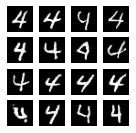

In [9]:
generator = load_model('cgan_mnist.h5')
class_label = 4
test_generator(generator, class_label)

test_outputs  labels for generated images:  [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]


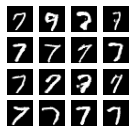

In [10]:
class_label = 7
test_generator(generator, class_label)